In [ ]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[classic-control]
!pip install moviepy
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import defaultdict
import gymnasium as gym
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, state):
        return self.fc(state)

In [ ]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.buffer = []
        self.index = 0

    def add(self, transition):
          """Adds a transition to the replay buffer."""
          state, action, reward, next_state, done = transition
          state = np.array(state, dtype=np.float32).flatten()
          next_state = np.array(next_state, dtype=np.float32).flatten()

          if len(self.buffer) < self.size:
              self.buffer.append(None)
          self.buffer[self.index] = (state, action, reward, next_state, done)
          self.index = (self.index + 1) % self.size

    def sample(self, batch_size):
        """Samples a batch of transitions."""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # Type casting from tuple to numpy array, to tensor (direct casting gave error)
        return (
            torch.tensor(np.stack(states), dtype=torch.float32),
            torch.tensor(np.stack(actions), dtype=torch.long),
            torch.tensor(np.array(rewards), dtype=torch.float32),
            torch.tensor(np.stack(next_states), dtype=torch.float32),
            torch.tensor(np.array(dones), dtype=torch.float32),
        )



In [ ]:
num_actions = 20

class DeepQAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
        replay_buffer_size: int,
        batch_size: int,
        target_update_interval: int,
    ):
        self.env = env
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.target_update_interval = target_update_interval
        self.action_bins = torch.linspace(-2, 2, steps=num_actions)

        state_dim = env.observation_space.shape[0]
        action_dim = 20  # Discretized action space size

        self.policy_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(replay_buffer_size)

        self.action_bins = np.linspace(env.action_space.low[0], env.action_space.high[0], action_dim)
        self.steps_done = 0
        self.gamma = discount_factor
        self.loss_fn = nn.MSELoss()

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.policy_net(state_tensor)
            discrete_action = torch.argmax(q_values).item()
            return self.action_bins[discrete_action]  # Exploit

    def get_discrete_action(self, state):
        if np.random.rand() < self.epsilon:
            # Explore
            action_idx = np.random.randint(0, len(self.action_bins))
        else:
            # Exploit
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.policy_net(state_tensor)  # shape = [1, num_actions]
            action_idx = torch.argmax(q_values, dim=1).item()
        return action_idx

    def decay_epsilon(self):
        """Linearly decays epsilon until it reaches final_epsilon."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)



    def train(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return  # not enough samples in the replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Ensure actions are 1D, gave error before
        actions = actions.view(-1)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

        next_q_values = self.target_net(next_states).max(1)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_target_network(self):
        if self.steps_done % self.target_update_interval == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


In [ ]:
learning_rate = 0.001
initial_epsilon = 1.0
epsilon_decay = 1e-4
final_epsilon = 0.01
discount_factor = 0.99
replay_buffer_size = 100000
batch_size = 64
target_update_interval = 1000

env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)

agent = DeepQAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=initial_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor,
    replay_buffer_size=replay_buffer_size,
    batch_size=batch_size,
    target_update_interval=target_update_interval,
)

n_episodes = 500
episode_rewards = []
for episode in tqdm(range(n_episodes)):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_discrete_action(state)

        next_state, reward, terminated, truncated, _ = env.step([action])
        done = terminated or truncated
        action_idx = agent.get_discrete_action(state)
        action_value = agent.action_bins[action_idx].item()
        next_state, reward, terminated, truncated, _ = env.step([action_value])
        done = terminated or truncated

        agent.replay_buffer.add((state, action_idx, reward, next_state, done))

        agent.train()

        agent.decay_epsilon()

        state = next_state
        total_reward += reward

    agent.update_target_network()
    episode_rewards.append(total_reward)
    print(f"Episode {episode}: Total Reward = {total_reward}")


  0%|          | 1/500 [00:00<02:10,  3.82it/s]

Episode 0: Total Reward = -528.0925314793024


  0%|          | 2/500 [00:00<02:03,  4.02it/s]

Episode 1: Total Reward = -837.2468524669035


  1%|          | 3/500 [00:00<02:05,  3.96it/s]

Episode 2: Total Reward = -865.5206492507465


  1%|          | 4/500 [00:00<02:01,  4.09it/s]

Episode 3: Total Reward = -616.7635879550999


  1%|          | 5/500 [00:01<01:59,  4.14it/s]

Episode 4: Total Reward = -565.17031701492


  1%|          | 6/500 [00:01<01:56,  4.23it/s]

Episode 5: Total Reward = -597.1779623897276


  1%|▏         | 7/500 [00:01<01:57,  4.18it/s]

Episode 6: Total Reward = -677.8800975161232


  2%|▏         | 8/500 [00:01<01:57,  4.20it/s]

Episode 7: Total Reward = -545.3446299483918


  2%|▏         | 9/500 [00:02<01:57,  4.19it/s]

Episode 8: Total Reward = -599.2488011972791


  2%|▏         | 10/500 [00:02<01:57,  4.17it/s]

Episode 9: Total Reward = -760.8409424051374


  2%|▏         | 11/500 [00:02<01:58,  4.12it/s]

Episode 10: Total Reward = -809.3417852505887


  2%|▏         | 12/500 [00:02<02:00,  4.05it/s]

Episode 11: Total Reward = -579.1923413069686


  3%|▎         | 13/500 [00:03<02:15,  3.60it/s]

Episode 12: Total Reward = -615.7513207669386


  3%|▎         | 14/500 [00:03<02:25,  3.34it/s]

Episode 13: Total Reward = -541.0027055469449


  3%|▎         | 15/500 [00:04<03:10,  2.55it/s]

Episode 14: Total Reward = -702.8128267861662


  3%|▎         | 16/500 [00:05<04:21,  1.85it/s]

Episode 15: Total Reward = -868.4475590656298


  3%|▎         | 17/500 [00:05<03:55,  2.05it/s]

Episode 16: Total Reward = -557.7834023370484


  4%|▎         | 18/500 [00:05<03:28,  2.31it/s]

Episode 17: Total Reward = -743.3738982062226


  4%|▍         | 19/500 [00:06<03:00,  2.66it/s]

Episode 18: Total Reward = -582.785321656044


  4%|▍         | 20/500 [00:06<02:40,  3.00it/s]

Episode 19: Total Reward = -601.199948588853


  4%|▍         | 21/500 [00:06<02:33,  3.11it/s]

Episode 20: Total Reward = -865.1760256632082


  4%|▍         | 22/500 [00:06<02:25,  3.28it/s]

Episode 21: Total Reward = -610.1476316791551


  5%|▍         | 23/500 [00:07<02:20,  3.38it/s]

Episode 22: Total Reward = -627.8316457299173


  5%|▍         | 24/500 [00:07<02:15,  3.53it/s]

Episode 23: Total Reward = -593.1219955557161


  5%|▌         | 25/500 [00:07<02:13,  3.55it/s]

Episode 24: Total Reward = -856.6291084740667


  5%|▌         | 26/500 [00:07<02:09,  3.66it/s]

Episode 25: Total Reward = -624.2002231166687


  5%|▌         | 27/500 [00:08<02:32,  3.11it/s]

Episode 26: Total Reward = -836.5966044855095


  6%|▌         | 28/500 [00:08<02:58,  2.64it/s]

Episode 27: Total Reward = -576.8764989699138


  6%|▌         | 29/500 [00:09<02:39,  2.96it/s]

Episode 28: Total Reward = -559.9454622598911


  6%|▌         | 30/500 [00:09<02:24,  3.25it/s]

Episode 29: Total Reward = -521.1694725280485


  6%|▌         | 31/500 [00:09<02:16,  3.43it/s]

Episode 30: Total Reward = -844.6654453798279


  6%|▋         | 32/500 [00:09<02:11,  3.56it/s]

Episode 31: Total Reward = -538.9851437522397


  7%|▋         | 33/500 [00:10<02:08,  3.65it/s]

Episode 32: Total Reward = -520.0111798324966


  7%|▋         | 34/500 [00:10<02:02,  3.80it/s]

Episode 33: Total Reward = -632.9179448531485


  7%|▋         | 35/500 [00:10<02:02,  3.78it/s]

Episode 34: Total Reward = -663.6413052066791


  7%|▋         | 36/500 [00:10<02:01,  3.82it/s]

Episode 35: Total Reward = -775.7549699224658


  7%|▋         | 37/500 [00:11<01:59,  3.88it/s]

Episode 36: Total Reward = -587.7166432061374


  8%|▊         | 38/500 [00:11<01:57,  3.93it/s]

Episode 37: Total Reward = -588.6644224180117


  8%|▊         | 39/500 [00:11<01:59,  3.84it/s]

Episode 38: Total Reward = -587.3933930852156


  8%|▊         | 40/500 [00:11<01:59,  3.86it/s]

Episode 39: Total Reward = -715.8985404252128


  8%|▊         | 41/500 [00:12<01:58,  3.88it/s]

Episode 40: Total Reward = -588.5393269475483


  8%|▊         | 42/500 [00:12<01:57,  3.90it/s]

Episode 41: Total Reward = -597.6565536241793


  9%|▊         | 43/500 [00:12<01:58,  3.86it/s]

Episode 42: Total Reward = -579.0240436002761


  9%|▉         | 44/500 [00:12<01:57,  3.87it/s]

Episode 43: Total Reward = -758.1632988977393


  9%|▉         | 45/500 [00:13<01:57,  3.89it/s]

Episode 44: Total Reward = -426.1223458021301


  9%|▉         | 46/500 [00:13<01:56,  3.90it/s]

Episode 45: Total Reward = -535.6365793747437


  9%|▉         | 47/500 [00:13<01:59,  3.79it/s]

Episode 46: Total Reward = -551.9994185581681


 10%|▉         | 48/500 [00:13<01:58,  3.82it/s]

Episode 47: Total Reward = -417.35132574851855


 10%|▉         | 49/500 [00:14<01:56,  3.87it/s]

Episode 48: Total Reward = -507.44251375167227


 10%|█         | 50/500 [00:14<01:55,  3.89it/s]

Episode 49: Total Reward = -587.8636041115934


 10%|█         | 51/500 [00:14<01:57,  3.82it/s]

Episode 50: Total Reward = -519.2466254589297


 10%|█         | 52/500 [00:14<01:55,  3.87it/s]

Episode 51: Total Reward = -562.4772902127611


 11%|█         | 53/500 [00:15<01:54,  3.91it/s]

Episode 52: Total Reward = -606.2025931597356


 11%|█         | 54/500 [00:15<01:54,  3.89it/s]

Episode 53: Total Reward = -523.3606322594324


 11%|█         | 55/500 [00:15<02:02,  3.63it/s]

Episode 54: Total Reward = -600.1588906158939


 11%|█         | 56/500 [00:16<02:12,  3.36it/s]

Episode 55: Total Reward = -539.1972193603335


 11%|█▏        | 57/500 [00:16<02:18,  3.21it/s]

Episode 56: Total Reward = -538.86426793386


 12%|█▏        | 58/500 [00:16<02:26,  3.01it/s]

Episode 57: Total Reward = -505.9793680530671


 12%|█▏        | 59/500 [00:17<02:24,  3.05it/s]

Episode 58: Total Reward = -569.5888182922841


 12%|█▏        | 60/500 [00:17<02:29,  2.95it/s]

Episode 59: Total Reward = -618.7301123074437


 12%|█▏        | 61/500 [00:17<02:37,  2.79it/s]

Episode 60: Total Reward = -549.143970432893


 12%|█▏        | 62/500 [00:18<02:41,  2.71it/s]

Episode 61: Total Reward = -482.3512809606248


 13%|█▎        | 63/500 [00:18<02:30,  2.90it/s]

Episode 62: Total Reward = -545.2932123914143


 13%|█▎        | 64/500 [00:18<02:21,  3.08it/s]

Episode 63: Total Reward = -513.1175328154453


 13%|█▎        | 65/500 [00:19<02:12,  3.29it/s]

Episode 64: Total Reward = -539.6199471194585


 13%|█▎        | 66/500 [00:19<02:06,  3.44it/s]

Episode 65: Total Reward = -722.1033568130042


 13%|█▎        | 67/500 [00:19<02:03,  3.49it/s]

Episode 66: Total Reward = -502.76922258212454


 14%|█▎        | 68/500 [00:19<02:01,  3.54it/s]

Episode 67: Total Reward = -630.936698485068


 14%|█▍        | 69/500 [00:20<01:58,  3.64it/s]

Episode 68: Total Reward = -553.3850758411911


 14%|█▍        | 70/500 [00:20<01:56,  3.68it/s]

Episode 69: Total Reward = -438.07959227561525


 14%|█▍        | 71/500 [00:20<01:56,  3.67it/s]

Episode 70: Total Reward = -539.9329110037138


 14%|█▍        | 72/500 [00:21<02:00,  3.55it/s]

Episode 71: Total Reward = -499.75425257450826


 15%|█▍        | 73/500 [00:21<01:58,  3.60it/s]

Episode 72: Total Reward = -503.32807955173513


 15%|█▍        | 74/500 [00:21<01:57,  3.63it/s]

Episode 73: Total Reward = -508.7375881089632


 15%|█▌        | 75/500 [00:21<01:56,  3.64it/s]

Episode 74: Total Reward = -558.8512782457229


 15%|█▌        | 76/500 [00:22<01:57,  3.61it/s]

Episode 75: Total Reward = -468.402566131983


 15%|█▌        | 77/500 [00:22<01:55,  3.67it/s]

Episode 76: Total Reward = -525.3121779319663


 16%|█▌        | 78/500 [00:22<01:54,  3.69it/s]

Episode 77: Total Reward = -518.5153219694815


 16%|█▌        | 79/500 [00:22<01:54,  3.68it/s]

Episode 78: Total Reward = -442.12580336279615


 16%|█▌        | 80/500 [00:23<01:52,  3.72it/s]

Episode 79: Total Reward = -489.42492967515733


 16%|█▌        | 81/500 [00:23<01:52,  3.73it/s]

Episode 80: Total Reward = -569.5461439224448


 16%|█▋        | 82/500 [00:23<01:53,  3.68it/s]

Episode 81: Total Reward = -447.85266932513383


 17%|█▋        | 83/500 [00:24<01:54,  3.65it/s]

Episode 82: Total Reward = -520.0497976643297


 17%|█▋        | 84/500 [00:24<01:52,  3.70it/s]

Episode 83: Total Reward = -503.03526615041824


 17%|█▋        | 85/500 [00:24<01:53,  3.66it/s]

Episode 84: Total Reward = -492.86267180283994


 17%|█▋        | 86/500 [00:24<01:52,  3.67it/s]

Episode 85: Total Reward = -378.69669176292126


 17%|█▋        | 87/500 [00:25<01:53,  3.65it/s]

Episode 86: Total Reward = -563.7946670522421


 18%|█▊        | 88/500 [00:25<01:51,  3.68it/s]

Episode 87: Total Reward = -444.37660260248146


 18%|█▊        | 89/500 [00:25<01:51,  3.67it/s]

Episode 88: Total Reward = -320.56144737965064


 18%|█▊        | 90/500 [00:25<01:53,  3.62it/s]

Episode 89: Total Reward = -629.6203489477464


 18%|█▊        | 91/500 [00:26<01:56,  3.51it/s]

Episode 90: Total Reward = -595.9191968640181


 18%|█▊        | 92/500 [00:26<02:00,  3.39it/s]

Episode 91: Total Reward = -565.6310142327934


 19%|█▊        | 93/500 [00:26<01:58,  3.43it/s]

Episode 92: Total Reward = -522.1257735055337


 19%|█▉        | 94/500 [00:27<01:58,  3.41it/s]

Episode 93: Total Reward = -527.9295808836652


 19%|█▉        | 95/500 [00:27<01:55,  3.51it/s]

Episode 94: Total Reward = -639.4732752925966


 19%|█▉        | 96/500 [00:27<01:53,  3.55it/s]

Episode 95: Total Reward = -452.89283197049764


 19%|█▉        | 97/500 [00:28<01:52,  3.57it/s]

Episode 96: Total Reward = -482.14496281044785


 20%|█▉        | 98/500 [00:28<01:51,  3.60it/s]

Episode 97: Total Reward = -458.836976924222


 20%|█▉        | 99/500 [00:28<01:56,  3.45it/s]

Episode 98: Total Reward = -380.2162127243342


 20%|██        | 100/500 [00:28<02:06,  3.17it/s]

Episode 99: Total Reward = -455.8656378020646


 20%|██        | 101/500 [00:29<02:12,  3.00it/s]

Episode 100: Total Reward = -577.0860660618386


 20%|██        | 102/500 [00:29<02:15,  2.93it/s]

Episode 101: Total Reward = -460.111867046348


 21%|██        | 103/500 [00:30<02:20,  2.82it/s]

Episode 102: Total Reward = -451.23785218215124


 21%|██        | 104/500 [00:30<02:26,  2.71it/s]

Episode 103: Total Reward = -458.0348619640214


 21%|██        | 105/500 [00:30<02:30,  2.63it/s]

Episode 104: Total Reward = -533.9093830343311


 21%|██        | 106/500 [00:31<02:25,  2.71it/s]

Episode 105: Total Reward = -566.7056032715035


 21%|██▏       | 107/500 [00:31<02:14,  2.93it/s]

Episode 106: Total Reward = -495.5388182214518


 22%|██▏       | 108/500 [00:31<02:06,  3.10it/s]

Episode 107: Total Reward = -451.0542613364044


 22%|██▏       | 109/500 [00:32<01:59,  3.27it/s]

Episode 108: Total Reward = -420.61973281658055


 22%|██▏       | 110/500 [00:32<01:56,  3.36it/s]

Episode 109: Total Reward = -428.9923209618225


 22%|██▏       | 111/500 [00:32<01:52,  3.45it/s]

Episode 110: Total Reward = -489.9639217660352


 22%|██▏       | 112/500 [00:32<01:49,  3.54it/s]

Episode 111: Total Reward = -450.5811610621675


 23%|██▎       | 113/500 [00:33<01:47,  3.61it/s]

Episode 112: Total Reward = -385.449668032473


 23%|██▎       | 114/500 [00:33<01:46,  3.62it/s]

Episode 113: Total Reward = -324.96267514691993


 23%|██▎       | 115/500 [00:33<01:47,  3.59it/s]

Episode 114: Total Reward = -492.52966078124285


 23%|██▎       | 116/500 [00:33<01:47,  3.58it/s]

Episode 115: Total Reward = -379.073845778659


 23%|██▎       | 117/500 [00:34<01:45,  3.63it/s]

Episode 116: Total Reward = -443.2235466400973


 24%|██▎       | 118/500 [00:34<01:45,  3.63it/s]

Episode 117: Total Reward = -494.08215002527606


 24%|██▍       | 119/500 [00:34<01:44,  3.63it/s]

Episode 118: Total Reward = -386.8948172343895


 24%|██▍       | 120/500 [00:35<01:43,  3.68it/s]

Episode 119: Total Reward = -439.5043127622126


 24%|██▍       | 121/500 [00:35<01:41,  3.73it/s]

Episode 120: Total Reward = -448.2406053747005


 24%|██▍       | 122/500 [00:35<01:43,  3.67it/s]

Episode 121: Total Reward = -530.8562227235917


 25%|██▍       | 123/500 [00:35<01:42,  3.67it/s]

Episode 122: Total Reward = -553.6282009761981


 25%|██▍       | 124/500 [00:36<01:41,  3.71it/s]

Episode 123: Total Reward = -462.53625640192894


 25%|██▌       | 125/500 [00:36<01:41,  3.69it/s]

Episode 124: Total Reward = -448.2718007055962


 25%|██▌       | 126/500 [00:36<01:42,  3.64it/s]

Episode 125: Total Reward = -367.20505564657


 25%|██▌       | 127/500 [00:36<01:42,  3.65it/s]

Episode 126: Total Reward = -533.2396367560492


 26%|██▌       | 128/500 [00:37<01:42,  3.61it/s]

Episode 127: Total Reward = -449.78286130021166


 26%|██▌       | 129/500 [00:37<01:46,  3.49it/s]

Episode 128: Total Reward = -574.5265595367628


 26%|██▌       | 130/500 [00:37<01:45,  3.51it/s]

Episode 129: Total Reward = -374.9171280618902


 26%|██▌       | 131/500 [00:38<01:44,  3.53it/s]

Episode 130: Total Reward = -465.54343151970636


 26%|██▋       | 132/500 [00:38<01:42,  3.58it/s]

Episode 131: Total Reward = -445.5567511310535


 27%|██▋       | 133/500 [00:38<01:43,  3.53it/s]

Episode 132: Total Reward = -451.2402322159881


 27%|██▋       | 134/500 [00:38<01:42,  3.58it/s]

Episode 133: Total Reward = -462.3197377111238


 27%|██▋       | 135/500 [00:39<01:40,  3.63it/s]

Episode 134: Total Reward = -515.1285112427205


 27%|██▋       | 136/500 [00:39<01:39,  3.66it/s]

Episode 135: Total Reward = -499.88587534123934


 27%|██▋       | 137/500 [00:39<01:41,  3.56it/s]

Episode 136: Total Reward = -462.7724412535132


 28%|██▊       | 138/500 [00:40<01:40,  3.62it/s]

Episode 137: Total Reward = -392.5835336745524


 28%|██▊       | 139/500 [00:40<01:38,  3.66it/s]

Episode 138: Total Reward = -395.59871407723347


 28%|██▊       | 140/500 [00:40<01:39,  3.63it/s]

Episode 139: Total Reward = -188.2658995406874


 28%|██▊       | 141/500 [00:40<01:37,  3.68it/s]

Episode 140: Total Reward = -385.6759888994098


 28%|██▊       | 142/500 [00:41<01:36,  3.73it/s]

Episode 141: Total Reward = -585.7037659103801


 29%|██▊       | 143/500 [00:41<01:48,  3.30it/s]

Episode 142: Total Reward = -256.1612425814533


 29%|██▉       | 144/500 [00:41<01:57,  3.03it/s]

Episode 143: Total Reward = -361.9766385066756


 29%|██▉       | 145/500 [00:42<02:00,  2.94it/s]

Episode 144: Total Reward = -252.75342893029264


 29%|██▉       | 146/500 [00:42<02:04,  2.85it/s]

Episode 145: Total Reward = -62.51830908244787


 29%|██▉       | 147/500 [00:43<02:09,  2.73it/s]

Episode 146: Total Reward = -316.82055436632555


 30%|██▉       | 148/500 [00:43<02:13,  2.64it/s]

Episode 147: Total Reward = -377.7555541278635


 30%|██▉       | 149/500 [00:43<02:17,  2.55it/s]

Episode 148: Total Reward = -382.599398992567


 30%|███       | 150/500 [00:44<02:03,  2.83it/s]

Episode 149: Total Reward = -324.2667588366007


 30%|███       | 151/500 [00:44<01:53,  3.07it/s]

Episode 150: Total Reward = -432.60229443691935


 30%|███       | 152/500 [00:44<01:47,  3.23it/s]

Episode 151: Total Reward = -456.994672713851


 31%|███       | 153/500 [00:44<01:43,  3.35it/s]

Episode 152: Total Reward = -421.1237404791124


 31%|███       | 154/500 [00:45<01:39,  3.48it/s]

Episode 153: Total Reward = -441.7847414195088


 31%|███       | 155/500 [00:45<01:36,  3.57it/s]

Episode 154: Total Reward = -200.96083228308686


 31%|███       | 156/500 [00:45<01:35,  3.59it/s]

Episode 155: Total Reward = -320.9851949094803


 31%|███▏      | 157/500 [00:46<01:35,  3.60it/s]

Episode 156: Total Reward = -443.40959274972016


 32%|███▏      | 158/500 [00:46<01:33,  3.66it/s]

Episode 157: Total Reward = -377.94806713806264


 32%|███▏      | 159/500 [00:46<01:32,  3.67it/s]

Episode 158: Total Reward = -319.08760666543964


 32%|███▏      | 160/500 [00:46<01:34,  3.61it/s]

Episode 159: Total Reward = -186.553714092074


 32%|███▏      | 161/500 [00:47<01:32,  3.65it/s]

Episode 160: Total Reward = -379.0312702760988


 32%|███▏      | 162/500 [00:47<01:31,  3.68it/s]

Episode 161: Total Reward = -124.17414553775667


 33%|███▎      | 163/500 [00:47<01:31,  3.69it/s]

Episode 162: Total Reward = -348.85287610323473


 33%|███▎      | 164/500 [00:47<01:32,  3.65it/s]

Episode 163: Total Reward = -341.8601258356496


 33%|███▎      | 165/500 [00:48<01:30,  3.71it/s]

Episode 164: Total Reward = -441.6932994929802


 33%|███▎      | 166/500 [00:48<01:29,  3.74it/s]

Episode 165: Total Reward = -374.7078076348477


 33%|███▎      | 167/500 [00:48<01:29,  3.74it/s]

Episode 166: Total Reward = -380.215865368568


 34%|███▎      | 168/500 [00:48<01:29,  3.72it/s]

Episode 167: Total Reward = -387.3836352016092


 34%|███▍      | 169/500 [00:49<01:28,  3.74it/s]

Episode 168: Total Reward = -344.80200247759325


 34%|███▍      | 170/500 [00:49<01:29,  3.70it/s]

Episode 169: Total Reward = -389.93191577078767


 34%|███▍      | 171/500 [00:49<01:30,  3.64it/s]

Episode 170: Total Reward = -423.0645826764128


 34%|███▍      | 172/500 [00:50<01:31,  3.57it/s]

Episode 171: Total Reward = -370.62391803479443


 35%|███▍      | 173/500 [00:50<01:30,  3.61it/s]

Episode 172: Total Reward = -309.688257090516


 35%|███▍      | 174/500 [00:50<01:30,  3.61it/s]

Episode 173: Total Reward = -362.95999438348025


 35%|███▌      | 175/500 [00:50<01:30,  3.57it/s]

Episode 174: Total Reward = -260.27654989824543


 35%|███▌      | 176/500 [00:51<01:29,  3.62it/s]

Episode 175: Total Reward = -309.25808117865813


 35%|███▌      | 177/500 [00:51<01:29,  3.62it/s]

Episode 176: Total Reward = -249.2080136182157


 36%|███▌      | 178/500 [00:51<01:29,  3.61it/s]

Episode 177: Total Reward = -433.7532872967999


 36%|███▌      | 179/500 [00:52<01:29,  3.57it/s]

Episode 178: Total Reward = -189.43159303680608


 36%|███▌      | 180/500 [00:52<01:28,  3.62it/s]

Episode 179: Total Reward = -317.52158624798494


 36%|███▌      | 181/500 [00:52<01:28,  3.61it/s]

Episode 180: Total Reward = -303.29016249684463


 36%|███▋      | 182/500 [00:52<01:27,  3.65it/s]

Episode 181: Total Reward = -402.6563168885775


 37%|███▋      | 183/500 [00:53<01:27,  3.64it/s]

Episode 182: Total Reward = -378.6062981226988


 37%|███▋      | 184/500 [00:53<01:26,  3.66it/s]

Episode 183: Total Reward = -501.5074598642961


 37%|███▋      | 185/500 [00:53<01:26,  3.65it/s]

Episode 184: Total Reward = -314.35561855826296


 37%|███▋      | 186/500 [00:53<01:29,  3.49it/s]

Episode 185: Total Reward = -381.4872877919644


 37%|███▋      | 187/500 [00:54<01:39,  3.14it/s]

Episode 186: Total Reward = -375.60640523230353


 38%|███▊      | 188/500 [00:54<01:45,  2.95it/s]

Episode 187: Total Reward = -372.7957550859361


 38%|███▊      | 189/500 [00:55<01:47,  2.89it/s]

Episode 188: Total Reward = -432.1185337238295


 38%|███▊      | 190/500 [00:55<01:49,  2.84it/s]

Episode 189: Total Reward = -67.59053217258254


 38%|███▊      | 191/500 [00:55<01:53,  2.73it/s]

Episode 190: Total Reward = -198.69515321882815


 38%|███▊      | 192/500 [00:56<01:57,  2.63it/s]

Episode 191: Total Reward = -412.91944104667164


 39%|███▊      | 193/500 [00:56<01:57,  2.62it/s]

Episode 192: Total Reward = -316.57799723770097


 39%|███▉      | 194/500 [00:56<01:46,  2.87it/s]

Episode 193: Total Reward = -467.04875471371906


 39%|███▉      | 195/500 [00:57<01:39,  3.06it/s]

Episode 194: Total Reward = -439.9706885559323


 39%|███▉      | 196/500 [00:57<01:34,  3.22it/s]

Episode 195: Total Reward = -431.77223561382505


 39%|███▉      | 197/500 [00:57<01:32,  3.27it/s]

Episode 196: Total Reward = -447.1146473287182


 40%|███▉      | 198/500 [00:58<01:28,  3.39it/s]

Episode 197: Total Reward = -490.84072787810027


 40%|███▉      | 199/500 [00:58<01:27,  3.44it/s]

Episode 198: Total Reward = -415.30536246664946


 40%|████      | 200/500 [00:58<01:25,  3.50it/s]

Episode 199: Total Reward = -446.66837081102005


 40%|████      | 201/500 [00:58<01:23,  3.60it/s]

Episode 200: Total Reward = -643.1313685953781


 40%|████      | 202/500 [00:59<01:23,  3.58it/s]

Episode 201: Total Reward = -380.50338062647205


 41%|████      | 203/500 [00:59<01:22,  3.59it/s]

Episode 202: Total Reward = -380.72299947687833


 41%|████      | 204/500 [00:59<01:22,  3.61it/s]

Episode 203: Total Reward = -584.4316304175187


 41%|████      | 205/500 [01:00<01:21,  3.62it/s]

Episode 204: Total Reward = -456.25143199194684


 41%|████      | 206/500 [01:00<01:21,  3.60it/s]

Episode 205: Total Reward = -383.960170488396


 41%|████▏     | 207/500 [01:00<01:21,  3.62it/s]

Episode 206: Total Reward = -366.2520393876416


 42%|████▏     | 208/500 [01:00<01:20,  3.64it/s]

Episode 207: Total Reward = -502.88442664695026


 42%|████▏     | 209/500 [01:01<01:18,  3.70it/s]

Episode 208: Total Reward = -184.85847064464383


 42%|████▏     | 210/500 [01:01<01:18,  3.68it/s]

Episode 209: Total Reward = -319.65747195442594


 42%|████▏     | 211/500 [01:01<01:18,  3.68it/s]

Episode 210: Total Reward = -260.2544322347588


 42%|████▏     | 212/500 [01:01<01:19,  3.63it/s]

Episode 211: Total Reward = -67.72327404713413


 43%|████▎     | 213/500 [01:02<01:18,  3.65it/s]

Episode 212: Total Reward = -318.31873514753136


 43%|████▎     | 214/500 [01:02<01:19,  3.58it/s]

Episode 213: Total Reward = -186.0649093975064


 43%|████▎     | 215/500 [01:02<01:19,  3.57it/s]

Episode 214: Total Reward = -255.99413559756096


 43%|████▎     | 216/500 [01:03<01:18,  3.60it/s]

Episode 215: Total Reward = -251.9964203765027


 43%|████▎     | 217/500 [01:03<01:18,  3.61it/s]

Episode 216: Total Reward = -120.77340417692578


 44%|████▎     | 218/500 [01:03<01:19,  3.54it/s]

Episode 217: Total Reward = -338.467269892444


 44%|████▍     | 219/500 [01:03<01:18,  3.57it/s]

Episode 218: Total Reward = -63.36845907120324


 44%|████▍     | 220/500 [01:04<01:17,  3.61it/s]

Episode 219: Total Reward = -352.68487149999856


 44%|████▍     | 221/500 [01:04<01:17,  3.58it/s]

Episode 220: Total Reward = -254.0523116710122


 44%|████▍     | 222/500 [01:04<01:17,  3.61it/s]

Episode 221: Total Reward = -132.04614313830825


 45%|████▍     | 223/500 [01:04<01:16,  3.64it/s]

Episode 222: Total Reward = -124.523656440412


 45%|████▍     | 224/500 [01:05<01:15,  3.67it/s]

Episode 223: Total Reward = -295.3540708950604


 45%|████▌     | 225/500 [01:05<01:16,  3.62it/s]

Episode 224: Total Reward = -102.80285005157938


 45%|████▌     | 226/500 [01:05<01:16,  3.59it/s]

Episode 225: Total Reward = -243.87067889749167


 45%|████▌     | 227/500 [01:06<01:15,  3.63it/s]

Episode 226: Total Reward = -77.60534589019333


 46%|████▌     | 228/500 [01:06<01:14,  3.65it/s]

Episode 227: Total Reward = -117.18048172777574


 46%|████▌     | 229/500 [01:06<01:17,  3.49it/s]

Episode 228: Total Reward = -124.10280496661329


 46%|████▌     | 230/500 [01:07<01:25,  3.15it/s]

Episode 229: Total Reward = -382.644852234147


 46%|████▌     | 231/500 [01:07<01:28,  3.02it/s]

Episode 230: Total Reward = -251.20593272337737


 46%|████▋     | 232/500 [01:07<01:32,  2.89it/s]

Episode 231: Total Reward = -427.5827098199859


 47%|████▋     | 233/500 [01:08<01:33,  2.86it/s]

Episode 232: Total Reward = -251.70547471753292


 47%|████▋     | 234/500 [01:08<01:37,  2.72it/s]

Episode 233: Total Reward = -313.05144854951186


 47%|████▋     | 235/500 [01:08<01:40,  2.64it/s]

Episode 234: Total Reward = -137.65413032925008


 47%|████▋     | 236/500 [01:09<01:41,  2.59it/s]

Episode 235: Total Reward = -69.71963582419524


 47%|████▋     | 237/500 [01:09<01:33,  2.80it/s]

Episode 236: Total Reward = -5.170669100297035


 48%|████▊     | 238/500 [01:09<01:27,  2.98it/s]

Episode 237: Total Reward = -67.29944619645285


 48%|████▊     | 239/500 [01:10<01:21,  3.19it/s]

Episode 238: Total Reward = -183.93744748669084


 48%|████▊     | 240/500 [01:10<01:17,  3.34it/s]

Episode 239: Total Reward = -174.71357969945305


 48%|████▊     | 241/500 [01:10<01:16,  3.36it/s]

Episode 240: Total Reward = -118.07741722015001


 48%|████▊     | 242/500 [01:11<01:14,  3.48it/s]

Episode 241: Total Reward = -63.31554581329729


 49%|████▊     | 243/500 [01:11<01:12,  3.55it/s]

Episode 242: Total Reward = -119.11478544544887


 49%|████▉     | 244/500 [01:11<01:11,  3.57it/s]

Episode 243: Total Reward = -121.18961545336391


 49%|████▉     | 245/500 [01:11<01:11,  3.56it/s]

Episode 244: Total Reward = -121.91230892950375


 49%|████▉     | 246/500 [01:12<01:09,  3.66it/s]

Episode 245: Total Reward = -118.06591744859901


 49%|████▉     | 247/500 [01:12<01:08,  3.70it/s]

Episode 246: Total Reward = -72.41931936663781


 50%|████▉     | 248/500 [01:12<01:09,  3.62it/s]

Episode 247: Total Reward = -181.40294145809605


 50%|████▉     | 249/500 [01:12<01:09,  3.63it/s]

Episode 248: Total Reward = -172.78759044221937


 50%|█████     | 250/500 [01:13<01:08,  3.67it/s]

Episode 249: Total Reward = -130.1301390809349


 50%|█████     | 251/500 [01:13<01:07,  3.68it/s]

Episode 250: Total Reward = -6.19537556176942


 50%|█████     | 252/500 [01:13<01:08,  3.61it/s]

Episode 251: Total Reward = -124.17440765575111


 51%|█████     | 253/500 [01:14<01:07,  3.64it/s]

Episode 252: Total Reward = -247.31530213321932


 51%|█████     | 254/500 [01:14<01:07,  3.66it/s]

Episode 253: Total Reward = -298.3011116346811


 51%|█████     | 255/500 [01:14<01:07,  3.61it/s]

Episode 254: Total Reward = -254.4346904915055


 51%|█████     | 256/500 [01:14<01:08,  3.57it/s]

Episode 255: Total Reward = -254.41149945281413


 51%|█████▏    | 257/500 [01:15<01:07,  3.61it/s]

Episode 256: Total Reward = -430.8229106542479


 52%|█████▏    | 258/500 [01:15<01:07,  3.59it/s]

Episode 257: Total Reward = -98.2200564651584


 52%|█████▏    | 259/500 [01:15<01:09,  3.48it/s]

Episode 258: Total Reward = -191.20582361904457


 52%|█████▏    | 260/500 [01:16<01:08,  3.49it/s]

Episode 259: Total Reward = -69.34991505857265


 52%|█████▏    | 261/500 [01:16<01:07,  3.53it/s]

Episode 260: Total Reward = -237.99521501109405


 52%|█████▏    | 262/500 [01:16<01:07,  3.52it/s]

Episode 261: Total Reward = -300.52337031152115


 53%|█████▎    | 263/500 [01:16<01:07,  3.49it/s]

Episode 262: Total Reward = -68.25459825137712


 53%|█████▎    | 264/500 [01:17<01:06,  3.55it/s]

Episode 263: Total Reward = -265.0970394106546


 53%|█████▎    | 265/500 [01:17<01:06,  3.54it/s]

Episode 264: Total Reward = -180.33876162546852


 53%|█████▎    | 266/500 [01:17<01:06,  3.53it/s]

Episode 265: Total Reward = -178.8830043964747


 53%|█████▎    | 267/500 [01:18<01:06,  3.53it/s]

Episode 266: Total Reward = -60.9170210004482


 54%|█████▎    | 268/500 [01:18<01:04,  3.60it/s]

Episode 267: Total Reward = -65.45951254490339


 54%|█████▍    | 269/500 [01:18<01:03,  3.62it/s]

Episode 268: Total Reward = -63.71371507485036


 54%|█████▍    | 270/500 [01:18<01:04,  3.57it/s]

Episode 269: Total Reward = -64.13472435142764


 54%|█████▍    | 271/500 [01:19<01:02,  3.65it/s]

Episode 270: Total Reward = -194.40976483547234


 54%|█████▍    | 272/500 [01:19<01:02,  3.67it/s]

Episode 271: Total Reward = -62.68876527679259


 55%|█████▍    | 273/500 [01:19<01:10,  3.23it/s]

Episode 272: Total Reward = -173.07924450286444


 55%|█████▍    | 274/500 [01:20<01:14,  3.02it/s]

Episode 273: Total Reward = -181.7776863482061


 55%|█████▌    | 275/500 [01:20<01:17,  2.90it/s]

Episode 274: Total Reward = -310.0555625359598


 55%|█████▌    | 276/500 [01:20<01:18,  2.86it/s]

Episode 275: Total Reward = -185.90175139898818


 55%|█████▌    | 277/500 [01:21<01:21,  2.74it/s]

Episode 276: Total Reward = -68.65278807495352


 56%|█████▌    | 278/500 [01:21<01:23,  2.65it/s]

Episode 277: Total Reward = -229.35695469547028


 56%|█████▌    | 279/500 [01:22<01:27,  2.52it/s]

Episode 278: Total Reward = -64.8385763347898


 56%|█████▌    | 280/500 [01:22<01:21,  2.71it/s]

Episode 279: Total Reward = -169.73722341676682


 56%|█████▌    | 281/500 [01:22<01:14,  2.93it/s]

Episode 280: Total Reward = -237.74579724390537


 56%|█████▋    | 282/500 [01:22<01:09,  3.12it/s]

Episode 281: Total Reward = -69.67856148616421


 57%|█████▋    | 283/500 [01:23<01:06,  3.27it/s]

Episode 282: Total Reward = -67.87318935556702


 57%|█████▋    | 284/500 [01:23<01:04,  3.37it/s]

Episode 283: Total Reward = -124.94992017387797


 57%|█████▋    | 285/500 [01:23<01:02,  3.45it/s]

Episode 284: Total Reward = -62.8150586366891


 57%|█████▋    | 286/500 [01:24<01:00,  3.54it/s]

Episode 285: Total Reward = -282.5347530969394


 57%|█████▋    | 287/500 [01:24<01:00,  3.53it/s]

Episode 286: Total Reward = -118.61773754481808


 58%|█████▊    | 288/500 [01:24<01:00,  3.53it/s]

Episode 287: Total Reward = -118.02871064317777


 58%|█████▊    | 289/500 [01:24<00:58,  3.58it/s]

Episode 288: Total Reward = -62.649600225199194


 58%|█████▊    | 290/500 [01:25<00:57,  3.62it/s]

Episode 289: Total Reward = -4.526654318372052


 58%|█████▊    | 291/500 [01:25<00:57,  3.63it/s]

Episode 290: Total Reward = -60.9722557697895


 58%|█████▊    | 292/500 [01:25<00:57,  3.62it/s]

Episode 291: Total Reward = -121.72265822741288


 59%|█████▊    | 293/500 [01:26<00:57,  3.59it/s]

Episode 292: Total Reward = -3.7373454154472916


 59%|█████▉    | 294/500 [01:26<00:58,  3.50it/s]

Episode 293: Total Reward = -63.96086258410696


 59%|█████▉    | 295/500 [01:26<00:58,  3.48it/s]

Episode 294: Total Reward = -122.02518347643864


 59%|█████▉    | 296/500 [01:26<00:57,  3.54it/s]

Episode 295: Total Reward = -121.71525783442063


 59%|█████▉    | 297/500 [01:27<00:56,  3.56it/s]

Episode 296: Total Reward = -178.90485856734853


 60%|█████▉    | 298/500 [01:27<00:59,  3.38it/s]

Episode 297: Total Reward = -169.1475878277059


 60%|█████▉    | 299/500 [01:27<00:58,  3.41it/s]

Episode 298: Total Reward = -181.51808043315916


 60%|██████    | 300/500 [01:28<00:57,  3.46it/s]

Episode 299: Total Reward = -207.53693276411062


 60%|██████    | 301/500 [01:28<00:57,  3.47it/s]

Episode 300: Total Reward = -3.838680903240096


 60%|██████    | 302/500 [01:28<00:56,  3.48it/s]

Episode 301: Total Reward = -121.89052643059749


 61%|██████    | 303/500 [01:28<00:55,  3.52it/s]

Episode 302: Total Reward = -231.52863824902184


 61%|██████    | 304/500 [01:29<00:55,  3.52it/s]

Episode 303: Total Reward = -2.598284328433299


 61%|██████    | 305/500 [01:29<00:55,  3.51it/s]

Episode 304: Total Reward = -120.74682017653765


 61%|██████    | 306/500 [01:29<00:54,  3.55it/s]

Episode 305: Total Reward = -118.70559583818975


 61%|██████▏   | 307/500 [01:30<00:53,  3.58it/s]

Episode 306: Total Reward = -64.4078295173642


 62%|██████▏   | 308/500 [01:30<00:59,  3.25it/s]

Episode 307: Total Reward = -121.18439399755049


 62%|██████▏   | 309/500 [01:30<01:03,  3.00it/s]

Episode 308: Total Reward = -59.7975262367946


 62%|██████▏   | 310/500 [01:31<01:04,  2.93it/s]

Episode 309: Total Reward = -61.03377634350007


 62%|██████▏   | 311/500 [01:31<01:06,  2.85it/s]

Episode 310: Total Reward = -66.19770406368318


 62%|██████▏   | 312/500 [01:31<01:07,  2.79it/s]

Episode 311: Total Reward = -63.13199761033038


 63%|██████▎   | 313/500 [01:32<01:08,  2.71it/s]

Episode 312: Total Reward = -117.49705601128426


 63%|██████▎   | 314/500 [01:32<01:14,  2.49it/s]

Episode 313: Total Reward = -67.31028971903355


 63%|██████▎   | 315/500 [01:33<01:16,  2.42it/s]

Episode 314: Total Reward = -125.185042779234


 63%|██████▎   | 316/500 [01:33<01:14,  2.46it/s]

Episode 315: Total Reward = -64.95301750950217


 63%|██████▎   | 317/500 [01:33<01:11,  2.54it/s]

Episode 316: Total Reward = -177.805973097456


 64%|██████▎   | 318/500 [01:34<01:10,  2.60it/s]

Episode 317: Total Reward = -63.68540586517436


 64%|██████▍   | 319/500 [01:34<01:11,  2.54it/s]

Episode 318: Total Reward = -60.91883484948063


 64%|██████▍   | 320/500 [01:35<01:11,  2.52it/s]

Episode 319: Total Reward = -121.42043248480624


 64%|██████▍   | 321/500 [01:35<01:08,  2.63it/s]

Episode 320: Total Reward = -64.60219815830334


 64%|██████▍   | 322/500 [01:35<01:02,  2.85it/s]

Episode 321: Total Reward = -115.17835188314493


 65%|██████▍   | 323/500 [01:36<00:58,  3.04it/s]

Episode 322: Total Reward = -176.9374979158805


 65%|██████▍   | 324/500 [01:36<00:54,  3.22it/s]

Episode 323: Total Reward = -173.75454460930524


 65%|██████▌   | 325/500 [01:36<00:53,  3.27it/s]

Episode 324: Total Reward = -65.41504713950332


 65%|██████▌   | 326/500 [01:36<00:51,  3.38it/s]

Episode 325: Total Reward = -177.53026199690453


 65%|██████▌   | 327/500 [01:37<00:50,  3.46it/s]

Episode 326: Total Reward = -61.66539897635568


 66%|██████▌   | 328/500 [01:37<00:48,  3.54it/s]

Episode 327: Total Reward = -62.16545126387555


 66%|██████▌   | 329/500 [01:37<00:50,  3.40it/s]

Episode 328: Total Reward = -125.0409075249315


 66%|██████▌   | 330/500 [01:38<00:49,  3.42it/s]

Episode 329: Total Reward = -120.31690385006533


 66%|██████▌   | 331/500 [01:38<00:48,  3.51it/s]

Episode 330: Total Reward = -117.51995411711232


 66%|██████▋   | 332/500 [01:38<00:48,  3.50it/s]

Episode 331: Total Reward = -125.88523863271993


 67%|██████▋   | 333/500 [01:38<00:47,  3.49it/s]

Episode 332: Total Reward = -64.17291151714117


 67%|██████▋   | 334/500 [01:39<00:46,  3.55it/s]

Episode 333: Total Reward = -62.28314709186347


 67%|██████▋   | 335/500 [01:39<00:45,  3.59it/s]

Episode 334: Total Reward = -122.5071722000094


 67%|██████▋   | 336/500 [01:39<00:47,  3.44it/s]

Episode 335: Total Reward = -62.806101371228486


 67%|██████▋   | 337/500 [01:40<00:47,  3.44it/s]

Episode 336: Total Reward = -181.11844738697067


 68%|██████▊   | 338/500 [01:40<00:45,  3.52it/s]

Episode 337: Total Reward = -235.82231034831395


 68%|██████▊   | 339/500 [01:40<00:46,  3.49it/s]

Episode 338: Total Reward = -118.28625643036155


 68%|██████▊   | 340/500 [01:40<00:45,  3.48it/s]

Episode 339: Total Reward = -115.23920210540452


 68%|██████▊   | 341/500 [01:41<00:45,  3.52it/s]

Episode 340: Total Reward = -65.05750136106373


 68%|██████▊   | 342/500 [01:41<00:44,  3.51it/s]

Episode 341: Total Reward = -65.3399998408284


 69%|██████▊   | 343/500 [01:41<00:44,  3.51it/s]

Episode 342: Total Reward = -117.56466019517276


 69%|██████▉   | 344/500 [01:42<00:45,  3.46it/s]

Episode 343: Total Reward = -61.04488366800674


 69%|██████▉   | 345/500 [01:42<00:44,  3.49it/s]

Episode 344: Total Reward = -125.97777696637851


 69%|██████▉   | 346/500 [01:42<00:44,  3.45it/s]

Episode 345: Total Reward = -227.3845243415178


 69%|██████▉   | 347/500 [01:42<00:44,  3.46it/s]

Episode 346: Total Reward = -117.27332729523128


 70%|██████▉   | 348/500 [01:43<00:43,  3.52it/s]

Episode 347: Total Reward = -118.37901341347941


 70%|██████▉   | 349/500 [01:43<00:42,  3.57it/s]

Episode 348: Total Reward = -63.74374759475077


 70%|███████   | 350/500 [01:43<00:41,  3.58it/s]

Episode 349: Total Reward = -125.43374844547957


 70%|███████   | 351/500 [01:44<00:42,  3.48it/s]

Episode 350: Total Reward = -187.69889598096313


 70%|███████   | 352/500 [01:44<00:41,  3.53it/s]

Episode 351: Total Reward = -3.0759699730873233


 71%|███████   | 353/500 [01:44<00:42,  3.50it/s]

Episode 352: Total Reward = -184.96612186853127


 71%|███████   | 354/500 [01:44<00:41,  3.55it/s]

Episode 353: Total Reward = -3.0806071939809296


 71%|███████   | 355/500 [01:45<00:40,  3.56it/s]

Episode 354: Total Reward = -62.06893384868322


 71%|███████   | 356/500 [01:45<00:40,  3.52it/s]

Episode 355: Total Reward = -3.156252080357112


 71%|███████▏  | 357/500 [01:45<00:45,  3.13it/s]

Episode 356: Total Reward = -62.03084579603176


 72%|███████▏  | 358/500 [01:46<00:47,  2.98it/s]

Episode 357: Total Reward = -3.667537625147152


 72%|███████▏  | 359/500 [01:46<00:49,  2.87it/s]

Episode 358: Total Reward = -65.43514624005537


 72%|███████▏  | 360/500 [01:46<00:49,  2.83it/s]

Episode 359: Total Reward = -124.56680357739653


 72%|███████▏  | 361/500 [01:47<00:50,  2.74it/s]

Episode 360: Total Reward = -3.4164269848654722


 72%|███████▏  | 362/500 [01:47<00:52,  2.61it/s]

Episode 361: Total Reward = -241.51610525346186


 73%|███████▎  | 363/500 [01:48<00:54,  2.53it/s]

Episode 362: Total Reward = -119.18040265979823


 73%|███████▎  | 364/500 [01:48<00:48,  2.78it/s]

Episode 363: Total Reward = -4.289819656803142


 73%|███████▎  | 365/500 [01:48<00:45,  2.98it/s]

Episode 364: Total Reward = -242.9948014965718


 73%|███████▎  | 366/500 [01:49<00:42,  3.14it/s]

Episode 365: Total Reward = -221.01695779469514


 73%|███████▎  | 367/500 [01:49<00:40,  3.30it/s]

Episode 366: Total Reward = -116.90388034806935


 74%|███████▎  | 368/500 [01:49<00:39,  3.38it/s]

Episode 367: Total Reward = -187.6936630231073


 74%|███████▍  | 369/500 [01:49<00:38,  3.42it/s]

Episode 368: Total Reward = -3.862231169158294


 74%|███████▍  | 370/500 [01:50<00:38,  3.42it/s]

Episode 369: Total Reward = -116.4638196170364


 74%|███████▍  | 371/500 [01:50<00:36,  3.49it/s]

Episode 370: Total Reward = -62.296861191074456


 74%|███████▍  | 372/500 [01:50<00:36,  3.50it/s]

Episode 371: Total Reward = -64.64783503655727


 75%|███████▍  | 373/500 [01:50<00:35,  3.54it/s]

Episode 372: Total Reward = -237.48208430541885


 75%|███████▍  | 374/500 [01:51<00:35,  3.55it/s]

Episode 373: Total Reward = -62.19587661374264


 75%|███████▌  | 375/500 [01:51<00:34,  3.58it/s]

Episode 374: Total Reward = -180.39510561707408


 75%|███████▌  | 376/500 [01:51<00:34,  3.56it/s]

Episode 375: Total Reward = -121.93730816135559


 75%|███████▌  | 377/500 [01:52<00:34,  3.60it/s]

Episode 376: Total Reward = -58.68634460588041


 76%|███████▌  | 378/500 [01:52<00:33,  3.60it/s]

Episode 377: Total Reward = -180.9095323825898


 76%|███████▌  | 379/500 [01:52<00:33,  3.56it/s]

Episode 378: Total Reward = -117.8374799175522


 76%|███████▌  | 380/500 [01:52<00:33,  3.61it/s]

Episode 379: Total Reward = -118.63293014442603


 76%|███████▌  | 381/500 [01:53<00:32,  3.64it/s]

Episode 380: Total Reward = -3.1398974313707018


 76%|███████▋  | 382/500 [01:53<00:32,  3.58it/s]

Episode 381: Total Reward = -64.14887654244428


 77%|███████▋  | 383/500 [01:53<00:32,  3.56it/s]

Episode 382: Total Reward = -59.438671338482045


 77%|███████▋  | 384/500 [01:54<00:32,  3.54it/s]

Episode 383: Total Reward = -240.56130135328567


 77%|███████▋  | 385/500 [01:54<00:32,  3.51it/s]

Episode 384: Total Reward = -63.99801116880805


 77%|███████▋  | 386/500 [01:54<00:32,  3.46it/s]

Episode 385: Total Reward = -60.9392138816495


 77%|███████▋  | 387/500 [01:54<00:32,  3.51it/s]

Episode 386: Total Reward = -117.69612949655061


 78%|███████▊  | 388/500 [01:55<00:31,  3.55it/s]

Episode 387: Total Reward = -63.393999951854774


 78%|███████▊  | 389/500 [01:55<00:31,  3.53it/s]

Episode 388: Total Reward = -236.5991982659389


 78%|███████▊  | 390/500 [01:55<00:31,  3.51it/s]

Episode 389: Total Reward = -124.70651169958403


 78%|███████▊  | 391/500 [01:56<00:31,  3.51it/s]

Episode 390: Total Reward = -2.6128998323425137


 78%|███████▊  | 392/500 [01:56<00:30,  3.53it/s]

Episode 391: Total Reward = -62.5823890256466


 79%|███████▊  | 393/500 [01:56<00:30,  3.53it/s]

Episode 392: Total Reward = -174.34410771141654


 79%|███████▉  | 394/500 [01:56<00:29,  3.55it/s]

Episode 393: Total Reward = -66.39630200568735


 79%|███████▉  | 395/500 [01:57<00:29,  3.57it/s]

Episode 394: Total Reward = -116.55283495701647


 79%|███████▉  | 396/500 [01:57<00:29,  3.56it/s]

Episode 395: Total Reward = -118.04440099669384


 79%|███████▉  | 397/500 [01:57<00:28,  3.56it/s]

Episode 396: Total Reward = -245.1503581836259


 80%|███████▉  | 398/500 [01:57<00:28,  3.57it/s]

Episode 397: Total Reward = -2.6715170766600784


 80%|███████▉  | 399/500 [01:58<00:29,  3.40it/s]

Episode 398: Total Reward = -2.999904977410597


 80%|████████  | 400/500 [01:58<00:32,  3.08it/s]

Episode 399: Total Reward = -65.8088569887556


 80%|████████  | 401/500 [01:59<00:33,  2.98it/s]

Episode 400: Total Reward = -62.63900443256283


 80%|████████  | 402/500 [01:59<00:33,  2.89it/s]

Episode 401: Total Reward = -63.196481465738614


 81%|████████  | 403/500 [01:59<00:34,  2.80it/s]

Episode 402: Total Reward = -121.85739298889712


 81%|████████  | 404/500 [02:00<00:35,  2.71it/s]

Episode 403: Total Reward = -123.03738794371017


 81%|████████  | 405/500 [02:00<00:36,  2.59it/s]

Episode 404: Total Reward = -117.4301326018955


 81%|████████  | 406/500 [02:00<00:34,  2.70it/s]

Episode 405: Total Reward = -122.45894695354124


 81%|████████▏ | 407/500 [02:01<00:31,  2.95it/s]

Episode 406: Total Reward = -62.81508423481524


 82%|████████▏ | 408/500 [02:01<00:29,  3.10it/s]

Episode 407: Total Reward = -61.0639844248581


 82%|████████▏ | 409/500 [02:01<00:28,  3.21it/s]

Episode 408: Total Reward = -64.0230872689822


 82%|████████▏ | 410/500 [02:02<00:27,  3.33it/s]

Episode 409: Total Reward = -116.16533331426773


 82%|████████▏ | 411/500 [02:02<00:25,  3.44it/s]

Episode 410: Total Reward = -2.962493118396656


 82%|████████▏ | 412/500 [02:02<00:25,  3.44it/s]

Episode 411: Total Reward = -61.07092863887431


 83%|████████▎ | 413/500 [02:02<00:24,  3.49it/s]

Episode 412: Total Reward = -117.0425898120779


 83%|████████▎ | 414/500 [02:03<00:24,  3.56it/s]

Episode 413: Total Reward = -63.683843751911425


 83%|████████▎ | 415/500 [02:03<00:23,  3.57it/s]

Episode 414: Total Reward = -65.84892924756089


 83%|████████▎ | 416/500 [02:03<00:23,  3.51it/s]

Episode 415: Total Reward = -124.2861773542503


 83%|████████▎ | 417/500 [02:04<00:23,  3.56it/s]

Episode 416: Total Reward = -65.24439205107731


 84%|████████▎ | 418/500 [02:04<00:22,  3.57it/s]

Episode 417: Total Reward = -115.97878621186581


 84%|████████▍ | 419/500 [02:04<00:22,  3.58it/s]

Episode 418: Total Reward = -123.49976054737955


 84%|████████▍ | 420/500 [02:04<00:22,  3.56it/s]

Episode 419: Total Reward = -61.38268583761277


 84%|████████▍ | 421/500 [02:05<00:21,  3.61it/s]

Episode 420: Total Reward = -117.33332245358763


 84%|████████▍ | 422/500 [02:05<00:21,  3.61it/s]

Episode 421: Total Reward = -229.0630739539582


 85%|████████▍ | 423/500 [02:05<00:21,  3.53it/s]

Episode 422: Total Reward = -177.17008727474416


 85%|████████▍ | 424/500 [02:06<00:21,  3.53it/s]

Episode 423: Total Reward = -243.14683433450287


 85%|████████▌ | 425/500 [02:06<00:20,  3.57it/s]

Episode 424: Total Reward = -115.2594668525797


 85%|████████▌ | 426/500 [02:06<00:20,  3.54it/s]

Episode 425: Total Reward = -63.832541933550324


 85%|████████▌ | 427/500 [02:06<00:20,  3.49it/s]

Episode 426: Total Reward = -118.57669620416938


 86%|████████▌ | 428/500 [02:07<00:20,  3.50it/s]

Episode 427: Total Reward = -61.00989839176027


 86%|████████▌ | 429/500 [02:07<00:19,  3.55it/s]

Episode 428: Total Reward = -113.6588275180079


 86%|████████▌ | 430/500 [02:07<00:20,  3.46it/s]

Episode 429: Total Reward = -122.01858109593483


 86%|████████▌ | 431/500 [02:08<00:20,  3.39it/s]

Episode 430: Total Reward = -65.05961313113971


 86%|████████▋ | 432/500 [02:08<00:19,  3.46it/s]

Episode 431: Total Reward = -65.3756075916372


 87%|████████▋ | 433/500 [02:08<00:19,  3.46it/s]

Episode 432: Total Reward = -65.14845331505786


 87%|████████▋ | 434/500 [02:08<00:19,  3.47it/s]

Episode 433: Total Reward = -239.76411171112258


 87%|████████▋ | 435/500 [02:09<00:18,  3.53it/s]

Episode 434: Total Reward = -184.45331444138938


 87%|████████▋ | 436/500 [02:09<00:17,  3.56it/s]

Episode 435: Total Reward = -190.23271702102238


 87%|████████▋ | 437/500 [02:09<00:17,  3.55it/s]

Episode 436: Total Reward = -115.10403632737419


 88%|████████▊ | 438/500 [02:10<00:17,  3.55it/s]

Episode 437: Total Reward = -249.65411903404714


 88%|████████▊ | 439/500 [02:10<00:17,  3.59it/s]

Episode 438: Total Reward = -2.960741643439594


 88%|████████▊ | 440/500 [02:10<00:16,  3.61it/s]

Episode 439: Total Reward = -116.7445466774753


 88%|████████▊ | 441/500 [02:10<00:16,  3.56it/s]

Episode 440: Total Reward = -178.2329028669518


 88%|████████▊ | 442/500 [02:11<00:18,  3.19it/s]

Episode 441: Total Reward = -117.92446413396686


 89%|████████▊ | 443/500 [02:11<00:18,  3.02it/s]

Episode 442: Total Reward = -179.4889251324645


 89%|████████▉ | 444/500 [02:11<00:19,  2.92it/s]

Episode 443: Total Reward = -58.985507038555255


 89%|████████▉ | 445/500 [02:12<00:18,  2.92it/s]

Episode 444: Total Reward = -180.58049666627255


 89%|████████▉ | 446/500 [02:12<00:19,  2.76it/s]

Episode 445: Total Reward = -231.57857487449203


 89%|████████▉ | 447/500 [02:13<00:20,  2.62it/s]

Episode 446: Total Reward = -177.41840073504125


 90%|████████▉ | 448/500 [02:13<00:20,  2.54it/s]

Episode 447: Total Reward = -2.8529267811199746


 90%|████████▉ | 449/500 [02:13<00:18,  2.75it/s]

Episode 448: Total Reward = -119.83815895390066


 90%|█████████ | 450/500 [02:14<00:17,  2.94it/s]

Episode 449: Total Reward = -116.37992508030773


 90%|█████████ | 451/500 [02:14<00:15,  3.12it/s]

Episode 450: Total Reward = -65.31955578273302


 90%|█████████ | 452/500 [02:14<00:14,  3.23it/s]

Episode 451: Total Reward = -65.64984016635688


 91%|█████████ | 453/500 [02:14<00:14,  3.34it/s]

Episode 452: Total Reward = -2.704230438573524


 91%|█████████ | 454/500 [02:15<00:13,  3.44it/s]

Episode 453: Total Reward = -169.9493327989478


 91%|█████████ | 455/500 [02:15<00:13,  3.45it/s]

Episode 454: Total Reward = -2.970335911794215


 91%|█████████ | 456/500 [02:15<00:12,  3.46it/s]

Episode 455: Total Reward = -62.01841555309618


 91%|█████████▏| 457/500 [02:16<00:12,  3.44it/s]

Episode 456: Total Reward = -61.23489354090399


 92%|█████████▏| 458/500 [02:16<00:12,  3.46it/s]

Episode 457: Total Reward = -240.2099628801835


 92%|█████████▏| 459/500 [02:16<00:11,  3.48it/s]

Episode 458: Total Reward = -60.34493246520085


 92%|█████████▏| 460/500 [02:16<00:11,  3.52it/s]

Episode 459: Total Reward = -2.321580366472047


 92%|█████████▏| 461/500 [02:17<00:11,  3.49it/s]

Episode 460: Total Reward = -185.29462027176123


 92%|█████████▏| 462/500 [02:17<00:10,  3.50it/s]

Episode 461: Total Reward = -115.44595724729858


 93%|█████████▎| 463/500 [02:17<00:10,  3.53it/s]

Episode 462: Total Reward = -180.09945133125163


 93%|█████████▎| 464/500 [02:18<00:10,  3.49it/s]

Episode 463: Total Reward = -124.80415141509066


 93%|█████████▎| 465/500 [02:18<00:09,  3.57it/s]

Episode 464: Total Reward = -60.63453310581766


 93%|█████████▎| 466/500 [02:18<00:09,  3.56it/s]

Episode 465: Total Reward = -184.5674908457991


 93%|█████████▎| 467/500 [02:18<00:09,  3.58it/s]

Episode 466: Total Reward = -182.07943132069897


 94%|█████████▎| 468/500 [02:19<00:08,  3.57it/s]

Episode 467: Total Reward = -119.55928984158281


 94%|█████████▍| 469/500 [02:19<00:08,  3.59it/s]

Episode 468: Total Reward = -266.2388244386352


 94%|█████████▍| 470/500 [02:19<00:08,  3.56it/s]

Episode 469: Total Reward = -249.89997263677802


 94%|█████████▍| 471/500 [02:20<00:09,  3.15it/s]

Episode 470: Total Reward = -62.656919149189896


 94%|█████████▍| 472/500 [02:20<00:09,  3.10it/s]

Episode 471: Total Reward = -164.35142087334677


 95%|█████████▍| 473/500 [02:20<00:08,  3.20it/s]

Episode 472: Total Reward = -65.61505302820719


 95%|█████████▍| 474/500 [02:21<00:07,  3.34it/s]

Episode 473: Total Reward = -120.71549672814523


 95%|█████████▌| 475/500 [02:21<00:07,  3.20it/s]

Episode 474: Total Reward = -63.17466818288818


 95%|█████████▌| 476/500 [02:21<00:07,  3.14it/s]

Episode 475: Total Reward = -116.62353932292899


 95%|█████████▌| 477/500 [02:22<00:07,  3.27it/s]

Episode 476: Total Reward = -120.74560941036435


 96%|█████████▌| 478/500 [02:22<00:06,  3.33it/s]

Episode 477: Total Reward = -60.95522992519824


 96%|█████████▌| 479/500 [02:22<00:06,  3.39it/s]

Episode 478: Total Reward = -64.50259849484272


 96%|█████████▌| 480/500 [02:22<00:05,  3.47it/s]

Episode 479: Total Reward = -123.83776291948814


 96%|█████████▌| 481/500 [02:23<00:05,  3.55it/s]

Episode 480: Total Reward = -171.76543337569095


 96%|█████████▋| 482/500 [02:23<00:05,  3.47it/s]

Episode 481: Total Reward = -182.02815815334196


 97%|█████████▋| 483/500 [02:23<00:05,  3.23it/s]

Episode 482: Total Reward = -180.07422169237245


 97%|█████████▋| 484/500 [02:24<00:05,  3.05it/s]

Episode 483: Total Reward = -121.31169563647745


 97%|█████████▋| 485/500 [02:24<00:05,  2.92it/s]

Episode 484: Total Reward = -2.6750609978034077


 97%|█████████▋| 486/500 [02:24<00:04,  2.86it/s]

Episode 485: Total Reward = -62.61362548553809


 97%|█████████▋| 487/500 [02:25<00:04,  2.84it/s]

Episode 486: Total Reward = -63.472504437602296


 98%|█████████▊| 488/500 [02:25<00:04,  2.67it/s]

Episode 487: Total Reward = -122.04637499923153


 98%|█████████▊| 489/500 [02:26<00:04,  2.60it/s]

Episode 488: Total Reward = -61.23192138008749


 98%|█████████▊| 490/500 [02:26<00:03,  2.61it/s]

Episode 489: Total Reward = -120.808766301973


 98%|█████████▊| 491/500 [02:26<00:03,  2.82it/s]

Episode 490: Total Reward = -62.455881780647424


 98%|█████████▊| 492/500 [02:27<00:02,  3.04it/s]

Episode 491: Total Reward = -175.57752309045313


 99%|█████████▊| 493/500 [02:27<00:02,  3.16it/s]

Episode 492: Total Reward = -113.50188088551816


 99%|█████████▉| 494/500 [02:27<00:01,  3.15it/s]

Episode 493: Total Reward = -179.56630525603464


 99%|█████████▉| 495/500 [02:27<00:01,  3.28it/s]

Episode 494: Total Reward = -3.206757694904


 99%|█████████▉| 496/500 [02:28<00:01,  3.40it/s]

Episode 495: Total Reward = -60.89121604792741


 99%|█████████▉| 497/500 [02:28<00:00,  3.43it/s]

Episode 496: Total Reward = -58.63996724173204


100%|█████████▉| 498/500 [02:28<00:00,  3.47it/s]

Episode 497: Total Reward = -2.7711692551174005


100%|█████████▉| 499/500 [02:29<00:00,  3.54it/s]

Episode 498: Total Reward = -61.933454913887836


100%|██████████| 500/500 [02:29<00:00,  3.35it/s]

Episode 499: Total Reward = -200.45430914882408


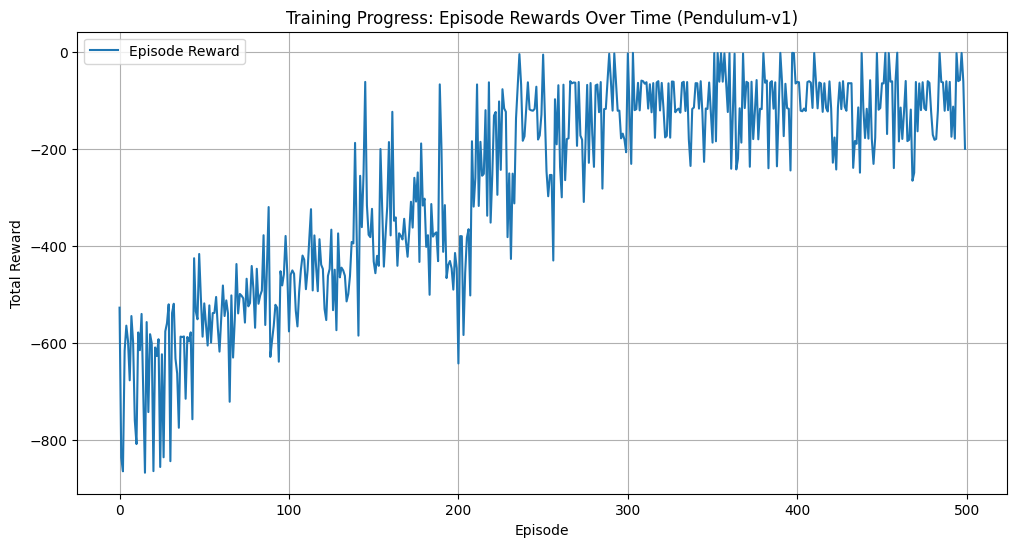

In [ ]:
episode_rewards_flat = []
for episode_reward in episode_rewards:
  if isinstance(episode_reward, float):
    episode_rewards_flat.append(episode_reward)
  else:
    episode_rewards_flat.append(episode_reward[0])

# Plot the episode rewards
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards_flat, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Episode Rewards Over Time (Pendulum-v1)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
np.save(f"learning_episode_rewards_50_500.npy", episode_rewards_flat)

In [ ]:
def evaluate_pendulum_dqn(agent, env, num_episodes=100):
    total_rewards = []
    old_epsilon = agent.epsilon

    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action_idx = agent.get_discrete_action(obs)
            action_value = agent.action_bins[action_idx].item()

            next_obs, reward, terminated, truncated, info = env.step([action_value])
            total_reward += reward
            done = terminated or truncated
            obs = next_obs

        total_rewards.append(total_reward)
    return np.mean(total_rewards)

average_reward_eval = evaluate_pendulum_dqn(agent, env, num_episodes=1000)
print(f"Average reward over 1000 evaluation episodes: {average_reward_eval}")


Average reward over 1000 evaluation episodes: -171.6453994530858


## Acrobot

In [ ]:
class DeepQAgentAcrobot:
    def __init__(
        self,
        env,
        learning_rate,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        discount_factor,
        replay_buffer_size,
        batch_size,
        target_update_interval,
    ):
        self.env = env
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.gamma = discount_factor
        self.batch_size = batch_size
        self.target_update_interval = target_update_interval

        # Acrobot: state_dim=6, action_dim=3
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.policy_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.steps_done = 0

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # Explore
            return self.env.action_space.sample()
        else:
            # Exploit
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)  # shape: [1, action_dim]
            action = torch.argmax(q_values, dim=1).item()
            return action

    def train(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return  # Not enough samples yet
        # Sample from buffer and update network based on sample
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]

        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


  0%|          | 1/5000 [00:01<1:26:25,  1.04s/it]

Episode 0: Total Reward = -500.0


  0%|          | 2/5000 [00:02<1:24:39,  1.02s/it]

Episode 1: Total Reward = -500.0


  0%|          | 3/5000 [00:03<1:36:41,  1.16s/it]

Episode 2: Total Reward = -500.0


  0%|          | 4/5000 [00:04<1:45:14,  1.26s/it]

Episode 3: Total Reward = -500.0


  0%|          | 5/5000 [00:05<1:38:54,  1.19s/it]

Episode 4: Total Reward = -500.0


  0%|          | 6/5000 [00:06<1:33:37,  1.12s/it]

Episode 5: Total Reward = -500.0


  0%|          | 7/5000 [00:07<1:30:14,  1.08s/it]

Episode 6: Total Reward = -500.0


  0%|          | 8/5000 [00:08<1:28:20,  1.06s/it]

Episode 7: Total Reward = -500.0


  0%|          | 9/5000 [00:09<1:26:46,  1.04s/it]

Episode 8: Total Reward = -500.0


  0%|          | 10/5000 [00:10<1:25:53,  1.03s/it]

Episode 9: Total Reward = -500.0


  0%|          | 11/5000 [00:11<1:25:40,  1.03s/it]

Episode 10: Total Reward = -500.0


  0%|          | 12/5000 [00:12<1:25:28,  1.03s/it]

Episode 11: Total Reward = -500.0


  0%|          | 13/5000 [00:13<1:24:54,  1.02s/it]

Episode 12: Total Reward = -500.0


  0%|          | 14/5000 [00:14<1:24:30,  1.02s/it]

Episode 13: Total Reward = -500.0


  0%|          | 15/5000 [00:16<1:33:24,  1.12s/it]

Episode 14: Total Reward = -500.0


  0%|          | 16/5000 [00:17<1:39:23,  1.20s/it]

Episode 15: Total Reward = -500.0


  0%|          | 17/5000 [00:18<1:34:39,  1.14s/it]

Episode 16: Total Reward = -500.0


  0%|          | 18/5000 [00:19<1:31:17,  1.10s/it]

Episode 17: Total Reward = -500.0


  0%|          | 19/5000 [00:20<1:28:47,  1.07s/it]

Episode 18: Total Reward = -500.0


  0%|          | 20/5000 [00:21<1:26:54,  1.05s/it]

Episode 19: Total Reward = -500.0


  0%|          | 21/5000 [00:22<1:25:44,  1.03s/it]

Episode 20: Total Reward = -500.0


  0%|          | 22/5000 [00:23<1:25:07,  1.03s/it]

Episode 21: Total Reward = -500.0


  0%|          | 23/5000 [00:24<1:24:49,  1.02s/it]

Episode 22: Total Reward = -500.0


  0%|          | 24/5000 [00:25<1:24:34,  1.02s/it]

Episode 23: Total Reward = -500.0


  0%|          | 25/5000 [00:26<1:24:21,  1.02s/it]

Episode 24: Total Reward = -500.0


  1%|          | 26/5000 [00:27<1:27:37,  1.06s/it]

Episode 25: Total Reward = -500.0


  1%|          | 27/5000 [00:29<1:36:47,  1.17s/it]

Episode 26: Total Reward = -500.0


  1%|          | 28/5000 [00:30<1:37:53,  1.18s/it]

Episode 27: Total Reward = -500.0


  1%|          | 29/5000 [00:31<1:33:43,  1.13s/it]

Episode 28: Total Reward = -500.0


  1%|          | 30/5000 [00:32<1:30:26,  1.09s/it]

Episode 29: Total Reward = -500.0


  1%|          | 31/5000 [00:33<1:28:22,  1.07s/it]

Episode 30: Total Reward = -500.0


  1%|          | 32/5000 [00:34<1:27:13,  1.05s/it]

Episode 31: Total Reward = -500.0


  1%|          | 33/5000 [00:35<1:25:59,  1.04s/it]

Episode 32: Total Reward = -500.0


  1%|          | 34/5000 [00:36<1:25:17,  1.03s/it]

Episode 33: Total Reward = -500.0


  1%|          | 35/5000 [00:37<1:25:11,  1.03s/it]

Episode 34: Total Reward = -500.0


  1%|          | 36/5000 [00:38<1:24:22,  1.02s/it]

Episode 35: Total Reward = -500.0


  1%|          | 37/5000 [00:39<1:24:35,  1.02s/it]

Episode 36: Total Reward = -500.0


  1%|          | 38/5000 [00:40<1:31:36,  1.11s/it]

Episode 37: Total Reward = -500.0


  1%|          | 39/5000 [00:42<1:39:42,  1.21s/it]

Episode 38: Total Reward = -500.0


  1%|          | 40/5000 [00:43<1:34:50,  1.15s/it]

Episode 39: Total Reward = -500.0


  1%|          | 41/5000 [00:44<1:31:21,  1.11s/it]

Episode 40: Total Reward = -500.0


  1%|          | 42/5000 [00:45<1:28:54,  1.08s/it]

Episode 41: Total Reward = -500.0


  1%|          | 43/5000 [00:46<1:27:43,  1.06s/it]

Episode 42: Total Reward = -500.0


  1%|          | 44/5000 [00:47<1:26:32,  1.05s/it]

Episode 43: Total Reward = -500.0


  1%|          | 45/5000 [00:48<1:25:42,  1.04s/it]

Episode 44: Total Reward = -500.0


  1%|          | 46/5000 [00:49<1:25:34,  1.04s/it]

Episode 45: Total Reward = -500.0


  1%|          | 47/5000 [00:50<1:24:51,  1.03s/it]

Episode 46: Total Reward = -500.0


  1%|          | 48/5000 [00:51<1:24:26,  1.02s/it]

Episode 47: Total Reward = -500.0


  1%|          | 49/5000 [00:52<1:26:37,  1.05s/it]

Episode 48: Total Reward = -500.0


  1%|          | 50/5000 [00:54<1:35:43,  1.16s/it]

Episode 49: Total Reward = -500.0


  1%|          | 51/5000 [00:55<1:38:50,  1.20s/it]

Episode 50: Total Reward = -500.0


  1%|          | 52/5000 [00:56<1:34:03,  1.14s/it]

Episode 51: Total Reward = -500.0


  1%|          | 53/5000 [00:57<1:31:01,  1.10s/it]

Episode 52: Total Reward = -500.0


  1%|          | 54/5000 [00:58<1:29:00,  1.08s/it]

Episode 53: Total Reward = -500.0


  1%|          | 55/5000 [00:59<1:28:00,  1.07s/it]

Episode 54: Total Reward = -500.0


  1%|          | 56/5000 [01:00<1:27:01,  1.06s/it]

Episode 55: Total Reward = -500.0


  1%|          | 57/5000 [01:01<1:26:45,  1.05s/it]

Episode 56: Total Reward = -500.0


  1%|          | 58/5000 [01:02<1:25:29,  1.04s/it]

Episode 57: Total Reward = -500.0


  1%|          | 59/5000 [01:03<1:31:31,  1.11s/it]

Episode 58: Total Reward = -500.0


  1%|          | 60/5000 [01:05<1:45:53,  1.29s/it]

Episode 59: Total Reward = -500.0


  1%|          | 61/5000 [01:06<1:48:38,  1.32s/it]

Episode 60: Total Reward = -500.0


  1%|          | 62/5000 [01:08<1:45:23,  1.28s/it]

Episode 61: Total Reward = -500.0


  1%|▏         | 63/5000 [01:09<1:38:46,  1.20s/it]

Episode 62: Total Reward = -500.0


  1%|▏         | 64/5000 [01:10<1:34:28,  1.15s/it]

Episode 63: Total Reward = -500.0


  1%|▏         | 65/5000 [01:11<1:30:59,  1.11s/it]

Episode 64: Total Reward = -500.0


  1%|▏         | 66/5000 [01:12<1:28:52,  1.08s/it]

Episode 65: Total Reward = -500.0


  1%|▏         | 67/5000 [01:13<1:27:11,  1.06s/it]

Episode 66: Total Reward = -500.0


  1%|▏         | 68/5000 [01:14<1:26:00,  1.05s/it]

Episode 67: Total Reward = -500.0


  1%|▏         | 69/5000 [01:15<1:25:25,  1.04s/it]

Episode 68: Total Reward = -500.0


  1%|▏         | 70/5000 [01:16<1:25:19,  1.04s/it]

Episode 69: Total Reward = -500.0


  1%|▏         | 71/5000 [01:17<1:24:36,  1.03s/it]

Episode 70: Total Reward = -500.0


  1%|▏         | 72/5000 [01:18<1:27:07,  1.06s/it]

Episode 71: Total Reward = -422.0


  1%|▏         | 73/5000 [01:19<1:37:21,  1.19s/it]

Episode 72: Total Reward = -500.0


  1%|▏         | 74/5000 [01:20<1:34:27,  1.15s/it]

Episode 73: Total Reward = -500.0


  2%|▏         | 75/5000 [01:21<1:30:53,  1.11s/it]

Episode 74: Total Reward = -500.0


  2%|▏         | 76/5000 [01:22<1:27:54,  1.07s/it]

Episode 75: Total Reward = -500.0


  2%|▏         | 77/5000 [01:23<1:26:55,  1.06s/it]

Episode 76: Total Reward = -500.0


  2%|▏         | 78/5000 [01:24<1:26:09,  1.05s/it]

Episode 77: Total Reward = -500.0


  2%|▏         | 79/5000 [01:25<1:25:29,  1.04s/it]

Episode 78: Total Reward = -500.0


  2%|▏         | 80/5000 [01:26<1:24:20,  1.03s/it]

Episode 79: Total Reward = -500.0


  2%|▏         | 81/5000 [01:27<1:23:56,  1.02s/it]

Episode 80: Total Reward = -500.0


  2%|▏         | 82/5000 [01:29<1:23:50,  1.02s/it]

Episode 81: Total Reward = -500.0


  2%|▏         | 83/5000 [01:30<1:24:33,  1.03s/it]

Episode 82: Total Reward = -500.0


  2%|▏         | 84/5000 [01:31<1:33:34,  1.14s/it]

Episode 83: Total Reward = -500.0


  2%|▏         | 85/5000 [01:32<1:38:04,  1.20s/it]

Episode 84: Total Reward = -500.0


  2%|▏         | 86/5000 [01:33<1:33:39,  1.14s/it]

Episode 85: Total Reward = -500.0


  2%|▏         | 87/5000 [01:34<1:30:55,  1.11s/it]

Episode 86: Total Reward = -500.0


  2%|▏         | 88/5000 [01:35<1:29:23,  1.09s/it]

Episode 87: Total Reward = -500.0


  2%|▏         | 89/5000 [01:36<1:27:30,  1.07s/it]

Episode 88: Total Reward = -500.0


  2%|▏         | 90/5000 [01:37<1:24:00,  1.03s/it]

Episode 89: Total Reward = -452.0


  2%|▏         | 91/5000 [01:38<1:23:16,  1.02s/it]

Episode 90: Total Reward = -500.0


  2%|▏         | 92/5000 [01:39<1:23:01,  1.01s/it]

Episode 91: Total Reward = -500.0


  2%|▏         | 93/5000 [01:40<1:23:16,  1.02s/it]

Episode 92: Total Reward = -500.0


  2%|▏         | 94/5000 [01:41<1:23:08,  1.02s/it]

Episode 93: Total Reward = -500.0


  2%|▏         | 95/5000 [01:43<1:26:49,  1.06s/it]

Episode 94: Total Reward = -500.0


  2%|▏         | 96/5000 [01:44<1:35:15,  1.17s/it]

Episode 95: Total Reward = -500.0


  2%|▏         | 97/5000 [01:45<1:34:39,  1.16s/it]

Episode 96: Total Reward = -500.0


  2%|▏         | 98/5000 [01:46<1:31:34,  1.12s/it]

Episode 97: Total Reward = -500.0


  2%|▏         | 99/5000 [01:47<1:29:32,  1.10s/it]

Episode 98: Total Reward = -500.0


  2%|▏         | 100/5000 [01:48<1:27:22,  1.07s/it]

Episode 99: Total Reward = -500.0


  2%|▏         | 101/5000 [01:49<1:26:35,  1.06s/it]

Episode 100: Total Reward = -500.0


  2%|▏         | 102/5000 [01:50<1:26:08,  1.06s/it]

Episode 101: Total Reward = -500.0


  2%|▏         | 103/5000 [01:51<1:25:27,  1.05s/it]

Episode 102: Total Reward = -500.0


  2%|▏         | 104/5000 [01:52<1:24:18,  1.03s/it]

Episode 103: Total Reward = -500.0


  2%|▏         | 105/5000 [01:53<1:23:18,  1.02s/it]

Episode 104: Total Reward = -500.0


  2%|▏         | 106/5000 [01:54<1:22:46,  1.01s/it]

Episode 105: Total Reward = -500.0


  2%|▏         | 107/5000 [01:56<1:31:03,  1.12s/it]

Episode 106: Total Reward = -500.0


  2%|▏         | 108/5000 [01:57<1:37:06,  1.19s/it]

Episode 107: Total Reward = -500.0


  2%|▏         | 109/5000 [01:58<1:33:15,  1.14s/it]

Episode 108: Total Reward = -500.0


  2%|▏         | 110/5000 [01:59<1:30:37,  1.11s/it]

Episode 109: Total Reward = -500.0


  2%|▏         | 111/5000 [02:00<1:28:32,  1.09s/it]

Episode 110: Total Reward = -500.0


  2%|▏         | 112/5000 [02:01<1:27:38,  1.08s/it]

Episode 111: Total Reward = -500.0


  2%|▏         | 113/5000 [02:02<1:26:07,  1.06s/it]

Episode 112: Total Reward = -500.0


  2%|▏         | 114/5000 [02:03<1:25:04,  1.04s/it]

Episode 113: Total Reward = -500.0


  2%|▏         | 115/5000 [02:04<1:24:21,  1.04s/it]

Episode 114: Total Reward = -500.0


  2%|▏         | 116/5000 [02:05<1:23:41,  1.03s/it]

Episode 115: Total Reward = -500.0


  2%|▏         | 117/5000 [02:06<1:23:08,  1.02s/it]

Episode 116: Total Reward = -500.0


  2%|▏         | 118/5000 [02:07<1:26:46,  1.07s/it]

Episode 117: Total Reward = -500.0


  2%|▏         | 119/5000 [02:09<1:34:32,  1.16s/it]

Episode 118: Total Reward = -500.0


  2%|▏         | 120/5000 [02:10<1:35:14,  1.17s/it]

Episode 119: Total Reward = -500.0


  2%|▏         | 121/5000 [02:11<1:31:44,  1.13s/it]

Episode 120: Total Reward = -500.0


  2%|▏         | 122/5000 [02:12<1:28:43,  1.09s/it]

Episode 121: Total Reward = -500.0


  2%|▏         | 123/5000 [02:13<1:26:54,  1.07s/it]

Episode 122: Total Reward = -500.0


  2%|▏         | 124/5000 [02:14<1:25:49,  1.06s/it]

Episode 123: Total Reward = -500.0


  2%|▎         | 125/5000 [02:15<1:25:21,  1.05s/it]

Episode 124: Total Reward = -500.0


  3%|▎         | 126/5000 [02:16<1:24:43,  1.04s/it]

Episode 125: Total Reward = -500.0


  3%|▎         | 127/5000 [02:17<1:24:12,  1.04s/it]

Episode 126: Total Reward = -500.0


  3%|▎         | 128/5000 [02:18<1:23:55,  1.03s/it]

Episode 127: Total Reward = -500.0


  3%|▎         | 129/5000 [02:19<1:24:09,  1.04s/it]

Episode 128: Total Reward = -500.0


  3%|▎         | 130/5000 [02:21<1:34:54,  1.17s/it]

Episode 129: Total Reward = -500.0


  3%|▎         | 131/5000 [02:22<1:42:10,  1.26s/it]

Episode 130: Total Reward = -500.0


  3%|▎         | 132/5000 [02:23<1:36:40,  1.19s/it]

Episode 131: Total Reward = -500.0


  3%|▎         | 133/5000 [02:24<1:33:12,  1.15s/it]

Episode 132: Total Reward = -500.0


  3%|▎         | 134/5000 [02:26<1:43:26,  1.28s/it]

Episode 133: Total Reward = -500.0


  3%|▎         | 135/5000 [02:27<1:45:35,  1.30s/it]

Episode 134: Total Reward = -500.0


  3%|▎         | 136/5000 [02:28<1:38:54,  1.22s/it]

Episode 135: Total Reward = -500.0


  3%|▎         | 137/5000 [02:29<1:34:22,  1.16s/it]

Episode 136: Total Reward = -500.0


  3%|▎         | 138/5000 [02:30<1:31:55,  1.13s/it]

Episode 137: Total Reward = -500.0


  3%|▎         | 139/5000 [02:31<1:30:46,  1.12s/it]

Episode 138: Total Reward = -500.0


  3%|▎         | 140/5000 [02:33<1:33:51,  1.16s/it]

Episode 139: Total Reward = -500.0


  3%|▎         | 141/5000 [02:34<1:40:55,  1.25s/it]

Episode 140: Total Reward = -500.0


  3%|▎         | 142/5000 [02:35<1:40:49,  1.25s/it]

Episode 141: Total Reward = -500.0


  3%|▎         | 143/5000 [02:36<1:36:18,  1.19s/it]

Episode 142: Total Reward = -500.0


  3%|▎         | 144/5000 [02:37<1:32:35,  1.14s/it]

Episode 143: Total Reward = -500.0


  3%|▎         | 145/5000 [02:38<1:29:43,  1.11s/it]

Episode 144: Total Reward = -500.0


  3%|▎         | 146/5000 [02:39<1:28:08,  1.09s/it]

Episode 145: Total Reward = -500.0


  3%|▎         | 147/5000 [02:41<1:27:12,  1.08s/it]

Episode 146: Total Reward = -500.0


  3%|▎         | 148/5000 [02:42<1:26:59,  1.08s/it]

Episode 147: Total Reward = -500.0


  3%|▎         | 149/5000 [02:43<1:26:22,  1.07s/it]

Episode 148: Total Reward = -500.0


  3%|▎         | 150/5000 [02:44<1:26:14,  1.07s/it]

Episode 149: Total Reward = -500.0


  3%|▎         | 151/5000 [02:45<1:30:01,  1.11s/it]

Episode 150: Total Reward = -500.0


  3%|▎         | 152/5000 [02:46<1:39:46,  1.23s/it]

Episode 151: Total Reward = -500.0


  3%|▎         | 153/5000 [02:48<1:41:00,  1.25s/it]

Episode 152: Total Reward = -500.0


  3%|▎         | 154/5000 [02:49<1:36:20,  1.19s/it]

Episode 153: Total Reward = -500.0


  3%|▎         | 155/5000 [02:50<1:34:12,  1.17s/it]

Episode 154: Total Reward = -500.0


  3%|▎         | 156/5000 [02:51<1:31:20,  1.13s/it]

Episode 155: Total Reward = -500.0


  3%|▎         | 157/5000 [02:52<1:29:32,  1.11s/it]

Episode 156: Total Reward = -500.0


  3%|▎         | 158/5000 [02:53<1:28:18,  1.09s/it]

Episode 157: Total Reward = -500.0


  3%|▎         | 159/5000 [02:54<1:27:14,  1.08s/it]

Episode 158: Total Reward = -500.0


  3%|▎         | 160/5000 [02:55<1:27:51,  1.09s/it]

Episode 159: Total Reward = -500.0


  3%|▎         | 161/5000 [02:56<1:27:20,  1.08s/it]

Episode 160: Total Reward = -500.0


  3%|▎         | 162/5000 [02:57<1:29:17,  1.11s/it]

Episode 161: Total Reward = -500.0


  3%|▎         | 163/5000 [02:59<1:37:30,  1.21s/it]

Episode 162: Total Reward = -500.0


  3%|▎         | 164/5000 [03:00<1:39:01,  1.23s/it]

Episode 163: Total Reward = -500.0


  3%|▎         | 165/5000 [03:01<1:34:53,  1.18s/it]

Episode 164: Total Reward = -500.0


  3%|▎         | 166/5000 [03:02<1:31:29,  1.14s/it]

Episode 165: Total Reward = -500.0


  3%|▎         | 167/5000 [03:03<1:28:51,  1.10s/it]

Episode 166: Total Reward = -500.0


  3%|▎         | 168/5000 [03:04<1:27:12,  1.08s/it]

Episode 167: Total Reward = -500.0


  3%|▎         | 169/5000 [03:05<1:26:15,  1.07s/it]

Episode 168: Total Reward = -500.0


  3%|▎         | 170/5000 [03:06<1:25:32,  1.06s/it]

Episode 169: Total Reward = -500.0


  3%|▎         | 171/5000 [03:08<1:25:42,  1.06s/it]

Episode 170: Total Reward = -500.0


  3%|▎         | 172/5000 [03:09<1:25:12,  1.06s/it]

Episode 171: Total Reward = -500.0


  3%|▎         | 173/5000 [03:10<1:24:28,  1.05s/it]

Episode 172: Total Reward = -500.0


  3%|▎         | 174/5000 [03:11<1:33:07,  1.16s/it]

Episode 173: Total Reward = -500.0


  4%|▎         | 175/5000 [03:12<1:38:19,  1.22s/it]

Episode 174: Total Reward = -500.0


  4%|▎         | 176/5000 [03:13<1:34:00,  1.17s/it]

Episode 175: Total Reward = -500.0


  4%|▎         | 177/5000 [03:14<1:30:30,  1.13s/it]

Episode 176: Total Reward = -500.0


  4%|▎         | 178/5000 [03:15<1:28:04,  1.10s/it]

Episode 177: Total Reward = -500.0


  4%|▎         | 179/5000 [03:16<1:26:33,  1.08s/it]

Episode 178: Total Reward = -500.0


  4%|▎         | 180/5000 [03:18<1:25:30,  1.06s/it]

Episode 179: Total Reward = -500.0


  4%|▎         | 181/5000 [03:19<1:25:04,  1.06s/it]

Episode 180: Total Reward = -500.0


  4%|▎         | 182/5000 [03:20<1:25:02,  1.06s/it]

Episode 181: Total Reward = -500.0


  4%|▎         | 183/5000 [03:21<1:24:59,  1.06s/it]

Episode 182: Total Reward = -500.0


  4%|▎         | 184/5000 [03:22<1:24:30,  1.05s/it]

Episode 183: Total Reward = -500.0


  4%|▎         | 185/5000 [03:23<1:31:18,  1.14s/it]

Episode 184: Total Reward = -500.0


  4%|▎         | 186/5000 [03:25<1:40:10,  1.25s/it]

Episode 185: Total Reward = -500.0


  4%|▎         | 187/5000 [03:26<1:35:35,  1.19s/it]

Episode 186: Total Reward = -500.0


  4%|▍         | 188/5000 [03:27<1:31:58,  1.15s/it]

Episode 187: Total Reward = -500.0


  4%|▍         | 189/5000 [03:28<1:29:36,  1.12s/it]

Episode 188: Total Reward = -500.0


  4%|▍         | 190/5000 [03:29<1:28:44,  1.11s/it]

Episode 189: Total Reward = -500.0


  4%|▍         | 191/5000 [03:30<1:27:44,  1.09s/it]

Episode 190: Total Reward = -500.0


  4%|▍         | 192/5000 [03:31<1:27:10,  1.09s/it]

Episode 191: Total Reward = -500.0


  4%|▍         | 193/5000 [03:32<1:26:50,  1.08s/it]

Episode 192: Total Reward = -500.0


  4%|▍         | 194/5000 [03:33<1:26:05,  1.07s/it]

Episode 193: Total Reward = -500.0


  4%|▍         | 195/5000 [03:34<1:26:04,  1.07s/it]

Episode 194: Total Reward = -500.0


  4%|▍         | 196/5000 [03:35<1:30:44,  1.13s/it]

Episode 195: Total Reward = -471.0


  4%|▍         | 197/5000 [03:37<1:39:29,  1.24s/it]

Episode 196: Total Reward = -500.0


  4%|▍         | 198/5000 [03:38<1:36:31,  1.21s/it]

Episode 197: Total Reward = -500.0


  4%|▍         | 199/5000 [03:39<1:33:07,  1.16s/it]

Episode 198: Total Reward = -500.0


  4%|▍         | 200/5000 [03:40<1:30:54,  1.14s/it]

Episode 199: Total Reward = -500.0


  4%|▍         | 201/5000 [03:41<1:29:23,  1.12s/it]

Episode 200: Total Reward = -500.0


  4%|▍         | 202/5000 [03:42<1:28:42,  1.11s/it]

Episode 201: Total Reward = -500.0


  4%|▍         | 203/5000 [03:43<1:28:13,  1.10s/it]

Episode 202: Total Reward = -500.0


  4%|▍         | 204/5000 [03:45<1:27:51,  1.10s/it]

Episode 203: Total Reward = -500.0


  4%|▍         | 205/5000 [03:46<1:27:15,  1.09s/it]

Episode 204: Total Reward = -500.0


  4%|▍         | 206/5000 [03:47<1:26:38,  1.08s/it]

Episode 205: Total Reward = -500.0


  4%|▍         | 207/5000 [03:48<1:32:45,  1.16s/it]

Episode 206: Total Reward = -500.0


  4%|▍         | 208/5000 [03:50<1:41:13,  1.27s/it]

Episode 207: Total Reward = -500.0


  4%|▍         | 209/5000 [03:51<1:36:52,  1.21s/it]

Episode 208: Total Reward = -500.0


  4%|▍         | 210/5000 [03:52<1:33:21,  1.17s/it]

Episode 209: Total Reward = -500.0


  4%|▍         | 211/5000 [03:53<1:31:02,  1.14s/it]

Episode 210: Total Reward = -500.0


  4%|▍         | 212/5000 [03:54<1:29:16,  1.12s/it]

Episode 211: Total Reward = -500.0


  4%|▍         | 213/5000 [03:55<1:28:51,  1.11s/it]

Episode 212: Total Reward = -500.0


  4%|▍         | 214/5000 [03:56<1:28:05,  1.10s/it]

Episode 213: Total Reward = -500.0


  4%|▍         | 215/5000 [03:57<1:27:06,  1.09s/it]

Episode 214: Total Reward = -500.0


  4%|▍         | 216/5000 [03:58<1:27:05,  1.09s/it]

Episode 215: Total Reward = -500.0


  4%|▍         | 217/5000 [03:59<1:25:54,  1.08s/it]

Episode 216: Total Reward = -478.0


  4%|▍         | 218/5000 [04:01<1:32:42,  1.16s/it]

Episode 217: Total Reward = -500.0


  4%|▍         | 219/5000 [04:02<1:42:21,  1.28s/it]

Episode 218: Total Reward = -500.0


  4%|▍         | 220/5000 [04:03<1:37:57,  1.23s/it]

Episode 219: Total Reward = -500.0


  4%|▍         | 221/5000 [04:04<1:34:34,  1.19s/it]

Episode 220: Total Reward = -500.0


  4%|▍         | 222/5000 [04:05<1:32:43,  1.16s/it]

Episode 221: Total Reward = -500.0


  4%|▍         | 223/5000 [04:07<1:31:14,  1.15s/it]

Episode 222: Total Reward = -500.0


  4%|▍         | 224/5000 [04:08<1:29:31,  1.12s/it]

Episode 223: Total Reward = -500.0


  4%|▍         | 225/5000 [04:09<1:28:45,  1.12s/it]

Episode 224: Total Reward = -500.0


  5%|▍         | 226/5000 [04:10<1:27:39,  1.10s/it]

Episode 225: Total Reward = -500.0


  5%|▍         | 227/5000 [04:11<1:27:18,  1.10s/it]

Episode 226: Total Reward = -500.0


  5%|▍         | 228/5000 [04:12<1:26:49,  1.09s/it]

Episode 227: Total Reward = -500.0


  5%|▍         | 229/5000 [04:13<1:34:33,  1.19s/it]

Episode 228: Total Reward = -500.0


  5%|▍         | 230/5000 [04:15<1:43:17,  1.30s/it]

Episode 229: Total Reward = -500.0


  5%|▍         | 231/5000 [04:16<1:37:32,  1.23s/it]

Episode 230: Total Reward = -500.0


  5%|▍         | 232/5000 [04:17<1:33:44,  1.18s/it]

Episode 231: Total Reward = -500.0


  5%|▍         | 233/5000 [04:18<1:31:03,  1.15s/it]

Episode 232: Total Reward = -500.0


  5%|▍         | 234/5000 [04:19<1:29:03,  1.12s/it]

Episode 233: Total Reward = -500.0


  5%|▍         | 235/5000 [04:20<1:27:56,  1.11s/it]

Episode 234: Total Reward = -500.0


  5%|▍         | 236/5000 [04:21<1:27:07,  1.10s/it]

Episode 235: Total Reward = -500.0


  5%|▍         | 237/5000 [04:22<1:26:07,  1.08s/it]

Episode 236: Total Reward = -500.0


  5%|▍         | 238/5000 [04:23<1:25:54,  1.08s/it]

Episode 237: Total Reward = -500.0


  5%|▍         | 239/5000 [04:25<1:25:30,  1.08s/it]

Episode 238: Total Reward = -500.0


  5%|▍         | 240/5000 [04:26<1:33:25,  1.18s/it]

Episode 239: Total Reward = -500.0


  5%|▍         | 241/5000 [04:27<1:41:18,  1.28s/it]

Episode 240: Total Reward = -500.0


  5%|▍         | 242/5000 [04:29<1:36:31,  1.22s/it]

Episode 241: Total Reward = -500.0


  5%|▍         | 243/5000 [04:30<1:33:29,  1.18s/it]

Episode 242: Total Reward = -500.0


  5%|▍         | 244/5000 [04:31<1:30:59,  1.15s/it]

Episode 243: Total Reward = -500.0


  5%|▍         | 245/5000 [04:32<1:30:28,  1.14s/it]

Episode 244: Total Reward = -500.0


  5%|▍         | 246/5000 [04:33<1:28:44,  1.12s/it]

Episode 245: Total Reward = -500.0


  5%|▍         | 247/5000 [04:34<1:27:51,  1.11s/it]

Episode 246: Total Reward = -500.0


  5%|▍         | 248/5000 [04:35<1:28:47,  1.12s/it]

Episode 247: Total Reward = -500.0


  5%|▍         | 249/5000 [04:36<1:27:49,  1.11s/it]

Episode 248: Total Reward = -500.0


  5%|▌         | 250/5000 [04:37<1:26:40,  1.09s/it]

Episode 249: Total Reward = -500.0


  5%|▌         | 251/5000 [04:39<1:34:51,  1.20s/it]

Episode 250: Total Reward = -500.0


  5%|▌         | 252/5000 [04:40<1:41:40,  1.28s/it]

Episode 251: Total Reward = -500.0


  5%|▌         | 253/5000 [04:41<1:36:46,  1.22s/it]

Episode 252: Total Reward = -500.0


  5%|▌         | 254/5000 [04:42<1:33:22,  1.18s/it]

Episode 253: Total Reward = -500.0


  5%|▌         | 255/5000 [04:43<1:30:31,  1.14s/it]

Episode 254: Total Reward = -500.0


  5%|▌         | 256/5000 [04:44<1:28:23,  1.12s/it]

Episode 255: Total Reward = -500.0


  5%|▌         | 257/5000 [04:46<1:27:43,  1.11s/it]

Episode 256: Total Reward = -500.0


  5%|▌         | 258/5000 [04:47<1:26:28,  1.09s/it]

Episode 257: Total Reward = -500.0


  5%|▌         | 259/5000 [04:48<1:26:01,  1.09s/it]

Episode 258: Total Reward = -500.0


  5%|▌         | 260/5000 [04:49<1:25:38,  1.08s/it]

Episode 259: Total Reward = -500.0


  5%|▌         | 261/5000 [04:50<1:25:02,  1.08s/it]

Episode 260: Total Reward = -500.0


  5%|▌         | 262/5000 [04:51<1:33:32,  1.18s/it]

Episode 261: Total Reward = -500.0


  5%|▌         | 263/5000 [04:53<1:41:09,  1.28s/it]

Episode 262: Total Reward = -500.0


  5%|▌         | 264/5000 [04:54<1:36:32,  1.22s/it]

Episode 263: Total Reward = -500.0


  5%|▌         | 265/5000 [04:55<1:33:35,  1.19s/it]

Episode 264: Total Reward = -500.0


  5%|▌         | 266/5000 [04:56<1:24:43,  1.07s/it]

Episode 265: Total Reward = -358.0


  5%|▌         | 267/5000 [04:57<1:25:07,  1.08s/it]

Episode 266: Total Reward = -500.0


  5%|▌         | 268/5000 [04:58<1:25:31,  1.08s/it]

Episode 267: Total Reward = -500.0


  5%|▌         | 269/5000 [04:59<1:25:51,  1.09s/it]

Episode 268: Total Reward = -500.0


  5%|▌         | 270/5000 [05:00<1:25:51,  1.09s/it]

Episode 269: Total Reward = -500.0


  5%|▌         | 271/5000 [05:01<1:25:51,  1.09s/it]

Episode 270: Total Reward = -500.0


  5%|▌         | 272/5000 [05:02<1:26:25,  1.10s/it]

Episode 271: Total Reward = -500.0


  5%|▌         | 273/5000 [05:04<1:33:53,  1.19s/it]

Episode 272: Total Reward = -500.0


  5%|▌         | 274/5000 [05:05<1:41:50,  1.29s/it]

Episode 273: Total Reward = -500.0


  6%|▌         | 275/5000 [05:06<1:37:31,  1.24s/it]

Episode 274: Total Reward = -500.0


  6%|▌         | 276/5000 [05:07<1:34:08,  1.20s/it]

Episode 275: Total Reward = -500.0


  6%|▌         | 277/5000 [05:09<1:30:51,  1.15s/it]

Episode 276: Total Reward = -500.0


  6%|▌         | 278/5000 [05:10<1:28:38,  1.13s/it]

Episode 277: Total Reward = -500.0


  6%|▌         | 279/5000 [05:11<1:27:48,  1.12s/it]

Episode 278: Total Reward = -500.0


  6%|▌         | 280/5000 [05:12<1:28:17,  1.12s/it]

Episode 279: Total Reward = -500.0


  6%|▌         | 281/5000 [05:13<1:26:54,  1.10s/it]

Episode 280: Total Reward = -500.0


  6%|▌         | 282/5000 [05:14<1:25:48,  1.09s/it]

Episode 281: Total Reward = -500.0


  6%|▌         | 283/5000 [05:15<1:25:13,  1.08s/it]

Episode 282: Total Reward = -500.0


  6%|▌         | 284/5000 [05:16<1:34:12,  1.20s/it]

Episode 283: Total Reward = -500.0


  6%|▌         | 285/5000 [05:18<1:39:44,  1.27s/it]

Episode 284: Total Reward = -500.0


  6%|▌         | 286/5000 [05:19<1:34:40,  1.21s/it]

Episode 285: Total Reward = -500.0


  6%|▌         | 287/5000 [05:20<1:31:02,  1.16s/it]

Episode 286: Total Reward = -500.0


  6%|▌         | 288/5000 [05:21<1:28:31,  1.13s/it]

Episode 287: Total Reward = -500.0


  6%|▌         | 289/5000 [05:22<1:26:47,  1.11s/it]

Episode 288: Total Reward = -500.0


  6%|▌         | 290/5000 [05:23<1:25:39,  1.09s/it]

Episode 289: Total Reward = -500.0


  6%|▌         | 291/5000 [05:24<1:24:47,  1.08s/it]

Episode 290: Total Reward = -500.0


  6%|▌         | 292/5000 [05:25<1:24:49,  1.08s/it]

Episode 291: Total Reward = -500.0


  6%|▌         | 293/5000 [05:26<1:25:21,  1.09s/it]

Episode 292: Total Reward = -500.0


  6%|▌         | 294/5000 [05:28<1:25:53,  1.10s/it]

Episode 293: Total Reward = -500.0


  6%|▌         | 295/5000 [05:29<1:33:27,  1.19s/it]

Episode 294: Total Reward = -500.0


  6%|▌         | 296/5000 [05:30<1:39:55,  1.27s/it]

Episode 295: Total Reward = -500.0


  6%|▌         | 297/5000 [05:31<1:34:54,  1.21s/it]

Episode 296: Total Reward = -500.0


  6%|▌         | 298/5000 [05:33<1:31:26,  1.17s/it]

Episode 297: Total Reward = -500.0


  6%|▌         | 299/5000 [05:34<1:29:43,  1.15s/it]

Episode 298: Total Reward = -500.0


  6%|▌         | 300/5000 [05:35<1:28:41,  1.13s/it]

Episode 299: Total Reward = -500.0


  6%|▌         | 301/5000 [05:36<1:27:26,  1.12s/it]

Episode 300: Total Reward = -500.0


  6%|▌         | 302/5000 [05:37<1:27:08,  1.11s/it]

Episode 301: Total Reward = -500.0


  6%|▌         | 303/5000 [05:38<1:26:12,  1.10s/it]

Episode 302: Total Reward = -500.0


  6%|▌         | 304/5000 [05:39<1:25:19,  1.09s/it]

Episode 303: Total Reward = -500.0


  6%|▌         | 305/5000 [05:40<1:25:21,  1.09s/it]

Episode 304: Total Reward = -500.0


  6%|▌         | 306/5000 [05:42<1:34:37,  1.21s/it]

Episode 305: Total Reward = -500.0


  6%|▌         | 307/5000 [05:43<1:40:07,  1.28s/it]

Episode 306: Total Reward = -500.0


  6%|▌         | 308/5000 [05:44<1:35:21,  1.22s/it]

Episode 307: Total Reward = -500.0


  6%|▌         | 309/5000 [05:45<1:31:51,  1.17s/it]

Episode 308: Total Reward = -500.0


  6%|▌         | 310/5000 [05:46<1:29:18,  1.14s/it]

Episode 309: Total Reward = -500.0


  6%|▌         | 311/5000 [05:47<1:27:38,  1.12s/it]

Episode 310: Total Reward = -500.0


  6%|▌         | 312/5000 [05:48<1:26:11,  1.10s/it]

Episode 311: Total Reward = -500.0


  6%|▋         | 313/5000 [05:50<1:25:14,  1.09s/it]

Episode 312: Total Reward = -500.0


  6%|▋         | 314/5000 [05:51<1:24:42,  1.08s/it]

Episode 313: Total Reward = -500.0


  6%|▋         | 315/5000 [05:52<1:24:17,  1.08s/it]

Episode 314: Total Reward = -500.0


  6%|▋         | 316/5000 [05:53<1:24:24,  1.08s/it]

Episode 315: Total Reward = -500.0


  6%|▋         | 317/5000 [05:54<1:33:14,  1.19s/it]

Episode 316: Total Reward = -500.0


  6%|▋         | 318/5000 [05:56<1:39:29,  1.28s/it]

Episode 317: Total Reward = -500.0


  6%|▋         | 319/5000 [05:57<1:35:08,  1.22s/it]

Episode 318: Total Reward = -500.0


  6%|▋         | 320/5000 [05:58<1:31:48,  1.18s/it]

Episode 319: Total Reward = -500.0


  6%|▋         | 321/5000 [05:59<1:29:32,  1.15s/it]

Episode 320: Total Reward = -500.0


  6%|▋         | 322/5000 [06:00<1:28:25,  1.13s/it]

Episode 321: Total Reward = -500.0


  6%|▋         | 323/5000 [06:01<1:27:28,  1.12s/it]

Episode 322: Total Reward = -500.0


  6%|▋         | 324/5000 [06:02<1:26:39,  1.11s/it]

Episode 323: Total Reward = -500.0


  6%|▋         | 325/5000 [06:03<1:25:30,  1.10s/it]

Episode 324: Total Reward = -500.0


  7%|▋         | 326/5000 [06:04<1:24:42,  1.09s/it]

Episode 325: Total Reward = -500.0


  7%|▋         | 327/5000 [06:05<1:24:08,  1.08s/it]

Episode 326: Total Reward = -500.0


  7%|▋         | 328/5000 [06:07<1:33:18,  1.20s/it]

Episode 327: Total Reward = -500.0


  7%|▋         | 329/5000 [06:08<1:38:41,  1.27s/it]

Episode 328: Total Reward = -500.0


  7%|▋         | 330/5000 [06:09<1:34:04,  1.21s/it]

Episode 329: Total Reward = -500.0


  7%|▋         | 331/5000 [06:10<1:31:03,  1.17s/it]

Episode 330: Total Reward = -500.0


  7%|▋         | 332/5000 [06:12<1:29:03,  1.14s/it]

Episode 331: Total Reward = -500.0


  7%|▋         | 333/5000 [06:13<1:27:36,  1.13s/it]

Episode 332: Total Reward = -500.0


  7%|▋         | 334/5000 [06:14<1:27:18,  1.12s/it]

Episode 333: Total Reward = -500.0


  7%|▋         | 335/5000 [06:15<1:25:56,  1.11s/it]

Episode 334: Total Reward = -500.0


  7%|▋         | 336/5000 [06:16<1:24:51,  1.09s/it]

Episode 335: Total Reward = -500.0


  7%|▋         | 337/5000 [06:17<1:24:20,  1.09s/it]

Episode 336: Total Reward = -500.0


  7%|▋         | 338/5000 [06:18<1:25:36,  1.10s/it]

Episode 337: Total Reward = -500.0


  7%|▋         | 339/5000 [06:19<1:33:44,  1.21s/it]

Episode 338: Total Reward = -500.0


  7%|▋         | 340/5000 [06:21<1:37:21,  1.25s/it]

Episode 339: Total Reward = -500.0


  7%|▋         | 341/5000 [06:22<1:33:02,  1.20s/it]

Episode 340: Total Reward = -500.0


  7%|▋         | 342/5000 [06:23<1:30:09,  1.16s/it]

Episode 341: Total Reward = -500.0


  7%|▋         | 343/5000 [06:24<1:30:49,  1.17s/it]

Episode 342: Total Reward = -500.0


  7%|▋         | 344/5000 [06:26<1:37:40,  1.26s/it]

Episode 343: Total Reward = -500.0


  7%|▋         | 345/5000 [06:27<1:38:32,  1.27s/it]

Episode 344: Total Reward = -500.0


  7%|▋         | 346/5000 [06:28<1:34:15,  1.22s/it]

Episode 345: Total Reward = -500.0


  7%|▋         | 347/5000 [06:29<1:31:14,  1.18s/it]

Episode 346: Total Reward = -500.0


  7%|▋         | 348/5000 [06:30<1:29:10,  1.15s/it]

Episode 347: Total Reward = -500.0


  7%|▋         | 349/5000 [06:32<1:35:31,  1.23s/it]

Episode 348: Total Reward = -500.0


  7%|▋         | 350/5000 [06:33<1:41:45,  1.31s/it]

Episode 349: Total Reward = -500.0


  7%|▋         | 351/5000 [06:34<1:36:13,  1.24s/it]

Episode 350: Total Reward = -500.0


  7%|▋         | 352/5000 [06:35<1:33:06,  1.20s/it]

Episode 351: Total Reward = -500.0


  7%|▋         | 353/5000 [06:36<1:30:05,  1.16s/it]

Episode 352: Total Reward = -500.0


  7%|▋         | 354/5000 [06:37<1:28:16,  1.14s/it]

Episode 353: Total Reward = -500.0


  7%|▋         | 355/5000 [06:39<1:26:41,  1.12s/it]

Episode 354: Total Reward = -500.0


  7%|▋         | 356/5000 [06:40<1:25:36,  1.11s/it]

Episode 355: Total Reward = -500.0


  7%|▋         | 357/5000 [06:41<1:24:38,  1.09s/it]

Episode 356: Total Reward = -500.0


  7%|▋         | 358/5000 [06:42<1:24:07,  1.09s/it]

Episode 357: Total Reward = -500.0


  7%|▋         | 359/5000 [06:43<1:23:50,  1.08s/it]

Episode 358: Total Reward = -500.0


  7%|▋         | 360/5000 [06:44<1:31:17,  1.18s/it]

Episode 359: Total Reward = -500.0


  7%|▋         | 361/5000 [06:46<1:37:22,  1.26s/it]

Episode 360: Total Reward = -500.0


  7%|▋         | 362/5000 [06:47<1:32:36,  1.20s/it]

Episode 361: Total Reward = -500.0


  7%|▋         | 363/5000 [06:48<1:30:18,  1.17s/it]

Episode 362: Total Reward = -500.0


  7%|▋         | 364/5000 [06:49<1:27:51,  1.14s/it]

Episode 363: Total Reward = -500.0


  7%|▋         | 365/5000 [06:50<1:25:39,  1.11s/it]

Episode 364: Total Reward = -500.0


  7%|▋         | 366/5000 [06:51<1:24:14,  1.09s/it]

Episode 365: Total Reward = -500.0


  7%|▋         | 367/5000 [06:52<1:23:33,  1.08s/it]

Episode 366: Total Reward = -500.0


  7%|▋         | 368/5000 [06:53<1:22:38,  1.07s/it]

Episode 367: Total Reward = -500.0


  7%|▋         | 369/5000 [06:54<1:22:12,  1.07s/it]

Episode 368: Total Reward = -500.0


  7%|▋         | 370/5000 [06:55<1:22:26,  1.07s/it]

Episode 369: Total Reward = -500.0


  7%|▋         | 371/5000 [06:57<1:29:15,  1.16s/it]

Episode 370: Total Reward = -500.0


  7%|▋         | 372/5000 [06:58<1:37:27,  1.26s/it]

Episode 371: Total Reward = -500.0


  7%|▋         | 373/5000 [06:59<1:32:48,  1.20s/it]

Episode 372: Total Reward = -500.0


  7%|▋         | 374/5000 [07:00<1:23:41,  1.09s/it]

Episode 373: Total Reward = -371.0


  8%|▊         | 375/5000 [07:01<1:22:57,  1.08s/it]

Episode 374: Total Reward = -500.0


  8%|▊         | 376/5000 [07:02<1:23:18,  1.08s/it]

Episode 375: Total Reward = -500.0


  8%|▊         | 377/5000 [07:03<1:22:58,  1.08s/it]

Episode 376: Total Reward = -500.0


  8%|▊         | 378/5000 [07:04<1:22:28,  1.07s/it]

Episode 377: Total Reward = -500.0


  8%|▊         | 379/5000 [07:05<1:22:13,  1.07s/it]

Episode 378: Total Reward = -500.0


  8%|▊         | 380/5000 [07:06<1:22:04,  1.07s/it]

Episode 379: Total Reward = -500.0


  8%|▊         | 381/5000 [07:07<1:21:54,  1.06s/it]

Episode 380: Total Reward = -500.0


  8%|▊         | 382/5000 [07:09<1:27:37,  1.14s/it]

Episode 381: Total Reward = -500.0


  8%|▊         | 383/5000 [07:10<1:36:15,  1.25s/it]

Episode 382: Total Reward = -500.0


  8%|▊         | 384/5000 [07:11<1:34:16,  1.23s/it]

Episode 383: Total Reward = -500.0


  8%|▊         | 385/5000 [07:12<1:30:25,  1.18s/it]

Episode 384: Total Reward = -500.0


  8%|▊         | 386/5000 [07:14<1:27:51,  1.14s/it]

Episode 385: Total Reward = -500.0


  8%|▊         | 387/5000 [07:15<1:26:14,  1.12s/it]

Episode 386: Total Reward = -500.0


  8%|▊         | 388/5000 [07:16<1:25:02,  1.11s/it]

Episode 387: Total Reward = -500.0


  8%|▊         | 389/5000 [07:17<1:24:24,  1.10s/it]

Episode 388: Total Reward = -500.0


  8%|▊         | 390/5000 [07:18<1:24:02,  1.09s/it]

Episode 389: Total Reward = -500.0


  8%|▊         | 391/5000 [07:19<1:24:24,  1.10s/it]

Episode 390: Total Reward = -500.0


  8%|▊         | 392/5000 [07:20<1:23:39,  1.09s/it]

Episode 391: Total Reward = -500.0


  8%|▊         | 393/5000 [07:21<1:28:29,  1.15s/it]

Episode 392: Total Reward = -500.0


  8%|▊         | 394/5000 [07:23<1:36:51,  1.26s/it]

Episode 393: Total Reward = -500.0


  8%|▊         | 395/5000 [07:24<1:34:22,  1.23s/it]

Episode 394: Total Reward = -500.0


  8%|▊         | 396/5000 [07:25<1:31:44,  1.20s/it]

Episode 395: Total Reward = -500.0


  8%|▊         | 397/5000 [07:26<1:28:59,  1.16s/it]

Episode 396: Total Reward = -500.0


  8%|▊         | 398/5000 [07:27<1:26:49,  1.13s/it]

Episode 397: Total Reward = -500.0


  8%|▊         | 399/5000 [07:28<1:26:16,  1.13s/it]

Episode 398: Total Reward = -500.0


  8%|▊         | 400/5000 [07:29<1:25:27,  1.11s/it]

Episode 399: Total Reward = -500.0


  8%|▊         | 401/5000 [07:31<1:24:33,  1.10s/it]

Episode 400: Total Reward = -500.0


  8%|▊         | 402/5000 [07:32<1:23:51,  1.09s/it]

Episode 401: Total Reward = -500.0


  8%|▊         | 403/5000 [07:33<1:24:26,  1.10s/it]

Episode 402: Total Reward = -500.0


  8%|▊         | 404/5000 [07:34<1:31:30,  1.19s/it]

Episode 403: Total Reward = -500.0


  8%|▊         | 405/5000 [07:36<1:38:58,  1.29s/it]

Episode 404: Total Reward = -500.0


  8%|▊         | 406/5000 [07:37<1:33:44,  1.22s/it]

Episode 405: Total Reward = -500.0


  8%|▊         | 407/5000 [07:38<1:30:19,  1.18s/it]

Episode 406: Total Reward = -500.0


  8%|▊         | 408/5000 [07:39<1:28:39,  1.16s/it]

Episode 407: Total Reward = -500.0


  8%|▊         | 409/5000 [07:40<1:26:49,  1.13s/it]

Episode 408: Total Reward = -500.0


  8%|▊         | 410/5000 [07:41<1:25:28,  1.12s/it]

Episode 409: Total Reward = -500.0


  8%|▊         | 411/5000 [07:42<1:24:31,  1.11s/it]

Episode 410: Total Reward = -500.0


  8%|▊         | 412/5000 [07:43<1:24:12,  1.10s/it]

Episode 411: Total Reward = -500.0


  8%|▊         | 413/5000 [07:44<1:23:35,  1.09s/it]

Episode 412: Total Reward = -500.0


  8%|▊         | 414/5000 [07:45<1:23:20,  1.09s/it]

Episode 413: Total Reward = -500.0


  8%|▊         | 415/5000 [07:47<1:30:47,  1.19s/it]

Episode 414: Total Reward = -500.0


  8%|▊         | 416/5000 [07:48<1:40:07,  1.31s/it]

Episode 415: Total Reward = -500.0


  8%|▊         | 417/5000 [07:50<1:37:47,  1.28s/it]

Episode 416: Total Reward = -500.0


  8%|▊         | 418/5000 [07:51<1:34:50,  1.24s/it]

Episode 417: Total Reward = -500.0


  8%|▊         | 419/5000 [07:52<1:31:58,  1.20s/it]

Episode 418: Total Reward = -500.0


  8%|▊         | 420/5000 [07:53<1:29:49,  1.18s/it]

Episode 419: Total Reward = -500.0


  8%|▊         | 421/5000 [07:54<1:28:50,  1.16s/it]

Episode 420: Total Reward = -500.0


  8%|▊         | 422/5000 [07:55<1:28:11,  1.16s/it]

Episode 421: Total Reward = -500.0


  8%|▊         | 423/5000 [07:56<1:24:24,  1.11s/it]

Episode 422: Total Reward = -428.0


  8%|▊         | 424/5000 [07:57<1:24:30,  1.11s/it]

Episode 423: Total Reward = -500.0


  8%|▊         | 425/5000 [07:59<1:28:21,  1.16s/it]

Episode 424: Total Reward = -500.0


  9%|▊         | 426/5000 [08:00<1:40:27,  1.32s/it]

Episode 425: Total Reward = -500.0


  9%|▊         | 427/5000 [08:02<1:43:48,  1.36s/it]

Episode 426: Total Reward = -500.0


  9%|▊         | 428/5000 [08:03<1:40:24,  1.32s/it]

Episode 427: Total Reward = -500.0


  9%|▊         | 429/5000 [08:04<1:35:39,  1.26s/it]

Episode 428: Total Reward = -500.0


  9%|▊         | 430/5000 [08:05<1:32:54,  1.22s/it]

Episode 429: Total Reward = -500.0


  9%|▊         | 431/5000 [08:06<1:31:40,  1.20s/it]

Episode 430: Total Reward = -500.0


  9%|▊         | 432/5000 [08:08<1:29:14,  1.17s/it]

Episode 431: Total Reward = -500.0


  9%|▊         | 433/5000 [08:09<1:27:18,  1.15s/it]

Episode 432: Total Reward = -500.0


  9%|▊         | 434/5000 [08:10<1:26:42,  1.14s/it]

Episode 433: Total Reward = -500.0


  9%|▊         | 435/5000 [08:11<1:25:30,  1.12s/it]

Episode 434: Total Reward = -500.0


  9%|▊         | 436/5000 [08:12<1:32:33,  1.22s/it]

Episode 435: Total Reward = -500.0


  9%|▊         | 437/5000 [08:14<1:39:11,  1.30s/it]

Episode 436: Total Reward = -500.0


  9%|▉         | 438/5000 [08:15<1:34:10,  1.24s/it]

Episode 437: Total Reward = -500.0


  9%|▉         | 439/5000 [08:16<1:30:51,  1.20s/it]

Episode 438: Total Reward = -500.0


  9%|▉         | 440/5000 [08:17<1:28:18,  1.16s/it]

Episode 439: Total Reward = -500.0


  9%|▉         | 441/5000 [08:18<1:26:38,  1.14s/it]

Episode 440: Total Reward = -500.0


  9%|▉         | 442/5000 [08:19<1:25:28,  1.13s/it]

Episode 441: Total Reward = -500.0


  9%|▉         | 443/5000 [08:20<1:25:09,  1.12s/it]

Episode 442: Total Reward = -500.0


  9%|▉         | 444/5000 [08:21<1:24:41,  1.12s/it]

Episode 443: Total Reward = -500.0


  9%|▉         | 445/5000 [08:23<1:24:40,  1.12s/it]

Episode 444: Total Reward = -500.0


  9%|▉         | 446/5000 [08:24<1:23:57,  1.11s/it]

Episode 445: Total Reward = -500.0


  9%|▉         | 447/5000 [08:25<1:32:27,  1.22s/it]

Episode 446: Total Reward = -500.0


  9%|▉         | 448/5000 [08:27<1:37:13,  1.28s/it]

Episode 447: Total Reward = -500.0


  9%|▉         | 449/5000 [08:28<1:33:14,  1.23s/it]

Episode 448: Total Reward = -500.0


  9%|▉         | 450/5000 [08:29<1:29:59,  1.19s/it]

Episode 449: Total Reward = -500.0


  9%|▉         | 451/5000 [08:30<1:28:45,  1.17s/it]

Episode 450: Total Reward = -500.0


  9%|▉         | 452/5000 [08:31<1:26:56,  1.15s/it]

Episode 451: Total Reward = -492.0


  9%|▉         | 453/5000 [08:32<1:24:58,  1.12s/it]

Episode 452: Total Reward = -500.0


  9%|▉         | 454/5000 [08:33<1:24:35,  1.12s/it]

Episode 453: Total Reward = -500.0


  9%|▉         | 455/5000 [08:34<1:23:42,  1.11s/it]

Episode 454: Total Reward = -500.0


  9%|▉         | 456/5000 [08:35<1:23:35,  1.10s/it]

Episode 455: Total Reward = -500.0


  9%|▉         | 457/5000 [08:36<1:24:47,  1.12s/it]

Episode 456: Total Reward = -500.0


  9%|▉         | 458/5000 [08:38<1:32:34,  1.22s/it]

Episode 457: Total Reward = -500.0


  9%|▉         | 459/5000 [08:39<1:35:13,  1.26s/it]

Episode 458: Total Reward = -500.0


  9%|▉         | 460/5000 [08:40<1:31:38,  1.21s/it]

Episode 459: Total Reward = -500.0


  9%|▉         | 461/5000 [08:41<1:28:37,  1.17s/it]

Episode 460: Total Reward = -500.0


  9%|▉         | 462/5000 [08:43<1:26:11,  1.14s/it]

Episode 461: Total Reward = -500.0


  9%|▉         | 463/5000 [08:44<1:24:31,  1.12s/it]

Episode 462: Total Reward = -500.0


  9%|▉         | 464/5000 [08:45<1:23:28,  1.10s/it]

Episode 463: Total Reward = -500.0


  9%|▉         | 465/5000 [08:46<1:22:54,  1.10s/it]

Episode 464: Total Reward = -500.0


  9%|▉         | 466/5000 [08:47<1:22:28,  1.09s/it]

Episode 465: Total Reward = -500.0


  9%|▉         | 467/5000 [08:48<1:22:03,  1.09s/it]

Episode 466: Total Reward = -500.0


  9%|▉         | 468/5000 [08:49<1:24:28,  1.12s/it]

Episode 467: Total Reward = -500.0


  9%|▉         | 469/5000 [08:51<1:32:51,  1.23s/it]

Episode 468: Total Reward = -500.0


  9%|▉         | 470/5000 [08:52<1:34:32,  1.25s/it]

Episode 469: Total Reward = -500.0


  9%|▉         | 471/5000 [08:53<1:31:01,  1.21s/it]

Episode 470: Total Reward = -500.0


  9%|▉         | 472/5000 [08:54<1:27:54,  1.16s/it]

Episode 471: Total Reward = -500.0


  9%|▉         | 473/5000 [08:55<1:26:35,  1.15s/it]

Episode 472: Total Reward = -500.0


  9%|▉         | 474/5000 [08:56<1:25:35,  1.13s/it]

Episode 473: Total Reward = -500.0


 10%|▉         | 475/5000 [08:57<1:24:25,  1.12s/it]

Episode 474: Total Reward = -500.0


 10%|▉         | 476/5000 [08:58<1:23:33,  1.11s/it]

Episode 475: Total Reward = -500.0


 10%|▉         | 477/5000 [09:00<1:22:59,  1.10s/it]

Episode 476: Total Reward = -500.0


 10%|▉         | 478/5000 [09:01<1:22:33,  1.10s/it]

Episode 477: Total Reward = -500.0


 10%|▉         | 479/5000 [09:02<1:26:33,  1.15s/it]

Episode 478: Total Reward = -500.0


 10%|▉         | 480/5000 [09:03<1:34:44,  1.26s/it]

Episode 479: Total Reward = -500.0


 10%|▉         | 481/5000 [09:05<1:33:47,  1.25s/it]

Episode 480: Total Reward = -500.0


 10%|▉         | 482/5000 [09:06<1:30:29,  1.20s/it]

Episode 481: Total Reward = -500.0


 10%|▉         | 483/5000 [09:07<1:27:54,  1.17s/it]

Episode 482: Total Reward = -500.0


 10%|▉         | 484/5000 [09:08<1:26:02,  1.14s/it]

Episode 483: Total Reward = -500.0


 10%|▉         | 485/5000 [09:09<1:24:25,  1.12s/it]

Episode 484: Total Reward = -500.0


 10%|▉         | 486/5000 [09:10<1:23:39,  1.11s/it]

Episode 485: Total Reward = -500.0


 10%|▉         | 487/5000 [09:11<1:23:48,  1.11s/it]

Episode 486: Total Reward = -500.0


 10%|▉         | 488/5000 [09:12<1:23:10,  1.11s/it]

Episode 487: Total Reward = -500.0


 10%|▉         | 489/5000 [09:13<1:22:46,  1.10s/it]

Episode 488: Total Reward = -500.0


 10%|▉         | 490/5000 [09:15<1:27:36,  1.17s/it]

Episode 489: Total Reward = -500.0


 10%|▉         | 491/5000 [09:16<1:35:49,  1.28s/it]

Episode 490: Total Reward = -500.0


 10%|▉         | 492/5000 [09:17<1:32:48,  1.24s/it]

Episode 491: Total Reward = -500.0


 10%|▉         | 493/5000 [09:18<1:29:12,  1.19s/it]

Episode 492: Total Reward = -500.0


 10%|▉         | 494/5000 [09:19<1:26:46,  1.16s/it]

Episode 493: Total Reward = -500.0


 10%|▉         | 495/5000 [09:21<1:25:12,  1.13s/it]

Episode 494: Total Reward = -500.0


 10%|▉         | 496/5000 [09:22<1:23:51,  1.12s/it]

Episode 495: Total Reward = -500.0


 10%|▉         | 497/5000 [09:23<1:22:54,  1.10s/it]

Episode 496: Total Reward = -500.0


 10%|▉         | 498/5000 [09:24<1:22:16,  1.10s/it]

Episode 497: Total Reward = -500.0


 10%|▉         | 499/5000 [09:25<1:21:38,  1.09s/it]

Episode 498: Total Reward = -500.0


 10%|█         | 500/5000 [09:26<1:22:20,  1.10s/it]

Episode 499: Total Reward = -500.0


 10%|█         | 501/5000 [09:27<1:28:44,  1.18s/it]

Episode 500: Total Reward = -500.0


 10%|█         | 502/5000 [09:29<1:33:30,  1.25s/it]

Episode 501: Total Reward = -441.0


 10%|█         | 503/5000 [09:30<1:31:29,  1.22s/it]

Episode 502: Total Reward = -500.0


 10%|█         | 504/5000 [09:31<1:28:07,  1.18s/it]

Episode 503: Total Reward = -500.0


 10%|█         | 505/5000 [09:32<1:25:51,  1.15s/it]

Episode 504: Total Reward = -500.0


 10%|█         | 506/5000 [09:33<1:24:47,  1.13s/it]

Episode 505: Total Reward = -500.0


 10%|█         | 507/5000 [09:34<1:23:23,  1.11s/it]

Episode 506: Total Reward = -500.0


 10%|█         | 508/5000 [09:35<1:21:21,  1.09s/it]

Episode 507: Total Reward = -462.0


 10%|█         | 509/5000 [09:36<1:21:21,  1.09s/it]

Episode 508: Total Reward = -500.0


 10%|█         | 510/5000 [09:37<1:20:45,  1.08s/it]

Episode 509: Total Reward = -500.0


 10%|█         | 511/5000 [09:38<1:20:28,  1.08s/it]

Episode 510: Total Reward = -500.0


 10%|█         | 512/5000 [09:40<1:26:08,  1.15s/it]

Episode 511: Total Reward = -500.0


 10%|█         | 513/5000 [09:41<1:35:22,  1.28s/it]

Episode 512: Total Reward = -500.0


 10%|█         | 514/5000 [09:42<1:30:57,  1.22s/it]

Episode 513: Total Reward = -500.0


 10%|█         | 515/5000 [09:44<1:27:25,  1.17s/it]

Episode 514: Total Reward = -500.0


 10%|█         | 516/5000 [09:45<1:24:43,  1.13s/it]

Episode 515: Total Reward = -500.0


 10%|█         | 517/5000 [09:46<1:23:20,  1.12s/it]

Episode 516: Total Reward = -500.0


 10%|█         | 518/5000 [09:47<1:22:20,  1.10s/it]

Episode 517: Total Reward = -500.0


 10%|█         | 519/5000 [09:48<1:21:24,  1.09s/it]

Episode 518: Total Reward = -500.0


 10%|█         | 520/5000 [09:49<1:20:57,  1.08s/it]

Episode 519: Total Reward = -500.0


 10%|█         | 521/5000 [09:50<1:20:57,  1.08s/it]

Episode 520: Total Reward = -500.0


 10%|█         | 522/5000 [09:51<1:21:01,  1.09s/it]

Episode 521: Total Reward = -500.0


 10%|█         | 523/5000 [09:52<1:27:23,  1.17s/it]

Episode 522: Total Reward = -500.0


 10%|█         | 524/5000 [09:54<1:35:39,  1.28s/it]

Episode 523: Total Reward = -500.0


 10%|█         | 525/5000 [09:55<1:30:53,  1.22s/it]

Episode 524: Total Reward = -500.0


 11%|█         | 526/5000 [09:56<1:27:22,  1.17s/it]

Episode 525: Total Reward = -500.0


 11%|█         | 527/5000 [09:57<1:25:06,  1.14s/it]

Episode 526: Total Reward = -500.0


 11%|█         | 528/5000 [09:58<1:23:26,  1.12s/it]

Episode 527: Total Reward = -500.0


 11%|█         | 529/5000 [09:59<1:23:06,  1.12s/it]

Episode 528: Total Reward = -500.0


 11%|█         | 530/5000 [10:00<1:22:22,  1.11s/it]

Episode 529: Total Reward = -500.0


 11%|█         | 531/5000 [10:01<1:22:14,  1.10s/it]

Episode 530: Total Reward = -500.0


 11%|█         | 532/5000 [10:03<1:21:27,  1.09s/it]

Episode 531: Total Reward = -500.0


 11%|█         | 533/5000 [10:04<1:21:42,  1.10s/it]

Episode 532: Total Reward = -500.0


 11%|█         | 534/5000 [10:05<1:28:26,  1.19s/it]

Episode 533: Total Reward = -500.0


 11%|█         | 535/5000 [10:07<1:34:46,  1.27s/it]

Episode 534: Total Reward = -500.0


 11%|█         | 536/5000 [10:08<1:29:45,  1.21s/it]

Episode 535: Total Reward = -500.0


 11%|█         | 537/5000 [10:09<1:26:15,  1.16s/it]

Episode 536: Total Reward = -500.0


 11%|█         | 538/5000 [10:10<1:24:30,  1.14s/it]

Episode 537: Total Reward = -500.0


 11%|█         | 539/5000 [10:11<1:23:05,  1.12s/it]

Episode 538: Total Reward = -500.0


 11%|█         | 540/5000 [10:12<1:21:53,  1.10s/it]

Episode 539: Total Reward = -500.0


 11%|█         | 541/5000 [10:13<1:21:09,  1.09s/it]

Episode 540: Total Reward = -500.0


 11%|█         | 542/5000 [10:14<1:20:49,  1.09s/it]

Episode 541: Total Reward = -500.0


 11%|█         | 543/5000 [10:15<1:20:31,  1.08s/it]

Episode 542: Total Reward = -500.0


 11%|█         | 544/5000 [10:16<1:20:19,  1.08s/it]

Episode 543: Total Reward = -500.0


 11%|█         | 545/5000 [10:18<1:27:46,  1.18s/it]

Episode 544: Total Reward = -500.0


 11%|█         | 546/5000 [10:19<1:34:14,  1.27s/it]

Episode 545: Total Reward = -500.0


 11%|█         | 547/5000 [10:20<1:30:46,  1.22s/it]

Episode 546: Total Reward = -500.0


 11%|█         | 548/5000 [10:22<1:36:35,  1.30s/it]

Episode 547: Total Reward = -500.0


 11%|█         | 549/5000 [10:23<1:38:32,  1.33s/it]

Episode 548: Total Reward = -500.0


 11%|█         | 550/5000 [10:24<1:32:35,  1.25s/it]

Episode 549: Total Reward = -500.0


 11%|█         | 551/5000 [10:25<1:28:07,  1.19s/it]

Episode 550: Total Reward = -500.0


 11%|█         | 552/5000 [10:26<1:25:30,  1.15s/it]

Episode 551: Total Reward = -500.0


 11%|█         | 553/5000 [10:27<1:24:23,  1.14s/it]

Episode 552: Total Reward = -500.0


 11%|█         | 554/5000 [10:28<1:23:10,  1.12s/it]

Episode 553: Total Reward = -500.0


 11%|█         | 555/5000 [10:30<1:27:15,  1.18s/it]

Episode 554: Total Reward = -500.0


 11%|█         | 556/5000 [10:31<1:34:44,  1.28s/it]

Episode 555: Total Reward = -500.0


 11%|█         | 557/5000 [10:32<1:32:08,  1.24s/it]

Episode 556: Total Reward = -500.0


 11%|█         | 558/5000 [10:33<1:28:41,  1.20s/it]

Episode 557: Total Reward = -500.0


 11%|█         | 559/5000 [10:35<1:25:36,  1.16s/it]

Episode 558: Total Reward = -500.0


 11%|█         | 560/5000 [10:36<1:23:58,  1.13s/it]

Episode 559: Total Reward = -500.0


 11%|█         | 561/5000 [10:37<1:22:18,  1.11s/it]

Episode 560: Total Reward = -500.0


 11%|█         | 562/5000 [10:38<1:22:00,  1.11s/it]

Episode 561: Total Reward = -500.0


 11%|█▏        | 563/5000 [10:39<1:21:31,  1.10s/it]

Episode 562: Total Reward = -500.0


 11%|█▏        | 564/5000 [10:40<1:21:13,  1.10s/it]

Episode 563: Total Reward = -500.0


 11%|█▏        | 565/5000 [10:41<1:20:32,  1.09s/it]

Episode 564: Total Reward = -500.0


 11%|█▏        | 566/5000 [10:42<1:25:46,  1.16s/it]

Episode 565: Total Reward = -500.0


 11%|█▏        | 567/5000 [10:44<1:34:55,  1.28s/it]

Episode 566: Total Reward = -500.0


 11%|█▏        | 568/5000 [10:45<1:30:49,  1.23s/it]

Episode 567: Total Reward = -500.0


 11%|█▏        | 569/5000 [10:46<1:27:31,  1.19s/it]

Episode 568: Total Reward = -500.0


 11%|█▏        | 570/5000 [10:47<1:25:46,  1.16s/it]

Episode 569: Total Reward = -500.0


 11%|█▏        | 571/5000 [10:48<1:23:51,  1.14s/it]

Episode 570: Total Reward = -500.0


 11%|█▏        | 572/5000 [10:49<1:22:37,  1.12s/it]

Episode 571: Total Reward = -500.0


 11%|█▏        | 573/5000 [10:50<1:22:23,  1.12s/it]

Episode 572: Total Reward = -500.0


 11%|█▏        | 574/5000 [10:52<1:21:23,  1.10s/it]

Episode 573: Total Reward = -500.0


 12%|█▏        | 575/5000 [10:53<1:20:49,  1.10s/it]

Episode 574: Total Reward = -500.0


 12%|█▏        | 576/5000 [10:54<1:20:20,  1.09s/it]

Episode 575: Total Reward = -500.0


 12%|█▏        | 577/5000 [10:55<1:27:06,  1.18s/it]

Episode 576: Total Reward = -500.0


 12%|█▏        | 578/5000 [10:57<1:34:18,  1.28s/it]

Episode 577: Total Reward = -500.0


 12%|█▏        | 579/5000 [10:58<1:31:16,  1.24s/it]

Episode 578: Total Reward = -500.0


 12%|█▏        | 580/5000 [10:59<1:28:54,  1.21s/it]

Episode 579: Total Reward = -500.0


 12%|█▏        | 581/5000 [11:00<1:26:24,  1.17s/it]

Episode 580: Total Reward = -500.0


 12%|█▏        | 582/5000 [11:01<1:24:44,  1.15s/it]

Episode 581: Total Reward = -500.0


 12%|█▏        | 583/5000 [11:02<1:23:32,  1.13s/it]

Episode 582: Total Reward = -500.0


 12%|█▏        | 584/5000 [11:03<1:22:42,  1.12s/it]

Episode 583: Total Reward = -500.0


 12%|█▏        | 585/5000 [11:04<1:21:58,  1.11s/it]

Episode 584: Total Reward = -500.0


 12%|█▏        | 586/5000 [11:05<1:22:04,  1.12s/it]

Episode 585: Total Reward = -500.0


 12%|█▏        | 587/5000 [11:07<1:22:35,  1.12s/it]

Episode 586: Total Reward = -500.0


 12%|█▏        | 588/5000 [11:08<1:31:35,  1.25s/it]

Episode 587: Total Reward = -500.0


 12%|█▏        | 589/5000 [11:10<1:34:41,  1.29s/it]

Episode 588: Total Reward = -495.0


 12%|█▏        | 590/5000 [11:11<1:30:59,  1.24s/it]

Episode 589: Total Reward = -500.0


 12%|█▏        | 591/5000 [11:12<1:28:05,  1.20s/it]

Episode 590: Total Reward = -500.0


 12%|█▏        | 592/5000 [11:13<1:25:22,  1.16s/it]

Episode 591: Total Reward = -500.0


 12%|█▏        | 593/5000 [11:14<1:23:47,  1.14s/it]

Episode 592: Total Reward = -500.0


 12%|█▏        | 594/5000 [11:15<1:22:27,  1.12s/it]

Episode 593: Total Reward = -500.0


 12%|█▏        | 595/5000 [11:16<1:21:41,  1.11s/it]

Episode 594: Total Reward = -500.0


 12%|█▏        | 596/5000 [11:17<1:20:49,  1.10s/it]

Episode 595: Total Reward = -500.0


 12%|█▏        | 597/5000 [11:18<1:20:34,  1.10s/it]

Episode 596: Total Reward = -500.0


 12%|█▏        | 598/5000 [11:19<1:22:57,  1.13s/it]

Episode 597: Total Reward = -500.0


 12%|█▏        | 599/5000 [11:21<1:31:24,  1.25s/it]

Episode 598: Total Reward = -500.0


 12%|█▏        | 600/5000 [11:22<1:31:34,  1.25s/it]

Episode 599: Total Reward = -500.0


 12%|█▏        | 601/5000 [11:23<1:27:55,  1.20s/it]

Episode 600: Total Reward = -500.0


 12%|█▏        | 602/5000 [11:24<1:24:47,  1.16s/it]

Episode 601: Total Reward = -486.0


 12%|█▏        | 603/5000 [11:25<1:23:07,  1.13s/it]

Episode 602: Total Reward = -500.0


 12%|█▏        | 604/5000 [11:27<1:21:15,  1.11s/it]

Episode 603: Total Reward = -500.0


 12%|█▏        | 605/5000 [11:28<1:20:10,  1.09s/it]

Episode 604: Total Reward = -500.0


 12%|█▏        | 606/5000 [11:29<1:20:02,  1.09s/it]

Episode 605: Total Reward = -500.0


 12%|█▏        | 607/5000 [11:30<1:19:48,  1.09s/it]

Episode 606: Total Reward = -500.0


 12%|█▏        | 608/5000 [11:31<1:19:45,  1.09s/it]

Episode 607: Total Reward = -500.0


 12%|█▏        | 609/5000 [11:32<1:22:56,  1.13s/it]

Episode 608: Total Reward = -500.0


 12%|█▏        | 610/5000 [11:34<1:31:22,  1.25s/it]

Episode 609: Total Reward = -500.0


 12%|█▏        | 611/5000 [11:35<1:31:14,  1.25s/it]

Episode 610: Total Reward = -500.0


 12%|█▏        | 612/5000 [11:36<1:27:53,  1.20s/it]

Episode 611: Total Reward = -500.0


 12%|█▏        | 613/5000 [11:37<1:24:23,  1.15s/it]

Episode 612: Total Reward = -500.0


 12%|█▏        | 614/5000 [11:38<1:21:11,  1.11s/it]

Episode 613: Total Reward = -460.0


 12%|█▏        | 615/5000 [11:39<1:20:42,  1.10s/it]

Episode 614: Total Reward = -500.0


 12%|█▏        | 616/5000 [11:40<1:20:28,  1.10s/it]

Episode 615: Total Reward = -500.0


 12%|█▏        | 617/5000 [11:41<1:20:10,  1.10s/it]

Episode 616: Total Reward = -500.0


 12%|█▏        | 618/5000 [11:42<1:19:59,  1.10s/it]

Episode 617: Total Reward = -500.0


 12%|█▏        | 619/5000 [11:43<1:19:35,  1.09s/it]

Episode 618: Total Reward = -500.0


 12%|█▏        | 620/5000 [11:45<1:23:28,  1.14s/it]

Episode 619: Total Reward = -500.0


 12%|█▏        | 621/5000 [11:46<1:31:14,  1.25s/it]

Episode 620: Total Reward = -500.0


 12%|█▏        | 622/5000 [11:47<1:30:47,  1.24s/it]

Episode 621: Total Reward = -500.0


 12%|█▏        | 623/5000 [11:49<1:26:52,  1.19s/it]

Episode 622: Total Reward = -500.0


 12%|█▏        | 624/5000 [11:50<1:23:57,  1.15s/it]

Episode 623: Total Reward = -500.0


 12%|█▎        | 625/5000 [11:51<1:21:56,  1.12s/it]

Episode 624: Total Reward = -500.0


 13%|█▎        | 626/5000 [11:52<1:20:46,  1.11s/it]

Episode 625: Total Reward = -500.0


 13%|█▎        | 627/5000 [11:53<1:20:00,  1.10s/it]

Episode 626: Total Reward = -500.0


 13%|█▎        | 628/5000 [11:54<1:19:34,  1.09s/it]

Episode 627: Total Reward = -500.0


 13%|█▎        | 629/5000 [11:55<1:19:36,  1.09s/it]

Episode 628: Total Reward = -500.0


 13%|█▎        | 630/5000 [11:56<1:19:12,  1.09s/it]

Episode 629: Total Reward = -500.0


 13%|█▎        | 631/5000 [11:57<1:23:58,  1.15s/it]

Episode 630: Total Reward = -500.0


 13%|█▎        | 632/5000 [11:59<1:31:40,  1.26s/it]

Episode 631: Total Reward = -500.0


 13%|█▎        | 633/5000 [12:00<1:29:42,  1.23s/it]

Episode 632: Total Reward = -500.0


 13%|█▎        | 634/5000 [12:01<1:26:11,  1.18s/it]

Episode 633: Total Reward = -500.0


 13%|█▎        | 635/5000 [12:02<1:23:33,  1.15s/it]

Episode 634: Total Reward = -500.0


 13%|█▎        | 636/5000 [12:03<1:22:18,  1.13s/it]

Episode 635: Total Reward = -500.0


 13%|█▎        | 637/5000 [12:04<1:21:19,  1.12s/it]

Episode 636: Total Reward = -500.0


 13%|█▎        | 638/5000 [12:05<1:20:17,  1.10s/it]

Episode 637: Total Reward = -500.0


 13%|█▎        | 639/5000 [12:06<1:19:24,  1.09s/it]

Episode 638: Total Reward = -500.0


 13%|█▎        | 640/5000 [12:08<1:19:15,  1.09s/it]

Episode 639: Total Reward = -500.0


 13%|█▎        | 641/5000 [12:09<1:19:08,  1.09s/it]

Episode 640: Total Reward = -500.0


 13%|█▎        | 642/5000 [12:10<1:24:47,  1.17s/it]

Episode 641: Total Reward = -500.0


 13%|█▎        | 643/5000 [12:12<1:34:34,  1.30s/it]

Episode 642: Total Reward = -500.0


 13%|█▎        | 644/5000 [12:13<1:30:43,  1.25s/it]

Episode 643: Total Reward = -500.0


 13%|█▎        | 645/5000 [12:14<1:26:47,  1.20s/it]

Episode 644: Total Reward = -500.0


 13%|█▎        | 646/5000 [12:15<1:24:02,  1.16s/it]

Episode 645: Total Reward = -500.0


 13%|█▎        | 647/5000 [12:16<1:22:10,  1.13s/it]

Episode 646: Total Reward = -500.0


 13%|█▎        | 648/5000 [12:17<1:20:40,  1.11s/it]

Episode 647: Total Reward = -500.0


 13%|█▎        | 649/5000 [12:18<1:19:40,  1.10s/it]

Episode 648: Total Reward = -500.0


 13%|█▎        | 650/5000 [12:19<1:18:59,  1.09s/it]

Episode 649: Total Reward = -500.0


 13%|█▎        | 651/5000 [12:20<1:18:41,  1.09s/it]

Episode 650: Total Reward = -500.0


 13%|█▎        | 652/5000 [12:21<1:18:44,  1.09s/it]

Episode 651: Total Reward = -500.0


 13%|█▎        | 653/5000 [12:23<1:23:38,  1.15s/it]

Episode 652: Total Reward = -500.0


 13%|█▎        | 654/5000 [12:24<1:30:57,  1.26s/it]

Episode 653: Total Reward = -500.0


 13%|█▎        | 655/5000 [12:25<1:27:40,  1.21s/it]

Episode 654: Total Reward = -500.0


 13%|█▎        | 656/5000 [12:26<1:24:20,  1.16s/it]

Episode 655: Total Reward = -500.0


 13%|█▎        | 657/5000 [12:27<1:21:51,  1.13s/it]

Episode 656: Total Reward = -500.0


 13%|█▎        | 658/5000 [12:28<1:20:54,  1.12s/it]

Episode 657: Total Reward = -500.0


 13%|█▎        | 659/5000 [12:29<1:19:52,  1.10s/it]

Episode 658: Total Reward = -500.0


 13%|█▎        | 660/5000 [12:31<1:18:57,  1.09s/it]

Episode 659: Total Reward = -500.0


 13%|█▎        | 661/5000 [12:32<1:18:28,  1.09s/it]

Episode 660: Total Reward = -500.0


 13%|█▎        | 662/5000 [12:33<1:18:09,  1.08s/it]

Episode 661: Total Reward = -500.0


 13%|█▎        | 663/5000 [12:34<1:18:14,  1.08s/it]

Episode 662: Total Reward = -500.0


 13%|█▎        | 664/5000 [12:35<1:23:44,  1.16s/it]

Episode 663: Total Reward = -500.0


 13%|█▎        | 665/5000 [12:36<1:27:09,  1.21s/it]

Episode 664: Total Reward = -425.0


 13%|█▎        | 666/5000 [12:38<1:26:22,  1.20s/it]

Episode 665: Total Reward = -500.0


 13%|█▎        | 667/5000 [12:39<1:24:02,  1.16s/it]

Episode 666: Total Reward = -500.0


 13%|█▎        | 668/5000 [12:40<1:22:00,  1.14s/it]

Episode 667: Total Reward = -500.0


 13%|█▎        | 669/5000 [12:41<1:20:31,  1.12s/it]

Episode 668: Total Reward = -500.0


 13%|█▎        | 670/5000 [12:42<1:19:47,  1.11s/it]

Episode 669: Total Reward = -500.0


 13%|█▎        | 671/5000 [12:43<1:18:47,  1.09s/it]

Episode 670: Total Reward = -500.0


 13%|█▎        | 672/5000 [12:44<1:18:34,  1.09s/it]

Episode 671: Total Reward = -500.0


 13%|█▎        | 673/5000 [12:45<1:18:43,  1.09s/it]

Episode 672: Total Reward = -500.0


 13%|█▎        | 674/5000 [12:46<1:18:15,  1.09s/it]

Episode 673: Total Reward = -500.0


 14%|█▎        | 675/5000 [12:48<1:23:06,  1.15s/it]

Episode 674: Total Reward = -500.0


 14%|█▎        | 676/5000 [12:49<1:31:49,  1.27s/it]

Episode 675: Total Reward = -500.0


 14%|█▎        | 677/5000 [12:50<1:28:01,  1.22s/it]

Episode 676: Total Reward = -500.0


 14%|█▎        | 678/5000 [12:51<1:24:35,  1.17s/it]

Episode 677: Total Reward = -500.0


 14%|█▎        | 679/5000 [12:52<1:22:24,  1.14s/it]

Episode 678: Total Reward = -500.0


 14%|█▎        | 680/5000 [12:53<1:20:36,  1.12s/it]

Episode 679: Total Reward = -500.0


 14%|█▎        | 681/5000 [12:54<1:19:18,  1.10s/it]

Episode 680: Total Reward = -500.0


 14%|█▎        | 682/5000 [12:55<1:16:18,  1.06s/it]

Episode 681: Total Reward = -444.0


 14%|█▎        | 683/5000 [12:56<1:16:23,  1.06s/it]

Episode 682: Total Reward = -500.0


 14%|█▎        | 684/5000 [12:58<1:16:30,  1.06s/it]

Episode 683: Total Reward = -500.0


 14%|█▎        | 685/5000 [12:59<1:15:17,  1.05s/it]

Episode 684: Total Reward = -454.0


 14%|█▎        | 686/5000 [13:00<1:20:06,  1.11s/it]

Episode 685: Total Reward = -500.0


 14%|█▎        | 687/5000 [13:01<1:28:41,  1.23s/it]

Episode 686: Total Reward = -500.0


 14%|█▍        | 688/5000 [13:03<1:27:22,  1.22s/it]

Episode 687: Total Reward = -500.0


 14%|█▍        | 689/5000 [13:04<1:24:34,  1.18s/it]

Episode 688: Total Reward = -500.0


 14%|█▍        | 690/5000 [13:05<1:22:30,  1.15s/it]

Episode 689: Total Reward = -500.0


 14%|█▍        | 691/5000 [13:06<1:21:03,  1.13s/it]

Episode 690: Total Reward = -500.0


 14%|█▍        | 692/5000 [13:07<1:20:14,  1.12s/it]

Episode 691: Total Reward = -500.0


 14%|█▍        | 693/5000 [13:08<1:19:43,  1.11s/it]

Episode 692: Total Reward = -500.0


 14%|█▍        | 694/5000 [13:09<1:19:37,  1.11s/it]

Episode 693: Total Reward = -500.0


 14%|█▍        | 695/5000 [13:10<1:19:04,  1.10s/it]

Episode 694: Total Reward = -500.0


 14%|█▍        | 696/5000 [13:11<1:19:32,  1.11s/it]

Episode 695: Total Reward = -500.0


 14%|█▍        | 697/5000 [13:13<1:25:11,  1.19s/it]

Episode 696: Total Reward = -500.0


 14%|█▍        | 698/5000 [13:14<1:32:32,  1.29s/it]

Episode 697: Total Reward = -500.0


 14%|█▍        | 699/5000 [13:15<1:28:20,  1.23s/it]

Episode 698: Total Reward = -500.0


 14%|█▍        | 700/5000 [13:16<1:25:04,  1.19s/it]

Episode 699: Total Reward = -500.0


 14%|█▍        | 701/5000 [13:17<1:17:52,  1.09s/it]

Episode 700: Total Reward = -396.0


 14%|█▍        | 702/5000 [13:18<1:11:34,  1.00it/s]

Episode 701: Total Reward = -355.0


 14%|█▍        | 703/5000 [13:19<1:13:26,  1.03s/it]

Episode 702: Total Reward = -500.0


 14%|█▍        | 704/5000 [13:20<1:14:01,  1.03s/it]

Episode 703: Total Reward = -500.0


 14%|█▍        | 705/5000 [13:21<1:14:46,  1.04s/it]

Episode 704: Total Reward = -500.0


 14%|█▍        | 706/5000 [13:22<1:15:04,  1.05s/it]

Episode 705: Total Reward = -500.0


 14%|█▍        | 707/5000 [13:23<1:15:22,  1.05s/it]

Episode 706: Total Reward = -500.0


 14%|█▍        | 708/5000 [13:24<1:17:45,  1.09s/it]

Episode 707: Total Reward = -500.0


 14%|█▍        | 709/5000 [13:26<1:24:58,  1.19s/it]

Episode 708: Total Reward = -500.0


 14%|█▍        | 710/5000 [13:27<1:27:07,  1.22s/it]

Episode 709: Total Reward = -500.0


 14%|█▍        | 711/5000 [13:28<1:23:37,  1.17s/it]

Episode 710: Total Reward = -500.0


 14%|█▍        | 712/5000 [13:29<1:21:48,  1.14s/it]

Episode 711: Total Reward = -500.0


 14%|█▍        | 713/5000 [13:30<1:20:17,  1.12s/it]

Episode 712: Total Reward = -500.0


 14%|█▍        | 714/5000 [13:31<1:18:58,  1.11s/it]

Episode 713: Total Reward = -500.0


 14%|█▍        | 715/5000 [13:33<1:18:34,  1.10s/it]

Episode 714: Total Reward = -500.0


 14%|█▍        | 716/5000 [13:34<1:18:21,  1.10s/it]

Episode 715: Total Reward = -500.0


 14%|█▍        | 717/5000 [13:35<1:17:54,  1.09s/it]

Episode 716: Total Reward = -500.0


 14%|█▍        | 718/5000 [13:36<1:18:09,  1.10s/it]

Episode 717: Total Reward = -500.0


 14%|█▍        | 719/5000 [13:37<1:20:49,  1.13s/it]

Episode 718: Total Reward = -500.0


 14%|█▍        | 720/5000 [13:38<1:22:00,  1.15s/it]

Episode 719: Total Reward = -412.0


 14%|█▍        | 721/5000 [13:40<1:25:54,  1.20s/it]

Episode 720: Total Reward = -500.0


 14%|█▍        | 722/5000 [13:41<1:20:34,  1.13s/it]

Episode 721: Total Reward = -444.0


 14%|█▍        | 723/5000 [13:41<1:12:36,  1.02s/it]

Episode 722: Total Reward = -355.0


 14%|█▍        | 724/5000 [13:42<1:13:27,  1.03s/it]

Episode 723: Total Reward = -500.0


 14%|█▍        | 725/5000 [13:43<1:14:01,  1.04s/it]

Episode 724: Total Reward = -500.0


 15%|█▍        | 726/5000 [13:44<1:14:29,  1.05s/it]

Episode 725: Total Reward = -500.0


 15%|█▍        | 727/5000 [13:46<1:14:59,  1.05s/it]

Episode 726: Total Reward = -500.0


 15%|█▍        | 728/5000 [13:47<1:15:13,  1.06s/it]

Episode 727: Total Reward = -500.0


 15%|█▍        | 729/5000 [13:48<1:15:30,  1.06s/it]

Episode 728: Total Reward = -500.0


 15%|█▍        | 730/5000 [13:49<1:16:04,  1.07s/it]

Episode 729: Total Reward = -500.0


 15%|█▍        | 731/5000 [13:50<1:23:28,  1.17s/it]

Episode 730: Total Reward = -500.0


 15%|█▍        | 732/5000 [13:52<1:29:49,  1.26s/it]

Episode 731: Total Reward = -500.0


 15%|█▍        | 733/5000 [13:53<1:26:10,  1.21s/it]

Episode 732: Total Reward = -500.0


 15%|█▍        | 734/5000 [13:54<1:23:02,  1.17s/it]

Episode 733: Total Reward = -500.0


 15%|█▍        | 735/5000 [13:55<1:20:56,  1.14s/it]

Episode 734: Total Reward = -500.0


 15%|█▍        | 736/5000 [13:56<1:19:27,  1.12s/it]

Episode 735: Total Reward = -500.0


 15%|█▍        | 737/5000 [13:57<1:18:20,  1.10s/it]

Episode 736: Total Reward = -500.0


 15%|█▍        | 738/5000 [13:58<1:17:35,  1.09s/it]

Episode 737: Total Reward = -500.0


 15%|█▍        | 739/5000 [13:59<1:17:11,  1.09s/it]

Episode 738: Total Reward = -500.0


 15%|█▍        | 740/5000 [14:00<1:17:24,  1.09s/it]

Episode 739: Total Reward = -500.0


 15%|█▍        | 741/5000 [14:01<1:16:50,  1.08s/it]

Episode 740: Total Reward = -500.0


 15%|█▍        | 742/5000 [14:03<1:23:23,  1.18s/it]

Episode 741: Total Reward = -500.0


 15%|█▍        | 743/5000 [14:04<1:30:42,  1.28s/it]

Episode 742: Total Reward = -500.0


 15%|█▍        | 744/5000 [14:05<1:26:18,  1.22s/it]

Episode 743: Total Reward = -500.0


 15%|█▍        | 745/5000 [14:06<1:23:26,  1.18s/it]

Episode 744: Total Reward = -500.0


 15%|█▍        | 746/5000 [14:07<1:21:17,  1.15s/it]

Episode 745: Total Reward = -500.0


 15%|█▍        | 747/5000 [14:09<1:19:38,  1.12s/it]

Episode 746: Total Reward = -500.0


 15%|█▍        | 748/5000 [14:10<1:18:45,  1.11s/it]

Episode 747: Total Reward = -500.0


 15%|█▍        | 749/5000 [14:11<1:18:24,  1.11s/it]

Episode 748: Total Reward = -500.0


 15%|█▌        | 750/5000 [14:12<1:17:50,  1.10s/it]

Episode 749: Total Reward = -500.0


 15%|█▌        | 751/5000 [14:13<1:17:25,  1.09s/it]

Episode 750: Total Reward = -500.0


 15%|█▌        | 752/5000 [14:14<1:17:04,  1.09s/it]

Episode 751: Total Reward = -500.0


 15%|█▌        | 753/5000 [14:15<1:26:14,  1.22s/it]

Episode 752: Total Reward = -500.0


 15%|█▌        | 754/5000 [14:17<1:36:05,  1.36s/it]

Episode 753: Total Reward = -500.0


 15%|█▌        | 755/5000 [14:19<1:41:53,  1.44s/it]

Episode 754: Total Reward = -500.0


 15%|█▌        | 756/5000 [14:20<1:35:20,  1.35s/it]

Episode 755: Total Reward = -500.0


 15%|█▌        | 757/5000 [14:21<1:29:45,  1.27s/it]

Episode 756: Total Reward = -500.0


 15%|█▌        | 758/5000 [14:22<1:25:23,  1.21s/it]

Episode 757: Total Reward = -500.0


 15%|█▌        | 759/5000 [14:23<1:22:48,  1.17s/it]

Episode 758: Total Reward = -500.0


 15%|█▌        | 760/5000 [14:24<1:16:08,  1.08s/it]

Episode 759: Total Reward = -385.0


 15%|█▌        | 761/5000 [14:25<1:15:47,  1.07s/it]

Episode 760: Total Reward = -500.0


 15%|█▌        | 762/5000 [14:26<1:15:56,  1.08s/it]

Episode 761: Total Reward = -500.0


 15%|█▌        | 763/5000 [14:27<1:16:10,  1.08s/it]

Episode 762: Total Reward = -500.0


 15%|█▌        | 764/5000 [14:29<1:22:02,  1.16s/it]

Episode 763: Total Reward = -500.0


 15%|█▌        | 765/5000 [14:30<1:29:38,  1.27s/it]

Episode 764: Total Reward = -500.0


 15%|█▌        | 766/5000 [14:31<1:25:41,  1.21s/it]

Episode 765: Total Reward = -500.0


 15%|█▌        | 767/5000 [14:32<1:23:35,  1.18s/it]

Episode 766: Total Reward = -500.0


 15%|█▌        | 768/5000 [14:33<1:21:21,  1.15s/it]

Episode 767: Total Reward = -500.0


 15%|█▌        | 769/5000 [14:34<1:16:33,  1.09s/it]

Episode 768: Total Reward = -415.0


 15%|█▌        | 770/5000 [14:35<1:17:04,  1.09s/it]

Episode 769: Total Reward = -500.0


 15%|█▌        | 771/5000 [14:37<1:16:32,  1.09s/it]

Episode 770: Total Reward = -500.0


 15%|█▌        | 772/5000 [14:38<1:16:19,  1.08s/it]

Episode 771: Total Reward = -500.0


 15%|█▌        | 773/5000 [14:39<1:16:13,  1.08s/it]

Episode 772: Total Reward = -500.0


 15%|█▌        | 774/5000 [14:40<1:16:03,  1.08s/it]

Episode 773: Total Reward = -500.0


 16%|█▌        | 775/5000 [14:41<1:22:08,  1.17s/it]

Episode 774: Total Reward = -500.0


 16%|█▌        | 776/5000 [14:43<1:29:43,  1.27s/it]

Episode 775: Total Reward = -500.0


 16%|█▌        | 777/5000 [14:44<1:25:21,  1.21s/it]

Episode 776: Total Reward = -500.0


 16%|█▌        | 778/5000 [14:45<1:22:39,  1.17s/it]

Episode 777: Total Reward = -500.0


 16%|█▌        | 779/5000 [14:46<1:20:50,  1.15s/it]

Episode 778: Total Reward = -500.0


 16%|█▌        | 780/5000 [14:47<1:19:09,  1.13s/it]

Episode 779: Total Reward = -500.0


 16%|█▌        | 781/5000 [14:48<1:17:53,  1.11s/it]

Episode 780: Total Reward = -500.0


 16%|█▌        | 782/5000 [14:49<1:17:08,  1.10s/it]

Episode 781: Total Reward = -500.0


 16%|█▌        | 783/5000 [14:50<1:16:38,  1.09s/it]

Episode 782: Total Reward = -500.0


 16%|█▌        | 784/5000 [14:51<1:16:21,  1.09s/it]

Episode 783: Total Reward = -500.0


 16%|█▌        | 785/5000 [14:52<1:16:07,  1.08s/it]

Episode 784: Total Reward = -500.0


 16%|█▌        | 786/5000 [14:54<1:23:35,  1.19s/it]

Episode 785: Total Reward = -500.0


 16%|█▌        | 787/5000 [14:55<1:29:58,  1.28s/it]

Episode 786: Total Reward = -500.0


 16%|█▌        | 788/5000 [14:56<1:19:55,  1.14s/it]

Episode 787: Total Reward = -381.0


 16%|█▌        | 789/5000 [14:57<1:18:29,  1.12s/it]

Episode 788: Total Reward = -500.0


 16%|█▌        | 790/5000 [14:58<1:15:23,  1.07s/it]

Episode 789: Total Reward = -443.0


 16%|█▌        | 791/5000 [14:59<1:15:17,  1.07s/it]

Episode 790: Total Reward = -500.0


 16%|█▌        | 792/5000 [15:00<1:16:07,  1.09s/it]

Episode 791: Total Reward = -500.0


 16%|█▌        | 793/5000 [15:01<1:16:20,  1.09s/it]

Episode 792: Total Reward = -500.0


 16%|█▌        | 794/5000 [15:02<1:15:56,  1.08s/it]

Episode 793: Total Reward = -500.0


 16%|█▌        | 795/5000 [15:03<1:14:33,  1.06s/it]

Episode 794: Total Reward = -476.0


 16%|█▌        | 796/5000 [15:05<1:15:35,  1.08s/it]

Episode 795: Total Reward = -500.0


 16%|█▌        | 797/5000 [15:06<1:20:21,  1.15s/it]

Episode 796: Total Reward = -500.0


 16%|█▌        | 798/5000 [15:07<1:28:08,  1.26s/it]

Episode 797: Total Reward = -500.0


 16%|█▌        | 799/5000 [15:09<1:25:24,  1.22s/it]

Episode 798: Total Reward = -500.0


 16%|█▌        | 800/5000 [15:10<1:22:06,  1.17s/it]

Episode 799: Total Reward = -500.0


 16%|█▌        | 801/5000 [15:11<1:17:53,  1.11s/it]

Episode 800: Total Reward = -455.0


 16%|█▌        | 802/5000 [15:12<1:16:43,  1.10s/it]

Episode 801: Total Reward = -500.0


 16%|█▌        | 803/5000 [15:13<1:15:58,  1.09s/it]

Episode 802: Total Reward = -500.0


 16%|█▌        | 804/5000 [15:14<1:15:37,  1.08s/it]

Episode 803: Total Reward = -500.0


 16%|█▌        | 805/5000 [15:15<1:15:24,  1.08s/it]

Episode 804: Total Reward = -495.0


 16%|█▌        | 806/5000 [15:16<1:15:27,  1.08s/it]

Episode 805: Total Reward = -500.0


 16%|█▌        | 807/5000 [15:17<1:15:45,  1.08s/it]

Episode 806: Total Reward = -500.0


 16%|█▌        | 808/5000 [15:18<1:20:45,  1.16s/it]

Episode 807: Total Reward = -500.0


 16%|█▌        | 809/5000 [15:20<1:27:47,  1.26s/it]

Episode 808: Total Reward = -500.0


 16%|█▌        | 810/5000 [15:21<1:25:09,  1.22s/it]

Episode 809: Total Reward = -500.0


 16%|█▌        | 811/5000 [15:22<1:21:43,  1.17s/it]

Episode 810: Total Reward = -500.0


 16%|█▌        | 812/5000 [15:23<1:15:55,  1.09s/it]

Episode 811: Total Reward = -415.0


 16%|█▋        | 813/5000 [15:24<1:15:39,  1.08s/it]

Episode 812: Total Reward = -500.0


 16%|█▋        | 814/5000 [15:25<1:15:36,  1.08s/it]

Episode 813: Total Reward = -500.0


 16%|█▋        | 815/5000 [15:26<1:16:14,  1.09s/it]

Episode 814: Total Reward = -500.0


 16%|█▋        | 816/5000 [15:27<1:16:09,  1.09s/it]

Episode 815: Total Reward = -500.0


 16%|█▋        | 817/5000 [15:28<1:15:37,  1.08s/it]

Episode 816: Total Reward = -500.0


 16%|█▋        | 818/5000 [15:29<1:15:45,  1.09s/it]

Episode 817: Total Reward = -500.0


 16%|█▋        | 819/5000 [15:31<1:19:05,  1.14s/it]

Episode 818: Total Reward = -500.0


 16%|█▋        | 820/5000 [15:32<1:26:42,  1.24s/it]

Episode 819: Total Reward = -500.0


 16%|█▋        | 821/5000 [15:33<1:24:56,  1.22s/it]

Episode 820: Total Reward = -500.0


 16%|█▋        | 822/5000 [15:34<1:22:11,  1.18s/it]

Episode 821: Total Reward = -500.0


 16%|█▋        | 823/5000 [15:36<1:20:58,  1.16s/it]

Episode 822: Total Reward = -500.0


 16%|█▋        | 824/5000 [15:37<1:19:39,  1.14s/it]

Episode 823: Total Reward = -500.0


 16%|█▋        | 825/5000 [15:38<1:18:15,  1.12s/it]

Episode 824: Total Reward = -500.0


 17%|█▋        | 826/5000 [15:39<1:17:06,  1.11s/it]

Episode 825: Total Reward = -500.0


 17%|█▋        | 827/5000 [15:40<1:16:09,  1.10s/it]

Episode 826: Total Reward = -500.0


 17%|█▋        | 828/5000 [15:41<1:15:38,  1.09s/it]

Episode 827: Total Reward = -500.0


 17%|█▋        | 829/5000 [15:42<1:14:56,  1.08s/it]

Episode 828: Total Reward = -500.0


 17%|█▋        | 830/5000 [15:43<1:19:41,  1.15s/it]

Episode 829: Total Reward = -500.0


 17%|█▋        | 831/5000 [15:45<1:26:39,  1.25s/it]

Episode 830: Total Reward = -500.0


 17%|█▋        | 832/5000 [15:46<1:24:06,  1.21s/it]

Episode 831: Total Reward = -500.0


 17%|█▋        | 833/5000 [15:47<1:21:36,  1.18s/it]

Episode 832: Total Reward = -500.0


 17%|█▋        | 834/5000 [15:48<1:19:24,  1.14s/it]

Episode 833: Total Reward = -500.0


 17%|█▋        | 835/5000 [15:49<1:17:36,  1.12s/it]

Episode 834: Total Reward = -500.0


 17%|█▋        | 836/5000 [15:50<1:16:10,  1.10s/it]

Episode 835: Total Reward = -500.0


 17%|█▋        | 837/5000 [15:51<1:13:38,  1.06s/it]

Episode 836: Total Reward = -456.0


 17%|█▋        | 838/5000 [15:52<1:13:41,  1.06s/it]

Episode 837: Total Reward = -500.0


 17%|█▋        | 839/5000 [15:53<1:13:46,  1.06s/it]

Episode 838: Total Reward = -500.0


 17%|█▋        | 840/5000 [15:54<1:14:19,  1.07s/it]

Episode 839: Total Reward = -500.0


 17%|█▋        | 841/5000 [15:56<1:19:05,  1.14s/it]

Episode 840: Total Reward = -500.0


 17%|█▋        | 842/5000 [15:57<1:27:55,  1.27s/it]

Episode 841: Total Reward = -500.0


 17%|█▋        | 843/5000 [15:58<1:25:25,  1.23s/it]

Episode 842: Total Reward = -500.0


 17%|█▋        | 844/5000 [15:59<1:22:18,  1.19s/it]

Episode 843: Total Reward = -500.0


 17%|█▋        | 845/5000 [16:01<1:20:07,  1.16s/it]

Episode 844: Total Reward = -500.0


 17%|█▋        | 846/5000 [16:02<1:18:05,  1.13s/it]

Episode 845: Total Reward = -500.0


 17%|█▋        | 847/5000 [16:03<1:16:48,  1.11s/it]

Episode 846: Total Reward = -500.0


 17%|█▋        | 848/5000 [16:04<1:15:39,  1.09s/it]

Episode 847: Total Reward = -500.0


 17%|█▋        | 849/5000 [16:05<1:15:56,  1.10s/it]

Episode 848: Total Reward = -500.0


 17%|█▋        | 850/5000 [16:06<1:15:16,  1.09s/it]

Episode 849: Total Reward = -500.0


 17%|█▋        | 851/5000 [16:07<1:15:06,  1.09s/it]

Episode 850: Total Reward = -500.0


 17%|█▋        | 852/5000 [16:08<1:20:22,  1.16s/it]

Episode 851: Total Reward = -500.0


 17%|█▋        | 853/5000 [16:10<1:27:14,  1.26s/it]

Episode 852: Total Reward = -500.0


 17%|█▋        | 854/5000 [16:11<1:22:57,  1.20s/it]

Episode 853: Total Reward = -500.0


 17%|█▋        | 855/5000 [16:12<1:20:08,  1.16s/it]

Episode 854: Total Reward = -500.0


 17%|█▋        | 856/5000 [16:13<1:18:05,  1.13s/it]

Episode 855: Total Reward = -500.0


 17%|█▋        | 857/5000 [16:14<1:16:43,  1.11s/it]

Episode 856: Total Reward = -500.0


 17%|█▋        | 858/5000 [16:15<1:16:37,  1.11s/it]

Episode 857: Total Reward = -500.0


 17%|█▋        | 859/5000 [16:16<1:15:46,  1.10s/it]

Episode 858: Total Reward = -500.0


 17%|█▋        | 860/5000 [16:17<1:15:20,  1.09s/it]

Episode 859: Total Reward = -500.0


 17%|█▋        | 861/5000 [16:18<1:14:59,  1.09s/it]

Episode 860: Total Reward = -500.0


 17%|█▋        | 862/5000 [16:19<1:14:37,  1.08s/it]

Episode 861: Total Reward = -500.0


 17%|█▋        | 863/5000 [16:20<1:11:05,  1.03s/it]

Episode 862: Total Reward = -341.0


 17%|█▋        | 864/5000 [16:22<1:20:28,  1.17s/it]

Episode 863: Total Reward = -500.0


 17%|█▋        | 865/5000 [16:23<1:21:06,  1.18s/it]

Episode 864: Total Reward = -500.0


 17%|█▋        | 866/5000 [16:24<1:18:58,  1.15s/it]

Episode 865: Total Reward = -500.0


 17%|█▋        | 867/5000 [16:25<1:17:23,  1.12s/it]

Episode 866: Total Reward = -500.0


 17%|█▋        | 868/5000 [16:26<1:16:10,  1.11s/it]

Episode 867: Total Reward = -500.0


 17%|█▋        | 869/5000 [16:27<1:15:51,  1.10s/it]

Episode 868: Total Reward = -500.0


 17%|█▋        | 870/5000 [16:28<1:15:15,  1.09s/it]

Episode 869: Total Reward = -500.0


 17%|█▋        | 871/5000 [16:30<1:15:08,  1.09s/it]

Episode 870: Total Reward = -500.0


 17%|█▋        | 872/5000 [16:31<1:14:28,  1.08s/it]

Episode 871: Total Reward = -500.0


 17%|█▋        | 873/5000 [16:32<1:14:32,  1.08s/it]

Episode 872: Total Reward = -500.0


 17%|█▋        | 874/5000 [16:33<1:18:37,  1.14s/it]

Episode 873: Total Reward = -500.0


 18%|█▊        | 875/5000 [16:34<1:21:50,  1.19s/it]

Episode 874: Total Reward = -431.0


 18%|█▊        | 876/5000 [16:36<1:23:53,  1.22s/it]

Episode 875: Total Reward = -500.0


 18%|█▊        | 877/5000 [16:37<1:21:12,  1.18s/it]

Episode 876: Total Reward = -500.0


 18%|█▊        | 878/5000 [16:38<1:19:20,  1.15s/it]

Episode 877: Total Reward = -500.0


 18%|█▊        | 879/5000 [16:39<1:17:32,  1.13s/it]

Episode 878: Total Reward = -500.0


 18%|█▊        | 880/5000 [16:40<1:16:28,  1.11s/it]

Episode 879: Total Reward = -500.0


 18%|█▊        | 881/5000 [16:41<1:15:33,  1.10s/it]

Episode 880: Total Reward = -500.0


 18%|█▊        | 882/5000 [16:42<1:04:19,  1.07it/s]

Episode 881: Total Reward = -246.0


 18%|█▊        | 883/5000 [16:43<1:07:19,  1.02it/s]

Episode 882: Total Reward = -500.0


 18%|█▊        | 884/5000 [16:43<58:42,  1.17it/s]  

Episode 883: Total Reward = -252.0


 18%|█▊        | 885/5000 [16:44<1:03:41,  1.08it/s]

Episode 884: Total Reward = -500.0


 18%|█▊        | 886/5000 [16:46<1:11:01,  1.04s/it]

Episode 885: Total Reward = -500.0


 18%|█▊        | 887/5000 [16:47<1:21:16,  1.19s/it]

Episode 886: Total Reward = -500.0


 18%|█▊        | 888/5000 [16:48<1:20:21,  1.17s/it]

Episode 887: Total Reward = -492.0


 18%|█▊        | 889/5000 [16:49<1:18:16,  1.14s/it]

Episode 888: Total Reward = -500.0


 18%|█▊        | 890/5000 [16:50<1:16:50,  1.12s/it]

Episode 889: Total Reward = -500.0


 18%|█▊        | 891/5000 [16:51<1:15:44,  1.11s/it]

Episode 890: Total Reward = -500.0


 18%|█▊        | 892/5000 [16:53<1:15:06,  1.10s/it]

Episode 891: Total Reward = -500.0


 18%|█▊        | 893/5000 [16:54<1:14:29,  1.09s/it]

Episode 892: Total Reward = -500.0


 18%|█▊        | 894/5000 [16:54<1:08:53,  1.01s/it]

Episode 893: Total Reward = -379.0


 18%|█▊        | 895/5000 [16:55<1:10:19,  1.03s/it]

Episode 894: Total Reward = -500.0


 18%|█▊        | 896/5000 [16:57<1:11:01,  1.04s/it]

Episode 895: Total Reward = -500.0


 18%|█▊        | 897/5000 [16:58<1:14:48,  1.09s/it]

Episode 896: Total Reward = -500.0


 18%|█▊        | 898/5000 [16:59<1:22:48,  1.21s/it]

Episode 897: Total Reward = -500.0


 18%|█▊        | 899/5000 [17:00<1:23:16,  1.22s/it]

Episode 898: Total Reward = -486.0


 18%|█▊        | 900/5000 [17:02<1:20:23,  1.18s/it]

Episode 899: Total Reward = -500.0


 18%|█▊        | 901/5000 [17:03<1:18:04,  1.14s/it]

Episode 900: Total Reward = -500.0


 18%|█▊        | 902/5000 [17:04<1:16:28,  1.12s/it]

Episode 901: Total Reward = -500.0


 18%|█▊        | 903/5000 [17:05<1:10:38,  1.03s/it]

Episode 902: Total Reward = -361.0


 18%|█▊        | 904/5000 [17:06<1:11:14,  1.04s/it]

Episode 903: Total Reward = -500.0


 18%|█▊        | 905/5000 [17:07<1:11:44,  1.05s/it]

Episode 904: Total Reward = -500.0


 18%|█▊        | 906/5000 [17:08<1:12:19,  1.06s/it]

Episode 905: Total Reward = -500.0


 18%|█▊        | 907/5000 [17:09<1:12:29,  1.06s/it]

Episode 906: Total Reward = -500.0


 18%|█▊        | 908/5000 [17:10<1:13:20,  1.08s/it]

Episode 907: Total Reward = -500.0


 18%|█▊        | 909/5000 [17:11<1:20:34,  1.18s/it]

Episode 908: Total Reward = -500.0


 18%|█▊        | 910/5000 [17:13<1:24:01,  1.23s/it]

Episode 909: Total Reward = -500.0


 18%|█▊        | 911/5000 [17:14<1:21:12,  1.19s/it]

Episode 910: Total Reward = -500.0


 18%|█▊        | 912/5000 [17:15<1:18:50,  1.16s/it]

Episode 911: Total Reward = -500.0


 18%|█▊        | 913/5000 [17:16<1:17:17,  1.13s/it]

Episode 912: Total Reward = -500.0


 18%|█▊        | 914/5000 [17:17<1:15:47,  1.11s/it]

Episode 913: Total Reward = -500.0


 18%|█▊        | 915/5000 [17:18<1:15:12,  1.10s/it]

Episode 914: Total Reward = -500.0


 18%|█▊        | 916/5000 [17:19<1:14:41,  1.10s/it]

Episode 915: Total Reward = -500.0


 18%|█▊        | 917/5000 [17:20<1:13:55,  1.09s/it]

Episode 916: Total Reward = -500.0


 18%|█▊        | 918/5000 [17:21<1:13:31,  1.08s/it]

Episode 917: Total Reward = -500.0


 18%|█▊        | 919/5000 [17:22<1:14:14,  1.09s/it]

Episode 918: Total Reward = -500.0


 18%|█▊        | 920/5000 [17:24<1:21:47,  1.20s/it]

Episode 919: Total Reward = -500.0


 18%|█▊        | 921/5000 [17:25<1:24:40,  1.25s/it]

Episode 920: Total Reward = -500.0


 18%|█▊        | 922/5000 [17:26<1:20:39,  1.19s/it]

Episode 921: Total Reward = -500.0


 18%|█▊        | 923/5000 [17:27<1:18:00,  1.15s/it]

Episode 922: Total Reward = -500.0


 18%|█▊        | 924/5000 [17:28<1:16:11,  1.12s/it]

Episode 923: Total Reward = -500.0


 18%|█▊        | 925/5000 [17:30<1:15:25,  1.11s/it]

Episode 924: Total Reward = -500.0


 19%|█▊        | 926/5000 [17:31<1:14:51,  1.10s/it]

Episode 925: Total Reward = -500.0


 19%|█▊        | 927/5000 [17:32<1:14:04,  1.09s/it]

Episode 926: Total Reward = -500.0


 19%|█▊        | 928/5000 [17:33<1:13:34,  1.08s/it]

Episode 927: Total Reward = -500.0


 19%|█▊        | 929/5000 [17:34<1:13:21,  1.08s/it]

Episode 928: Total Reward = -500.0


 19%|█▊        | 930/5000 [17:35<1:15:17,  1.11s/it]

Episode 929: Total Reward = -500.0


 19%|█▊        | 931/5000 [17:37<1:24:02,  1.24s/it]

Episode 930: Total Reward = -500.0


 19%|█▊        | 932/5000 [17:38<1:26:27,  1.28s/it]

Episode 931: Total Reward = -500.0


 19%|█▊        | 933/5000 [17:39<1:22:26,  1.22s/it]

Episode 932: Total Reward = -500.0


 19%|█▊        | 934/5000 [17:40<1:15:00,  1.11s/it]

Episode 933: Total Reward = -390.0


 19%|█▊        | 935/5000 [17:41<1:14:20,  1.10s/it]

Episode 934: Total Reward = -500.0


 19%|█▊        | 936/5000 [17:42<1:13:52,  1.09s/it]

Episode 935: Total Reward = -500.0


 19%|█▊        | 937/5000 [17:43<1:13:16,  1.08s/it]

Episode 936: Total Reward = -500.0


 19%|█▉        | 938/5000 [17:44<1:13:14,  1.08s/it]

Episode 937: Total Reward = -500.0


 19%|█▉        | 939/5000 [17:45<1:12:55,  1.08s/it]

Episode 938: Total Reward = -500.0


 19%|█▉        | 940/5000 [17:46<1:12:34,  1.07s/it]

Episode 939: Total Reward = -500.0


 19%|█▉        | 941/5000 [17:47<1:12:47,  1.08s/it]

Episode 940: Total Reward = -500.0


 19%|█▉        | 942/5000 [17:49<1:19:20,  1.17s/it]

Episode 941: Total Reward = -500.0


 19%|█▉        | 943/5000 [17:50<1:23:55,  1.24s/it]

Episode 942: Total Reward = -500.0


 19%|█▉        | 944/5000 [17:51<1:20:06,  1.19s/it]

Episode 943: Total Reward = -500.0


 19%|█▉        | 945/5000 [17:52<1:17:54,  1.15s/it]

Episode 944: Total Reward = -500.0


 19%|█▉        | 946/5000 [17:53<1:10:53,  1.05s/it]

Episode 945: Total Reward = -364.0


 19%|█▉        | 947/5000 [17:54<1:11:43,  1.06s/it]

Episode 946: Total Reward = -500.0


 19%|█▉        | 948/5000 [17:55<1:11:58,  1.07s/it]

Episode 947: Total Reward = -500.0


 19%|█▉        | 949/5000 [17:56<1:12:15,  1.07s/it]

Episode 948: Total Reward = -500.0


 19%|█▉        | 950/5000 [17:57<1:12:37,  1.08s/it]

Episode 949: Total Reward = -500.0


 19%|█▉        | 951/5000 [17:58<1:12:49,  1.08s/it]

Episode 950: Total Reward = -500.0


 19%|█▉        | 952/5000 [17:59<1:06:48,  1.01it/s]

Episode 951: Total Reward = -356.0


 19%|█▉        | 953/5000 [18:01<1:13:15,  1.09s/it]

Episode 952: Total Reward = -500.0


 19%|█▉        | 954/5000 [18:02<1:21:57,  1.22s/it]

Episode 953: Total Reward = -500.0


 19%|█▉        | 955/5000 [18:03<1:20:02,  1.19s/it]

Episode 954: Total Reward = -500.0


 19%|█▉        | 956/5000 [18:04<1:13:59,  1.10s/it]

Episode 955: Total Reward = -398.0


 19%|█▉        | 957/5000 [18:05<1:14:13,  1.10s/it]

Episode 956: Total Reward = -500.0


 19%|█▉        | 958/5000 [18:06<1:13:35,  1.09s/it]

Episode 957: Total Reward = -500.0


 19%|█▉        | 959/5000 [18:07<1:13:21,  1.09s/it]

Episode 958: Total Reward = -500.0


 19%|█▉        | 960/5000 [18:08<1:13:15,  1.09s/it]

Episode 959: Total Reward = -500.0


 19%|█▉        | 961/5000 [18:10<1:12:54,  1.08s/it]

Episode 960: Total Reward = -500.0


 19%|█▉        | 962/5000 [18:11<1:14:26,  1.11s/it]

Episode 961: Total Reward = -500.0


 19%|█▉        | 963/5000 [18:12<1:21:37,  1.21s/it]

Episode 962: Total Reward = -500.0


 19%|█▉        | 964/5000 [18:14<1:33:02,  1.38s/it]

Episode 963: Total Reward = -500.0


 19%|█▉        | 965/5000 [18:15<1:36:31,  1.44s/it]

Episode 964: Total Reward = -500.0


 19%|█▉        | 966/5000 [18:17<1:29:19,  1.33s/it]

Episode 965: Total Reward = -500.0


 19%|█▉        | 967/5000 [18:18<1:24:04,  1.25s/it]

Episode 966: Total Reward = -495.0


 19%|█▉        | 968/5000 [18:19<1:20:26,  1.20s/it]

Episode 967: Total Reward = -500.0


 19%|█▉        | 969/5000 [18:20<1:17:41,  1.16s/it]

Episode 968: Total Reward = -500.0


 19%|█▉        | 970/5000 [18:21<1:17:19,  1.15s/it]

Episode 969: Total Reward = -500.0


 19%|█▉        | 971/5000 [18:22<1:16:17,  1.14s/it]

Episode 970: Total Reward = -500.0


 19%|█▉        | 972/5000 [18:23<1:15:24,  1.12s/it]

Episode 971: Total Reward = -500.0


 19%|█▉        | 973/5000 [18:24<1:14:36,  1.11s/it]

Episode 972: Total Reward = -500.0


 19%|█▉        | 974/5000 [18:25<1:12:27,  1.08s/it]

Episode 973: Total Reward = -463.0


 20%|█▉        | 975/5000 [18:27<1:20:06,  1.19s/it]

Episode 974: Total Reward = -500.0


 20%|█▉        | 976/5000 [18:28<1:25:00,  1.27s/it]

Episode 975: Total Reward = -500.0


 20%|█▉        | 977/5000 [18:29<1:21:23,  1.21s/it]

Episode 976: Total Reward = -500.0


 20%|█▉        | 978/5000 [18:30<1:18:38,  1.17s/it]

Episode 977: Total Reward = -500.0


 20%|█▉        | 979/5000 [18:31<1:16:44,  1.15s/it]

Episode 978: Total Reward = -500.0


 20%|█▉        | 980/5000 [18:32<1:15:24,  1.13s/it]

Episode 979: Total Reward = -500.0


 20%|█▉        | 981/5000 [18:33<1:14:13,  1.11s/it]

Episode 980: Total Reward = -500.0


 20%|█▉        | 982/5000 [18:35<1:13:40,  1.10s/it]

Episode 981: Total Reward = -500.0


 20%|█▉        | 983/5000 [18:36<1:13:39,  1.10s/it]

Episode 982: Total Reward = -500.0


 20%|█▉        | 984/5000 [18:37<1:13:40,  1.10s/it]

Episode 983: Total Reward = -500.0


 20%|█▉        | 985/5000 [18:38<1:14:29,  1.11s/it]

Episode 984: Total Reward = -500.0


 20%|█▉        | 986/5000 [18:39<1:22:16,  1.23s/it]

Episode 985: Total Reward = -500.0


 20%|█▉        | 987/5000 [18:41<1:24:23,  1.26s/it]

Episode 986: Total Reward = -471.0


 20%|█▉        | 988/5000 [18:42<1:21:00,  1.21s/it]

Episode 987: Total Reward = -500.0


 20%|█▉        | 989/5000 [18:43<1:18:16,  1.17s/it]

Episode 988: Total Reward = -500.0


 20%|█▉        | 990/5000 [18:44<1:16:43,  1.15s/it]

Episode 989: Total Reward = -500.0


 20%|█▉        | 991/5000 [18:45<1:16:08,  1.14s/it]

Episode 990: Total Reward = -500.0


 20%|█▉        | 992/5000 [18:46<1:15:01,  1.12s/it]

Episode 991: Total Reward = -500.0


 20%|█▉        | 993/5000 [18:47<1:14:26,  1.11s/it]

Episode 992: Total Reward = -500.0


 20%|█▉        | 994/5000 [18:48<1:03:44,  1.05it/s]

Episode 993: Total Reward = -271.0


 20%|█▉        | 995/5000 [18:49<1:06:07,  1.01it/s]

Episode 994: Total Reward = -500.0


 20%|█▉        | 996/5000 [18:50<1:07:53,  1.02s/it]

Episode 995: Total Reward = -500.0


 20%|█▉        | 997/5000 [18:51<1:15:20,  1.13s/it]

Episode 996: Total Reward = -500.0


 20%|█▉        | 998/5000 [18:53<1:22:43,  1.24s/it]

Episode 997: Total Reward = -500.0


 20%|█▉        | 999/5000 [18:54<1:19:19,  1.19s/it]

Episode 998: Total Reward = -500.0


 20%|██        | 1000/5000 [18:55<1:17:26,  1.16s/it]

Episode 999: Total Reward = -500.0


 20%|██        | 1001/5000 [18:56<1:16:59,  1.16s/it]

Episode 1000: Total Reward = -500.0


 20%|██        | 1002/5000 [18:57<1:14:26,  1.12s/it]

Episode 1001: Total Reward = -473.0


 20%|██        | 1003/5000 [18:58<1:13:41,  1.11s/it]

Episode 1002: Total Reward = -500.0


 20%|██        | 1004/5000 [18:59<1:13:15,  1.10s/it]

Episode 1003: Total Reward = -500.0


 20%|██        | 1005/5000 [19:01<1:13:09,  1.10s/it]

Episode 1004: Total Reward = -500.0


 20%|██        | 1006/5000 [19:02<1:12:56,  1.10s/it]

Episode 1005: Total Reward = -500.0


 20%|██        | 1007/5000 [19:03<1:12:39,  1.09s/it]

Episode 1006: Total Reward = -500.0


 20%|██        | 1008/5000 [19:04<1:20:17,  1.21s/it]

Episode 1007: Total Reward = -500.0


 20%|██        | 1009/5000 [19:06<1:26:07,  1.29s/it]

Episode 1008: Total Reward = -500.0


 20%|██        | 1010/5000 [19:07<1:21:46,  1.23s/it]

Episode 1009: Total Reward = -500.0


 20%|██        | 1011/5000 [19:08<1:18:53,  1.19s/it]

Episode 1010: Total Reward = -500.0


 20%|██        | 1012/5000 [19:09<1:13:50,  1.11s/it]

Episode 1011: Total Reward = -428.0


 20%|██        | 1013/5000 [19:10<1:13:23,  1.10s/it]

Episode 1012: Total Reward = -500.0


 20%|██        | 1014/5000 [19:11<1:13:30,  1.11s/it]

Episode 1013: Total Reward = -500.0


 20%|██        | 1015/5000 [19:12<1:13:29,  1.11s/it]

Episode 1014: Total Reward = -500.0


 20%|██        | 1016/5000 [19:13<1:13:10,  1.10s/it]

Episode 1015: Total Reward = -500.0


 20%|██        | 1017/5000 [19:14<1:12:53,  1.10s/it]

Episode 1016: Total Reward = -500.0


 20%|██        | 1018/5000 [19:15<1:13:04,  1.10s/it]

Episode 1017: Total Reward = -500.0


 20%|██        | 1019/5000 [19:17<1:20:52,  1.22s/it]

Episode 1018: Total Reward = -500.0


 20%|██        | 1020/5000 [19:18<1:25:08,  1.28s/it]

Episode 1019: Total Reward = -500.0


 20%|██        | 1021/5000 [19:19<1:21:20,  1.23s/it]

Episode 1020: Total Reward = -500.0


 20%|██        | 1022/5000 [19:20<1:18:35,  1.19s/it]

Episode 1021: Total Reward = -500.0


 20%|██        | 1023/5000 [19:22<1:16:30,  1.15s/it]

Episode 1022: Total Reward = -500.0


 20%|██        | 1024/5000 [19:23<1:14:45,  1.13s/it]

Episode 1023: Total Reward = -500.0


 20%|██        | 1025/5000 [19:24<1:14:12,  1.12s/it]

Episode 1024: Total Reward = -500.0


 21%|██        | 1026/5000 [19:25<1:13:49,  1.11s/it]

Episode 1025: Total Reward = -500.0


 21%|██        | 1027/5000 [19:26<1:14:09,  1.12s/it]

Episode 1026: Total Reward = -500.0


 21%|██        | 1028/5000 [19:27<1:13:09,  1.11s/it]

Episode 1027: Total Reward = -500.0


 21%|██        | 1029/5000 [19:28<1:13:49,  1.12s/it]

Episode 1028: Total Reward = -500.0


 21%|██        | 1030/5000 [19:30<1:21:12,  1.23s/it]

Episode 1029: Total Reward = -500.0


 21%|██        | 1031/5000 [19:31<1:23:50,  1.27s/it]

Episode 1030: Total Reward = -500.0


 21%|██        | 1032/5000 [19:32<1:20:05,  1.21s/it]

Episode 1031: Total Reward = -500.0


 21%|██        | 1033/5000 [19:33<1:17:19,  1.17s/it]

Episode 1032: Total Reward = -500.0


 21%|██        | 1034/5000 [19:34<1:15:25,  1.14s/it]

Episode 1033: Total Reward = -500.0


 21%|██        | 1035/5000 [19:35<1:15:30,  1.14s/it]

Episode 1034: Total Reward = -500.0


 21%|██        | 1036/5000 [19:37<1:15:46,  1.15s/it]

Episode 1035: Total Reward = -500.0


 21%|██        | 1037/5000 [19:38<1:14:36,  1.13s/it]

Episode 1036: Total Reward = -500.0


 21%|██        | 1038/5000 [19:39<1:13:27,  1.11s/it]

Episode 1037: Total Reward = -500.0


 21%|██        | 1039/5000 [19:40<1:12:38,  1.10s/it]

Episode 1038: Total Reward = -500.0


 21%|██        | 1040/5000 [19:41<1:15:43,  1.15s/it]

Episode 1039: Total Reward = -500.0


 21%|██        | 1041/5000 [19:43<1:22:18,  1.25s/it]

Episode 1040: Total Reward = -500.0


 21%|██        | 1042/5000 [19:44<1:22:11,  1.25s/it]

Episode 1041: Total Reward = -500.0


 21%|██        | 1043/5000 [19:45<1:18:55,  1.20s/it]

Episode 1042: Total Reward = -500.0


 21%|██        | 1044/5000 [19:46<1:17:06,  1.17s/it]

Episode 1043: Total Reward = -500.0


 21%|██        | 1045/5000 [19:47<1:15:51,  1.15s/it]

Episode 1044: Total Reward = -500.0


 21%|██        | 1046/5000 [19:48<1:14:19,  1.13s/it]

Episode 1045: Total Reward = -500.0


 21%|██        | 1047/5000 [19:49<1:13:51,  1.12s/it]

Episode 1046: Total Reward = -500.0


 21%|██        | 1048/5000 [19:50<1:13:25,  1.11s/it]

Episode 1047: Total Reward = -500.0


 21%|██        | 1049/5000 [19:51<1:12:53,  1.11s/it]

Episode 1048: Total Reward = -500.0


 21%|██        | 1050/5000 [19:52<1:12:12,  1.10s/it]

Episode 1049: Total Reward = -500.0


 21%|██        | 1051/5000 [19:54<1:16:56,  1.17s/it]

Episode 1050: Total Reward = -500.0


 21%|██        | 1052/5000 [19:55<1:24:07,  1.28s/it]

Episode 1051: Total Reward = -500.0


 21%|██        | 1053/5000 [19:57<1:21:21,  1.24s/it]

Episode 1052: Total Reward = -500.0


 21%|██        | 1054/5000 [19:58<1:19:00,  1.20s/it]

Episode 1053: Total Reward = -500.0


 21%|██        | 1055/5000 [19:59<1:17:15,  1.17s/it]

Episode 1054: Total Reward = -500.0


 21%|██        | 1056/5000 [20:00<1:15:58,  1.16s/it]

Episode 1055: Total Reward = -500.0


 21%|██        | 1057/5000 [20:01<1:14:39,  1.14s/it]

Episode 1056: Total Reward = -500.0


 21%|██        | 1058/5000 [20:02<1:13:30,  1.12s/it]

Episode 1057: Total Reward = -500.0


 21%|██        | 1059/5000 [20:03<1:12:46,  1.11s/it]

Episode 1058: Total Reward = -500.0


 21%|██        | 1060/5000 [20:04<1:12:02,  1.10s/it]

Episode 1059: Total Reward = -500.0


 21%|██        | 1061/5000 [20:05<1:12:24,  1.10s/it]

Episode 1060: Total Reward = -500.0


 21%|██        | 1062/5000 [20:07<1:18:44,  1.20s/it]

Episode 1061: Total Reward = -500.0


 21%|██▏       | 1063/5000 [20:08<1:24:18,  1.28s/it]

Episode 1062: Total Reward = -500.0


 21%|██▏       | 1064/5000 [20:09<1:20:15,  1.22s/it]

Episode 1063: Total Reward = -500.0


 21%|██▏       | 1065/5000 [20:10<1:17:53,  1.19s/it]

Episode 1064: Total Reward = -500.0


 21%|██▏       | 1066/5000 [20:11<1:15:56,  1.16s/it]

Episode 1065: Total Reward = -500.0


 21%|██▏       | 1067/5000 [20:13<1:14:55,  1.14s/it]

Episode 1066: Total Reward = -500.0


 21%|██▏       | 1068/5000 [20:14<1:14:03,  1.13s/it]

Episode 1067: Total Reward = -500.0


 21%|██▏       | 1069/5000 [20:15<1:13:04,  1.12s/it]

Episode 1068: Total Reward = -500.0


 21%|██▏       | 1070/5000 [20:16<1:12:24,  1.11s/it]

Episode 1069: Total Reward = -500.0


 21%|██▏       | 1071/5000 [20:17<1:12:19,  1.10s/it]

Episode 1070: Total Reward = -500.0


 21%|██▏       | 1072/5000 [20:18<1:11:56,  1.10s/it]

Episode 1071: Total Reward = -500.0


 21%|██▏       | 1073/5000 [20:20<1:19:34,  1.22s/it]

Episode 1072: Total Reward = -500.0


 21%|██▏       | 1074/5000 [20:21<1:23:47,  1.28s/it]

Episode 1073: Total Reward = -500.0


 22%|██▏       | 1075/5000 [20:22<1:20:00,  1.22s/it]

Episode 1074: Total Reward = -500.0


 22%|██▏       | 1076/5000 [20:23<1:17:09,  1.18s/it]

Episode 1075: Total Reward = -500.0


 22%|██▏       | 1077/5000 [20:24<1:15:07,  1.15s/it]

Episode 1076: Total Reward = -500.0


 22%|██▏       | 1078/5000 [20:25<1:14:33,  1.14s/it]

Episode 1077: Total Reward = -500.0


 22%|██▏       | 1079/5000 [20:26<1:13:37,  1.13s/it]

Episode 1078: Total Reward = -500.0


 22%|██▏       | 1080/5000 [20:27<1:12:50,  1.11s/it]

Episode 1079: Total Reward = -500.0


 22%|██▏       | 1081/5000 [20:29<1:12:33,  1.11s/it]

Episode 1080: Total Reward = -500.0


 22%|██▏       | 1082/5000 [20:30<1:11:59,  1.10s/it]

Episode 1081: Total Reward = -500.0


 22%|██▏       | 1083/5000 [20:31<1:12:50,  1.12s/it]

Episode 1082: Total Reward = -500.0


 22%|██▏       | 1084/5000 [20:32<1:20:08,  1.23s/it]

Episode 1083: Total Reward = -500.0


 22%|██▏       | 1085/5000 [20:34<1:22:03,  1.26s/it]

Episode 1084: Total Reward = -500.0


 22%|██▏       | 1086/5000 [20:35<1:18:32,  1.20s/it]

Episode 1085: Total Reward = -500.0


 22%|██▏       | 1087/5000 [20:36<1:17:32,  1.19s/it]

Episode 1086: Total Reward = -500.0


 22%|██▏       | 1088/5000 [20:37<1:15:50,  1.16s/it]

Episode 1087: Total Reward = -500.0


 22%|██▏       | 1089/5000 [20:38<1:14:14,  1.14s/it]

Episode 1088: Total Reward = -500.0


 22%|██▏       | 1090/5000 [20:39<1:13:18,  1.12s/it]

Episode 1089: Total Reward = -500.0


 22%|██▏       | 1091/5000 [20:40<1:12:24,  1.11s/it]

Episode 1090: Total Reward = -500.0


 22%|██▏       | 1092/5000 [20:41<1:12:05,  1.11s/it]

Episode 1091: Total Reward = -500.0


 22%|██▏       | 1093/5000 [20:42<1:11:47,  1.10s/it]

Episode 1092: Total Reward = -500.0


 22%|██▏       | 1094/5000 [20:44<1:14:30,  1.14s/it]

Episode 1093: Total Reward = -500.0


 22%|██▏       | 1095/5000 [20:45<1:21:06,  1.25s/it]

Episode 1094: Total Reward = -500.0


 22%|██▏       | 1096/5000 [20:46<1:21:22,  1.25s/it]

Episode 1095: Total Reward = -500.0


 22%|██▏       | 1097/5000 [20:48<1:18:14,  1.20s/it]

Episode 1096: Total Reward = -500.0


 22%|██▏       | 1098/5000 [20:49<1:15:35,  1.16s/it]

Episode 1097: Total Reward = -500.0


 22%|██▏       | 1099/5000 [20:50<1:13:53,  1.14s/it]

Episode 1098: Total Reward = -500.0


 22%|██▏       | 1100/5000 [20:51<1:12:44,  1.12s/it]

Episode 1099: Total Reward = -500.0


 22%|██▏       | 1101/5000 [20:52<1:12:13,  1.11s/it]

Episode 1100: Total Reward = -500.0


 22%|██▏       | 1102/5000 [20:53<1:11:43,  1.10s/it]

Episode 1101: Total Reward = -500.0


 22%|██▏       | 1103/5000 [20:54<1:11:18,  1.10s/it]

Episode 1102: Total Reward = -500.0


 22%|██▏       | 1104/5000 [20:55<1:11:42,  1.10s/it]

Episode 1103: Total Reward = -500.0


 22%|██▏       | 1105/5000 [20:56<1:15:50,  1.17s/it]

Episode 1104: Total Reward = -500.0


 22%|██▏       | 1106/5000 [20:58<1:22:35,  1.27s/it]

Episode 1105: Total Reward = -500.0


 22%|██▏       | 1107/5000 [20:59<1:20:34,  1.24s/it]

Episode 1106: Total Reward = -500.0


 22%|██▏       | 1108/5000 [21:00<1:17:33,  1.20s/it]

Episode 1107: Total Reward = -500.0


 22%|██▏       | 1109/5000 [21:01<1:15:17,  1.16s/it]

Episode 1108: Total Reward = -500.0


 22%|██▏       | 1110/5000 [21:02<1:13:42,  1.14s/it]

Episode 1109: Total Reward = -500.0


 22%|██▏       | 1111/5000 [21:03<1:12:38,  1.12s/it]

Episode 1110: Total Reward = -500.0


 22%|██▏       | 1112/5000 [21:05<1:12:05,  1.11s/it]

Episode 1111: Total Reward = -500.0


 22%|██▏       | 1113/5000 [21:06<1:11:57,  1.11s/it]

Episode 1112: Total Reward = -500.0


 22%|██▏       | 1114/5000 [21:07<1:12:01,  1.11s/it]

Episode 1113: Total Reward = -500.0


 22%|██▏       | 1115/5000 [21:08<1:11:36,  1.11s/it]

Episode 1114: Total Reward = -500.0


 22%|██▏       | 1116/5000 [21:09<1:16:28,  1.18s/it]

Episode 1115: Total Reward = -500.0


 22%|██▏       | 1117/5000 [21:11<1:23:04,  1.28s/it]

Episode 1116: Total Reward = -500.0


 22%|██▏       | 1118/5000 [21:12<1:19:10,  1.22s/it]

Episode 1117: Total Reward = -500.0


 22%|██▏       | 1119/5000 [21:13<1:16:11,  1.18s/it]

Episode 1118: Total Reward = -500.0


 22%|██▏       | 1120/5000 [21:14<1:14:09,  1.15s/it]

Episode 1119: Total Reward = -500.0


 22%|██▏       | 1121/5000 [21:15<1:12:57,  1.13s/it]

Episode 1120: Total Reward = -500.0


 22%|██▏       | 1122/5000 [21:16<1:11:56,  1.11s/it]

Episode 1121: Total Reward = -500.0


 22%|██▏       | 1123/5000 [21:17<1:11:21,  1.10s/it]

Episode 1122: Total Reward = -500.0


 22%|██▏       | 1124/5000 [21:18<1:11:01,  1.10s/it]

Episode 1123: Total Reward = -500.0


 22%|██▎       | 1125/5000 [21:19<1:10:45,  1.10s/it]

Episode 1124: Total Reward = -500.0


 23%|██▎       | 1126/5000 [21:20<1:10:30,  1.09s/it]

Episode 1125: Total Reward = -500.0


 23%|██▎       | 1127/5000 [21:22<1:16:23,  1.18s/it]

Episode 1126: Total Reward = -500.0


 23%|██▎       | 1128/5000 [21:23<1:22:11,  1.27s/it]

Episode 1127: Total Reward = -500.0


 23%|██▎       | 1129/5000 [21:24<1:18:28,  1.22s/it]

Episode 1128: Total Reward = -500.0


 23%|██▎       | 1130/5000 [21:26<1:16:10,  1.18s/it]

Episode 1129: Total Reward = -500.0


 23%|██▎       | 1131/5000 [21:27<1:14:22,  1.15s/it]

Episode 1130: Total Reward = -500.0


 23%|██▎       | 1132/5000 [21:28<1:13:38,  1.14s/it]

Episode 1131: Total Reward = -500.0


 23%|██▎       | 1133/5000 [21:29<1:12:25,  1.12s/it]

Episode 1132: Total Reward = -500.0


 23%|██▎       | 1134/5000 [21:30<1:11:48,  1.11s/it]

Episode 1133: Total Reward = -500.0


 23%|██▎       | 1135/5000 [21:31<1:10:57,  1.10s/it]

Episode 1134: Total Reward = -500.0


 23%|██▎       | 1136/5000 [21:32<1:10:29,  1.09s/it]

Episode 1135: Total Reward = -500.0


 23%|██▎       | 1137/5000 [21:33<1:10:01,  1.09s/it]

Episode 1136: Total Reward = -500.0


 23%|██▎       | 1138/5000 [21:35<1:17:30,  1.20s/it]

Episode 1137: Total Reward = -500.0


 23%|██▎       | 1139/5000 [21:36<1:22:24,  1.28s/it]

Episode 1138: Total Reward = -500.0


 23%|██▎       | 1140/5000 [21:37<1:19:16,  1.23s/it]

Episode 1139: Total Reward = -500.0


 23%|██▎       | 1141/5000 [21:38<1:17:05,  1.20s/it]

Episode 1140: Total Reward = -500.0


 23%|██▎       | 1142/5000 [21:39<1:14:58,  1.17s/it]

Episode 1141: Total Reward = -500.0


 23%|██▎       | 1143/5000 [21:40<1:13:21,  1.14s/it]

Episode 1142: Total Reward = -500.0


 23%|██▎       | 1144/5000 [21:42<1:12:18,  1.13s/it]

Episode 1143: Total Reward = -500.0


 23%|██▎       | 1145/5000 [21:43<1:11:15,  1.11s/it]

Episode 1144: Total Reward = -500.0


 23%|██▎       | 1146/5000 [21:44<1:10:32,  1.10s/it]

Episode 1145: Total Reward = -500.0


 23%|██▎       | 1147/5000 [21:45<1:10:09,  1.09s/it]

Episode 1146: Total Reward = -500.0


 23%|██▎       | 1148/5000 [21:46<1:11:32,  1.11s/it]

Episode 1147: Total Reward = -500.0


 23%|██▎       | 1149/5000 [21:47<1:18:39,  1.23s/it]

Episode 1148: Total Reward = -500.0


 23%|██▎       | 1150/5000 [21:49<1:20:18,  1.25s/it]

Episode 1149: Total Reward = -495.0


 23%|██▎       | 1151/5000 [21:50<1:17:07,  1.20s/it]

Episode 1150: Total Reward = -500.0


 23%|██▎       | 1152/5000 [21:51<1:14:58,  1.17s/it]

Episode 1151: Total Reward = -500.0


 23%|██▎       | 1153/5000 [21:52<1:13:18,  1.14s/it]

Episode 1152: Total Reward = -500.0


 23%|██▎       | 1154/5000 [21:53<1:12:12,  1.13s/it]

Episode 1153: Total Reward = -500.0


 23%|██▎       | 1155/5000 [21:54<1:11:05,  1.11s/it]

Episode 1154: Total Reward = -500.0


 23%|██▎       | 1156/5000 [21:55<1:10:34,  1.10s/it]

Episode 1155: Total Reward = -500.0


 23%|██▎       | 1157/5000 [21:56<1:09:56,  1.09s/it]

Episode 1156: Total Reward = -500.0


 23%|██▎       | 1158/5000 [21:57<1:10:03,  1.09s/it]

Episode 1157: Total Reward = -500.0


 23%|██▎       | 1159/5000 [21:59<1:12:34,  1.13s/it]

Episode 1158: Total Reward = -500.0


 23%|██▎       | 1160/5000 [22:00<1:19:35,  1.24s/it]

Episode 1159: Total Reward = -500.0


 23%|██▎       | 1161/5000 [22:01<1:20:20,  1.26s/it]

Episode 1160: Total Reward = -500.0


 23%|██▎       | 1162/5000 [22:03<1:16:49,  1.20s/it]

Episode 1161: Total Reward = -500.0


 23%|██▎       | 1163/5000 [22:04<1:14:47,  1.17s/it]

Episode 1162: Total Reward = -500.0


 23%|██▎       | 1164/5000 [22:05<1:17:10,  1.21s/it]

Episode 1163: Total Reward = -500.0


 23%|██▎       | 1165/5000 [22:06<1:23:05,  1.30s/it]

Episode 1164: Total Reward = -500.0


 23%|██▎       | 1166/5000 [22:08<1:22:13,  1.29s/it]

Episode 1165: Total Reward = -500.0


 23%|██▎       | 1167/5000 [22:09<1:18:39,  1.23s/it]

Episode 1166: Total Reward = -500.0


 23%|██▎       | 1168/5000 [22:10<1:15:46,  1.19s/it]

Episode 1167: Total Reward = -500.0


 23%|██▎       | 1169/5000 [22:11<1:16:05,  1.19s/it]

Episode 1168: Total Reward = -500.0


 23%|██▎       | 1170/5000 [22:13<1:21:23,  1.28s/it]

Episode 1169: Total Reward = -500.0


 23%|██▎       | 1171/5000 [22:14<1:23:19,  1.31s/it]

Episode 1170: Total Reward = -500.0


 23%|██▎       | 1172/5000 [22:15<1:19:05,  1.24s/it]

Episode 1171: Total Reward = -500.0


 23%|██▎       | 1173/5000 [22:16<1:16:23,  1.20s/it]

Episode 1172: Total Reward = -500.0


 23%|██▎       | 1174/5000 [22:17<1:14:07,  1.16s/it]

Episode 1173: Total Reward = -500.0


 24%|██▎       | 1175/5000 [22:18<1:12:45,  1.14s/it]

Episode 1174: Total Reward = -500.0


 24%|██▎       | 1176/5000 [22:19<1:11:44,  1.13s/it]

Episode 1175: Total Reward = -500.0


 24%|██▎       | 1177/5000 [22:20<1:11:09,  1.12s/it]

Episode 1176: Total Reward = -500.0


 24%|██▎       | 1178/5000 [22:22<1:10:20,  1.10s/it]

Episode 1177: Total Reward = -500.0


 24%|██▎       | 1179/5000 [22:23<1:09:43,  1.09s/it]

Episode 1178: Total Reward = -500.0


 24%|██▎       | 1180/5000 [22:24<1:12:01,  1.13s/it]

Episode 1179: Total Reward = -500.0


 24%|██▎       | 1181/5000 [22:25<1:18:44,  1.24s/it]

Episode 1180: Total Reward = -500.0


 24%|██▎       | 1182/5000 [22:26<1:15:01,  1.18s/it]

Episode 1181: Total Reward = -402.0


 24%|██▎       | 1183/5000 [22:27<1:13:29,  1.16s/it]

Episode 1182: Total Reward = -500.0


 24%|██▎       | 1184/5000 [22:29<1:12:22,  1.14s/it]

Episode 1183: Total Reward = -500.0


 24%|██▎       | 1185/5000 [22:30<1:11:44,  1.13s/it]

Episode 1184: Total Reward = -500.0


 24%|██▎       | 1186/5000 [22:31<1:10:39,  1.11s/it]

Episode 1185: Total Reward = -500.0


 24%|██▎       | 1187/5000 [22:32<1:09:43,  1.10s/it]

Episode 1186: Total Reward = -500.0


 24%|██▍       | 1188/5000 [22:33<1:09:27,  1.09s/it]

Episode 1187: Total Reward = -500.0


 24%|██▍       | 1189/5000 [22:34<1:09:28,  1.09s/it]

Episode 1188: Total Reward = -500.0


 24%|██▍       | 1190/5000 [22:35<1:09:01,  1.09s/it]

Episode 1189: Total Reward = -500.0


 24%|██▍       | 1191/5000 [22:36<1:13:32,  1.16s/it]

Episode 1190: Total Reward = -500.0


 24%|██▍       | 1192/5000 [22:38<1:20:02,  1.26s/it]

Episode 1191: Total Reward = -500.0


 24%|██▍       | 1193/5000 [22:39<1:20:12,  1.26s/it]

Episode 1192: Total Reward = -500.0


 24%|██▍       | 1194/5000 [22:40<1:16:38,  1.21s/it]

Episode 1193: Total Reward = -500.0


 24%|██▍       | 1195/5000 [22:41<1:14:47,  1.18s/it]

Episode 1194: Total Reward = -500.0


 24%|██▍       | 1196/5000 [22:42<1:13:08,  1.15s/it]

Episode 1195: Total Reward = -500.0


 24%|██▍       | 1197/5000 [22:43<1:11:35,  1.13s/it]

Episode 1196: Total Reward = -500.0


 24%|██▍       | 1198/5000 [22:45<1:10:18,  1.11s/it]

Episode 1197: Total Reward = -500.0


 24%|██▍       | 1199/5000 [22:46<1:09:26,  1.10s/it]

Episode 1198: Total Reward = -500.0


 24%|██▍       | 1200/5000 [22:47<1:09:24,  1.10s/it]

Episode 1199: Total Reward = -500.0


 24%|██▍       | 1201/5000 [22:48<1:09:31,  1.10s/it]

Episode 1200: Total Reward = -500.0


 24%|██▍       | 1202/5000 [22:49<1:13:10,  1.16s/it]

Episode 1201: Total Reward = -500.0


 24%|██▍       | 1203/5000 [22:51<1:20:10,  1.27s/it]

Episode 1202: Total Reward = -500.0


 24%|██▍       | 1204/5000 [22:52<1:17:35,  1.23s/it]

Episode 1203: Total Reward = -500.0


 24%|██▍       | 1205/5000 [22:53<1:14:35,  1.18s/it]

Episode 1204: Total Reward = -500.0


 24%|██▍       | 1206/5000 [22:54<1:12:42,  1.15s/it]

Episode 1205: Total Reward = -500.0


 24%|██▍       | 1207/5000 [22:55<1:11:12,  1.13s/it]

Episode 1206: Total Reward = -500.0


 24%|██▍       | 1208/5000 [22:56<1:10:15,  1.11s/it]

Episode 1207: Total Reward = -500.0


 24%|██▍       | 1209/5000 [22:57<1:09:42,  1.10s/it]

Episode 1208: Total Reward = -500.0


 24%|██▍       | 1210/5000 [22:58<1:09:27,  1.10s/it]

Episode 1209: Total Reward = -500.0


 24%|██▍       | 1211/5000 [22:59<1:10:07,  1.11s/it]

Episode 1210: Total Reward = -500.0


 24%|██▍       | 1212/5000 [23:00<1:09:42,  1.10s/it]

Episode 1211: Total Reward = -500.0


 24%|██▍       | 1213/5000 [23:02<1:15:19,  1.19s/it]

Episode 1212: Total Reward = -500.0


 24%|██▍       | 1214/5000 [23:03<1:21:18,  1.29s/it]

Episode 1213: Total Reward = -500.0


 24%|██▍       | 1215/5000 [23:04<1:17:59,  1.24s/it]

Episode 1214: Total Reward = -500.0


 24%|██▍       | 1216/5000 [23:06<1:15:12,  1.19s/it]

Episode 1215: Total Reward = -500.0


 24%|██▍       | 1217/5000 [23:07<1:13:51,  1.17s/it]

Episode 1216: Total Reward = -500.0


 24%|██▍       | 1218/5000 [23:08<1:11:51,  1.14s/it]

Episode 1217: Total Reward = -500.0


 24%|██▍       | 1219/5000 [23:09<1:10:44,  1.12s/it]

Episode 1218: Total Reward = -500.0


 24%|██▍       | 1220/5000 [23:10<1:09:55,  1.11s/it]

Episode 1219: Total Reward = -500.0


 24%|██▍       | 1221/5000 [23:11<1:09:18,  1.10s/it]

Episode 1220: Total Reward = -500.0


 24%|██▍       | 1222/5000 [23:12<1:08:57,  1.10s/it]

Episode 1221: Total Reward = -500.0


 24%|██▍       | 1223/5000 [23:13<1:08:47,  1.09s/it]

Episode 1222: Total Reward = -500.0


 24%|██▍       | 1224/5000 [23:15<1:15:16,  1.20s/it]

Episode 1223: Total Reward = -500.0


 24%|██▍       | 1225/5000 [23:16<1:19:07,  1.26s/it]

Episode 1224: Total Reward = -500.0


 25%|██▍       | 1226/5000 [23:17<1:15:33,  1.20s/it]

Episode 1225: Total Reward = -500.0


 25%|██▍       | 1227/5000 [23:18<1:12:52,  1.16s/it]

Episode 1226: Total Reward = -500.0


 25%|██▍       | 1228/5000 [23:19<1:11:00,  1.13s/it]

Episode 1227: Total Reward = -500.0


 25%|██▍       | 1229/5000 [23:20<1:10:30,  1.12s/it]

Episode 1228: Total Reward = -500.0


 25%|██▍       | 1230/5000 [23:21<1:09:49,  1.11s/it]

Episode 1229: Total Reward = -500.0


 25%|██▍       | 1231/5000 [23:22<1:08:55,  1.10s/it]

Episode 1230: Total Reward = -500.0


 25%|██▍       | 1232/5000 [23:24<1:08:39,  1.09s/it]

Episode 1231: Total Reward = -500.0


 25%|██▍       | 1233/5000 [23:25<1:08:14,  1.09s/it]

Episode 1232: Total Reward = -500.0


 25%|██▍       | 1234/5000 [23:26<1:08:29,  1.09s/it]

Episode 1233: Total Reward = -500.0


 25%|██▍       | 1235/5000 [23:27<1:15:43,  1.21s/it]

Episode 1234: Total Reward = -500.0


 25%|██▍       | 1236/5000 [23:29<1:19:27,  1.27s/it]

Episode 1235: Total Reward = -500.0


 25%|██▍       | 1237/5000 [23:30<1:15:49,  1.21s/it]

Episode 1236: Total Reward = -500.0


 25%|██▍       | 1238/5000 [23:31<1:13:26,  1.17s/it]

Episode 1237: Total Reward = -500.0


 25%|██▍       | 1239/5000 [23:32<1:12:57,  1.16s/it]

Episode 1238: Total Reward = -500.0


 25%|██▍       | 1240/5000 [23:33<1:11:19,  1.14s/it]

Episode 1239: Total Reward = -500.0


 25%|██▍       | 1241/5000 [23:34<1:09:58,  1.12s/it]

Episode 1240: Total Reward = -500.0


 25%|██▍       | 1242/5000 [23:35<1:09:01,  1.10s/it]

Episode 1241: Total Reward = -500.0


 25%|██▍       | 1243/5000 [23:36<1:09:10,  1.10s/it]

Episode 1242: Total Reward = -500.0


 25%|██▍       | 1244/5000 [23:37<1:09:33,  1.11s/it]

Episode 1243: Total Reward = -500.0


 25%|██▍       | 1245/5000 [23:39<1:11:11,  1.14s/it]

Episode 1244: Total Reward = -500.0


 25%|██▍       | 1246/5000 [23:40<1:17:11,  1.23s/it]

Episode 1245: Total Reward = -500.0


 25%|██▍       | 1247/5000 [23:41<1:17:56,  1.25s/it]

Episode 1246: Total Reward = -500.0


 25%|██▍       | 1248/5000 [23:42<1:14:41,  1.19s/it]

Episode 1247: Total Reward = -500.0


 25%|██▍       | 1249/5000 [23:43<1:12:14,  1.16s/it]

Episode 1248: Total Reward = -500.0


 25%|██▌       | 1250/5000 [23:44<1:10:28,  1.13s/it]

Episode 1249: Total Reward = -500.0


 25%|██▌       | 1251/5000 [23:46<1:09:22,  1.11s/it]

Episode 1250: Total Reward = -500.0


 25%|██▌       | 1252/5000 [23:47<1:08:32,  1.10s/it]

Episode 1251: Total Reward = -500.0


 25%|██▌       | 1253/5000 [23:48<1:08:16,  1.09s/it]

Episode 1252: Total Reward = -500.0


 25%|██▌       | 1254/5000 [23:49<1:08:04,  1.09s/it]

Episode 1253: Total Reward = -500.0


 25%|██▌       | 1255/5000 [23:50<1:08:05,  1.09s/it]

Episode 1254: Total Reward = -500.0


 25%|██▌       | 1256/5000 [23:51<1:10:32,  1.13s/it]

Episode 1255: Total Reward = -500.0


 25%|██▌       | 1257/5000 [23:53<1:16:27,  1.23s/it]

Episode 1256: Total Reward = -500.0


 25%|██▌       | 1258/5000 [23:54<1:16:33,  1.23s/it]

Episode 1257: Total Reward = -500.0


 25%|██▌       | 1259/5000 [23:55<1:13:47,  1.18s/it]

Episode 1258: Total Reward = -500.0


 25%|██▌       | 1260/5000 [23:56<1:12:00,  1.16s/it]

Episode 1259: Total Reward = -500.0


 25%|██▌       | 1261/5000 [23:57<1:10:22,  1.13s/it]

Episode 1260: Total Reward = -500.0


 25%|██▌       | 1262/5000 [23:58<1:09:42,  1.12s/it]

Episode 1261: Total Reward = -500.0


 25%|██▌       | 1263/5000 [23:59<1:09:05,  1.11s/it]

Episode 1262: Total Reward = -500.0


 25%|██▌       | 1264/5000 [24:00<1:08:59,  1.11s/it]

Episode 1263: Total Reward = -500.0


 25%|██▌       | 1265/5000 [24:01<1:08:31,  1.10s/it]

Episode 1264: Total Reward = -500.0


 25%|██▌       | 1266/5000 [24:02<1:08:36,  1.10s/it]

Episode 1265: Total Reward = -500.0


 25%|██▌       | 1267/5000 [24:04<1:12:17,  1.16s/it]

Episode 1266: Total Reward = -500.0


 25%|██▌       | 1268/5000 [24:05<1:18:36,  1.26s/it]

Episode 1267: Total Reward = -500.0


 25%|██▌       | 1269/5000 [24:06<1:17:02,  1.24s/it]

Episode 1268: Total Reward = -500.0


 25%|██▌       | 1270/5000 [24:08<1:14:19,  1.20s/it]

Episode 1269: Total Reward = -500.0


 25%|██▌       | 1271/5000 [24:09<1:11:53,  1.16s/it]

Episode 1270: Total Reward = -500.0


 25%|██▌       | 1272/5000 [24:10<1:11:14,  1.15s/it]

Episode 1271: Total Reward = -500.0


 25%|██▌       | 1273/5000 [24:11<1:10:45,  1.14s/it]

Episode 1272: Total Reward = -500.0


 25%|██▌       | 1274/5000 [24:12<1:10:07,  1.13s/it]

Episode 1273: Total Reward = -500.0


 26%|██▌       | 1275/5000 [24:13<1:09:10,  1.11s/it]

Episode 1274: Total Reward = -500.0


 26%|██▌       | 1276/5000 [24:14<1:09:06,  1.11s/it]

Episode 1275: Total Reward = -500.0


 26%|██▌       | 1277/5000 [24:15<1:08:50,  1.11s/it]

Episode 1276: Total Reward = -500.0


 26%|██▌       | 1278/5000 [24:17<1:13:59,  1.19s/it]

Episode 1277: Total Reward = -500.0


 26%|██▌       | 1279/5000 [24:18<1:18:42,  1.27s/it]

Episode 1278: Total Reward = -500.0


 26%|██▌       | 1280/5000 [24:19<1:15:13,  1.21s/it]

Episode 1279: Total Reward = -500.0


 26%|██▌       | 1281/5000 [24:20<1:13:09,  1.18s/it]

Episode 1280: Total Reward = -500.0


 26%|██▌       | 1282/5000 [24:21<1:11:45,  1.16s/it]

Episode 1281: Total Reward = -500.0


 26%|██▌       | 1283/5000 [24:22<1:10:17,  1.13s/it]

Episode 1282: Total Reward = -500.0


 26%|██▌       | 1284/5000 [24:24<1:09:30,  1.12s/it]

Episode 1283: Total Reward = -500.0


 26%|██▌       | 1285/5000 [24:25<1:08:31,  1.11s/it]

Episode 1284: Total Reward = -500.0


 26%|██▌       | 1286/5000 [24:26<1:08:04,  1.10s/it]

Episode 1285: Total Reward = -500.0


 26%|██▌       | 1287/5000 [24:27<1:08:17,  1.10s/it]

Episode 1286: Total Reward = -500.0


 26%|██▌       | 1288/5000 [24:28<1:08:52,  1.11s/it]

Episode 1287: Total Reward = -500.0


 26%|██▌       | 1289/5000 [24:29<1:15:28,  1.22s/it]

Episode 1288: Total Reward = -500.0


 26%|██▌       | 1290/5000 [24:31<1:17:57,  1.26s/it]

Episode 1289: Total Reward = -500.0


 26%|██▌       | 1291/5000 [24:32<1:14:32,  1.21s/it]

Episode 1290: Total Reward = -500.0


 26%|██▌       | 1292/5000 [24:33<1:10:17,  1.14s/it]

Episode 1291: Total Reward = -444.0


 26%|██▌       | 1293/5000 [24:34<1:09:05,  1.12s/it]

Episode 1292: Total Reward = -500.0


 26%|██▌       | 1294/5000 [24:35<1:08:20,  1.11s/it]

Episode 1293: Total Reward = -500.0


 26%|██▌       | 1295/5000 [24:36<1:07:45,  1.10s/it]

Episode 1294: Total Reward = -500.0


 26%|██▌       | 1296/5000 [24:37<1:08:08,  1.10s/it]

Episode 1295: Total Reward = -500.0


 26%|██▌       | 1297/5000 [24:38<1:07:46,  1.10s/it]

Episode 1296: Total Reward = -500.0


 26%|██▌       | 1298/5000 [24:39<1:08:11,  1.11s/it]

Episode 1297: Total Reward = -500.0


 26%|██▌       | 1299/5000 [24:41<1:08:38,  1.11s/it]

Episode 1298: Total Reward = -500.0


 26%|██▌       | 1300/5000 [24:42<1:15:17,  1.22s/it]

Episode 1299: Total Reward = -500.0


 26%|██▌       | 1301/5000 [24:43<1:17:42,  1.26s/it]

Episode 1300: Total Reward = -500.0


 26%|██▌       | 1302/5000 [24:44<1:14:35,  1.21s/it]

Episode 1301: Total Reward = -500.0


 26%|██▌       | 1303/5000 [24:46<1:12:18,  1.17s/it]

Episode 1302: Total Reward = -500.0


 26%|██▌       | 1304/5000 [24:47<1:10:20,  1.14s/it]

Episode 1303: Total Reward = -500.0


 26%|██▌       | 1305/5000 [24:48<1:09:01,  1.12s/it]

Episode 1304: Total Reward = -500.0


 26%|██▌       | 1306/5000 [24:49<1:08:08,  1.11s/it]

Episode 1305: Total Reward = -500.0


 26%|██▌       | 1307/5000 [24:50<1:07:57,  1.10s/it]

Episode 1306: Total Reward = -500.0


 26%|██▌       | 1308/5000 [24:51<1:07:55,  1.10s/it]

Episode 1307: Total Reward = -500.0


 26%|██▌       | 1309/5000 [24:52<1:07:42,  1.10s/it]

Episode 1308: Total Reward = -500.0


 26%|██▌       | 1310/5000 [24:53<1:09:50,  1.14s/it]

Episode 1309: Total Reward = -500.0


 26%|██▌       | 1311/5000 [24:55<1:16:28,  1.24s/it]

Episode 1310: Total Reward = -500.0


 26%|██▌       | 1312/5000 [24:56<1:17:01,  1.25s/it]

Episode 1311: Total Reward = -500.0


 26%|██▋       | 1313/5000 [24:57<1:13:43,  1.20s/it]

Episode 1312: Total Reward = -500.0


 26%|██▋       | 1314/5000 [24:58<1:11:39,  1.17s/it]

Episode 1313: Total Reward = -500.0


 26%|██▋       | 1315/5000 [24:59<1:10:23,  1.15s/it]

Episode 1314: Total Reward = -500.0


 26%|██▋       | 1316/5000 [25:00<1:09:25,  1.13s/it]

Episode 1315: Total Reward = -500.0


 26%|██▋       | 1317/5000 [25:02<1:08:44,  1.12s/it]

Episode 1316: Total Reward = -500.0


 26%|██▋       | 1318/5000 [25:03<1:08:19,  1.11s/it]

Episode 1317: Total Reward = -500.0


 26%|██▋       | 1319/5000 [25:04<1:08:09,  1.11s/it]

Episode 1318: Total Reward = -500.0


 26%|██▋       | 1320/5000 [25:05<1:07:42,  1.10s/it]

Episode 1319: Total Reward = -500.0


 26%|██▋       | 1321/5000 [25:06<1:11:34,  1.17s/it]

Episode 1320: Total Reward = -500.0


 26%|██▋       | 1322/5000 [25:08<1:18:54,  1.29s/it]

Episode 1321: Total Reward = -500.0


 26%|██▋       | 1323/5000 [25:09<1:16:23,  1.25s/it]

Episode 1322: Total Reward = -500.0


 26%|██▋       | 1324/5000 [25:10<1:13:03,  1.19s/it]

Episode 1323: Total Reward = -500.0


 26%|██▋       | 1325/5000 [25:11<1:10:39,  1.15s/it]

Episode 1324: Total Reward = -500.0


 27%|██▋       | 1326/5000 [25:12<1:09:38,  1.14s/it]

Episode 1325: Total Reward = -500.0


 27%|██▋       | 1327/5000 [25:13<1:08:47,  1.12s/it]

Episode 1326: Total Reward = -500.0


 27%|██▋       | 1328/5000 [25:14<1:08:17,  1.12s/it]

Episode 1327: Total Reward = -500.0


 27%|██▋       | 1329/5000 [25:15<1:08:04,  1.11s/it]

Episode 1328: Total Reward = -500.0


 27%|██▋       | 1330/5000 [25:16<1:07:08,  1.10s/it]

Episode 1329: Total Reward = -500.0


 27%|██▋       | 1331/5000 [25:17<1:06:31,  1.09s/it]

Episode 1330: Total Reward = -500.0


 27%|██▋       | 1332/5000 [25:19<1:11:55,  1.18s/it]

Episode 1331: Total Reward = -500.0


 27%|██▋       | 1333/5000 [25:20<1:18:18,  1.28s/it]

Episode 1332: Total Reward = -500.0


 27%|██▋       | 1334/5000 [25:21<1:14:30,  1.22s/it]

Episode 1333: Total Reward = -500.0


 27%|██▋       | 1335/5000 [25:23<1:11:41,  1.17s/it]

Episode 1334: Total Reward = -500.0


 27%|██▋       | 1336/5000 [25:24<1:09:42,  1.14s/it]

Episode 1335: Total Reward = -500.0


 27%|██▋       | 1337/5000 [25:25<1:08:35,  1.12s/it]

Episode 1336: Total Reward = -500.0


 27%|██▋       | 1338/5000 [25:26<1:07:46,  1.11s/it]

Episode 1337: Total Reward = -500.0


 27%|██▋       | 1339/5000 [25:27<1:07:01,  1.10s/it]

Episode 1338: Total Reward = -500.0


 27%|██▋       | 1340/5000 [25:28<1:06:41,  1.09s/it]

Episode 1339: Total Reward = -500.0


 27%|██▋       | 1341/5000 [25:29<1:06:23,  1.09s/it]

Episode 1340: Total Reward = -500.0


 27%|██▋       | 1342/5000 [25:30<1:06:18,  1.09s/it]

Episode 1341: Total Reward = -500.0


 27%|██▋       | 1343/5000 [25:31<1:12:20,  1.19s/it]

Episode 1342: Total Reward = -500.0


 27%|██▋       | 1344/5000 [25:33<1:16:30,  1.26s/it]

Episode 1343: Total Reward = -500.0


 27%|██▋       | 1345/5000 [25:34<1:12:57,  1.20s/it]

Episode 1344: Total Reward = -500.0


 27%|██▋       | 1346/5000 [25:35<1:10:26,  1.16s/it]

Episode 1345: Total Reward = -500.0


 27%|██▋       | 1347/5000 [25:36<1:09:05,  1.13s/it]

Episode 1346: Total Reward = -500.0


 27%|██▋       | 1348/5000 [25:37<1:09:19,  1.14s/it]

Episode 1347: Total Reward = -500.0


 27%|██▋       | 1349/5000 [25:38<1:08:11,  1.12s/it]

Episode 1348: Total Reward = -500.0


 27%|██▋       | 1350/5000 [25:39<1:07:43,  1.11s/it]

Episode 1349: Total Reward = -500.0


 27%|██▋       | 1351/5000 [25:41<1:07:27,  1.11s/it]

Episode 1350: Total Reward = -500.0


 27%|██▋       | 1352/5000 [25:42<1:06:58,  1.10s/it]

Episode 1351: Total Reward = -500.0


 27%|██▋       | 1353/5000 [25:43<1:06:25,  1.09s/it]

Episode 1352: Total Reward = -500.0


 27%|██▋       | 1354/5000 [25:44<1:13:03,  1.20s/it]

Episode 1353: Total Reward = -500.0


 27%|██▋       | 1355/5000 [25:46<1:16:41,  1.26s/it]

Episode 1354: Total Reward = -500.0


 27%|██▋       | 1356/5000 [25:47<1:13:26,  1.21s/it]

Episode 1355: Total Reward = -500.0


 27%|██▋       | 1357/5000 [25:48<1:11:00,  1.17s/it]

Episode 1356: Total Reward = -500.0


 27%|██▋       | 1358/5000 [25:49<1:09:24,  1.14s/it]

Episode 1357: Total Reward = -500.0


 27%|██▋       | 1359/5000 [25:50<1:08:00,  1.12s/it]

Episode 1358: Total Reward = -500.0


 27%|██▋       | 1360/5000 [25:51<1:07:22,  1.11s/it]

Episode 1359: Total Reward = -500.0


 27%|██▋       | 1361/5000 [25:52<1:07:08,  1.11s/it]

Episode 1360: Total Reward = -500.0


 27%|██▋       | 1362/5000 [25:53<1:07:04,  1.11s/it]

Episode 1361: Total Reward = -500.0


 27%|██▋       | 1363/5000 [25:54<1:06:28,  1.10s/it]

Episode 1362: Total Reward = -500.0


 27%|██▋       | 1364/5000 [25:55<1:07:12,  1.11s/it]

Episode 1363: Total Reward = -500.0


 27%|██▋       | 1365/5000 [25:57<1:13:08,  1.21s/it]

Episode 1364: Total Reward = -500.0


 27%|██▋       | 1366/5000 [25:58<1:15:39,  1.25s/it]

Episode 1365: Total Reward = -500.0


 27%|██▋       | 1367/5000 [26:00<1:19:57,  1.32s/it]

Episode 1366: Total Reward = -500.0


 27%|██▋       | 1368/5000 [26:01<1:21:55,  1.35s/it]

Episode 1367: Total Reward = -500.0


 27%|██▋       | 1369/5000 [26:02<1:16:44,  1.27s/it]

Episode 1368: Total Reward = -500.0


 27%|██▋       | 1370/5000 [26:03<1:13:31,  1.22s/it]

Episode 1369: Total Reward = -500.0


 27%|██▋       | 1371/5000 [26:04<1:11:17,  1.18s/it]

Episode 1370: Total Reward = -500.0


 27%|██▋       | 1372/5000 [26:05<1:09:36,  1.15s/it]

Episode 1371: Total Reward = -500.0


 27%|██▋       | 1373/5000 [26:06<1:08:06,  1.13s/it]

Episode 1372: Total Reward = -500.0


 27%|██▋       | 1374/5000 [26:08<1:07:53,  1.12s/it]

Episode 1373: Total Reward = -500.0


 28%|██▊       | 1375/5000 [26:09<1:14:16,  1.23s/it]

Episode 1374: Total Reward = -500.0


 28%|██▊       | 1376/5000 [26:10<1:17:26,  1.28s/it]

Episode 1375: Total Reward = -500.0


 28%|██▊       | 1377/5000 [26:12<1:13:27,  1.22s/it]

Episode 1376: Total Reward = -500.0


 28%|██▊       | 1378/5000 [26:13<1:10:38,  1.17s/it]

Episode 1377: Total Reward = -500.0


 28%|██▊       | 1379/5000 [26:14<1:08:57,  1.14s/it]

Episode 1378: Total Reward = -500.0


 28%|██▊       | 1380/5000 [26:15<1:08:16,  1.13s/it]

Episode 1379: Total Reward = -500.0


 28%|██▊       | 1381/5000 [26:16<1:07:31,  1.12s/it]

Episode 1380: Total Reward = -500.0


 28%|██▊       | 1382/5000 [26:17<1:06:45,  1.11s/it]

Episode 1381: Total Reward = -500.0


 28%|██▊       | 1383/5000 [26:18<1:06:03,  1.10s/it]

Episode 1382: Total Reward = -500.0


 28%|██▊       | 1384/5000 [26:19<1:06:07,  1.10s/it]

Episode 1383: Total Reward = -500.0


 28%|██▊       | 1385/5000 [26:20<1:06:44,  1.11s/it]

Episode 1384: Total Reward = -500.0


 28%|██▊       | 1386/5000 [26:22<1:12:48,  1.21s/it]

Episode 1385: Total Reward = -500.0


 28%|██▊       | 1387/5000 [26:23<1:12:59,  1.21s/it]

Episode 1386: Total Reward = -440.0


 28%|██▊       | 1388/5000 [26:24<1:10:42,  1.17s/it]

Episode 1387: Total Reward = -500.0


 28%|██▊       | 1389/5000 [26:25<1:08:52,  1.14s/it]

Episode 1388: Total Reward = -500.0


 28%|██▊       | 1390/5000 [26:26<1:07:52,  1.13s/it]

Episode 1389: Total Reward = -500.0


 28%|██▊       | 1391/5000 [26:27<1:07:11,  1.12s/it]

Episode 1390: Total Reward = -500.0


 28%|██▊       | 1392/5000 [26:28<1:06:35,  1.11s/it]

Episode 1391: Total Reward = -500.0


 28%|██▊       | 1393/5000 [26:29<1:06:08,  1.10s/it]

Episode 1392: Total Reward = -500.0


 28%|██▊       | 1394/5000 [26:31<1:05:41,  1.09s/it]

Episode 1393: Total Reward = -500.0


 28%|██▊       | 1395/5000 [26:32<1:05:23,  1.09s/it]

Episode 1394: Total Reward = -500.0


 28%|██▊       | 1396/5000 [26:33<1:05:35,  1.09s/it]

Episode 1395: Total Reward = -500.0


 28%|██▊       | 1397/5000 [26:34<1:12:39,  1.21s/it]

Episode 1396: Total Reward = -500.0


 28%|██▊       | 1398/5000 [26:36<1:15:27,  1.26s/it]

Episode 1397: Total Reward = -500.0


 28%|██▊       | 1399/5000 [26:37<1:12:45,  1.21s/it]

Episode 1398: Total Reward = -500.0


 28%|██▊       | 1400/5000 [26:38<1:10:49,  1.18s/it]

Episode 1399: Total Reward = -500.0


 28%|██▊       | 1401/5000 [26:39<1:09:31,  1.16s/it]

Episode 1400: Total Reward = -500.0


 28%|██▊       | 1402/5000 [26:40<1:08:29,  1.14s/it]

Episode 1401: Total Reward = -500.0


 28%|██▊       | 1403/5000 [26:41<1:09:55,  1.17s/it]

Episode 1402: Total Reward = -500.0


 28%|██▊       | 1404/5000 [26:42<1:08:25,  1.14s/it]

Episode 1403: Total Reward = -500.0


 28%|██▊       | 1405/5000 [26:43<1:07:21,  1.12s/it]

Episode 1404: Total Reward = -500.0


 28%|██▊       | 1406/5000 [26:44<1:06:45,  1.11s/it]

Episode 1405: Total Reward = -500.0


 28%|██▊       | 1407/5000 [26:46<1:10:12,  1.17s/it]

Episode 1406: Total Reward = -500.0


 28%|██▊       | 1408/5000 [26:47<1:16:05,  1.27s/it]

Episode 1407: Total Reward = -500.0


 28%|██▊       | 1409/5000 [26:48<1:13:47,  1.23s/it]

Episode 1408: Total Reward = -500.0


 28%|██▊       | 1410/5000 [26:49<1:11:17,  1.19s/it]

Episode 1409: Total Reward = -500.0


 28%|██▊       | 1411/5000 [26:51<1:09:34,  1.16s/it]

Episode 1410: Total Reward = -500.0


 28%|██▊       | 1412/5000 [26:52<1:08:30,  1.15s/it]

Episode 1411: Total Reward = -500.0


 28%|██▊       | 1413/5000 [26:53<1:07:55,  1.14s/it]

Episode 1412: Total Reward = -500.0


 28%|██▊       | 1414/5000 [26:54<1:06:52,  1.12s/it]

Episode 1413: Total Reward = -500.0


 28%|██▊       | 1415/5000 [26:55<1:06:52,  1.12s/it]

Episode 1414: Total Reward = -500.0


 28%|██▊       | 1416/5000 [26:56<1:06:21,  1.11s/it]

Episode 1415: Total Reward = -500.0


 28%|██▊       | 1417/5000 [26:57<1:05:53,  1.10s/it]

Episode 1416: Total Reward = -500.0


 28%|██▊       | 1418/5000 [26:59<1:11:58,  1.21s/it]

Episode 1417: Total Reward = -500.0


 28%|██▊       | 1419/5000 [27:00<1:16:57,  1.29s/it]

Episode 1418: Total Reward = -500.0


 28%|██▊       | 1420/5000 [27:01<1:13:54,  1.24s/it]

Episode 1419: Total Reward = -500.0


 28%|██▊       | 1421/5000 [27:02<1:11:32,  1.20s/it]

Episode 1420: Total Reward = -500.0


 28%|██▊       | 1422/5000 [27:03<1:09:50,  1.17s/it]

Episode 1421: Total Reward = -500.0


 28%|██▊       | 1423/5000 [27:05<1:08:43,  1.15s/it]

Episode 1422: Total Reward = -500.0


 28%|██▊       | 1424/5000 [27:06<1:07:53,  1.14s/it]

Episode 1423: Total Reward = -500.0


 28%|██▊       | 1425/5000 [27:07<1:07:05,  1.13s/it]

Episode 1424: Total Reward = -500.0


 29%|██▊       | 1426/5000 [27:08<1:06:52,  1.12s/it]

Episode 1425: Total Reward = -500.0


 29%|██▊       | 1427/5000 [27:09<1:06:57,  1.12s/it]

Episode 1426: Total Reward = -500.0


 29%|██▊       | 1428/5000 [27:10<1:08:31,  1.15s/it]

Episode 1427: Total Reward = -500.0


 29%|██▊       | 1429/5000 [27:12<1:14:59,  1.26s/it]

Episode 1428: Total Reward = -500.0


 29%|██▊       | 1430/5000 [27:13<1:16:17,  1.28s/it]

Episode 1429: Total Reward = -500.0


 29%|██▊       | 1431/5000 [27:14<1:13:04,  1.23s/it]

Episode 1430: Total Reward = -500.0


 29%|██▊       | 1432/5000 [27:15<1:11:07,  1.20s/it]

Episode 1431: Total Reward = -500.0


 29%|██▊       | 1433/5000 [27:16<1:09:50,  1.17s/it]

Episode 1432: Total Reward = -500.0


 29%|██▊       | 1434/5000 [27:17<1:01:02,  1.03s/it]

Episode 1433: Total Reward = -310.0


 29%|██▊       | 1435/5000 [27:18<1:02:33,  1.05s/it]

Episode 1434: Total Reward = -500.0


 29%|██▊       | 1436/5000 [27:19<1:03:15,  1.06s/it]

Episode 1435: Total Reward = -500.0


 29%|██▊       | 1437/5000 [27:20<1:03:40,  1.07s/it]

Episode 1436: Total Reward = -500.0


 29%|██▉       | 1438/5000 [27:21<1:04:07,  1.08s/it]

Episode 1437: Total Reward = -500.0


 29%|██▉       | 1439/5000 [27:23<1:06:21,  1.12s/it]

Episode 1438: Total Reward = -500.0


 29%|██▉       | 1440/5000 [27:24<1:12:45,  1.23s/it]

Episode 1439: Total Reward = -500.0


 29%|██▉       | 1441/5000 [27:26<1:15:38,  1.28s/it]

Episode 1440: Total Reward = -500.0


 29%|██▉       | 1442/5000 [27:27<1:12:28,  1.22s/it]

Episode 1441: Total Reward = -500.0


 29%|██▉       | 1443/5000 [27:28<1:10:34,  1.19s/it]

Episode 1442: Total Reward = -500.0


 29%|██▉       | 1444/5000 [27:29<1:09:36,  1.17s/it]

Episode 1443: Total Reward = -500.0


 29%|██▉       | 1445/5000 [27:30<1:08:46,  1.16s/it]

Episode 1444: Total Reward = -500.0


 29%|██▉       | 1446/5000 [27:31<1:08:10,  1.15s/it]

Episode 1445: Total Reward = -500.0


 29%|██▉       | 1447/5000 [27:32<1:07:33,  1.14s/it]

Episode 1446: Total Reward = -500.0


 29%|██▉       | 1448/5000 [27:33<1:06:56,  1.13s/it]

Episode 1447: Total Reward = -500.0


 29%|██▉       | 1449/5000 [27:35<1:06:30,  1.12s/it]

Episode 1448: Total Reward = -500.0


 29%|██▉       | 1450/5000 [27:36<1:11:34,  1.21s/it]

Episode 1449: Total Reward = -500.0


 29%|██▉       | 1451/5000 [27:38<1:18:58,  1.34s/it]

Episode 1450: Total Reward = -500.0


 29%|██▉       | 1452/5000 [27:39<1:14:56,  1.27s/it]

Episode 1451: Total Reward = -500.0


 29%|██▉       | 1453/5000 [27:40<1:12:33,  1.23s/it]

Episode 1452: Total Reward = -500.0


 29%|██▉       | 1454/5000 [27:41<1:10:33,  1.19s/it]

Episode 1453: Total Reward = -500.0


 29%|██▉       | 1455/5000 [27:42<1:08:49,  1.16s/it]

Episode 1454: Total Reward = -500.0


 29%|██▉       | 1456/5000 [27:43<1:07:19,  1.14s/it]

Episode 1455: Total Reward = -500.0


 29%|██▉       | 1457/5000 [27:44<1:06:45,  1.13s/it]

Episode 1456: Total Reward = -500.0


 29%|██▉       | 1458/5000 [27:45<1:06:15,  1.12s/it]

Episode 1457: Total Reward = -500.0


 29%|██▉       | 1459/5000 [27:46<1:05:47,  1.11s/it]

Episode 1458: Total Reward = -500.0


 29%|██▉       | 1460/5000 [27:47<1:05:29,  1.11s/it]

Episode 1459: Total Reward = -500.0


 29%|██▉       | 1461/5000 [27:49<1:12:08,  1.22s/it]

Episode 1460: Total Reward = -500.0


 29%|██▉       | 1462/5000 [27:50<1:16:47,  1.30s/it]

Episode 1461: Total Reward = -500.0


 29%|██▉       | 1463/5000 [27:52<1:13:37,  1.25s/it]

Episode 1462: Total Reward = -500.0


 29%|██▉       | 1464/5000 [27:53<1:11:14,  1.21s/it]

Episode 1463: Total Reward = -500.0


 29%|██▉       | 1465/5000 [27:54<1:09:24,  1.18s/it]

Episode 1464: Total Reward = -500.0


 29%|██▉       | 1466/5000 [27:55<1:08:28,  1.16s/it]

Episode 1465: Total Reward = -500.0


 29%|██▉       | 1467/5000 [27:56<1:07:44,  1.15s/it]

Episode 1466: Total Reward = -500.0


 29%|██▉       | 1468/5000 [27:57<1:06:56,  1.14s/it]

Episode 1467: Total Reward = -500.0


 29%|██▉       | 1469/5000 [27:58<1:06:49,  1.14s/it]

Episode 1468: Total Reward = -500.0


 29%|██▉       | 1470/5000 [27:59<1:07:12,  1.14s/it]

Episode 1469: Total Reward = -500.0


 29%|██▉       | 1471/5000 [28:01<1:10:48,  1.20s/it]

Episode 1470: Total Reward = -500.0


 29%|██▉       | 1472/5000 [28:02<1:17:20,  1.32s/it]

Episode 1471: Total Reward = -500.0


 29%|██▉       | 1473/5000 [28:04<1:15:56,  1.29s/it]

Episode 1472: Total Reward = -500.0


 29%|██▉       | 1474/5000 [28:05<1:12:46,  1.24s/it]

Episode 1473: Total Reward = -500.0


 30%|██▉       | 1475/5000 [28:06<1:10:35,  1.20s/it]

Episode 1474: Total Reward = -500.0


 30%|██▉       | 1476/5000 [28:07<1:09:09,  1.18s/it]

Episode 1475: Total Reward = -500.0


 30%|██▉       | 1477/5000 [28:08<1:09:50,  1.19s/it]

Episode 1476: Total Reward = -500.0


 30%|██▉       | 1478/5000 [28:09<1:08:16,  1.16s/it]

Episode 1477: Total Reward = -500.0


 30%|██▉       | 1479/5000 [28:10<1:07:20,  1.15s/it]

Episode 1478: Total Reward = -500.0


 30%|██▉       | 1480/5000 [28:12<1:06:40,  1.14s/it]

Episode 1479: Total Reward = -500.0


 30%|██▉       | 1481/5000 [28:13<1:06:27,  1.13s/it]

Episode 1480: Total Reward = -500.0


 30%|██▉       | 1482/5000 [28:14<1:13:28,  1.25s/it]

Episode 1481: Total Reward = -500.0


 30%|██▉       | 1483/5000 [28:16<1:17:53,  1.33s/it]

Episode 1482: Total Reward = -500.0


 30%|██▉       | 1484/5000 [28:17<1:14:15,  1.27s/it]

Episode 1483: Total Reward = -500.0


 30%|██▉       | 1485/5000 [28:18<1:11:40,  1.22s/it]

Episode 1484: Total Reward = -500.0


 30%|██▉       | 1486/5000 [28:19<1:09:47,  1.19s/it]

Episode 1485: Total Reward = -500.0


 30%|██▉       | 1487/5000 [28:20<1:08:28,  1.17s/it]

Episode 1486: Total Reward = -500.0


 30%|██▉       | 1488/5000 [28:21<1:07:27,  1.15s/it]

Episode 1487: Total Reward = -500.0


 30%|██▉       | 1489/5000 [28:22<1:07:06,  1.15s/it]

Episode 1488: Total Reward = -500.0


 30%|██▉       | 1490/5000 [28:24<1:06:39,  1.14s/it]

Episode 1489: Total Reward = -500.0


 30%|██▉       | 1491/5000 [28:25<1:05:46,  1.12s/it]

Episode 1490: Total Reward = -500.0


 30%|██▉       | 1492/5000 [28:26<1:07:24,  1.15s/it]

Episode 1491: Total Reward = -500.0


 30%|██▉       | 1493/5000 [28:27<1:13:55,  1.26s/it]

Episode 1492: Total Reward = -500.0


 30%|██▉       | 1494/5000 [28:29<1:15:15,  1.29s/it]

Episode 1493: Total Reward = -500.0


 30%|██▉       | 1495/5000 [28:30<1:12:07,  1.23s/it]

Episode 1494: Total Reward = -500.0


 30%|██▉       | 1496/5000 [28:31<1:10:17,  1.20s/it]

Episode 1495: Total Reward = -500.0


 30%|██▉       | 1497/5000 [28:32<1:09:18,  1.19s/it]

Episode 1496: Total Reward = -500.0


 30%|██▉       | 1498/5000 [28:33<1:08:18,  1.17s/it]

Episode 1497: Total Reward = -500.0


 30%|██▉       | 1499/5000 [28:34<1:05:01,  1.11s/it]

Episode 1498: Total Reward = -430.0


 30%|███       | 1500/5000 [28:35<1:05:30,  1.12s/it]

Episode 1499: Total Reward = -500.0


 30%|███       | 1501/5000 [28:36<1:05:23,  1.12s/it]

Episode 1500: Total Reward = -500.0


 30%|███       | 1502/5000 [28:38<1:06:46,  1.15s/it]

Episode 1501: Total Reward = -500.0


 30%|███       | 1503/5000 [28:39<1:11:19,  1.22s/it]

Episode 1502: Total Reward = -500.0


 30%|███       | 1504/5000 [28:41<1:17:20,  1.33s/it]

Episode 1503: Total Reward = -500.0


 30%|███       | 1505/5000 [28:42<1:14:26,  1.28s/it]

Episode 1504: Total Reward = -500.0


 30%|███       | 1506/5000 [28:43<1:12:04,  1.24s/it]

Episode 1505: Total Reward = -500.0


 30%|███       | 1507/5000 [28:44<1:09:55,  1.20s/it]

Episode 1506: Total Reward = -500.0


 30%|███       | 1508/5000 [28:45<1:08:29,  1.18s/it]

Episode 1507: Total Reward = -500.0


 30%|███       | 1509/5000 [28:46<1:07:30,  1.16s/it]

Episode 1508: Total Reward = -500.0


 30%|███       | 1510/5000 [28:47<1:07:04,  1.15s/it]

Episode 1509: Total Reward = -500.0


 30%|███       | 1511/5000 [28:49<1:06:15,  1.14s/it]

Episode 1510: Total Reward = -500.0


 30%|███       | 1512/5000 [28:50<1:06:22,  1.14s/it]

Episode 1511: Total Reward = -500.0


 30%|███       | 1513/5000 [28:51<1:07:55,  1.17s/it]

Episode 1512: Total Reward = -500.0


 30%|███       | 1514/5000 [28:52<1:14:33,  1.28s/it]

Episode 1513: Total Reward = -500.0


 30%|███       | 1515/5000 [28:54<1:15:42,  1.30s/it]

Episode 1514: Total Reward = -500.0


 30%|███       | 1516/5000 [28:55<1:12:28,  1.25s/it]

Episode 1515: Total Reward = -500.0


 30%|███       | 1517/5000 [28:56<1:10:25,  1.21s/it]

Episode 1516: Total Reward = -500.0


 30%|███       | 1518/5000 [28:57<1:08:36,  1.18s/it]

Episode 1517: Total Reward = -500.0


 30%|███       | 1519/5000 [28:58<1:07:32,  1.16s/it]

Episode 1518: Total Reward = -500.0


 30%|███       | 1520/5000 [28:59<1:07:23,  1.16s/it]

Episode 1519: Total Reward = -500.0


 30%|███       | 1521/5000 [29:01<1:06:45,  1.15s/it]

Episode 1520: Total Reward = -500.0


 30%|███       | 1522/5000 [29:02<1:05:46,  1.13s/it]

Episode 1521: Total Reward = -500.0


 30%|███       | 1523/5000 [29:03<1:05:16,  1.13s/it]

Episode 1522: Total Reward = -500.0


 30%|███       | 1524/5000 [29:04<1:10:06,  1.21s/it]

Episode 1523: Total Reward = -500.0


 30%|███       | 1525/5000 [29:06<1:16:09,  1.32s/it]

Episode 1524: Total Reward = -500.0


 31%|███       | 1526/5000 [29:07<1:12:42,  1.26s/it]

Episode 1525: Total Reward = -500.0


 31%|███       | 1527/5000 [29:08<1:10:27,  1.22s/it]

Episode 1526: Total Reward = -500.0


 31%|███       | 1528/5000 [29:09<1:08:29,  1.18s/it]

Episode 1527: Total Reward = -500.0


 31%|███       | 1529/5000 [29:10<1:06:51,  1.16s/it]

Episode 1528: Total Reward = -500.0


 31%|███       | 1530/5000 [29:11<1:06:09,  1.14s/it]

Episode 1529: Total Reward = -500.0


 31%|███       | 1531/5000 [29:12<1:05:26,  1.13s/it]

Episode 1530: Total Reward = -500.0


 31%|███       | 1532/5000 [29:14<1:04:36,  1.12s/it]

Episode 1531: Total Reward = -500.0


 31%|███       | 1533/5000 [29:15<1:04:04,  1.11s/it]

Episode 1532: Total Reward = -500.0


 31%|███       | 1534/5000 [29:16<1:04:06,  1.11s/it]

Episode 1533: Total Reward = -500.0


 31%|███       | 1535/5000 [29:17<1:10:31,  1.22s/it]

Episode 1534: Total Reward = -500.0


 31%|███       | 1536/5000 [29:19<1:13:43,  1.28s/it]

Episode 1535: Total Reward = -500.0


 31%|███       | 1537/5000 [29:20<1:10:39,  1.22s/it]

Episode 1536: Total Reward = -500.0


 31%|███       | 1538/5000 [29:21<1:09:11,  1.20s/it]

Episode 1537: Total Reward = -500.0


 31%|███       | 1539/5000 [29:22<1:07:45,  1.17s/it]

Episode 1538: Total Reward = -500.0


 31%|███       | 1540/5000 [29:23<1:06:29,  1.15s/it]

Episode 1539: Total Reward = -500.0


 31%|███       | 1541/5000 [29:24<1:05:29,  1.14s/it]

Episode 1540: Total Reward = -500.0


 31%|███       | 1542/5000 [29:25<1:04:47,  1.12s/it]

Episode 1541: Total Reward = -500.0


 31%|███       | 1543/5000 [29:26<1:04:22,  1.12s/it]

Episode 1542: Total Reward = -500.0


 31%|███       | 1544/5000 [29:27<1:03:53,  1.11s/it]

Episode 1543: Total Reward = -500.0


 31%|███       | 1545/5000 [29:29<1:06:23,  1.15s/it]

Episode 1544: Total Reward = -500.0


 31%|███       | 1546/5000 [29:30<1:12:40,  1.26s/it]

Episode 1545: Total Reward = -500.0


 31%|███       | 1547/5000 [29:31<1:12:43,  1.26s/it]

Episode 1546: Total Reward = -500.0


 31%|███       | 1548/5000 [29:33<1:10:21,  1.22s/it]

Episode 1547: Total Reward = -500.0


 31%|███       | 1549/5000 [29:34<1:08:21,  1.19s/it]

Episode 1548: Total Reward = -500.0


 31%|███       | 1550/5000 [29:35<1:06:38,  1.16s/it]

Episode 1549: Total Reward = -500.0


 31%|███       | 1551/5000 [29:36<1:05:39,  1.14s/it]

Episode 1550: Total Reward = -500.0


 31%|███       | 1552/5000 [29:37<1:05:57,  1.15s/it]

Episode 1551: Total Reward = -500.0


 31%|███       | 1553/5000 [29:38<1:05:34,  1.14s/it]

Episode 1552: Total Reward = -500.0


 31%|███       | 1554/5000 [29:39<1:04:48,  1.13s/it]

Episode 1553: Total Reward = -500.0


 31%|███       | 1555/5000 [29:40<1:04:43,  1.13s/it]

Episode 1554: Total Reward = -500.0


 31%|███       | 1556/5000 [29:42<1:09:35,  1.21s/it]

Episode 1555: Total Reward = -500.0


 31%|███       | 1557/5000 [29:43<1:15:11,  1.31s/it]

Episode 1556: Total Reward = -500.0


 31%|███       | 1558/5000 [29:44<1:11:48,  1.25s/it]

Episode 1557: Total Reward = -500.0


 31%|███       | 1559/5000 [29:46<1:09:05,  1.20s/it]

Episode 1558: Total Reward = -500.0


 31%|███       | 1560/5000 [29:47<1:07:21,  1.17s/it]

Episode 1559: Total Reward = -500.0


 31%|███       | 1561/5000 [29:48<1:06:02,  1.15s/it]

Episode 1560: Total Reward = -500.0


 31%|███       | 1562/5000 [29:49<1:05:18,  1.14s/it]

Episode 1561: Total Reward = -500.0


 31%|███▏      | 1563/5000 [29:50<1:04:40,  1.13s/it]

Episode 1562: Total Reward = -500.0


 31%|███▏      | 1564/5000 [29:51<1:04:04,  1.12s/it]

Episode 1563: Total Reward = -500.0


 31%|███▏      | 1565/5000 [29:52<1:08:55,  1.20s/it]

Episode 1564: Total Reward = -500.0


 31%|███▏      | 1566/5000 [29:54<1:17:10,  1.35s/it]

Episode 1565: Total Reward = -500.0


 31%|███▏      | 1567/5000 [29:56<1:21:54,  1.43s/it]

Episode 1566: Total Reward = -500.0


 31%|███▏      | 1568/5000 [29:57<1:19:32,  1.39s/it]

Episode 1567: Total Reward = -500.0


 31%|███▏      | 1569/5000 [29:58<1:14:45,  1.31s/it]

Episode 1568: Total Reward = -500.0


 31%|███▏      | 1570/5000 [29:59<1:11:41,  1.25s/it]

Episode 1569: Total Reward = -500.0


 31%|███▏      | 1571/5000 [30:00<1:09:43,  1.22s/it]

Episode 1570: Total Reward = -500.0


 31%|███▏      | 1572/5000 [30:02<1:07:55,  1.19s/it]

Episode 1571: Total Reward = -500.0


 31%|███▏      | 1573/5000 [30:03<1:06:43,  1.17s/it]

Episode 1572: Total Reward = -500.0


 31%|███▏      | 1574/5000 [30:04<1:05:41,  1.15s/it]

Episode 1573: Total Reward = -500.0


 32%|███▏      | 1575/5000 [30:05<1:04:55,  1.14s/it]

Episode 1574: Total Reward = -500.0


 32%|███▏      | 1576/5000 [30:06<1:04:49,  1.14s/it]

Episode 1575: Total Reward = -500.0


 32%|███▏      | 1577/5000 [30:08<1:09:57,  1.23s/it]

Episode 1576: Total Reward = -500.0


 32%|███▏      | 1578/5000 [30:09<1:15:14,  1.32s/it]

Episode 1577: Total Reward = -500.0


 32%|███▏      | 1579/5000 [30:10<1:11:47,  1.26s/it]

Episode 1578: Total Reward = -500.0


 32%|███▏      | 1580/5000 [30:11<1:09:05,  1.21s/it]

Episode 1579: Total Reward = -500.0


 32%|███▏      | 1581/5000 [30:12<1:07:23,  1.18s/it]

Episode 1580: Total Reward = -500.0


 32%|███▏      | 1582/5000 [30:13<1:06:13,  1.16s/it]

Episode 1581: Total Reward = -500.0


 32%|███▏      | 1583/5000 [30:15<1:05:16,  1.15s/it]

Episode 1582: Total Reward = -500.0


 32%|███▏      | 1584/5000 [30:16<1:04:40,  1.14s/it]

Episode 1583: Total Reward = -500.0


 32%|███▏      | 1585/5000 [30:17<1:04:04,  1.13s/it]

Episode 1584: Total Reward = -500.0


 32%|███▏      | 1586/5000 [30:18<1:03:53,  1.12s/it]

Episode 1585: Total Reward = -500.0


 32%|███▏      | 1587/5000 [30:19<1:05:15,  1.15s/it]

Episode 1586: Total Reward = -500.0


 32%|███▏      | 1588/5000 [30:21<1:11:30,  1.26s/it]

Episode 1587: Total Reward = -500.0


 32%|███▏      | 1589/5000 [30:22<1:12:39,  1.28s/it]

Episode 1588: Total Reward = -500.0


 32%|███▏      | 1590/5000 [30:23<1:09:43,  1.23s/it]

Episode 1589: Total Reward = -500.0


 32%|███▏      | 1591/5000 [30:24<1:07:37,  1.19s/it]

Episode 1590: Total Reward = -500.0


 32%|███▏      | 1592/5000 [30:25<1:06:29,  1.17s/it]

Episode 1591: Total Reward = -500.0


 32%|███▏      | 1593/5000 [30:26<1:05:25,  1.15s/it]

Episode 1592: Total Reward = -500.0


 32%|███▏      | 1594/5000 [30:28<1:04:04,  1.13s/it]

Episode 1593: Total Reward = -484.0


 32%|███▏      | 1595/5000 [30:29<1:03:43,  1.12s/it]

Episode 1594: Total Reward = -500.0


 32%|███▏      | 1596/5000 [30:30<1:03:29,  1.12s/it]

Episode 1595: Total Reward = -500.0


 32%|███▏      | 1597/5000 [30:31<1:03:26,  1.12s/it]

Episode 1596: Total Reward = -500.0


 32%|███▏      | 1598/5000 [30:32<1:06:54,  1.18s/it]

Episode 1597: Total Reward = -500.0


 32%|███▏      | 1599/5000 [30:34<1:13:05,  1.29s/it]

Episode 1598: Total Reward = -500.0


 32%|███▏      | 1600/5000 [30:35<1:10:43,  1.25s/it]

Episode 1599: Total Reward = -500.0


 32%|███▏      | 1601/5000 [30:36<1:08:23,  1.21s/it]

Episode 1600: Total Reward = -500.0


 32%|███▏      | 1602/5000 [30:37<1:07:22,  1.19s/it]

Episode 1601: Total Reward = -500.0


 32%|███▏      | 1603/5000 [30:38<1:06:04,  1.17s/it]

Episode 1602: Total Reward = -500.0


 32%|███▏      | 1604/5000 [30:39<1:05:00,  1.15s/it]

Episode 1603: Total Reward = -500.0


 32%|███▏      | 1605/5000 [30:40<1:03:47,  1.13s/it]

Episode 1604: Total Reward = -500.0


 32%|███▏      | 1606/5000 [30:42<1:03:23,  1.12s/it]

Episode 1605: Total Reward = -500.0


 32%|███▏      | 1607/5000 [30:43<1:03:16,  1.12s/it]

Episode 1606: Total Reward = -500.0


 32%|███▏      | 1608/5000 [30:44<1:03:32,  1.12s/it]

Episode 1607: Total Reward = -500.0


 32%|███▏      | 1609/5000 [30:45<1:09:28,  1.23s/it]

Episode 1608: Total Reward = -500.0


 32%|███▏      | 1610/5000 [30:47<1:13:05,  1.29s/it]

Episode 1609: Total Reward = -500.0


 32%|███▏      | 1611/5000 [30:48<1:09:36,  1.23s/it]

Episode 1610: Total Reward = -500.0


 32%|███▏      | 1612/5000 [30:49<1:07:08,  1.19s/it]

Episode 1611: Total Reward = -500.0


 32%|███▏      | 1613/5000 [30:50<1:05:45,  1.16s/it]

Episode 1612: Total Reward = -500.0


 32%|███▏      | 1614/5000 [30:51<1:04:23,  1.14s/it]

Episode 1613: Total Reward = -500.0


 32%|███▏      | 1615/5000 [30:52<1:04:10,  1.14s/it]

Episode 1614: Total Reward = -500.0


 32%|███▏      | 1616/5000 [30:53<1:03:31,  1.13s/it]

Episode 1615: Total Reward = -500.0


 32%|███▏      | 1617/5000 [30:54<1:03:19,  1.12s/it]

Episode 1616: Total Reward = -500.0


 32%|███▏      | 1618/5000 [30:56<1:02:58,  1.12s/it]

Episode 1617: Total Reward = -500.0


 32%|███▏      | 1619/5000 [30:57<1:04:06,  1.14s/it]

Episode 1618: Total Reward = -500.0


 32%|███▏      | 1620/5000 [30:58<1:09:50,  1.24s/it]

Episode 1619: Total Reward = -500.0


 32%|███▏      | 1621/5000 [31:00<1:11:21,  1.27s/it]

Episode 1620: Total Reward = -500.0


 32%|███▏      | 1622/5000 [31:01<1:08:51,  1.22s/it]

Episode 1621: Total Reward = -500.0


 32%|███▏      | 1623/5000 [31:02<1:06:52,  1.19s/it]

Episode 1622: Total Reward = -500.0


 32%|███▏      | 1624/5000 [31:03<1:05:47,  1.17s/it]

Episode 1623: Total Reward = -500.0


 32%|███▎      | 1625/5000 [31:04<1:04:56,  1.15s/it]

Episode 1624: Total Reward = -500.0


 33%|███▎      | 1626/5000 [31:05<1:04:38,  1.15s/it]

Episode 1625: Total Reward = -500.0


 33%|███▎      | 1627/5000 [31:06<1:04:07,  1.14s/it]

Episode 1626: Total Reward = -500.0


 33%|███▎      | 1628/5000 [31:07<1:03:29,  1.13s/it]

Episode 1627: Total Reward = -500.0


 33%|███▎      | 1629/5000 [31:08<1:03:39,  1.13s/it]

Episode 1628: Total Reward = -500.0


 33%|███▎      | 1630/5000 [31:10<1:07:50,  1.21s/it]

Episode 1629: Total Reward = -500.0


 33%|███▎      | 1631/5000 [31:11<1:13:23,  1.31s/it]

Episode 1630: Total Reward = -500.0


 33%|███▎      | 1632/5000 [31:13<1:10:10,  1.25s/it]

Episode 1631: Total Reward = -500.0


 33%|███▎      | 1633/5000 [31:14<1:07:41,  1.21s/it]

Episode 1632: Total Reward = -500.0


 33%|███▎      | 1634/5000 [31:15<1:05:50,  1.17s/it]

Episode 1633: Total Reward = -500.0


 33%|███▎      | 1635/5000 [31:16<1:04:57,  1.16s/it]

Episode 1634: Total Reward = -500.0


 33%|███▎      | 1636/5000 [31:17<1:04:16,  1.15s/it]

Episode 1635: Total Reward = -500.0


 33%|███▎      | 1637/5000 [31:18<1:03:44,  1.14s/it]

Episode 1636: Total Reward = -500.0


 33%|███▎      | 1638/5000 [31:19<1:03:20,  1.13s/it]

Episode 1637: Total Reward = -500.0


 33%|███▎      | 1639/5000 [31:20<1:02:39,  1.12s/it]

Episode 1638: Total Reward = -500.0


 33%|███▎      | 1640/5000 [31:21<1:02:16,  1.11s/it]

Episode 1639: Total Reward = -500.0


 33%|███▎      | 1641/5000 [31:23<1:08:21,  1.22s/it]

Episode 1640: Total Reward = -500.0


 33%|███▎      | 1642/5000 [31:24<1:11:06,  1.27s/it]

Episode 1641: Total Reward = -500.0


 33%|███▎      | 1643/5000 [31:25<1:08:02,  1.22s/it]

Episode 1642: Total Reward = -500.0


 33%|███▎      | 1644/5000 [31:26<1:06:01,  1.18s/it]

Episode 1643: Total Reward = -500.0


 33%|███▎      | 1645/5000 [31:28<1:04:47,  1.16s/it]

Episode 1644: Total Reward = -500.0


 33%|███▎      | 1646/5000 [31:29<1:03:32,  1.14s/it]

Episode 1645: Total Reward = -500.0


 33%|███▎      | 1647/5000 [31:30<1:02:43,  1.12s/it]

Episode 1646: Total Reward = -500.0


 33%|███▎      | 1648/5000 [31:31<1:02:01,  1.11s/it]

Episode 1647: Total Reward = -500.0


 33%|███▎      | 1649/5000 [31:32<1:01:29,  1.10s/it]

Episode 1648: Total Reward = -500.0


 33%|███▎      | 1650/5000 [31:33<1:01:14,  1.10s/it]

Episode 1649: Total Reward = -500.0


 33%|███▎      | 1651/5000 [31:34<1:02:38,  1.12s/it]

Episode 1650: Total Reward = -500.0


 33%|███▎      | 1652/5000 [31:36<1:08:45,  1.23s/it]

Episode 1651: Total Reward = -500.0


 33%|███▎      | 1653/5000 [31:37<1:10:35,  1.27s/it]

Episode 1652: Total Reward = -500.0


 33%|███▎      | 1654/5000 [31:38<1:08:14,  1.22s/it]

Episode 1653: Total Reward = -500.0


 33%|███▎      | 1655/5000 [31:39<1:06:30,  1.19s/it]

Episode 1654: Total Reward = -500.0


 33%|███▎      | 1656/5000 [31:40<1:05:29,  1.17s/it]

Episode 1655: Total Reward = -500.0


 33%|███▎      | 1657/5000 [31:41<1:04:15,  1.15s/it]

Episode 1656: Total Reward = -500.0


 33%|███▎      | 1658/5000 [31:43<1:03:29,  1.14s/it]

Episode 1657: Total Reward = -500.0


 33%|███▎      | 1659/5000 [31:44<1:02:49,  1.13s/it]

Episode 1658: Total Reward = -500.0


 33%|███▎      | 1660/5000 [31:45<1:02:13,  1.12s/it]

Episode 1659: Total Reward = -500.0


 33%|███▎      | 1661/5000 [31:46<1:02:03,  1.12s/it]

Episode 1660: Total Reward = -500.0


 33%|███▎      | 1662/5000 [31:47<1:06:25,  1.19s/it]

Episode 1661: Total Reward = -500.0


 33%|███▎      | 1663/5000 [31:49<1:12:36,  1.31s/it]

Episode 1662: Total Reward = -500.0


 33%|███▎      | 1664/5000 [31:50<1:09:23,  1.25s/it]

Episode 1663: Total Reward = -500.0


 33%|███▎      | 1665/5000 [31:51<1:06:52,  1.20s/it]

Episode 1664: Total Reward = -500.0


 33%|███▎      | 1666/5000 [31:52<1:05:01,  1.17s/it]

Episode 1665: Total Reward = -500.0


 33%|███▎      | 1667/5000 [31:53<1:03:48,  1.15s/it]

Episode 1666: Total Reward = -500.0


 33%|███▎      | 1668/5000 [31:54<1:03:08,  1.14s/it]

Episode 1667: Total Reward = -500.0


 33%|███▎      | 1669/5000 [31:55<1:02:43,  1.13s/it]

Episode 1668: Total Reward = -500.0


 33%|███▎      | 1670/5000 [31:57<1:02:07,  1.12s/it]

Episode 1669: Total Reward = -500.0


 33%|███▎      | 1671/5000 [31:58<1:01:53,  1.12s/it]

Episode 1670: Total Reward = -500.0


 33%|███▎      | 1672/5000 [31:59<1:01:48,  1.11s/it]

Episode 1671: Total Reward = -500.0


 33%|███▎      | 1673/5000 [32:00<1:08:26,  1.23s/it]

Episode 1672: Total Reward = -500.0


 33%|███▎      | 1674/5000 [32:02<1:12:01,  1.30s/it]

Episode 1673: Total Reward = -500.0


 34%|███▎      | 1675/5000 [32:03<1:08:43,  1.24s/it]

Episode 1674: Total Reward = -500.0


 34%|███▎      | 1676/5000 [32:04<1:06:23,  1.20s/it]

Episode 1675: Total Reward = -500.0


 34%|███▎      | 1677/5000 [32:05<1:04:42,  1.17s/it]

Episode 1676: Total Reward = -500.0


 34%|███▎      | 1678/5000 [32:06<1:03:35,  1.15s/it]

Episode 1677: Total Reward = -500.0


 34%|███▎      | 1679/5000 [32:07<1:02:51,  1.14s/it]

Episode 1678: Total Reward = -500.0


 34%|███▎      | 1680/5000 [32:08<1:02:54,  1.14s/it]

Episode 1679: Total Reward = -500.0


 34%|███▎      | 1681/5000 [32:09<1:02:43,  1.13s/it]

Episode 1680: Total Reward = -500.0


 34%|███▎      | 1682/5000 [32:11<1:02:29,  1.13s/it]

Episode 1681: Total Reward = -500.0


 34%|███▎      | 1683/5000 [32:12<1:05:00,  1.18s/it]

Episode 1682: Total Reward = -500.0


 34%|███▎      | 1684/5000 [32:13<1:10:22,  1.27s/it]

Episode 1683: Total Reward = -500.0


 34%|███▎      | 1685/5000 [32:15<1:10:05,  1.27s/it]

Episode 1684: Total Reward = -500.0


 34%|███▎      | 1686/5000 [32:16<1:07:25,  1.22s/it]

Episode 1685: Total Reward = -500.0


 34%|███▎      | 1687/5000 [32:17<1:05:32,  1.19s/it]

Episode 1686: Total Reward = -500.0


 34%|███▍      | 1688/5000 [32:18<1:04:19,  1.17s/it]

Episode 1687: Total Reward = -500.0


 34%|███▍      | 1689/5000 [32:19<1:03:20,  1.15s/it]

Episode 1688: Total Reward = -500.0


 34%|███▍      | 1690/5000 [32:20<1:03:13,  1.15s/it]

Episode 1689: Total Reward = -500.0


 34%|███▍      | 1691/5000 [32:21<1:02:43,  1.14s/it]

Episode 1690: Total Reward = -500.0


 34%|███▍      | 1692/5000 [32:22<1:02:45,  1.14s/it]

Episode 1691: Total Reward = -500.0


 34%|███▍      | 1693/5000 [32:24<1:02:18,  1.13s/it]

Episode 1692: Total Reward = -500.0


 34%|███▍      | 1694/5000 [32:25<1:07:45,  1.23s/it]

Episode 1693: Total Reward = -500.0


 34%|███▍      | 1695/5000 [32:27<1:12:28,  1.32s/it]

Episode 1694: Total Reward = -500.0


 34%|███▍      | 1696/5000 [32:28<1:08:57,  1.25s/it]

Episode 1695: Total Reward = -500.0


 34%|███▍      | 1697/5000 [32:29<1:06:40,  1.21s/it]

Episode 1696: Total Reward = -500.0


 34%|███▍      | 1698/5000 [32:30<1:05:11,  1.18s/it]

Episode 1697: Total Reward = -500.0


 34%|███▍      | 1699/5000 [32:31<1:03:54,  1.16s/it]

Episode 1698: Total Reward = -500.0


 34%|███▍      | 1700/5000 [32:32<1:02:59,  1.15s/it]

Episode 1699: Total Reward = -500.0


 34%|███▍      | 1701/5000 [32:33<1:02:29,  1.14s/it]

Episode 1700: Total Reward = -500.0


 34%|███▍      | 1702/5000 [32:34<1:02:01,  1.13s/it]

Episode 1701: Total Reward = -500.0


 34%|███▍      | 1703/5000 [32:35<1:01:58,  1.13s/it]

Episode 1702: Total Reward = -500.0


 34%|███▍      | 1704/5000 [32:37<1:03:18,  1.15s/it]

Episode 1703: Total Reward = -500.0


 34%|███▍      | 1705/5000 [32:38<1:09:38,  1.27s/it]

Episode 1704: Total Reward = -500.0


 34%|███▍      | 1706/5000 [32:40<1:11:31,  1.30s/it]

Episode 1705: Total Reward = -500.0


 34%|███▍      | 1707/5000 [32:41<1:08:38,  1.25s/it]

Episode 1706: Total Reward = -500.0


 34%|███▍      | 1708/5000 [32:42<1:06:21,  1.21s/it]

Episode 1707: Total Reward = -500.0


 34%|███▍      | 1709/5000 [32:43<1:04:52,  1.18s/it]

Episode 1708: Total Reward = -500.0


 34%|███▍      | 1710/5000 [32:44<1:03:30,  1.16s/it]

Episode 1709: Total Reward = -500.0


 34%|███▍      | 1711/5000 [32:45<1:02:35,  1.14s/it]

Episode 1710: Total Reward = -500.0


 34%|███▍      | 1712/5000 [32:46<1:01:49,  1.13s/it]

Episode 1711: Total Reward = -500.0


 34%|███▍      | 1713/5000 [32:47<1:01:23,  1.12s/it]

Episode 1712: Total Reward = -500.0


 34%|███▍      | 1714/5000 [32:48<1:01:01,  1.11s/it]

Episode 1713: Total Reward = -500.0


 34%|███▍      | 1715/5000 [32:50<1:04:05,  1.17s/it]

Episode 1714: Total Reward = -500.0


 34%|███▍      | 1716/5000 [32:51<1:10:14,  1.28s/it]

Episode 1715: Total Reward = -500.0


 34%|███▍      | 1717/5000 [32:53<1:08:37,  1.25s/it]

Episode 1716: Total Reward = -500.0


 34%|███▍      | 1718/5000 [32:54<1:06:00,  1.21s/it]

Episode 1717: Total Reward = -500.0


 34%|███▍      | 1719/5000 [32:55<1:04:21,  1.18s/it]

Episode 1718: Total Reward = -500.0


 34%|███▍      | 1720/5000 [32:56<1:03:22,  1.16s/it]

Episode 1719: Total Reward = -500.0


 34%|███▍      | 1721/5000 [32:57<1:02:08,  1.14s/it]

Episode 1720: Total Reward = -500.0


 34%|███▍      | 1722/5000 [32:58<1:01:26,  1.12s/it]

Episode 1721: Total Reward = -500.0


 34%|███▍      | 1723/5000 [32:59<1:01:01,  1.12s/it]

Episode 1722: Total Reward = -500.0


 34%|███▍      | 1724/5000 [33:00<1:00:43,  1.11s/it]

Episode 1723: Total Reward = -500.0


 34%|███▍      | 1725/5000 [33:01<1:00:30,  1.11s/it]

Episode 1724: Total Reward = -500.0


 35%|███▍      | 1726/5000 [33:03<1:05:57,  1.21s/it]

Episode 1725: Total Reward = -500.0


 35%|███▍      | 1727/5000 [33:04<1:10:35,  1.29s/it]

Episode 1726: Total Reward = -500.0


 35%|███▍      | 1728/5000 [33:05<1:07:33,  1.24s/it]

Episode 1727: Total Reward = -500.0


 35%|███▍      | 1729/5000 [33:06<1:05:26,  1.20s/it]

Episode 1728: Total Reward = -500.0


 35%|███▍      | 1730/5000 [33:08<1:03:56,  1.17s/it]

Episode 1729: Total Reward = -500.0


 35%|███▍      | 1731/5000 [33:09<1:02:58,  1.16s/it]

Episode 1730: Total Reward = -500.0


 35%|███▍      | 1732/5000 [33:10<1:01:54,  1.14s/it]

Episode 1731: Total Reward = -500.0


 35%|███▍      | 1733/5000 [33:11<58:33,  1.08s/it]  

Episode 1732: Total Reward = -416.0


 35%|███▍      | 1734/5000 [33:12<58:55,  1.08s/it]

Episode 1733: Total Reward = -500.0


 35%|███▍      | 1735/5000 [33:13<59:12,  1.09s/it]

Episode 1734: Total Reward = -500.0


 35%|███▍      | 1736/5000 [33:14<1:00:02,  1.10s/it]

Episode 1735: Total Reward = -500.0


 35%|███▍      | 1737/5000 [33:16<1:06:15,  1.22s/it]

Episode 1736: Total Reward = -500.0


 35%|███▍      | 1738/5000 [33:17<1:08:59,  1.27s/it]

Episode 1737: Total Reward = -500.0


 35%|███▍      | 1739/5000 [33:18<1:06:11,  1.22s/it]

Episode 1738: Total Reward = -500.0


 35%|███▍      | 1740/5000 [33:19<1:03:43,  1.17s/it]

Episode 1739: Total Reward = -479.0


 35%|███▍      | 1741/5000 [33:20<1:02:28,  1.15s/it]

Episode 1740: Total Reward = -500.0


 35%|███▍      | 1742/5000 [33:21<1:02:02,  1.14s/it]

Episode 1741: Total Reward = -500.0


 35%|███▍      | 1743/5000 [33:22<1:01:29,  1.13s/it]

Episode 1742: Total Reward = -500.0


 35%|███▍      | 1744/5000 [33:24<1:00:51,  1.12s/it]

Episode 1743: Total Reward = -500.0


 35%|███▍      | 1745/5000 [33:25<1:00:22,  1.11s/it]

Episode 1744: Total Reward = -500.0


 35%|███▍      | 1746/5000 [33:26<1:00:03,  1.11s/it]

Episode 1745: Total Reward = -500.0


 35%|███▍      | 1747/5000 [33:27<1:01:42,  1.14s/it]

Episode 1746: Total Reward = -500.0


 35%|███▍      | 1748/5000 [33:28<1:07:02,  1.24s/it]

Episode 1747: Total Reward = -500.0


 35%|███▍      | 1749/5000 [33:30<1:08:23,  1.26s/it]

Episode 1748: Total Reward = -500.0


 35%|███▌      | 1750/5000 [33:31<1:05:36,  1.21s/it]

Episode 1749: Total Reward = -500.0


 35%|███▌      | 1751/5000 [33:32<1:03:57,  1.18s/it]

Episode 1750: Total Reward = -500.0


 35%|███▌      | 1752/5000 [33:33<1:02:33,  1.16s/it]

Episode 1751: Total Reward = -500.0


 35%|███▌      | 1753/5000 [33:34<1:01:45,  1.14s/it]

Episode 1752: Total Reward = -500.0


 35%|███▌      | 1754/5000 [33:35<1:01:23,  1.13s/it]

Episode 1753: Total Reward = -500.0


 35%|███▌      | 1755/5000 [33:36<1:00:56,  1.13s/it]

Episode 1754: Total Reward = -500.0


 35%|███▌      | 1756/5000 [33:37<1:00:56,  1.13s/it]

Episode 1755: Total Reward = -500.0


 35%|███▌      | 1757/5000 [33:39<1:00:22,  1.12s/it]

Episode 1756: Total Reward = -500.0


 35%|███▌      | 1758/5000 [33:40<1:05:24,  1.21s/it]

Episode 1757: Total Reward = -500.0


 35%|███▌      | 1759/5000 [33:42<1:10:57,  1.31s/it]

Episode 1758: Total Reward = -500.0


 35%|███▌      | 1760/5000 [33:43<1:14:16,  1.38s/it]

Episode 1759: Total Reward = -500.0


 35%|███▌      | 1761/5000 [33:45<1:15:56,  1.41s/it]

Episode 1760: Total Reward = -500.0


 35%|███▌      | 1762/5000 [33:46<1:11:41,  1.33s/it]

Episode 1761: Total Reward = -500.0


 35%|███▌      | 1763/5000 [33:47<1:08:02,  1.26s/it]

Episode 1762: Total Reward = -500.0


 35%|███▌      | 1764/5000 [33:48<1:05:31,  1.21s/it]

Episode 1763: Total Reward = -500.0


 35%|███▌      | 1765/5000 [33:49<1:03:41,  1.18s/it]

Episode 1764: Total Reward = -500.0


 35%|███▌      | 1766/5000 [33:50<1:02:17,  1.16s/it]

Episode 1765: Total Reward = -500.0


 35%|███▌      | 1767/5000 [33:51<1:01:32,  1.14s/it]

Episode 1766: Total Reward = -500.0


 35%|███▌      | 1768/5000 [33:53<1:06:46,  1.24s/it]

Episode 1767: Total Reward = -500.0


 35%|███▌      | 1769/5000 [33:54<1:11:15,  1.32s/it]

Episode 1768: Total Reward = -500.0


 35%|███▌      | 1770/5000 [33:55<1:07:39,  1.26s/it]

Episode 1769: Total Reward = -500.0


 35%|███▌      | 1771/5000 [33:56<1:05:16,  1.21s/it]

Episode 1770: Total Reward = -500.0


 35%|███▌      | 1772/5000 [33:58<1:03:49,  1.19s/it]

Episode 1771: Total Reward = -500.0


 35%|███▌      | 1773/5000 [33:59<1:02:39,  1.17s/it]

Episode 1772: Total Reward = -500.0


 35%|███▌      | 1774/5000 [34:00<1:01:35,  1.15s/it]

Episode 1773: Total Reward = -500.0


 36%|███▌      | 1775/5000 [34:01<1:01:02,  1.14s/it]

Episode 1774: Total Reward = -500.0


 36%|███▌      | 1776/5000 [34:02<1:01:05,  1.14s/it]

Episode 1775: Total Reward = -500.0


 36%|███▌      | 1777/5000 [34:03<1:00:22,  1.12s/it]

Episode 1776: Total Reward = -500.0


 36%|███▌      | 1778/5000 [34:04<1:00:55,  1.13s/it]

Episode 1777: Total Reward = -500.0


 36%|███▌      | 1779/5000 [34:06<1:07:01,  1.25s/it]

Episode 1778: Total Reward = -500.0


 36%|███▌      | 1780/5000 [34:07<1:08:38,  1.28s/it]

Episode 1779: Total Reward = -500.0


 36%|███▌      | 1781/5000 [34:08<1:05:30,  1.22s/it]

Episode 1780: Total Reward = -500.0


 36%|███▌      | 1782/5000 [34:09<1:04:12,  1.20s/it]

Episode 1781: Total Reward = -500.0


 36%|███▌      | 1783/5000 [34:10<1:02:32,  1.17s/it]

Episode 1782: Total Reward = -500.0


 36%|███▌      | 1784/5000 [34:12<1:01:30,  1.15s/it]

Episode 1783: Total Reward = -500.0


 36%|███▌      | 1785/5000 [34:13<1:00:36,  1.13s/it]

Episode 1784: Total Reward = -500.0


 36%|███▌      | 1786/5000 [34:14<1:00:14,  1.12s/it]

Episode 1785: Total Reward = -500.0


 36%|███▌      | 1787/5000 [34:15<1:00:02,  1.12s/it]

Episode 1786: Total Reward = -500.0


 36%|███▌      | 1788/5000 [34:16<1:00:16,  1.13s/it]

Episode 1787: Total Reward = -500.0


 36%|███▌      | 1789/5000 [34:17<58:47,  1.10s/it]  

Episode 1788: Total Reward = -402.0


 36%|███▌      | 1790/5000 [34:19<1:05:36,  1.23s/it]

Episode 1789: Total Reward = -500.0


 36%|███▌      | 1791/5000 [34:20<1:06:53,  1.25s/it]

Episode 1790: Total Reward = -500.0


 36%|███▌      | 1792/5000 [34:21<1:04:31,  1.21s/it]

Episode 1791: Total Reward = -500.0


 36%|███▌      | 1793/5000 [34:22<1:02:52,  1.18s/it]

Episode 1792: Total Reward = -500.0


 36%|███▌      | 1794/5000 [34:23<1:01:30,  1.15s/it]

Episode 1793: Total Reward = -500.0


 36%|███▌      | 1795/5000 [34:24<1:01:15,  1.15s/it]

Episode 1794: Total Reward = -500.0


 36%|███▌      | 1796/5000 [34:25<1:00:24,  1.13s/it]

Episode 1795: Total Reward = -500.0


 36%|███▌      | 1797/5000 [34:27<59:45,  1.12s/it]  

Episode 1796: Total Reward = -500.0


 36%|███▌      | 1798/5000 [34:28<59:57,  1.12s/it]

Episode 1797: Total Reward = -500.0


 36%|███▌      | 1799/5000 [34:29<59:42,  1.12s/it]

Episode 1798: Total Reward = -500.0


 36%|███▌      | 1800/5000 [34:30<1:03:31,  1.19s/it]

Episode 1799: Total Reward = -500.0


 36%|███▌      | 1801/5000 [34:32<1:08:53,  1.29s/it]

Episode 1800: Total Reward = -500.0


 36%|███▌      | 1802/5000 [34:33<1:05:41,  1.23s/it]

Episode 1801: Total Reward = -500.0


 36%|███▌      | 1803/5000 [34:34<1:03:43,  1.20s/it]

Episode 1802: Total Reward = -500.0


 36%|███▌      | 1804/5000 [34:35<1:02:21,  1.17s/it]

Episode 1803: Total Reward = -500.0


 36%|███▌      | 1805/5000 [34:36<1:01:19,  1.15s/it]

Episode 1804: Total Reward = -500.0


 36%|███▌      | 1806/5000 [34:37<1:00:15,  1.13s/it]

Episode 1805: Total Reward = -500.0


 36%|███▌      | 1807/5000 [34:38<1:00:22,  1.13s/it]

Episode 1806: Total Reward = -500.0


 36%|███▌      | 1808/5000 [34:39<1:00:22,  1.13s/it]

Episode 1807: Total Reward = -500.0


 36%|███▌      | 1809/5000 [34:41<59:51,  1.13s/it]  

Episode 1808: Total Reward = -500.0


 36%|███▌      | 1810/5000 [34:42<1:00:04,  1.13s/it]

Episode 1809: Total Reward = -500.0


 36%|███▌      | 1811/5000 [34:43<1:06:16,  1.25s/it]

Episode 1810: Total Reward = -500.0


 36%|███▌      | 1812/5000 [34:45<1:08:29,  1.29s/it]

Episode 1811: Total Reward = -500.0


 36%|███▋      | 1813/5000 [34:46<1:05:23,  1.23s/it]

Episode 1812: Total Reward = -500.0


 36%|███▋      | 1814/5000 [34:47<1:03:03,  1.19s/it]

Episode 1813: Total Reward = -500.0


 36%|███▋      | 1815/5000 [34:48<57:27,  1.08s/it]  

Episode 1814: Total Reward = -373.0


 36%|███▋      | 1816/5000 [34:49<57:35,  1.09s/it]

Episode 1815: Total Reward = -500.0


 36%|███▋      | 1817/5000 [34:50<57:59,  1.09s/it]

Episode 1816: Total Reward = -500.0


 36%|███▋      | 1818/5000 [34:51<57:59,  1.09s/it]

Episode 1817: Total Reward = -500.0


 36%|███▋      | 1819/5000 [34:52<58:10,  1.10s/it]

Episode 1818: Total Reward = -500.0


 36%|███▋      | 1820/5000 [34:53<58:17,  1.10s/it]

Episode 1819: Total Reward = -500.0


 36%|███▋      | 1821/5000 [34:54<59:16,  1.12s/it]

Episode 1820: Total Reward = -500.0


 36%|███▋      | 1822/5000 [34:56<1:05:05,  1.23s/it]

Episode 1821: Total Reward = -500.0


 36%|███▋      | 1823/5000 [34:57<1:07:33,  1.28s/it]

Episode 1822: Total Reward = -500.0


 36%|███▋      | 1824/5000 [34:58<1:04:51,  1.23s/it]

Episode 1823: Total Reward = -500.0


 36%|███▋      | 1825/5000 [34:59<1:03:03,  1.19s/it]

Episode 1824: Total Reward = -500.0


 37%|███▋      | 1826/5000 [35:00<1:01:42,  1.17s/it]

Episode 1825: Total Reward = -500.0


 37%|███▋      | 1827/5000 [35:02<1:00:39,  1.15s/it]

Episode 1826: Total Reward = -500.0


 37%|███▋      | 1828/5000 [35:03<59:43,  1.13s/it]  

Episode 1827: Total Reward = -500.0


 37%|███▋      | 1829/5000 [35:04<59:08,  1.12s/it]

Episode 1828: Total Reward = -500.0


 37%|███▋      | 1830/5000 [35:05<59:04,  1.12s/it]

Episode 1829: Total Reward = -500.0


 37%|███▋      | 1831/5000 [35:06<58:57,  1.12s/it]

Episode 1830: Total Reward = -500.0


 37%|███▋      | 1832/5000 [35:07<1:01:47,  1.17s/it]

Episode 1831: Total Reward = -500.0


 37%|███▋      | 1833/5000 [35:09<1:07:28,  1.28s/it]

Episode 1832: Total Reward = -500.0


 37%|███▋      | 1834/5000 [35:10<1:06:57,  1.27s/it]

Episode 1833: Total Reward = -500.0


 37%|███▋      | 1835/5000 [35:11<1:04:16,  1.22s/it]

Episode 1834: Total Reward = -500.0


 37%|███▋      | 1836/5000 [35:12<1:02:33,  1.19s/it]

Episode 1835: Total Reward = -500.0


 37%|███▋      | 1837/5000 [35:13<1:01:04,  1.16s/it]

Episode 1836: Total Reward = -500.0


 37%|███▋      | 1838/5000 [35:14<1:00:12,  1.14s/it]

Episode 1837: Total Reward = -500.0


 37%|███▋      | 1839/5000 [35:16<59:43,  1.13s/it]  

Episode 1838: Total Reward = -500.0


 37%|███▋      | 1840/5000 [35:17<58:57,  1.12s/it]

Episode 1839: Total Reward = -500.0


 37%|███▋      | 1841/5000 [35:18<58:28,  1.11s/it]

Episode 1840: Total Reward = -500.0


 37%|███▋      | 1842/5000 [35:19<58:12,  1.11s/it]

Episode 1841: Total Reward = -500.0


 37%|███▋      | 1843/5000 [35:20<1:02:37,  1.19s/it]

Episode 1842: Total Reward = -500.0


 37%|███▋      | 1844/5000 [35:22<1:08:15,  1.30s/it]

Episode 1843: Total Reward = -500.0


 37%|███▋      | 1845/5000 [35:23<1:02:44,  1.19s/it]

Episode 1844: Total Reward = -422.0


 37%|███▋      | 1846/5000 [35:24<1:01:14,  1.17s/it]

Episode 1845: Total Reward = -500.0


 37%|███▋      | 1847/5000 [35:25<1:00:02,  1.14s/it]

Episode 1846: Total Reward = -500.0


 37%|███▋      | 1848/5000 [35:26<59:20,  1.13s/it]  

Episode 1847: Total Reward = -500.0


 37%|███▋      | 1849/5000 [35:27<58:45,  1.12s/it]

Episode 1848: Total Reward = -500.0


 37%|███▋      | 1850/5000 [35:28<58:19,  1.11s/it]

Episode 1849: Total Reward = -500.0


 37%|███▋      | 1851/5000 [35:29<58:01,  1.11s/it]

Episode 1850: Total Reward = -500.0


 37%|███▋      | 1852/5000 [35:30<57:53,  1.10s/it]

Episode 1851: Total Reward = -500.0


 37%|███▋      | 1853/5000 [35:32<57:53,  1.10s/it]

Episode 1852: Total Reward = -500.0


 37%|███▋      | 1854/5000 [35:33<1:02:54,  1.20s/it]

Episode 1853: Total Reward = -500.0


 37%|███▋      | 1855/5000 [35:34<1:07:25,  1.29s/it]

Episode 1854: Total Reward = -500.0


 37%|███▋      | 1856/5000 [35:36<1:04:28,  1.23s/it]

Episode 1855: Total Reward = -500.0


 37%|███▋      | 1857/5000 [35:37<1:02:25,  1.19s/it]

Episode 1856: Total Reward = -500.0


 37%|███▋      | 1858/5000 [35:38<1:01:36,  1.18s/it]

Episode 1857: Total Reward = -500.0


 37%|███▋      | 1859/5000 [35:39<55:57,  1.07s/it]  

Episode 1858: Total Reward = -367.0


 37%|███▋      | 1860/5000 [35:40<57:01,  1.09s/it]

Episode 1859: Total Reward = -500.0


 37%|███▋      | 1861/5000 [35:41<58:01,  1.11s/it]

Episode 1860: Total Reward = -500.0


 37%|███▋      | 1862/5000 [35:42<58:15,  1.11s/it]

Episode 1861: Total Reward = -500.0


 37%|███▋      | 1863/5000 [35:43<58:04,  1.11s/it]

Episode 1862: Total Reward = -500.0


 37%|███▋      | 1864/5000 [35:44<57:47,  1.11s/it]

Episode 1863: Total Reward = -500.0


 37%|███▋      | 1865/5000 [35:46<1:03:54,  1.22s/it]

Episode 1864: Total Reward = -500.0


 37%|███▋      | 1866/5000 [35:47<1:07:01,  1.28s/it]

Episode 1865: Total Reward = -500.0


 37%|███▋      | 1867/5000 [35:48<1:04:17,  1.23s/it]

Episode 1866: Total Reward = -500.0


 37%|███▋      | 1868/5000 [35:49<1:02:22,  1.20s/it]

Episode 1867: Total Reward = -500.0


 37%|███▋      | 1869/5000 [35:50<1:00:56,  1.17s/it]

Episode 1868: Total Reward = -500.0


 37%|███▋      | 1870/5000 [35:52<59:59,  1.15s/it]  

Episode 1869: Total Reward = -500.0


 37%|███▋      | 1871/5000 [35:53<59:15,  1.14s/it]

Episode 1870: Total Reward = -500.0


 37%|███▋      | 1872/5000 [35:54<58:39,  1.13s/it]

Episode 1871: Total Reward = -500.0


 37%|███▋      | 1873/5000 [35:55<58:21,  1.12s/it]

Episode 1872: Total Reward = -500.0


 37%|███▋      | 1874/5000 [35:56<58:02,  1.11s/it]

Episode 1873: Total Reward = -500.0


 38%|███▊      | 1875/5000 [35:57<59:59,  1.15s/it]

Episode 1874: Total Reward = -500.0


 38%|███▊      | 1876/5000 [35:59<1:05:26,  1.26s/it]

Episode 1875: Total Reward = -500.0


 38%|███▊      | 1877/5000 [36:00<1:05:36,  1.26s/it]

Episode 1876: Total Reward = -500.0


 38%|███▊      | 1878/5000 [36:01<1:03:06,  1.21s/it]

Episode 1877: Total Reward = -500.0


 38%|███▊      | 1879/5000 [36:02<1:01:10,  1.18s/it]

Episode 1878: Total Reward = -500.0


 38%|███▊      | 1880/5000 [36:03<1:00:05,  1.16s/it]

Episode 1879: Total Reward = -500.0


 38%|███▊      | 1881/5000 [36:04<59:15,  1.14s/it]  

Episode 1880: Total Reward = -500.0


 38%|███▊      | 1882/5000 [36:05<59:00,  1.14s/it]

Episode 1881: Total Reward = -500.0


 38%|███▊      | 1883/5000 [36:07<58:33,  1.13s/it]

Episode 1882: Total Reward = -500.0


 38%|███▊      | 1884/5000 [36:08<58:14,  1.12s/it]

Episode 1883: Total Reward = -500.0


 38%|███▊      | 1885/5000 [36:09<58:34,  1.13s/it]

Episode 1884: Total Reward = -500.0


 38%|███▊      | 1886/5000 [36:10<1:02:56,  1.21s/it]

Episode 1885: Total Reward = -500.0


 38%|███▊      | 1887/5000 [36:12<1:08:24,  1.32s/it]

Episode 1886: Total Reward = -500.0


 38%|███▊      | 1888/5000 [36:13<1:05:31,  1.26s/it]

Episode 1887: Total Reward = -500.0


 38%|███▊      | 1889/5000 [36:14<1:03:53,  1.23s/it]

Episode 1888: Total Reward = -500.0


 38%|███▊      | 1890/5000 [36:15<1:01:56,  1.19s/it]

Episode 1889: Total Reward = -500.0


 38%|███▊      | 1891/5000 [36:16<1:00:25,  1.17s/it]

Episode 1890: Total Reward = -500.0


 38%|███▊      | 1892/5000 [36:17<59:38,  1.15s/it]  

Episode 1891: Total Reward = -500.0


 38%|███▊      | 1893/5000 [36:19<59:47,  1.15s/it]

Episode 1892: Total Reward = -500.0


 38%|███▊      | 1894/5000 [36:20<59:06,  1.14s/it]

Episode 1893: Total Reward = -500.0


 38%|███▊      | 1895/5000 [36:21<58:15,  1.13s/it]

Episode 1894: Total Reward = -500.0


 38%|███▊      | 1896/5000 [36:22<58:23,  1.13s/it]

Episode 1895: Total Reward = -500.0


 38%|███▊      | 1897/5000 [36:23<1:04:20,  1.24s/it]

Episode 1896: Total Reward = -500.0


 38%|███▊      | 1898/5000 [36:25<1:06:01,  1.28s/it]

Episode 1897: Total Reward = -500.0


 38%|███▊      | 1899/5000 [36:26<1:03:52,  1.24s/it]

Episode 1898: Total Reward = -500.0


 38%|███▊      | 1900/5000 [36:27<1:01:34,  1.19s/it]

Episode 1899: Total Reward = -500.0


 38%|███▊      | 1901/5000 [36:28<1:00:57,  1.18s/it]

Episode 1900: Total Reward = -500.0


 38%|███▊      | 1902/5000 [36:29<59:54,  1.16s/it]  

Episode 1901: Total Reward = -500.0


 38%|███▊      | 1903/5000 [36:30<59:12,  1.15s/it]

Episode 1902: Total Reward = -500.0


 38%|███▊      | 1904/5000 [36:32<58:47,  1.14s/it]

Episode 1903: Total Reward = -500.0


 38%|███▊      | 1905/5000 [36:33<58:14,  1.13s/it]

Episode 1904: Total Reward = -500.0


 38%|███▊      | 1906/5000 [36:34<57:52,  1.12s/it]

Episode 1905: Total Reward = -500.0


 38%|███▊      | 1907/5000 [36:35<1:01:05,  1.19s/it]

Episode 1906: Total Reward = -500.0


 38%|███▊      | 1908/5000 [36:37<1:06:30,  1.29s/it]

Episode 1907: Total Reward = -500.0


 38%|███▊      | 1909/5000 [36:38<1:05:07,  1.26s/it]

Episode 1908: Total Reward = -500.0


 38%|███▊      | 1910/5000 [36:39<1:02:38,  1.22s/it]

Episode 1909: Total Reward = -500.0


 38%|███▊      | 1911/5000 [36:40<1:01:14,  1.19s/it]

Episode 1910: Total Reward = -500.0


 38%|███▊      | 1912/5000 [36:41<59:56,  1.16s/it]  

Episode 1911: Total Reward = -500.0


 38%|███▊      | 1913/5000 [36:42<59:02,  1.15s/it]

Episode 1912: Total Reward = -500.0


 38%|███▊      | 1914/5000 [36:43<58:29,  1.14s/it]

Episode 1913: Total Reward = -500.0


 38%|███▊      | 1915/5000 [36:45<58:08,  1.13s/it]

Episode 1914: Total Reward = -500.0


 38%|███▊      | 1916/5000 [36:46<58:07,  1.13s/it]

Episode 1915: Total Reward = -500.0


 38%|███▊      | 1917/5000 [36:47<58:28,  1.14s/it]

Episode 1916: Total Reward = -500.0


 38%|███▊      | 1918/5000 [36:48<1:04:36,  1.26s/it]

Episode 1917: Total Reward = -500.0


 38%|███▊      | 1919/5000 [36:50<1:07:14,  1.31s/it]

Episode 1918: Total Reward = -500.0


 38%|███▊      | 1920/5000 [36:51<1:04:02,  1.25s/it]

Episode 1919: Total Reward = -500.0


 38%|███▊      | 1921/5000 [36:52<1:01:51,  1.21s/it]

Episode 1920: Total Reward = -500.0


 38%|███▊      | 1922/5000 [36:53<1:00:21,  1.18s/it]

Episode 1921: Total Reward = -500.0


 38%|███▊      | 1923/5000 [36:54<59:21,  1.16s/it]  

Episode 1922: Total Reward = -500.0


 38%|███▊      | 1924/5000 [36:55<58:38,  1.14s/it]

Episode 1923: Total Reward = -500.0


 38%|███▊      | 1925/5000 [36:56<57:58,  1.13s/it]

Episode 1924: Total Reward = -500.0


 39%|███▊      | 1926/5000 [36:58<57:34,  1.12s/it]

Episode 1925: Total Reward = -500.0


 39%|███▊      | 1927/5000 [36:59<57:13,  1.12s/it]

Episode 1926: Total Reward = -500.0


 39%|███▊      | 1928/5000 [37:00<1:00:02,  1.17s/it]

Episode 1927: Total Reward = -500.0


 39%|███▊      | 1929/5000 [37:01<1:05:16,  1.28s/it]

Episode 1928: Total Reward = -500.0


 39%|███▊      | 1930/5000 [37:03<1:04:27,  1.26s/it]

Episode 1929: Total Reward = -500.0


 39%|███▊      | 1931/5000 [37:04<1:02:15,  1.22s/it]

Episode 1930: Total Reward = -500.0


 39%|███▊      | 1932/5000 [37:05<1:00:28,  1.18s/it]

Episode 1931: Total Reward = -500.0


 39%|███▊      | 1933/5000 [37:06<57:55,  1.13s/it]  

Episode 1932: Total Reward = -457.0


 39%|███▊      | 1934/5000 [37:07<57:16,  1.12s/it]

Episode 1933: Total Reward = -500.0


 39%|███▊      | 1935/5000 [37:08<56:59,  1.12s/it]

Episode 1934: Total Reward = -500.0


 39%|███▊      | 1936/5000 [37:09<56:56,  1.11s/it]

Episode 1935: Total Reward = -500.0


 39%|███▊      | 1937/5000 [37:10<57:01,  1.12s/it]

Episode 1936: Total Reward = -500.0


 39%|███▉      | 1938/5000 [37:11<56:47,  1.11s/it]

Episode 1937: Total Reward = -500.0


 39%|███▉      | 1939/5000 [37:13<1:00:45,  1.19s/it]

Episode 1938: Total Reward = -500.0


 39%|███▉      | 1940/5000 [37:14<1:06:19,  1.30s/it]

Episode 1939: Total Reward = -500.0


 39%|███▉      | 1941/5000 [37:15<1:03:34,  1.25s/it]

Episode 1940: Total Reward = -500.0


 39%|███▉      | 1942/5000 [37:17<1:01:59,  1.22s/it]

Episode 1941: Total Reward = -500.0


 39%|███▉      | 1943/5000 [37:18<1:00:55,  1.20s/it]

Episode 1942: Total Reward = -500.0


 39%|███▉      | 1944/5000 [37:19<59:57,  1.18s/it]  

Episode 1943: Total Reward = -500.0


 39%|███▉      | 1945/5000 [37:20<59:24,  1.17s/it]

Episode 1944: Total Reward = -500.0


 39%|███▉      | 1946/5000 [37:21<58:25,  1.15s/it]

Episode 1945: Total Reward = -500.0


 39%|███▉      | 1947/5000 [37:22<57:45,  1.14s/it]

Episode 1946: Total Reward = -500.0


 39%|███▉      | 1948/5000 [37:23<57:48,  1.14s/it]

Episode 1947: Total Reward = -500.0


 39%|███▉      | 1949/5000 [37:25<58:53,  1.16s/it]

Episode 1948: Total Reward = -500.0


 39%|███▉      | 1950/5000 [37:26<1:03:57,  1.26s/it]

Episode 1949: Total Reward = -500.0


 39%|███▉      | 1951/5000 [37:27<1:05:42,  1.29s/it]

Episode 1950: Total Reward = -500.0


 39%|███▉      | 1952/5000 [37:29<1:08:20,  1.35s/it]

Episode 1951: Total Reward = -500.0


 39%|███▉      | 1953/5000 [37:31<1:11:48,  1.41s/it]

Episode 1952: Total Reward = -500.0


 39%|███▉      | 1954/5000 [37:32<1:07:20,  1.33s/it]

Episode 1953: Total Reward = -500.0


 39%|███▉      | 1955/5000 [37:33<1:04:00,  1.26s/it]

Episode 1954: Total Reward = -500.0


 39%|███▉      | 1956/5000 [37:34<1:00:28,  1.19s/it]

Episode 1955: Total Reward = -460.0


 39%|███▉      | 1957/5000 [37:35<59:28,  1.17s/it]  

Episode 1956: Total Reward = -500.0


 39%|███▉      | 1958/5000 [37:36<58:49,  1.16s/it]

Episode 1957: Total Reward = -500.0


 39%|███▉      | 1959/5000 [37:37<59:45,  1.18s/it]

Episode 1958: Total Reward = -500.0


 39%|███▉      | 1960/5000 [37:39<1:04:57,  1.28s/it]

Episode 1959: Total Reward = -500.0


 39%|███▉      | 1961/5000 [37:40<1:06:34,  1.31s/it]

Episode 1960: Total Reward = -500.0


 39%|███▉      | 1962/5000 [37:41<1:03:32,  1.25s/it]

Episode 1961: Total Reward = -500.0


 39%|███▉      | 1963/5000 [37:42<1:01:29,  1.21s/it]

Episode 1962: Total Reward = -500.0


 39%|███▉      | 1964/5000 [37:44<1:00:14,  1.19s/it]

Episode 1963: Total Reward = -500.0


 39%|███▉      | 1965/5000 [37:45<59:09,  1.17s/it]  

Episode 1964: Total Reward = -500.0


 39%|███▉      | 1966/5000 [37:46<58:26,  1.16s/it]

Episode 1965: Total Reward = -500.0


 39%|███▉      | 1967/5000 [37:47<57:51,  1.14s/it]

Episode 1966: Total Reward = -500.0


 39%|███▉      | 1968/5000 [37:48<57:31,  1.14s/it]

Episode 1967: Total Reward = -500.0


 39%|███▉      | 1969/5000 [37:49<57:43,  1.14s/it]

Episode 1968: Total Reward = -500.0


 39%|███▉      | 1970/5000 [37:51<1:02:47,  1.24s/it]

Episode 1969: Total Reward = -500.0


 39%|███▉      | 1971/5000 [37:52<1:07:36,  1.34s/it]

Episode 1970: Total Reward = -500.0


 39%|███▉      | 1972/5000 [37:53<1:04:00,  1.27s/it]

Episode 1971: Total Reward = -500.0


 39%|███▉      | 1973/5000 [37:54<1:01:32,  1.22s/it]

Episode 1972: Total Reward = -500.0


 39%|███▉      | 1974/5000 [37:56<59:47,  1.19s/it]  

Episode 1973: Total Reward = -500.0


 40%|███▉      | 1975/5000 [37:57<58:48,  1.17s/it]

Episode 1974: Total Reward = -500.0


 40%|███▉      | 1976/5000 [37:58<57:59,  1.15s/it]

Episode 1975: Total Reward = -500.0


 40%|███▉      | 1977/5000 [37:59<57:16,  1.14s/it]

Episode 1976: Total Reward = -500.0


 40%|███▉      | 1978/5000 [38:00<56:56,  1.13s/it]

Episode 1977: Total Reward = -500.0


 40%|███▉      | 1979/5000 [38:01<56:50,  1.13s/it]

Episode 1978: Total Reward = -500.0


 40%|███▉      | 1980/5000 [38:02<57:29,  1.14s/it]

Episode 1979: Total Reward = -500.0


 40%|███▉      | 1981/5000 [38:04<1:03:04,  1.25s/it]

Episode 1980: Total Reward = -500.0


 40%|███▉      | 1982/5000 [38:05<1:04:35,  1.28s/it]

Episode 1981: Total Reward = -500.0


 40%|███▉      | 1983/5000 [38:06<1:02:06,  1.24s/it]

Episode 1982: Total Reward = -500.0


 40%|███▉      | 1984/5000 [38:07<1:00:37,  1.21s/it]

Episode 1983: Total Reward = -500.0


 40%|███▉      | 1985/5000 [38:08<54:48,  1.09s/it]  

Episode 1984: Total Reward = -369.0


 40%|███▉      | 1986/5000 [38:09<55:17,  1.10s/it]

Episode 1985: Total Reward = -500.0


 40%|███▉      | 1987/5000 [38:11<55:56,  1.11s/it]

Episode 1986: Total Reward = -500.0


 40%|███▉      | 1988/5000 [38:12<55:59,  1.12s/it]

Episode 1987: Total Reward = -500.0


 40%|███▉      | 1989/5000 [38:13<55:47,  1.11s/it]

Episode 1988: Total Reward = -500.0


 40%|███▉      | 1990/5000 [38:14<56:00,  1.12s/it]

Episode 1989: Total Reward = -500.0


 40%|███▉      | 1991/5000 [38:15<58:49,  1.17s/it]

Episode 1990: Total Reward = -500.0


 40%|███▉      | 1992/5000 [38:17<1:04:22,  1.28s/it]

Episode 1991: Total Reward = -500.0


 40%|███▉      | 1993/5000 [38:18<1:03:51,  1.27s/it]

Episode 1992: Total Reward = -500.0


 40%|███▉      | 1994/5000 [38:19<1:01:33,  1.23s/it]

Episode 1993: Total Reward = -500.0


 40%|███▉      | 1995/5000 [38:20<1:00:13,  1.20s/it]

Episode 1994: Total Reward = -500.0


 40%|███▉      | 1996/5000 [38:21<59:13,  1.18s/it]  

Episode 1995: Total Reward = -500.0


 40%|███▉      | 1997/5000 [38:23<58:51,  1.18s/it]

Episode 1996: Total Reward = -500.0


 40%|███▉      | 1998/5000 [38:24<57:46,  1.15s/it]

Episode 1997: Total Reward = -500.0


 40%|███▉      | 1999/5000 [38:25<57:30,  1.15s/it]

Episode 1998: Total Reward = -500.0


 40%|████      | 2000/5000 [38:26<57:12,  1.14s/it]

Episode 1999: Total Reward = -500.0


 40%|████      | 2001/5000 [38:27<56:48,  1.14s/it]

Episode 2000: Total Reward = -500.0


 40%|████      | 2002/5000 [38:28<57:29,  1.15s/it]

Episode 2001: Total Reward = -398.0


 40%|████      | 2003/5000 [38:30<1:02:59,  1.26s/it]

Episode 2002: Total Reward = -500.0


 40%|████      | 2004/5000 [38:31<1:00:40,  1.22s/it]

Episode 2003: Total Reward = -500.0


 40%|████      | 2005/5000 [38:32<58:47,  1.18s/it]  

Episode 2004: Total Reward = -500.0


 40%|████      | 2006/5000 [38:33<57:30,  1.15s/it]

Episode 2005: Total Reward = -500.0


 40%|████      | 2007/5000 [38:34<56:44,  1.14s/it]

Episode 2006: Total Reward = -500.0


 40%|████      | 2008/5000 [38:35<56:16,  1.13s/it]

Episode 2007: Total Reward = -500.0


 40%|████      | 2009/5000 [38:36<55:52,  1.12s/it]

Episode 2008: Total Reward = -500.0


 40%|████      | 2010/5000 [38:37<55:49,  1.12s/it]

Episode 2009: Total Reward = -500.0


 40%|████      | 2011/5000 [38:39<56:04,  1.13s/it]

Episode 2010: Total Reward = -500.0


 40%|████      | 2012/5000 [38:40<56:09,  1.13s/it]

Episode 2011: Total Reward = -500.0


 40%|████      | 2013/5000 [38:41<1:02:00,  1.25s/it]

Episode 2012: Total Reward = -500.0


 40%|████      | 2014/5000 [38:43<1:05:06,  1.31s/it]

Episode 2013: Total Reward = -500.0


 40%|████      | 2015/5000 [38:44<1:02:15,  1.25s/it]

Episode 2014: Total Reward = -500.0


 40%|████      | 2016/5000 [38:45<1:00:26,  1.22s/it]

Episode 2015: Total Reward = -500.0


 40%|████      | 2017/5000 [38:46<58:54,  1.18s/it]  

Episode 2016: Total Reward = -500.0


 40%|████      | 2018/5000 [38:47<58:02,  1.17s/it]

Episode 2017: Total Reward = -500.0


 40%|████      | 2019/5000 [38:48<57:08,  1.15s/it]

Episode 2018: Total Reward = -500.0


 40%|████      | 2020/5000 [38:49<56:53,  1.15s/it]

Episode 2019: Total Reward = -500.0


 40%|████      | 2021/5000 [38:51<56:31,  1.14s/it]

Episode 2020: Total Reward = -500.0


 40%|████      | 2022/5000 [38:52<56:20,  1.14s/it]

Episode 2021: Total Reward = -500.0


 40%|████      | 2023/5000 [38:53<59:03,  1.19s/it]

Episode 2022: Total Reward = -500.0


 40%|████      | 2024/5000 [38:55<1:04:24,  1.30s/it]

Episode 2023: Total Reward = -500.0


 40%|████      | 2025/5000 [38:56<1:03:57,  1.29s/it]

Episode 2024: Total Reward = -500.0


 41%|████      | 2026/5000 [38:57<1:01:15,  1.24s/it]

Episode 2025: Total Reward = -500.0


 41%|████      | 2027/5000 [38:58<1:00:24,  1.22s/it]

Episode 2026: Total Reward = -500.0


 41%|████      | 2028/5000 [38:59<59:22,  1.20s/it]  

Episode 2027: Total Reward = -500.0


 41%|████      | 2029/5000 [39:00<58:35,  1.18s/it]

Episode 2028: Total Reward = -500.0


 41%|████      | 2030/5000 [39:02<58:00,  1.17s/it]

Episode 2029: Total Reward = -500.0


 41%|████      | 2031/5000 [39:03<57:55,  1.17s/it]

Episode 2030: Total Reward = -500.0


 41%|████      | 2032/5000 [39:04<57:06,  1.15s/it]

Episode 2031: Total Reward = -500.0


 41%|████      | 2033/5000 [39:05<57:22,  1.16s/it]

Episode 2032: Total Reward = -500.0


 41%|████      | 2034/5000 [39:07<1:02:42,  1.27s/it]

Episode 2033: Total Reward = -500.0


 41%|████      | 2035/5000 [39:08<1:03:55,  1.29s/it]

Episode 2034: Total Reward = -458.0


 41%|████      | 2036/5000 [39:09<1:01:46,  1.25s/it]

Episode 2035: Total Reward = -500.0


 41%|████      | 2037/5000 [39:10<1:00:29,  1.23s/it]

Episode 2036: Total Reward = -500.0


 41%|████      | 2038/5000 [39:11<58:32,  1.19s/it]  

Episode 2037: Total Reward = -500.0


 41%|████      | 2039/5000 [39:12<57:45,  1.17s/it]

Episode 2038: Total Reward = -500.0


 41%|████      | 2040/5000 [39:14<57:12,  1.16s/it]

Episode 2039: Total Reward = -500.0


 41%|████      | 2041/5000 [39:15<56:42,  1.15s/it]

Episode 2040: Total Reward = -500.0


 41%|████      | 2042/5000 [39:16<56:00,  1.14s/it]

Episode 2041: Total Reward = -500.0


 41%|████      | 2043/5000 [39:17<55:46,  1.13s/it]

Episode 2042: Total Reward = -500.0


 41%|████      | 2044/5000 [39:18<58:21,  1.18s/it]

Episode 2043: Total Reward = -500.0


 41%|████      | 2045/5000 [39:20<1:04:52,  1.32s/it]

Episode 2044: Total Reward = -500.0


 41%|████      | 2046/5000 [39:21<1:03:29,  1.29s/it]

Episode 2045: Total Reward = -500.0


 41%|████      | 2047/5000 [39:22<1:00:48,  1.24s/it]

Episode 2046: Total Reward = -500.0


 41%|████      | 2048/5000 [39:23<59:02,  1.20s/it]  

Episode 2047: Total Reward = -500.0


 41%|████      | 2049/5000 [39:24<57:59,  1.18s/it]

Episode 2048: Total Reward = -500.0


 41%|████      | 2050/5000 [39:26<57:03,  1.16s/it]

Episode 2049: Total Reward = -500.0


 41%|████      | 2051/5000 [39:27<56:14,  1.14s/it]

Episode 2050: Total Reward = -500.0


 41%|████      | 2052/5000 [39:28<56:09,  1.14s/it]

Episode 2051: Total Reward = -500.0


 41%|████      | 2053/5000 [39:29<56:19,  1.15s/it]

Episode 2052: Total Reward = -500.0


 41%|████      | 2054/5000 [39:30<56:18,  1.15s/it]

Episode 2053: Total Reward = -500.0


 41%|████      | 2055/5000 [39:32<1:02:14,  1.27s/it]

Episode 2054: Total Reward = -500.0


 41%|████      | 2056/5000 [39:33<1:05:11,  1.33s/it]

Episode 2055: Total Reward = -500.0


 41%|████      | 2057/5000 [39:34<1:02:33,  1.28s/it]

Episode 2056: Total Reward = -500.0


 41%|████      | 2058/5000 [39:35<1:00:31,  1.23s/it]

Episode 2057: Total Reward = -500.0


 41%|████      | 2059/5000 [39:37<59:09,  1.21s/it]  

Episode 2058: Total Reward = -500.0


 41%|████      | 2060/5000 [39:38<58:00,  1.18s/it]

Episode 2059: Total Reward = -500.0


 41%|████      | 2061/5000 [39:39<57:17,  1.17s/it]

Episode 2060: Total Reward = -500.0


 41%|████      | 2062/5000 [39:40<56:44,  1.16s/it]

Episode 2061: Total Reward = -500.0


 41%|████▏     | 2063/5000 [39:41<56:41,  1.16s/it]

Episode 2062: Total Reward = -500.0


 41%|████▏     | 2064/5000 [39:42<56:29,  1.15s/it]

Episode 2063: Total Reward = -500.0


 41%|████▏     | 2065/5000 [39:44<59:54,  1.22s/it]

Episode 2064: Total Reward = -500.0


 41%|████▏     | 2066/5000 [39:45<1:05:12,  1.33s/it]

Episode 2065: Total Reward = -500.0


 41%|████▏     | 2067/5000 [39:46<1:03:21,  1.30s/it]

Episode 2066: Total Reward = -500.0


 41%|████▏     | 2068/5000 [39:48<1:00:41,  1.24s/it]

Episode 2067: Total Reward = -500.0


 41%|████▏     | 2069/5000 [39:49<58:46,  1.20s/it]  

Episode 2068: Total Reward = -500.0


 41%|████▏     | 2070/5000 [39:50<57:31,  1.18s/it]

Episode 2069: Total Reward = -500.0


 41%|████▏     | 2071/5000 [39:50<50:47,  1.04s/it]

Episode 2070: Total Reward = -320.0


 41%|████▏     | 2072/5000 [39:52<52:01,  1.07s/it]

Episode 2071: Total Reward = -500.0


 41%|████▏     | 2073/5000 [39:53<52:45,  1.08s/it]

Episode 2072: Total Reward = -500.0


 41%|████▏     | 2074/5000 [39:54<53:15,  1.09s/it]

Episode 2073: Total Reward = -500.0


 42%|████▏     | 2075/5000 [39:55<54:03,  1.11s/it]

Episode 2074: Total Reward = -500.0


 42%|████▏     | 2076/5000 [39:56<59:13,  1.22s/it]

Episode 2075: Total Reward = -500.0


 42%|████▏     | 2077/5000 [39:58<1:04:11,  1.32s/it]

Episode 2076: Total Reward = -500.0


 42%|████▏     | 2078/5000 [39:59<1:01:31,  1.26s/it]

Episode 2077: Total Reward = -500.0


 42%|████▏     | 2079/5000 [40:00<59:43,  1.23s/it]  

Episode 2078: Total Reward = -500.0


 42%|████▏     | 2080/5000 [40:01<58:28,  1.20s/it]

Episode 2079: Total Reward = -500.0


 42%|████▏     | 2081/5000 [40:03<57:11,  1.18s/it]

Episode 2080: Total Reward = -500.0


 42%|████▏     | 2082/5000 [40:04<56:09,  1.15s/it]

Episode 2081: Total Reward = -500.0


 42%|████▏     | 2083/5000 [40:05<55:49,  1.15s/it]

Episode 2082: Total Reward = -500.0


 42%|████▏     | 2084/5000 [40:06<55:22,  1.14s/it]

Episode 2083: Total Reward = -500.0


 42%|████▏     | 2085/5000 [40:07<55:09,  1.14s/it]

Episode 2084: Total Reward = -500.0


 42%|████▏     | 2086/5000 [40:08<56:44,  1.17s/it]

Episode 2085: Total Reward = -500.0


 42%|████▏     | 2087/5000 [40:10<1:01:28,  1.27s/it]

Episode 2086: Total Reward = -500.0


 42%|████▏     | 2088/5000 [40:11<1:03:22,  1.31s/it]

Episode 2087: Total Reward = -500.0


 42%|████▏     | 2089/5000 [40:12<1:00:33,  1.25s/it]

Episode 2088: Total Reward = -500.0


 42%|████▏     | 2090/5000 [40:13<58:39,  1.21s/it]  

Episode 2089: Total Reward = -500.0


 42%|████▏     | 2091/5000 [40:15<57:08,  1.18s/it]

Episode 2090: Total Reward = -500.0


 42%|████▏     | 2092/5000 [40:16<56:14,  1.16s/it]

Episode 2091: Total Reward = -500.0


 42%|████▏     | 2093/5000 [40:17<55:31,  1.15s/it]

Episode 2092: Total Reward = -500.0


 42%|████▏     | 2094/5000 [40:18<55:03,  1.14s/it]

Episode 2093: Total Reward = -500.0


 42%|████▏     | 2095/5000 [40:19<54:55,  1.13s/it]

Episode 2094: Total Reward = -500.0


 42%|████▏     | 2096/5000 [40:20<54:50,  1.13s/it]

Episode 2095: Total Reward = -500.0


 42%|████▏     | 2097/5000 [40:21<58:07,  1.20s/it]

Episode 2096: Total Reward = -500.0


 42%|████▏     | 2098/5000 [40:23<1:03:52,  1.32s/it]

Episode 2097: Total Reward = -500.0


 42%|████▏     | 2099/5000 [40:24<1:00:47,  1.26s/it]

Episode 2098: Total Reward = -500.0


 42%|████▏     | 2100/5000 [40:25<58:53,  1.22s/it]  

Episode 2099: Total Reward = -500.0


 42%|████▏     | 2101/5000 [40:26<57:30,  1.19s/it]

Episode 2100: Total Reward = -500.0


 42%|████▏     | 2102/5000 [40:28<56:27,  1.17s/it]

Episode 2101: Total Reward = -500.0


 42%|████▏     | 2103/5000 [40:29<55:59,  1.16s/it]

Episode 2102: Total Reward = -500.0


 42%|████▏     | 2104/5000 [40:30<55:23,  1.15s/it]

Episode 2103: Total Reward = -487.0


 42%|████▏     | 2105/5000 [40:31<54:57,  1.14s/it]

Episode 2104: Total Reward = -500.0


 42%|████▏     | 2106/5000 [40:32<54:31,  1.13s/it]

Episode 2105: Total Reward = -500.0


 42%|████▏     | 2107/5000 [40:33<55:07,  1.14s/it]

Episode 2106: Total Reward = -500.0


 42%|████▏     | 2108/5000 [40:35<1:00:59,  1.27s/it]

Episode 2107: Total Reward = -500.0


 42%|████▏     | 2109/5000 [40:36<1:03:04,  1.31s/it]

Episode 2108: Total Reward = -500.0


 42%|████▏     | 2110/5000 [40:37<1:00:18,  1.25s/it]

Episode 2109: Total Reward = -500.0


 42%|████▏     | 2111/5000 [40:38<59:08,  1.23s/it]  

Episode 2110: Total Reward = -500.0


 42%|████▏     | 2112/5000 [40:40<57:22,  1.19s/it]

Episode 2111: Total Reward = -500.0


 42%|████▏     | 2113/5000 [40:41<56:33,  1.18s/it]

Episode 2112: Total Reward = -500.0


 42%|████▏     | 2114/5000 [40:42<55:38,  1.16s/it]

Episode 2113: Total Reward = -500.0


 42%|████▏     | 2115/5000 [40:43<54:45,  1.14s/it]

Episode 2114: Total Reward = -500.0


 42%|████▏     | 2116/5000 [40:44<54:19,  1.13s/it]

Episode 2115: Total Reward = -500.0


 42%|████▏     | 2117/5000 [40:45<54:15,  1.13s/it]

Episode 2116: Total Reward = -500.0


 42%|████▏     | 2118/5000 [40:47<57:35,  1.20s/it]

Episode 2117: Total Reward = -500.0


 42%|████▏     | 2119/5000 [40:48<1:02:06,  1.29s/it]

Episode 2118: Total Reward = -500.0


 42%|████▏     | 2120/5000 [40:49<1:00:08,  1.25s/it]

Episode 2119: Total Reward = -500.0


 42%|████▏     | 2121/5000 [40:50<58:19,  1.22s/it]  

Episode 2120: Total Reward = -500.0


 42%|████▏     | 2122/5000 [40:51<56:45,  1.18s/it]

Episode 2121: Total Reward = -500.0


 42%|████▏     | 2123/5000 [40:53<55:54,  1.17s/it]

Episode 2122: Total Reward = -500.0


 42%|████▏     | 2124/5000 [40:54<55:13,  1.15s/it]

Episode 2123: Total Reward = -500.0


 42%|████▎     | 2125/5000 [40:55<54:51,  1.14s/it]

Episode 2124: Total Reward = -500.0


 43%|████▎     | 2126/5000 [40:56<54:20,  1.13s/it]

Episode 2125: Total Reward = -500.0


 43%|████▎     | 2127/5000 [40:57<53:56,  1.13s/it]

Episode 2126: Total Reward = -500.0


 43%|████▎     | 2128/5000 [40:58<53:52,  1.13s/it]

Episode 2127: Total Reward = -500.0


 43%|████▎     | 2129/5000 [41:00<58:59,  1.23s/it]

Episode 2128: Total Reward = -500.0


 43%|████▎     | 2130/5000 [41:01<1:02:34,  1.31s/it]

Episode 2129: Total Reward = -500.0


 43%|████▎     | 2131/5000 [41:02<59:48,  1.25s/it]  

Episode 2130: Total Reward = -500.0


 43%|████▎     | 2132/5000 [41:03<57:35,  1.20s/it]

Episode 2131: Total Reward = -500.0


 43%|████▎     | 2133/5000 [41:04<55:50,  1.17s/it]

Episode 2132: Total Reward = -500.0


 43%|████▎     | 2134/5000 [41:06<55:04,  1.15s/it]

Episode 2133: Total Reward = -500.0


 43%|████▎     | 2135/5000 [41:07<54:28,  1.14s/it]

Episode 2134: Total Reward = -500.0


 43%|████▎     | 2136/5000 [41:08<53:56,  1.13s/it]

Episode 2135: Total Reward = -500.0


 43%|████▎     | 2137/5000 [41:09<53:54,  1.13s/it]

Episode 2136: Total Reward = -500.0


 43%|████▎     | 2138/5000 [41:10<54:15,  1.14s/it]

Episode 2137: Total Reward = -500.0


 43%|████▎     | 2139/5000 [41:11<57:13,  1.20s/it]

Episode 2138: Total Reward = -500.0


 43%|████▎     | 2140/5000 [41:13<1:01:20,  1.29s/it]

Episode 2139: Total Reward = -500.0


 43%|████▎     | 2141/5000 [41:15<1:06:24,  1.39s/it]

Episode 2140: Total Reward = -500.0


 43%|████▎     | 2142/5000 [41:16<1:07:45,  1.42s/it]

Episode 2141: Total Reward = -500.0


 43%|████▎     | 2143/5000 [41:17<1:03:03,  1.32s/it]

Episode 2142: Total Reward = -500.0


 43%|████▎     | 2144/5000 [41:18<59:54,  1.26s/it]  

Episode 2143: Total Reward = -500.0


 43%|████▎     | 2145/5000 [41:19<57:35,  1.21s/it]

Episode 2144: Total Reward = -500.0


 43%|████▎     | 2146/5000 [41:20<56:12,  1.18s/it]

Episode 2145: Total Reward = -500.0


 43%|████▎     | 2147/5000 [41:22<55:13,  1.16s/it]

Episode 2146: Total Reward = -500.0


 43%|████▎     | 2148/5000 [41:23<54:41,  1.15s/it]

Episode 2147: Total Reward = -500.0


 43%|████▎     | 2149/5000 [41:24<56:06,  1.18s/it]

Episode 2148: Total Reward = -500.0


 43%|████▎     | 2150/5000 [41:25<1:01:05,  1.29s/it]

Episode 2149: Total Reward = -500.0


 43%|████▎     | 2151/5000 [41:27<1:01:21,  1.29s/it]

Episode 2150: Total Reward = -500.0


 43%|████▎     | 2152/5000 [41:28<58:49,  1.24s/it]  

Episode 2151: Total Reward = -500.0


 43%|████▎     | 2153/5000 [41:29<56:55,  1.20s/it]

Episode 2152: Total Reward = -500.0


 43%|████▎     | 2154/5000 [41:30<55:29,  1.17s/it]

Episode 2153: Total Reward = -500.0


 43%|████▎     | 2155/5000 [41:31<54:55,  1.16s/it]

Episode 2154: Total Reward = -500.0


 43%|████▎     | 2156/5000 [41:32<54:09,  1.14s/it]

Episode 2155: Total Reward = -500.0


 43%|████▎     | 2157/5000 [41:33<53:31,  1.13s/it]

Episode 2156: Total Reward = -500.0


 43%|████▎     | 2158/5000 [41:35<53:02,  1.12s/it]

Episode 2157: Total Reward = -500.0


 43%|████▎     | 2159/5000 [41:36<53:04,  1.12s/it]

Episode 2158: Total Reward = -500.0


 43%|████▎     | 2160/5000 [41:37<56:15,  1.19s/it]

Episode 2159: Total Reward = -500.0


 43%|████▎     | 2161/5000 [41:39<1:01:48,  1.31s/it]

Episode 2160: Total Reward = -500.0


 43%|████▎     | 2162/5000 [41:40<59:05,  1.25s/it]  

Episode 2161: Total Reward = -500.0


 43%|████▎     | 2163/5000 [41:41<58:06,  1.23s/it]

Episode 2162: Total Reward = -500.0


 43%|████▎     | 2164/5000 [41:42<56:15,  1.19s/it]

Episode 2163: Total Reward = -500.0


 43%|████▎     | 2165/5000 [41:43<55:00,  1.16s/it]

Episode 2164: Total Reward = -500.0


 43%|████▎     | 2166/5000 [41:44<54:12,  1.15s/it]

Episode 2165: Total Reward = -500.0


 43%|████▎     | 2167/5000 [41:45<53:32,  1.13s/it]

Episode 2166: Total Reward = -500.0


 43%|████▎     | 2168/5000 [41:46<52:56,  1.12s/it]

Episode 2167: Total Reward = -500.0


 43%|████▎     | 2169/5000 [41:47<52:40,  1.12s/it]

Episode 2168: Total Reward = -500.0


 43%|████▎     | 2170/5000 [41:49<52:28,  1.11s/it]

Episode 2169: Total Reward = -500.0


 43%|████▎     | 2171/5000 [41:50<57:06,  1.21s/it]

Episode 2170: Total Reward = -500.0


 43%|████▎     | 2172/5000 [41:51<1:00:23,  1.28s/it]

Episode 2171: Total Reward = -500.0


 43%|████▎     | 2173/5000 [41:53<57:52,  1.23s/it]  

Episode 2172: Total Reward = -500.0


 43%|████▎     | 2174/5000 [41:54<56:17,  1.20s/it]

Episode 2173: Total Reward = -500.0


 44%|████▎     | 2175/5000 [41:55<55:03,  1.17s/it]

Episode 2174: Total Reward = -500.0


 44%|████▎     | 2176/5000 [41:56<54:02,  1.15s/it]

Episode 2175: Total Reward = -500.0


 44%|████▎     | 2177/5000 [41:57<53:25,  1.14s/it]

Episode 2176: Total Reward = -500.0


 44%|████▎     | 2178/5000 [41:58<53:09,  1.13s/it]

Episode 2177: Total Reward = -500.0


 44%|████▎     | 2179/5000 [41:59<53:09,  1.13s/it]

Episode 2178: Total Reward = -500.0


 44%|████▎     | 2180/5000 [42:00<52:53,  1.13s/it]

Episode 2179: Total Reward = -500.0


 44%|████▎     | 2181/5000 [42:02<54:25,  1.16s/it]

Episode 2180: Total Reward = -500.0


 44%|████▎     | 2182/5000 [42:03<59:07,  1.26s/it]

Episode 2181: Total Reward = -500.0


 44%|████▎     | 2183/5000 [42:04<59:09,  1.26s/it]

Episode 2182: Total Reward = -500.0


 44%|████▎     | 2184/5000 [42:05<57:08,  1.22s/it]

Episode 2183: Total Reward = -500.0


 44%|████▎     | 2185/5000 [42:07<55:37,  1.19s/it]

Episode 2184: Total Reward = -500.0


 44%|████▎     | 2186/5000 [42:08<54:15,  1.16s/it]

Episode 2185: Total Reward = -500.0


 44%|████▎     | 2187/5000 [42:09<53:55,  1.15s/it]

Episode 2186: Total Reward = -500.0


 44%|████▍     | 2188/5000 [42:10<53:26,  1.14s/it]

Episode 2187: Total Reward = -500.0


 44%|████▍     | 2189/5000 [42:11<53:46,  1.15s/it]

Episode 2188: Total Reward = -500.0


 44%|████▍     | 2190/5000 [42:12<53:41,  1.15s/it]

Episode 2189: Total Reward = -500.0


 44%|████▍     | 2191/5000 [42:13<53:13,  1.14s/it]

Episode 2190: Total Reward = -500.0


 44%|████▍     | 2192/5000 [42:15<57:02,  1.22s/it]

Episode 2191: Total Reward = -500.0


 44%|████▍     | 2193/5000 [42:16<1:00:47,  1.30s/it]

Episode 2192: Total Reward = -500.0


 44%|████▍     | 2194/5000 [42:17<57:58,  1.24s/it]  

Episode 2193: Total Reward = -500.0


 44%|████▍     | 2195/5000 [42:18<55:49,  1.19s/it]

Episode 2194: Total Reward = -500.0


 44%|████▍     | 2196/5000 [42:20<54:37,  1.17s/it]

Episode 2195: Total Reward = -500.0


 44%|████▍     | 2197/5000 [42:21<53:34,  1.15s/it]

Episode 2196: Total Reward = -500.0


 44%|████▍     | 2198/5000 [42:22<53:10,  1.14s/it]

Episode 2197: Total Reward = -500.0


 44%|████▍     | 2199/5000 [42:23<52:47,  1.13s/it]

Episode 2198: Total Reward = -500.0


 44%|████▍     | 2200/5000 [42:24<52:17,  1.12s/it]

Episode 2199: Total Reward = -500.0


 44%|████▍     | 2201/5000 [42:25<48:18,  1.04s/it]

Episode 2200: Total Reward = -361.0


 44%|████▍     | 2202/5000 [42:26<49:10,  1.05s/it]

Episode 2201: Total Reward = -500.0


 44%|████▍     | 2203/5000 [42:27<54:33,  1.17s/it]

Episode 2202: Total Reward = -500.0


 44%|████▍     | 2204/5000 [42:29<58:50,  1.26s/it]

Episode 2203: Total Reward = -500.0


 44%|████▍     | 2205/5000 [42:30<56:33,  1.21s/it]

Episode 2204: Total Reward = -500.0


 44%|████▍     | 2206/5000 [42:31<55:01,  1.18s/it]

Episode 2205: Total Reward = -500.0


 44%|████▍     | 2207/5000 [42:32<54:03,  1.16s/it]

Episode 2206: Total Reward = -500.0


 44%|████▍     | 2208/5000 [42:33<53:19,  1.15s/it]

Episode 2207: Total Reward = -500.0


 44%|████▍     | 2209/5000 [42:34<52:44,  1.13s/it]

Episode 2208: Total Reward = -500.0


 44%|████▍     | 2210/5000 [42:35<52:12,  1.12s/it]

Episode 2209: Total Reward = -500.0


 44%|████▍     | 2211/5000 [42:37<52:23,  1.13s/it]

Episode 2210: Total Reward = -500.0


 44%|████▍     | 2212/5000 [42:38<52:11,  1.12s/it]

Episode 2211: Total Reward = -500.0


 44%|████▍     | 2213/5000 [42:39<54:23,  1.17s/it]

Episode 2212: Total Reward = -500.0


 44%|████▍     | 2214/5000 [42:41<59:30,  1.28s/it]

Episode 2213: Total Reward = -500.0


 44%|████▍     | 2215/5000 [42:42<59:38,  1.28s/it]

Episode 2214: Total Reward = -500.0


 44%|████▍     | 2216/5000 [42:43<57:06,  1.23s/it]

Episode 2215: Total Reward = -500.0


 44%|████▍     | 2217/5000 [42:44<55:28,  1.20s/it]

Episode 2216: Total Reward = -500.0


 44%|████▍     | 2218/5000 [42:45<54:25,  1.17s/it]

Episode 2217: Total Reward = -500.0


 44%|████▍     | 2219/5000 [42:46<53:51,  1.16s/it]

Episode 2218: Total Reward = -500.0


 44%|████▍     | 2220/5000 [42:47<53:02,  1.14s/it]

Episode 2219: Total Reward = -500.0


 44%|████▍     | 2221/5000 [42:49<52:46,  1.14s/it]

Episode 2220: Total Reward = -500.0


 44%|████▍     | 2222/5000 [42:50<52:17,  1.13s/it]

Episode 2221: Total Reward = -500.0


 44%|████▍     | 2223/5000 [42:51<52:05,  1.13s/it]

Episode 2222: Total Reward = -500.0


 44%|████▍     | 2224/5000 [42:52<55:41,  1.20s/it]

Episode 2223: Total Reward = -500.0


 44%|████▍     | 2225/5000 [42:54<59:58,  1.30s/it]

Episode 2224: Total Reward = -500.0


 45%|████▍     | 2226/5000 [42:55<57:30,  1.24s/it]

Episode 2225: Total Reward = -500.0


 45%|████▍     | 2227/5000 [42:56<55:40,  1.20s/it]

Episode 2226: Total Reward = -500.0


 45%|████▍     | 2228/5000 [42:57<54:15,  1.17s/it]

Episode 2227: Total Reward = -500.0


 45%|████▍     | 2229/5000 [42:58<53:17,  1.15s/it]

Episode 2228: Total Reward = -500.0


 45%|████▍     | 2230/5000 [42:59<52:48,  1.14s/it]

Episode 2229: Total Reward = -500.0


 45%|████▍     | 2231/5000 [43:00<52:57,  1.15s/it]

Episode 2230: Total Reward = -500.0


 45%|████▍     | 2232/5000 [43:01<52:29,  1.14s/it]

Episode 2231: Total Reward = -500.0


 45%|████▍     | 2233/5000 [43:03<52:05,  1.13s/it]

Episode 2232: Total Reward = -500.0


 45%|████▍     | 2234/5000 [43:04<52:50,  1.15s/it]

Episode 2233: Total Reward = -500.0


 45%|████▍     | 2235/5000 [43:05<57:43,  1.25s/it]

Episode 2234: Total Reward = -500.0


 45%|████▍     | 2236/5000 [43:07<59:30,  1.29s/it]

Episode 2235: Total Reward = -500.0


 45%|████▍     | 2237/5000 [43:08<56:46,  1.23s/it]

Episode 2236: Total Reward = -500.0


 45%|████▍     | 2238/5000 [43:09<54:55,  1.19s/it]

Episode 2237: Total Reward = -500.0


 45%|████▍     | 2239/5000 [43:10<53:37,  1.17s/it]

Episode 2238: Total Reward = -500.0


 45%|████▍     | 2240/5000 [43:11<53:03,  1.15s/it]

Episode 2239: Total Reward = -500.0


 45%|████▍     | 2241/5000 [43:12<52:53,  1.15s/it]

Episode 2240: Total Reward = -500.0


 45%|████▍     | 2242/5000 [43:13<52:20,  1.14s/it]

Episode 2241: Total Reward = -500.0


 45%|████▍     | 2243/5000 [43:14<52:00,  1.13s/it]

Episode 2242: Total Reward = -500.0


 45%|████▍     | 2244/5000 [43:16<51:57,  1.13s/it]

Episode 2243: Total Reward = -500.0


 45%|████▍     | 2245/5000 [43:17<54:09,  1.18s/it]

Episode 2244: Total Reward = -500.0


 45%|████▍     | 2246/5000 [43:18<58:49,  1.28s/it]

Episode 2245: Total Reward = -500.0


 45%|████▍     | 2247/5000 [43:20<57:42,  1.26s/it]

Episode 2246: Total Reward = -500.0


 45%|████▍     | 2248/5000 [43:21<55:31,  1.21s/it]

Episode 2247: Total Reward = -500.0


 45%|████▍     | 2249/5000 [43:22<54:21,  1.19s/it]

Episode 2248: Total Reward = -500.0


 45%|████▌     | 2250/5000 [43:23<53:00,  1.16s/it]

Episode 2249: Total Reward = -500.0


 45%|████▌     | 2251/5000 [43:24<52:14,  1.14s/it]

Episode 2250: Total Reward = -500.0


 45%|████▌     | 2252/5000 [43:25<51:50,  1.13s/it]

Episode 2251: Total Reward = -500.0


 45%|████▌     | 2253/5000 [43:26<51:31,  1.13s/it]

Episode 2252: Total Reward = -500.0


 45%|████▌     | 2254/5000 [43:27<51:11,  1.12s/it]

Episode 2253: Total Reward = -500.0


 45%|████▌     | 2255/5000 [43:28<50:59,  1.11s/it]

Episode 2254: Total Reward = -500.0


 45%|████▌     | 2256/5000 [43:30<55:19,  1.21s/it]

Episode 2255: Total Reward = -500.0


 45%|████▌     | 2257/5000 [43:31<58:58,  1.29s/it]

Episode 2256: Total Reward = -500.0


 45%|████▌     | 2258/5000 [43:32<56:22,  1.23s/it]

Episode 2257: Total Reward = -500.0


 45%|████▌     | 2259/5000 [43:34<54:30,  1.19s/it]

Episode 2258: Total Reward = -500.0


 45%|████▌     | 2260/5000 [43:35<53:16,  1.17s/it]

Episode 2259: Total Reward = -500.0


 45%|████▌     | 2261/5000 [43:36<52:52,  1.16s/it]

Episode 2260: Total Reward = -500.0


 45%|████▌     | 2262/5000 [43:37<52:07,  1.14s/it]

Episode 2261: Total Reward = -500.0


 45%|████▌     | 2263/5000 [43:38<51:38,  1.13s/it]

Episode 2262: Total Reward = -500.0


 45%|████▌     | 2264/5000 [43:39<51:25,  1.13s/it]

Episode 2263: Total Reward = -500.0


 45%|████▌     | 2265/5000 [43:40<51:15,  1.12s/it]

Episode 2264: Total Reward = -500.0


 45%|████▌     | 2266/5000 [43:41<52:42,  1.16s/it]

Episode 2265: Total Reward = -500.0


 45%|████▌     | 2267/5000 [43:43<57:01,  1.25s/it]

Episode 2266: Total Reward = -500.0


 45%|████▌     | 2268/5000 [43:44<57:53,  1.27s/it]

Episode 2267: Total Reward = -500.0


 45%|████▌     | 2269/5000 [43:45<55:44,  1.22s/it]

Episode 2268: Total Reward = -500.0


 45%|████▌     | 2270/5000 [43:46<54:14,  1.19s/it]

Episode 2269: Total Reward = -500.0


 45%|████▌     | 2271/5000 [43:48<53:34,  1.18s/it]

Episode 2270: Total Reward = -500.0


 45%|████▌     | 2272/5000 [43:49<52:51,  1.16s/it]

Episode 2271: Total Reward = -500.0


 45%|████▌     | 2273/5000 [43:50<52:14,  1.15s/it]

Episode 2272: Total Reward = -500.0


 45%|████▌     | 2274/5000 [43:51<51:44,  1.14s/it]

Episode 2273: Total Reward = -500.0


 46%|████▌     | 2275/5000 [43:52<51:23,  1.13s/it]

Episode 2274: Total Reward = -500.0


 46%|████▌     | 2276/5000 [43:53<51:06,  1.13s/it]

Episode 2275: Total Reward = -500.0


 46%|████▌     | 2277/5000 [43:55<54:03,  1.19s/it]

Episode 2276: Total Reward = -500.0


 46%|████▌     | 2278/5000 [43:56<59:21,  1.31s/it]

Episode 2277: Total Reward = -500.0


 46%|████▌     | 2279/5000 [43:57<56:39,  1.25s/it]

Episode 2278: Total Reward = -500.0


 46%|████▌     | 2280/5000 [43:58<54:56,  1.21s/it]

Episode 2279: Total Reward = -500.0


 46%|████▌     | 2281/5000 [44:00<53:53,  1.19s/it]

Episode 2280: Total Reward = -500.0


 46%|████▌     | 2282/5000 [44:01<52:53,  1.17s/it]

Episode 2281: Total Reward = -500.0


 46%|████▌     | 2283/5000 [44:02<51:59,  1.15s/it]

Episode 2282: Total Reward = -500.0


 46%|████▌     | 2284/5000 [44:03<51:21,  1.13s/it]

Episode 2283: Total Reward = -500.0


 46%|████▌     | 2285/5000 [44:04<50:54,  1.13s/it]

Episode 2284: Total Reward = -500.0


 46%|████▌     | 2286/5000 [44:05<50:33,  1.12s/it]

Episode 2285: Total Reward = -500.0


 46%|████▌     | 2287/5000 [44:06<50:36,  1.12s/it]

Episode 2286: Total Reward = -500.0


 46%|████▌     | 2288/5000 [44:08<55:40,  1.23s/it]

Episode 2287: Total Reward = -500.0


 46%|████▌     | 2289/5000 [44:09<58:40,  1.30s/it]

Episode 2288: Total Reward = -500.0


 46%|████▌     | 2290/5000 [44:10<56:11,  1.24s/it]

Episode 2289: Total Reward = -500.0


 46%|████▌     | 2291/5000 [44:11<55:32,  1.23s/it]

Episode 2290: Total Reward = -500.0


 46%|████▌     | 2292/5000 [44:13<54:30,  1.21s/it]

Episode 2291: Total Reward = -500.0


 46%|████▌     | 2293/5000 [44:14<53:44,  1.19s/it]

Episode 2292: Total Reward = -500.0


 46%|████▌     | 2294/5000 [44:15<52:47,  1.17s/it]

Episode 2293: Total Reward = -500.0


 46%|████▌     | 2295/5000 [44:16<51:58,  1.15s/it]

Episode 2294: Total Reward = -500.0


 46%|████▌     | 2296/5000 [44:17<51:15,  1.14s/it]

Episode 2295: Total Reward = -500.0


 46%|████▌     | 2297/5000 [44:18<51:08,  1.14s/it]

Episode 2296: Total Reward = -500.0


 46%|████▌     | 2298/5000 [44:20<54:10,  1.20s/it]

Episode 2297: Total Reward = -500.0


 46%|████▌     | 2299/5000 [44:21<58:52,  1.31s/it]

Episode 2298: Total Reward = -500.0


 46%|████▌     | 2300/5000 [44:22<56:20,  1.25s/it]

Episode 2299: Total Reward = -500.0


 46%|████▌     | 2301/5000 [44:23<55:01,  1.22s/it]

Episode 2300: Total Reward = -500.0


 46%|████▌     | 2302/5000 [44:25<53:52,  1.20s/it]

Episode 2301: Total Reward = -500.0


 46%|████▌     | 2303/5000 [44:26<53:02,  1.18s/it]

Episode 2302: Total Reward = -500.0


 46%|████▌     | 2304/5000 [44:27<52:25,  1.17s/it]

Episode 2303: Total Reward = -500.0


 46%|████▌     | 2305/5000 [44:28<52:19,  1.17s/it]

Episode 2304: Total Reward = -500.0


 46%|████▌     | 2306/5000 [44:29<51:49,  1.15s/it]

Episode 2305: Total Reward = -500.0


 46%|████▌     | 2307/5000 [44:30<51:15,  1.14s/it]

Episode 2306: Total Reward = -500.0


 46%|████▌     | 2308/5000 [44:31<52:01,  1.16s/it]

Episode 2307: Total Reward = -500.0


 46%|████▌     | 2309/5000 [44:33<56:37,  1.26s/it]

Episode 2308: Total Reward = -500.0


 46%|████▌     | 2310/5000 [44:34<58:10,  1.30s/it]

Episode 2309: Total Reward = -500.0


 46%|████▌     | 2311/5000 [44:35<55:32,  1.24s/it]

Episode 2310: Total Reward = -500.0


 46%|████▌     | 2312/5000 [44:37<53:42,  1.20s/it]

Episode 2311: Total Reward = -500.0


 46%|████▋     | 2313/5000 [44:38<52:30,  1.17s/it]

Episode 2312: Total Reward = -500.0


 46%|████▋     | 2314/5000 [44:39<51:56,  1.16s/it]

Episode 2313: Total Reward = -500.0


 46%|████▋     | 2315/5000 [44:40<51:08,  1.14s/it]

Episode 2314: Total Reward = -500.0


 46%|████▋     | 2316/5000 [44:41<50:43,  1.13s/it]

Episode 2315: Total Reward = -500.0


 46%|████▋     | 2317/5000 [44:42<50:53,  1.14s/it]

Episode 2316: Total Reward = -500.0


 46%|████▋     | 2318/5000 [44:43<50:26,  1.13s/it]

Episode 2317: Total Reward = -500.0


 46%|████▋     | 2319/5000 [44:45<53:16,  1.19s/it]

Episode 2318: Total Reward = -500.0


 46%|████▋     | 2320/5000 [44:46<58:11,  1.30s/it]

Episode 2319: Total Reward = -500.0


 46%|████▋     | 2321/5000 [44:47<56:26,  1.26s/it]

Episode 2320: Total Reward = -500.0


 46%|████▋     | 2322/5000 [44:48<54:29,  1.22s/it]

Episode 2321: Total Reward = -500.0


 46%|████▋     | 2323/5000 [44:50<53:17,  1.19s/it]

Episode 2322: Total Reward = -500.0


 46%|████▋     | 2324/5000 [44:51<52:07,  1.17s/it]

Episode 2323: Total Reward = -500.0


 46%|████▋     | 2325/5000 [44:52<51:20,  1.15s/it]

Episode 2324: Total Reward = -500.0


 47%|████▋     | 2326/5000 [44:53<50:50,  1.14s/it]

Episode 2325: Total Reward = -500.0


 47%|████▋     | 2327/5000 [44:54<50:37,  1.14s/it]

Episode 2326: Total Reward = -500.0


 47%|████▋     | 2328/5000 [44:55<50:24,  1.13s/it]

Episode 2327: Total Reward = -500.0


 47%|████▋     | 2329/5000 [44:56<50:08,  1.13s/it]

Episode 2328: Total Reward = -500.0


 47%|████▋     | 2330/5000 [44:58<55:07,  1.24s/it]

Episode 2329: Total Reward = -500.0


 47%|████▋     | 2331/5000 [45:00<1:03:30,  1.43s/it]

Episode 2330: Total Reward = -500.0


 47%|████▋     | 2332/5000 [45:01<1:04:52,  1.46s/it]

Episode 2331: Total Reward = -500.0


 47%|████▋     | 2333/5000 [45:02<58:52,  1.32s/it]  

Episode 2332: Total Reward = -455.0


 47%|████▋     | 2334/5000 [45:03<55:50,  1.26s/it]

Episode 2333: Total Reward = -500.0


 47%|████▋     | 2335/5000 [45:04<53:54,  1.21s/it]

Episode 2334: Total Reward = -500.0


 47%|████▋     | 2336/5000 [45:05<52:27,  1.18s/it]

Episode 2335: Total Reward = -500.0


 47%|████▋     | 2337/5000 [45:07<51:29,  1.16s/it]

Episode 2336: Total Reward = -500.0


 47%|████▋     | 2338/5000 [45:08<50:50,  1.15s/it]

Episode 2337: Total Reward = -500.0


 47%|████▋     | 2339/5000 [45:09<50:24,  1.14s/it]

Episode 2338: Total Reward = -500.0


 47%|████▋     | 2340/5000 [45:10<51:55,  1.17s/it]

Episode 2339: Total Reward = -500.0


 47%|████▋     | 2341/5000 [45:12<56:36,  1.28s/it]

Episode 2340: Total Reward = -500.0


 47%|████▋     | 2342/5000 [45:13<55:42,  1.26s/it]

Episode 2341: Total Reward = -500.0


 47%|████▋     | 2343/5000 [45:14<53:39,  1.21s/it]

Episode 2342: Total Reward = -500.0


 47%|████▋     | 2344/5000 [45:15<51:57,  1.17s/it]

Episode 2343: Total Reward = -500.0


 47%|████▋     | 2345/5000 [45:16<50:48,  1.15s/it]

Episode 2344: Total Reward = -500.0


 47%|████▋     | 2346/5000 [45:17<50:04,  1.13s/it]

Episode 2345: Total Reward = -500.0


 47%|████▋     | 2347/5000 [45:18<49:17,  1.11s/it]

Episode 2346: Total Reward = -500.0


 47%|████▋     | 2348/5000 [45:19<48:00,  1.09s/it]

Episode 2347: Total Reward = -454.0


 47%|████▋     | 2349/5000 [45:20<48:28,  1.10s/it]

Episode 2348: Total Reward = -484.0


 47%|████▋     | 2350/5000 [45:21<48:34,  1.10s/it]

Episode 2349: Total Reward = -500.0


 47%|████▋     | 2351/5000 [45:23<52:07,  1.18s/it]

Episode 2350: Total Reward = -500.0


 47%|████▋     | 2352/5000 [45:24<57:09,  1.30s/it]

Episode 2351: Total Reward = -500.0


 47%|████▋     | 2353/5000 [45:25<51:37,  1.17s/it]

Episode 2352: Total Reward = -384.0


 47%|████▋     | 2354/5000 [45:26<50:43,  1.15s/it]

Episode 2353: Total Reward = -500.0


 47%|████▋     | 2355/5000 [45:28<50:02,  1.14s/it]

Episode 2354: Total Reward = -500.0


 47%|████▋     | 2356/5000 [45:29<48:59,  1.11s/it]

Episode 2355: Total Reward = -478.0


 47%|████▋     | 2357/5000 [45:30<48:40,  1.11s/it]

Episode 2356: Total Reward = -500.0


 47%|████▋     | 2358/5000 [45:31<49:02,  1.11s/it]

Episode 2357: Total Reward = -500.0


 47%|████▋     | 2359/5000 [45:32<48:58,  1.11s/it]

Episode 2358: Total Reward = -500.0


 47%|████▋     | 2360/5000 [45:33<49:31,  1.13s/it]

Episode 2359: Total Reward = -500.0


 47%|████▋     | 2361/5000 [45:34<49:37,  1.13s/it]

Episode 2360: Total Reward = -500.0


 47%|████▋     | 2362/5000 [45:36<53:28,  1.22s/it]

Episode 2361: Total Reward = -500.0


 47%|████▋     | 2363/5000 [45:37<56:41,  1.29s/it]

Episode 2362: Total Reward = -500.0


 47%|████▋     | 2364/5000 [45:38<53:55,  1.23s/it]

Episode 2363: Total Reward = -500.0


 47%|████▋     | 2365/5000 [45:39<52:37,  1.20s/it]

Episode 2364: Total Reward = -500.0


 47%|████▋     | 2366/5000 [45:40<51:00,  1.16s/it]

Episode 2365: Total Reward = -500.0


 47%|████▋     | 2367/5000 [45:41<50:09,  1.14s/it]

Episode 2366: Total Reward = -500.0


 47%|████▋     | 2368/5000 [45:43<49:21,  1.13s/it]

Episode 2367: Total Reward = -481.0


 47%|████▋     | 2369/5000 [45:44<49:01,  1.12s/it]

Episode 2368: Total Reward = -500.0


 47%|████▋     | 2370/5000 [45:45<48:24,  1.10s/it]

Episode 2369: Total Reward = -500.0


 47%|████▋     | 2371/5000 [45:46<48:18,  1.10s/it]

Episode 2370: Total Reward = -500.0


 47%|████▋     | 2372/5000 [45:47<48:47,  1.11s/it]

Episode 2371: Total Reward = -500.0


 47%|████▋     | 2373/5000 [45:48<54:16,  1.24s/it]

Episode 2372: Total Reward = -500.0


 47%|████▋     | 2374/5000 [45:50<56:22,  1.29s/it]

Episode 2373: Total Reward = -500.0


 48%|████▊     | 2375/5000 [45:51<53:58,  1.23s/it]

Episode 2374: Total Reward = -500.0


 48%|████▊     | 2376/5000 [45:52<52:23,  1.20s/it]

Episode 2375: Total Reward = -500.0


 48%|████▊     | 2377/5000 [45:53<51:12,  1.17s/it]

Episode 2376: Total Reward = -500.0


 48%|████▊     | 2378/5000 [45:54<50:56,  1.17s/it]

Episode 2377: Total Reward = -500.0


 48%|████▊     | 2379/5000 [45:55<50:03,  1.15s/it]

Episode 2378: Total Reward = -500.0


 48%|████▊     | 2380/5000 [45:57<49:17,  1.13s/it]

Episode 2379: Total Reward = -500.0


 48%|████▊     | 2381/5000 [45:58<49:11,  1.13s/it]

Episode 2380: Total Reward = -500.0


 48%|████▊     | 2382/5000 [45:59<49:50,  1.14s/it]

Episode 2381: Total Reward = -500.0


 48%|████▊     | 2383/5000 [46:00<53:05,  1.22s/it]

Episode 2382: Total Reward = -500.0


 48%|████▊     | 2384/5000 [46:02<58:52,  1.35s/it]

Episode 2383: Total Reward = -500.0


 48%|████▊     | 2385/5000 [46:03<55:57,  1.28s/it]

Episode 2384: Total Reward = -500.0


 48%|████▊     | 2386/5000 [46:04<53:48,  1.24s/it]

Episode 2385: Total Reward = -500.0


 48%|████▊     | 2387/5000 [46:05<52:23,  1.20s/it]

Episode 2386: Total Reward = -500.0


 48%|████▊     | 2388/5000 [46:06<51:28,  1.18s/it]

Episode 2387: Total Reward = -500.0


 48%|████▊     | 2389/5000 [46:08<50:29,  1.16s/it]

Episode 2388: Total Reward = -500.0


 48%|████▊     | 2390/5000 [46:09<49:17,  1.13s/it]

Episode 2389: Total Reward = -480.0


 48%|████▊     | 2391/5000 [46:10<48:53,  1.12s/it]

Episode 2390: Total Reward = -500.0


 48%|████▊     | 2392/5000 [46:11<48:28,  1.12s/it]

Episode 2391: Total Reward = -500.0


 48%|████▊     | 2393/5000 [46:12<49:11,  1.13s/it]

Episode 2392: Total Reward = -500.0


 48%|████▊     | 2394/5000 [46:14<54:22,  1.25s/it]

Episode 2393: Total Reward = -500.0


 48%|████▊     | 2395/5000 [46:15<55:59,  1.29s/it]

Episode 2394: Total Reward = -500.0


 48%|████▊     | 2396/5000 [46:16<53:36,  1.24s/it]

Episode 2395: Total Reward = -500.0


 48%|████▊     | 2397/5000 [46:17<52:00,  1.20s/it]

Episode 2396: Total Reward = -500.0


 48%|████▊     | 2398/5000 [46:18<51:10,  1.18s/it]

Episode 2397: Total Reward = -500.0


 48%|████▊     | 2399/5000 [46:19<50:35,  1.17s/it]

Episode 2398: Total Reward = -500.0


 48%|████▊     | 2400/5000 [46:20<49:39,  1.15s/it]

Episode 2399: Total Reward = -500.0


 48%|████▊     | 2401/5000 [46:22<49:22,  1.14s/it]

Episode 2400: Total Reward = -500.0


 48%|████▊     | 2402/5000 [46:23<49:20,  1.14s/it]

Episode 2401: Total Reward = -500.0


 48%|████▊     | 2403/5000 [46:24<49:00,  1.13s/it]

Episode 2402: Total Reward = -500.0


 48%|████▊     | 2404/5000 [46:25<51:37,  1.19s/it]

Episode 2403: Total Reward = -500.0


 48%|████▊     | 2405/5000 [46:27<56:23,  1.30s/it]

Episode 2404: Total Reward = -500.0


 48%|████▊     | 2406/5000 [46:28<54:30,  1.26s/it]

Episode 2405: Total Reward = -500.0


 48%|████▊     | 2407/5000 [46:29<52:46,  1.22s/it]

Episode 2406: Total Reward = -500.0


 48%|████▊     | 2408/5000 [46:30<51:28,  1.19s/it]

Episode 2407: Total Reward = -500.0


 48%|████▊     | 2409/5000 [46:31<50:30,  1.17s/it]

Episode 2408: Total Reward = -500.0


 48%|████▊     | 2410/5000 [46:32<49:39,  1.15s/it]

Episode 2409: Total Reward = -500.0


 48%|████▊     | 2411/5000 [46:34<49:02,  1.14s/it]

Episode 2410: Total Reward = -500.0


 48%|████▊     | 2412/5000 [46:35<48:32,  1.13s/it]

Episode 2411: Total Reward = -500.0


 48%|████▊     | 2413/5000 [46:36<48:29,  1.12s/it]

Episode 2412: Total Reward = -500.0


 48%|████▊     | 2414/5000 [46:37<48:16,  1.12s/it]

Episode 2413: Total Reward = -500.0


 48%|████▊     | 2415/5000 [46:38<53:17,  1.24s/it]

Episode 2414: Total Reward = -500.0


 48%|████▊     | 2416/5000 [46:40<56:16,  1.31s/it]

Episode 2415: Total Reward = -500.0


 48%|████▊     | 2417/5000 [46:41<53:45,  1.25s/it]

Episode 2416: Total Reward = -500.0


 48%|████▊     | 2418/5000 [46:42<52:14,  1.21s/it]

Episode 2417: Total Reward = -500.0


 48%|████▊     | 2419/5000 [46:43<50:51,  1.18s/it]

Episode 2418: Total Reward = -500.0


 48%|████▊     | 2420/5000 [46:44<49:52,  1.16s/it]

Episode 2419: Total Reward = -500.0


 48%|████▊     | 2421/5000 [46:45<49:17,  1.15s/it]

Episode 2420: Total Reward = -500.0


 48%|████▊     | 2422/5000 [46:47<48:48,  1.14s/it]

Episode 2421: Total Reward = -500.0


 48%|████▊     | 2423/5000 [46:48<48:20,  1.13s/it]

Episode 2422: Total Reward = -500.0


 48%|████▊     | 2424/5000 [46:49<48:06,  1.12s/it]

Episode 2423: Total Reward = -500.0


 48%|████▊     | 2425/5000 [46:50<50:02,  1.17s/it]

Episode 2424: Total Reward = -500.0


 49%|████▊     | 2426/5000 [46:52<54:40,  1.27s/it]

Episode 2425: Total Reward = -500.0


 49%|████▊     | 2427/5000 [46:53<54:30,  1.27s/it]

Episode 2426: Total Reward = -500.0


 49%|████▊     | 2428/5000 [46:54<52:26,  1.22s/it]

Episode 2427: Total Reward = -500.0


 49%|████▊     | 2429/5000 [46:55<51:02,  1.19s/it]

Episode 2428: Total Reward = -500.0


 49%|████▊     | 2430/5000 [46:56<50:20,  1.18s/it]

Episode 2429: Total Reward = -500.0


 49%|████▊     | 2431/5000 [46:57<49:27,  1.16s/it]

Episode 2430: Total Reward = -500.0


 49%|████▊     | 2432/5000 [46:58<49:06,  1.15s/it]

Episode 2431: Total Reward = -500.0


 49%|████▊     | 2433/5000 [46:59<48:35,  1.14s/it]

Episode 2432: Total Reward = -500.0


 49%|████▊     | 2434/5000 [47:01<48:11,  1.13s/it]

Episode 2433: Total Reward = -500.0


 49%|████▊     | 2435/5000 [47:02<47:45,  1.12s/it]

Episode 2434: Total Reward = -500.0


 49%|████▊     | 2436/5000 [47:03<51:40,  1.21s/it]

Episode 2435: Total Reward = -500.0


 49%|████▊     | 2437/5000 [47:05<55:06,  1.29s/it]

Episode 2436: Total Reward = -500.0


 49%|████▉     | 2438/5000 [47:06<52:47,  1.24s/it]

Episode 2437: Total Reward = -500.0


 49%|████▉     | 2439/5000 [47:07<51:03,  1.20s/it]

Episode 2438: Total Reward = -500.0


 49%|████▉     | 2440/5000 [47:08<49:41,  1.16s/it]

Episode 2439: Total Reward = -500.0


 49%|████▉     | 2441/5000 [47:09<48:57,  1.15s/it]

Episode 2440: Total Reward = -500.0


 49%|████▉     | 2442/5000 [47:10<48:22,  1.13s/it]

Episode 2441: Total Reward = -500.0


 49%|████▉     | 2443/5000 [47:11<48:02,  1.13s/it]

Episode 2442: Total Reward = -500.0


 49%|████▉     | 2444/5000 [47:12<48:33,  1.14s/it]

Episode 2443: Total Reward = -500.0


 49%|████▉     | 2445/5000 [47:13<48:05,  1.13s/it]

Episode 2444: Total Reward = -500.0


 49%|████▉     | 2446/5000 [47:15<49:16,  1.16s/it]

Episode 2445: Total Reward = -500.0


 49%|████▉     | 2447/5000 [47:16<53:28,  1.26s/it]

Episode 2446: Total Reward = -500.0


 49%|████▉     | 2448/5000 [47:18<54:48,  1.29s/it]

Episode 2447: Total Reward = -500.0


 49%|████▉     | 2449/5000 [47:19<52:29,  1.23s/it]

Episode 2448: Total Reward = -500.0


 49%|████▉     | 2450/5000 [47:20<50:55,  1.20s/it]

Episode 2449: Total Reward = -500.0


 49%|████▉     | 2451/5000 [47:21<49:52,  1.17s/it]

Episode 2450: Total Reward = -500.0


 49%|████▉     | 2452/5000 [47:22<49:10,  1.16s/it]

Episode 2451: Total Reward = -500.0


 49%|████▉     | 2453/5000 [47:23<49:06,  1.16s/it]

Episode 2452: Total Reward = -500.0


 49%|████▉     | 2454/5000 [47:24<48:25,  1.14s/it]

Episode 2453: Total Reward = -500.0


 49%|████▉     | 2455/5000 [47:25<47:54,  1.13s/it]

Episode 2454: Total Reward = -500.0


 49%|████▉     | 2456/5000 [47:26<47:24,  1.12s/it]

Episode 2455: Total Reward = -500.0


 49%|████▉     | 2457/5000 [47:28<50:18,  1.19s/it]

Episode 2456: Total Reward = -500.0


 49%|████▉     | 2458/5000 [47:29<54:54,  1.30s/it]

Episode 2457: Total Reward = -500.0


 49%|████▉     | 2459/5000 [47:30<52:19,  1.24s/it]

Episode 2458: Total Reward = -500.0


 49%|████▉     | 2460/5000 [47:32<50:34,  1.19s/it]

Episode 2459: Total Reward = -500.0


 49%|████▉     | 2461/5000 [47:33<49:17,  1.16s/it]

Episode 2460: Total Reward = -500.0


 49%|████▉     | 2462/5000 [47:34<48:22,  1.14s/it]

Episode 2461: Total Reward = -500.0


 49%|████▉     | 2463/5000 [47:35<47:54,  1.13s/it]

Episode 2462: Total Reward = -500.0


 49%|████▉     | 2464/5000 [47:36<47:53,  1.13s/it]

Episode 2463: Total Reward = -500.0


 49%|████▉     | 2465/5000 [47:37<47:45,  1.13s/it]

Episode 2464: Total Reward = -500.0


 49%|████▉     | 2466/5000 [47:38<47:21,  1.12s/it]

Episode 2465: Total Reward = -500.0


 49%|████▉     | 2467/5000 [47:39<47:24,  1.12s/it]

Episode 2466: Total Reward = -500.0


 49%|████▉     | 2468/5000 [47:41<51:45,  1.23s/it]

Episode 2467: Total Reward = -500.0


 49%|████▉     | 2469/5000 [47:42<54:29,  1.29s/it]

Episode 2468: Total Reward = -500.0


 49%|████▉     | 2470/5000 [47:43<52:24,  1.24s/it]

Episode 2469: Total Reward = -500.0


 49%|████▉     | 2471/5000 [47:44<50:30,  1.20s/it]

Episode 2470: Total Reward = -500.0


 49%|████▉     | 2472/5000 [47:46<49:44,  1.18s/it]

Episode 2471: Total Reward = -500.0


 49%|████▉     | 2473/5000 [47:47<48:41,  1.16s/it]

Episode 2472: Total Reward = -500.0


 49%|████▉     | 2474/5000 [47:48<47:59,  1.14s/it]

Episode 2473: Total Reward = -500.0


 50%|████▉     | 2475/5000 [47:49<47:16,  1.12s/it]

Episode 2474: Total Reward = -500.0


 50%|████▉     | 2476/5000 [47:50<46:54,  1.11s/it]

Episode 2475: Total Reward = -500.0


 50%|████▉     | 2477/5000 [47:51<46:35,  1.11s/it]

Episode 2476: Total Reward = -500.0


 50%|████▉     | 2478/5000 [47:52<48:27,  1.15s/it]

Episode 2477: Total Reward = -500.0


 50%|████▉     | 2479/5000 [47:54<52:30,  1.25s/it]

Episode 2478: Total Reward = -500.0


 50%|████▉     | 2480/5000 [47:55<52:18,  1.25s/it]

Episode 2479: Total Reward = -500.0


 50%|████▉     | 2481/5000 [47:56<50:22,  1.20s/it]

Episode 2480: Total Reward = -500.0


 50%|████▉     | 2482/5000 [47:57<49:25,  1.18s/it]

Episode 2481: Total Reward = -500.0


 50%|████▉     | 2483/5000 [47:58<48:23,  1.15s/it]

Episode 2482: Total Reward = -500.0


 50%|████▉     | 2484/5000 [47:59<47:45,  1.14s/it]

Episode 2483: Total Reward = -500.0


 50%|████▉     | 2485/5000 [48:01<47:26,  1.13s/it]

Episode 2484: Total Reward = -500.0


 50%|████▉     | 2486/5000 [48:02<46:55,  1.12s/it]

Episode 2485: Total Reward = -500.0


 50%|████▉     | 2487/5000 [48:03<46:28,  1.11s/it]

Episode 2486: Total Reward = -500.0


 50%|████▉     | 2488/5000 [48:04<44:08,  1.05s/it]

Episode 2487: Total Reward = -417.0


 50%|████▉     | 2489/5000 [48:05<47:24,  1.13s/it]

Episode 2488: Total Reward = -500.0


 50%|████▉     | 2490/5000 [48:07<52:29,  1.25s/it]

Episode 2489: Total Reward = -500.0


 50%|████▉     | 2491/5000 [48:08<51:24,  1.23s/it]

Episode 2490: Total Reward = -500.0


 50%|████▉     | 2492/5000 [48:09<49:46,  1.19s/it]

Episode 2491: Total Reward = -500.0


 50%|████▉     | 2493/5000 [48:10<48:35,  1.16s/it]

Episode 2492: Total Reward = -500.0


 50%|████▉     | 2494/5000 [48:11<44:48,  1.07s/it]

Episode 2493: Total Reward = -383.0


 50%|████▉     | 2495/5000 [48:12<45:00,  1.08s/it]

Episode 2494: Total Reward = -500.0


 50%|████▉     | 2496/5000 [48:13<45:23,  1.09s/it]

Episode 2495: Total Reward = -500.0


 50%|████▉     | 2497/5000 [48:14<45:07,  1.08s/it]

Episode 2496: Total Reward = -500.0


 50%|████▉     | 2498/5000 [48:15<45:04,  1.08s/it]

Episode 2497: Total Reward = -500.0


 50%|████▉     | 2499/5000 [48:16<45:07,  1.08s/it]

Episode 2498: Total Reward = -500.0


 50%|█████     | 2500/5000 [48:18<48:18,  1.16s/it]

Episode 2499: Total Reward = -500.0


 50%|█████     | 2501/5000 [48:19<53:12,  1.28s/it]

Episode 2500: Total Reward = -500.0


 50%|█████     | 2502/5000 [48:20<50:56,  1.22s/it]

Episode 2501: Total Reward = -500.0


 50%|█████     | 2503/5000 [48:21<49:25,  1.19s/it]

Episode 2502: Total Reward = -500.0


 50%|█████     | 2504/5000 [48:22<48:09,  1.16s/it]

Episode 2503: Total Reward = -500.0


 50%|█████     | 2505/5000 [48:24<47:29,  1.14s/it]

Episode 2504: Total Reward = -500.0


 50%|█████     | 2506/5000 [48:25<46:50,  1.13s/it]

Episode 2505: Total Reward = -500.0


 50%|█████     | 2507/5000 [48:26<46:38,  1.12s/it]

Episode 2506: Total Reward = -500.0


 50%|█████     | 2508/5000 [48:27<45:59,  1.11s/it]

Episode 2507: Total Reward = -500.0


 50%|█████     | 2509/5000 [48:28<45:45,  1.10s/it]

Episode 2508: Total Reward = -500.0


 50%|█████     | 2510/5000 [48:29<45:38,  1.10s/it]

Episode 2509: Total Reward = -500.0


 50%|█████     | 2511/5000 [48:30<49:39,  1.20s/it]

Episode 2510: Total Reward = -500.0


 50%|█████     | 2512/5000 [48:32<52:58,  1.28s/it]

Episode 2511: Total Reward = -500.0


 50%|█████     | 2513/5000 [48:33<50:43,  1.22s/it]

Episode 2512: Total Reward = -500.0


 50%|█████     | 2514/5000 [48:34<48:59,  1.18s/it]

Episode 2513: Total Reward = -500.0


 50%|█████     | 2515/5000 [48:35<47:43,  1.15s/it]

Episode 2514: Total Reward = -500.0


 50%|█████     | 2516/5000 [48:36<47:25,  1.15s/it]

Episode 2515: Total Reward = -500.0


 50%|█████     | 2517/5000 [48:37<46:38,  1.13s/it]

Episode 2516: Total Reward = -500.0


 50%|█████     | 2518/5000 [48:38<46:04,  1.11s/it]

Episode 2517: Total Reward = -500.0


 50%|█████     | 2519/5000 [48:40<46:24,  1.12s/it]

Episode 2518: Total Reward = -500.0


 50%|█████     | 2520/5000 [48:41<46:17,  1.12s/it]

Episode 2519: Total Reward = -500.0


 50%|█████     | 2521/5000 [48:42<46:28,  1.12s/it]

Episode 2520: Total Reward = -500.0


 50%|█████     | 2522/5000 [48:43<51:11,  1.24s/it]

Episode 2521: Total Reward = -500.0


 50%|█████     | 2523/5000 [48:45<54:44,  1.33s/it]

Episode 2522: Total Reward = -500.0


 50%|█████     | 2524/5000 [48:46<56:43,  1.37s/it]

Episode 2523: Total Reward = -500.0


 50%|█████     | 2525/5000 [48:48<55:23,  1.34s/it]

Episode 2524: Total Reward = -500.0


 51%|█████     | 2526/5000 [48:49<52:25,  1.27s/it]

Episode 2525: Total Reward = -500.0


 51%|█████     | 2527/5000 [48:50<50:03,  1.21s/it]

Episode 2526: Total Reward = -500.0


 51%|█████     | 2528/5000 [48:51<48:36,  1.18s/it]

Episode 2527: Total Reward = -500.0


 51%|█████     | 2529/5000 [48:52<47:39,  1.16s/it]

Episode 2528: Total Reward = -500.0


 51%|█████     | 2530/5000 [48:53<47:24,  1.15s/it]

Episode 2529: Total Reward = -500.0


 51%|█████     | 2531/5000 [48:54<46:47,  1.14s/it]

Episode 2530: Total Reward = -500.0


 51%|█████     | 2532/5000 [48:56<51:04,  1.24s/it]

Episode 2531: Total Reward = -500.0


 51%|█████     | 2533/5000 [48:57<53:02,  1.29s/it]

Episode 2532: Total Reward = -500.0


 51%|█████     | 2534/5000 [48:58<50:31,  1.23s/it]

Episode 2533: Total Reward = -500.0


 51%|█████     | 2535/5000 [48:59<48:50,  1.19s/it]

Episode 2534: Total Reward = -500.0


 51%|█████     | 2536/5000 [49:00<47:31,  1.16s/it]

Episode 2535: Total Reward = -500.0


 51%|█████     | 2537/5000 [49:01<46:47,  1.14s/it]

Episode 2536: Total Reward = -500.0


 51%|█████     | 2538/5000 [49:03<46:09,  1.13s/it]

Episode 2537: Total Reward = -500.0


 51%|█████     | 2539/5000 [49:04<45:59,  1.12s/it]

Episode 2538: Total Reward = -500.0


 51%|█████     | 2540/5000 [49:05<45:49,  1.12s/it]

Episode 2539: Total Reward = -500.0


 51%|█████     | 2541/5000 [49:06<45:31,  1.11s/it]

Episode 2540: Total Reward = -500.0


 51%|█████     | 2542/5000 [49:07<46:44,  1.14s/it]

Episode 2541: Total Reward = -500.0


 51%|█████     | 2543/5000 [49:09<50:52,  1.24s/it]

Episode 2542: Total Reward = -500.0


 51%|█████     | 2544/5000 [49:10<51:32,  1.26s/it]

Episode 2543: Total Reward = -500.0


 51%|█████     | 2545/5000 [49:11<49:47,  1.22s/it]

Episode 2544: Total Reward = -500.0


 51%|█████     | 2546/5000 [49:12<48:23,  1.18s/it]

Episode 2545: Total Reward = -500.0


 51%|█████     | 2547/5000 [49:13<47:43,  1.17s/it]

Episode 2546: Total Reward = -500.0


 51%|█████     | 2548/5000 [49:14<47:07,  1.15s/it]

Episode 2547: Total Reward = -500.0


 51%|█████     | 2549/5000 [49:15<46:45,  1.14s/it]

Episode 2548: Total Reward = -500.0


 51%|█████     | 2550/5000 [49:17<46:38,  1.14s/it]

Episode 2549: Total Reward = -500.0


 51%|█████     | 2551/5000 [49:18<46:05,  1.13s/it]

Episode 2550: Total Reward = -500.0


 51%|█████     | 2552/5000 [49:19<45:42,  1.12s/it]

Episode 2551: Total Reward = -500.0


 51%|█████     | 2553/5000 [49:20<49:59,  1.23s/it]

Episode 2552: Total Reward = -500.0


 51%|█████     | 2554/5000 [49:22<53:32,  1.31s/it]

Episode 2553: Total Reward = -500.0


 51%|█████     | 2555/5000 [49:23<51:35,  1.27s/it]

Episode 2554: Total Reward = -500.0


 51%|█████     | 2556/5000 [49:24<50:12,  1.23s/it]

Episode 2555: Total Reward = -500.0


 51%|█████     | 2557/5000 [49:25<48:38,  1.19s/it]

Episode 2556: Total Reward = -500.0


 51%|█████     | 2558/5000 [49:26<47:34,  1.17s/it]

Episode 2557: Total Reward = -500.0


 51%|█████     | 2559/5000 [49:27<47:05,  1.16s/it]

Episode 2558: Total Reward = -500.0


 51%|█████     | 2560/5000 [49:29<46:52,  1.15s/it]

Episode 2559: Total Reward = -500.0


 51%|█████     | 2561/5000 [49:30<46:21,  1.14s/it]

Episode 2560: Total Reward = -500.0


 51%|█████     | 2562/5000 [49:31<45:52,  1.13s/it]

Episode 2561: Total Reward = -500.0


 51%|█████▏    | 2563/5000 [49:32<47:00,  1.16s/it]

Episode 2562: Total Reward = -500.0


 51%|█████▏    | 2564/5000 [49:34<50:43,  1.25s/it]

Episode 2563: Total Reward = -500.0


 51%|█████▏    | 2565/5000 [49:35<51:39,  1.27s/it]

Episode 2564: Total Reward = -500.0


 51%|█████▏    | 2566/5000 [49:36<49:38,  1.22s/it]

Episode 2565: Total Reward = -500.0


 51%|█████▏    | 2567/5000 [49:37<48:05,  1.19s/it]

Episode 2566: Total Reward = -500.0


 51%|█████▏    | 2568/5000 [49:38<47:07,  1.16s/it]

Episode 2567: Total Reward = -500.0


 51%|█████▏    | 2569/5000 [49:39<46:50,  1.16s/it]

Episode 2568: Total Reward = -500.0


 51%|█████▏    | 2570/5000 [49:40<46:14,  1.14s/it]

Episode 2569: Total Reward = -500.0


 51%|█████▏    | 2571/5000 [49:42<45:59,  1.14s/it]

Episode 2570: Total Reward = -500.0


 51%|█████▏    | 2572/5000 [49:43<45:35,  1.13s/it]

Episode 2571: Total Reward = -500.0


 51%|█████▏    | 2573/5000 [49:44<45:29,  1.12s/it]

Episode 2572: Total Reward = -500.0


 51%|█████▏    | 2574/5000 [49:45<47:58,  1.19s/it]

Episode 2573: Total Reward = -500.0


 52%|█████▏    | 2575/5000 [49:47<52:06,  1.29s/it]

Episode 2574: Total Reward = -500.0


 52%|█████▏    | 2576/5000 [49:48<49:46,  1.23s/it]

Episode 2575: Total Reward = -500.0


 52%|█████▏    | 2577/5000 [49:49<48:01,  1.19s/it]

Episode 2576: Total Reward = -500.0


 52%|█████▏    | 2578/5000 [49:50<47:16,  1.17s/it]

Episode 2577: Total Reward = -500.0


 52%|█████▏    | 2579/5000 [49:51<46:11,  1.14s/it]

Episode 2578: Total Reward = -500.0


 52%|█████▏    | 2580/5000 [49:52<45:42,  1.13s/it]

Episode 2579: Total Reward = -500.0


 52%|█████▏    | 2581/5000 [49:53<45:52,  1.14s/it]

Episode 2580: Total Reward = -500.0


 52%|█████▏    | 2582/5000 [49:54<45:29,  1.13s/it]

Episode 2581: Total Reward = -500.0


 52%|█████▏    | 2583/5000 [49:55<45:17,  1.12s/it]

Episode 2582: Total Reward = -500.0


 52%|█████▏    | 2584/5000 [49:57<45:03,  1.12s/it]

Episode 2583: Total Reward = -500.0


 52%|█████▏    | 2585/5000 [49:58<49:29,  1.23s/it]

Episode 2584: Total Reward = -500.0


 52%|█████▏    | 2586/5000 [50:00<51:47,  1.29s/it]

Episode 2585: Total Reward = -500.0


 52%|█████▏    | 2587/5000 [50:01<49:33,  1.23s/it]

Episode 2586: Total Reward = -500.0


 52%|█████▏    | 2588/5000 [50:02<47:58,  1.19s/it]

Episode 2587: Total Reward = -500.0


 52%|█████▏    | 2589/5000 [50:03<46:36,  1.16s/it]

Episode 2588: Total Reward = -500.0


 52%|█████▏    | 2590/5000 [50:04<45:55,  1.14s/it]

Episode 2589: Total Reward = -500.0


 52%|█████▏    | 2591/5000 [50:05<45:34,  1.14s/it]

Episode 2590: Total Reward = -500.0


 52%|█████▏    | 2592/5000 [50:06<45:05,  1.12s/it]

Episode 2591: Total Reward = -500.0


 52%|█████▏    | 2593/5000 [50:07<44:48,  1.12s/it]

Episode 2592: Total Reward = -500.0


 52%|█████▏    | 2594/5000 [50:08<44:27,  1.11s/it]

Episode 2593: Total Reward = -500.0


 52%|█████▏    | 2595/5000 [50:10<46:02,  1.15s/it]

Episode 2594: Total Reward = -500.0


 52%|█████▏    | 2596/5000 [50:11<50:15,  1.25s/it]

Episode 2595: Total Reward = -500.0


 52%|█████▏    | 2597/5000 [50:12<50:03,  1.25s/it]

Episode 2596: Total Reward = -500.0


 52%|█████▏    | 2598/5000 [50:13<48:34,  1.21s/it]

Episode 2597: Total Reward = -500.0


 52%|█████▏    | 2599/5000 [50:15<47:13,  1.18s/it]

Episode 2598: Total Reward = -500.0


 52%|█████▏    | 2600/5000 [50:16<46:20,  1.16s/it]

Episode 2599: Total Reward = -500.0


 52%|█████▏    | 2601/5000 [50:17<45:34,  1.14s/it]

Episode 2600: Total Reward = -500.0


 52%|█████▏    | 2602/5000 [50:18<44:58,  1.13s/it]

Episode 2601: Total Reward = -500.0


 52%|█████▏    | 2603/5000 [50:19<44:35,  1.12s/it]

Episode 2602: Total Reward = -500.0


 52%|█████▏    | 2604/5000 [50:20<44:13,  1.11s/it]

Episode 2603: Total Reward = -500.0


 52%|█████▏    | 2605/5000 [50:21<43:53,  1.10s/it]

Episode 2604: Total Reward = -500.0


 52%|█████▏    | 2606/5000 [50:22<46:52,  1.17s/it]

Episode 2605: Total Reward = -500.0


 52%|█████▏    | 2607/5000 [50:24<51:39,  1.30s/it]

Episode 2606: Total Reward = -500.0


 52%|█████▏    | 2608/5000 [50:25<49:10,  1.23s/it]

Episode 2607: Total Reward = -500.0


 52%|█████▏    | 2609/5000 [50:26<47:43,  1.20s/it]

Episode 2608: Total Reward = -500.0


 52%|█████▏    | 2610/5000 [50:27<46:37,  1.17s/it]

Episode 2609: Total Reward = -500.0


 52%|█████▏    | 2611/5000 [50:28<45:41,  1.15s/it]

Episode 2610: Total Reward = -500.0


 52%|█████▏    | 2612/5000 [50:29<44:56,  1.13s/it]

Episode 2611: Total Reward = -500.0


 52%|█████▏    | 2613/5000 [50:31<44:25,  1.12s/it]

Episode 2612: Total Reward = -500.0


 52%|█████▏    | 2614/5000 [50:32<44:16,  1.11s/it]

Episode 2613: Total Reward = -500.0


 52%|█████▏    | 2615/5000 [50:33<44:01,  1.11s/it]

Episode 2614: Total Reward = -500.0


 52%|█████▏    | 2616/5000 [50:34<43:46,  1.10s/it]

Episode 2615: Total Reward = -500.0


 52%|█████▏    | 2617/5000 [50:35<48:11,  1.21s/it]

Episode 2616: Total Reward = -500.0


 52%|█████▏    | 2618/5000 [50:37<50:41,  1.28s/it]

Episode 2617: Total Reward = -500.0


 52%|█████▏    | 2619/5000 [50:38<48:27,  1.22s/it]

Episode 2618: Total Reward = -500.0


 52%|█████▏    | 2620/5000 [50:39<47:48,  1.21s/it]

Episode 2619: Total Reward = -500.0


 52%|█████▏    | 2621/5000 [50:40<46:43,  1.18s/it]

Episode 2620: Total Reward = -500.0


 52%|█████▏    | 2622/5000 [50:41<45:51,  1.16s/it]

Episode 2621: Total Reward = -500.0


 52%|█████▏    | 2623/5000 [50:42<45:17,  1.14s/it]

Episode 2622: Total Reward = -500.0


 52%|█████▏    | 2624/5000 [50:43<45:07,  1.14s/it]

Episode 2623: Total Reward = -500.0


 52%|█████▎    | 2625/5000 [50:45<44:31,  1.12s/it]

Episode 2624: Total Reward = -500.0


 53%|█████▎    | 2626/5000 [50:46<44:06,  1.11s/it]

Episode 2625: Total Reward = -500.0


 53%|█████▎    | 2627/5000 [50:47<46:10,  1.17s/it]

Episode 2626: Total Reward = -500.0


 53%|█████▎    | 2628/5000 [50:48<49:34,  1.25s/it]

Episode 2627: Total Reward = -500.0


 53%|█████▎    | 2629/5000 [50:50<49:42,  1.26s/it]

Episode 2628: Total Reward = -500.0


 53%|█████▎    | 2630/5000 [50:51<47:55,  1.21s/it]

Episode 2629: Total Reward = -500.0


 53%|█████▎    | 2631/5000 [50:52<46:36,  1.18s/it]

Episode 2630: Total Reward = -500.0


 53%|█████▎    | 2632/5000 [50:53<45:23,  1.15s/it]

Episode 2631: Total Reward = -500.0


 53%|█████▎    | 2633/5000 [50:54<44:38,  1.13s/it]

Episode 2632: Total Reward = -500.0


 53%|█████▎    | 2634/5000 [50:55<44:11,  1.12s/it]

Episode 2633: Total Reward = -500.0


 53%|█████▎    | 2635/5000 [50:56<44:19,  1.12s/it]

Episode 2634: Total Reward = -500.0


 53%|█████▎    | 2636/5000 [50:57<44:12,  1.12s/it]

Episode 2635: Total Reward = -500.0


 53%|█████▎    | 2637/5000 [50:59<44:01,  1.12s/it]

Episode 2636: Total Reward = -500.0


 53%|█████▎    | 2638/5000 [51:00<46:59,  1.19s/it]

Episode 2637: Total Reward = -500.0


 53%|█████▎    | 2639/5000 [51:01<50:54,  1.29s/it]

Episode 2638: Total Reward = -500.0


 53%|█████▎    | 2640/5000 [51:03<48:54,  1.24s/it]

Episode 2639: Total Reward = -500.0


 53%|█████▎    | 2641/5000 [51:04<47:23,  1.21s/it]

Episode 2640: Total Reward = -500.0


 53%|█████▎    | 2642/5000 [51:05<46:02,  1.17s/it]

Episode 2641: Total Reward = -500.0


 53%|█████▎    | 2643/5000 [51:06<44:31,  1.13s/it]

Episode 2642: Total Reward = -464.0


 53%|█████▎    | 2644/5000 [51:07<43:58,  1.12s/it]

Episode 2643: Total Reward = -500.0


 53%|█████▎    | 2645/5000 [51:08<43:43,  1.11s/it]

Episode 2644: Total Reward = -500.0


 53%|█████▎    | 2646/5000 [51:09<43:22,  1.11s/it]

Episode 2645: Total Reward = -500.0


 53%|█████▎    | 2647/5000 [51:10<43:14,  1.10s/it]

Episode 2646: Total Reward = -500.0


 53%|█████▎    | 2648/5000 [51:11<43:14,  1.10s/it]

Episode 2647: Total Reward = -500.0


 53%|█████▎    | 2649/5000 [51:13<46:54,  1.20s/it]

Episode 2648: Total Reward = -500.0


 53%|█████▎    | 2650/5000 [51:14<50:18,  1.28s/it]

Episode 2649: Total Reward = -500.0


 53%|█████▎    | 2651/5000 [51:15<48:20,  1.23s/it]

Episode 2650: Total Reward = -500.0


 53%|█████▎    | 2652/5000 [51:16<46:34,  1.19s/it]

Episode 2651: Total Reward = -500.0


 53%|█████▎    | 2653/5000 [51:18<45:40,  1.17s/it]

Episode 2652: Total Reward = -500.0


 53%|█████▎    | 2654/5000 [51:19<45:00,  1.15s/it]

Episode 2653: Total Reward = -500.0


 53%|█████▎    | 2655/5000 [51:20<44:31,  1.14s/it]

Episode 2654: Total Reward = -500.0


 53%|█████▎    | 2656/5000 [51:21<44:02,  1.13s/it]

Episode 2655: Total Reward = -500.0


 53%|█████▎    | 2657/5000 [51:22<43:56,  1.13s/it]

Episode 2656: Total Reward = -500.0


 53%|█████▎    | 2658/5000 [51:23<43:25,  1.11s/it]

Episode 2657: Total Reward = -500.0


 53%|█████▎    | 2659/5000 [51:24<44:11,  1.13s/it]

Episode 2658: Total Reward = -500.0


 53%|█████▎    | 2660/5000 [51:26<48:33,  1.25s/it]

Episode 2659: Total Reward = -500.0


 53%|█████▎    | 2661/5000 [51:27<49:37,  1.27s/it]

Episode 2660: Total Reward = -500.0


 53%|█████▎    | 2662/5000 [51:28<47:25,  1.22s/it]

Episode 2661: Total Reward = -500.0


 53%|█████▎    | 2663/5000 [51:29<46:04,  1.18s/it]

Episode 2662: Total Reward = -500.0


 53%|█████▎    | 2664/5000 [51:30<45:01,  1.16s/it]

Episode 2663: Total Reward = -500.0


 53%|█████▎    | 2665/5000 [51:31<44:22,  1.14s/it]

Episode 2664: Total Reward = -500.0


 53%|█████▎    | 2666/5000 [51:33<43:53,  1.13s/it]

Episode 2665: Total Reward = -500.0


 53%|█████▎    | 2667/5000 [51:34<43:41,  1.12s/it]

Episode 2666: Total Reward = -500.0


 53%|█████▎    | 2668/5000 [51:35<43:21,  1.12s/it]

Episode 2667: Total Reward = -500.0


 53%|█████▎    | 2669/5000 [51:36<43:18,  1.11s/it]

Episode 2668: Total Reward = -500.0


 53%|█████▎    | 2670/5000 [51:37<45:38,  1.18s/it]

Episode 2669: Total Reward = -500.0


 53%|█████▎    | 2671/5000 [51:39<49:48,  1.28s/it]

Episode 2670: Total Reward = -500.0


 53%|█████▎    | 2672/5000 [51:40<49:14,  1.27s/it]

Episode 2671: Total Reward = -500.0


 53%|█████▎    | 2673/5000 [51:41<47:22,  1.22s/it]

Episode 2672: Total Reward = -500.0


 53%|█████▎    | 2674/5000 [51:42<46:10,  1.19s/it]

Episode 2673: Total Reward = -500.0


 54%|█████▎    | 2675/5000 [51:43<45:14,  1.17s/it]

Episode 2674: Total Reward = -500.0


 54%|█████▎    | 2676/5000 [51:44<44:35,  1.15s/it]

Episode 2675: Total Reward = -500.0


 54%|█████▎    | 2677/5000 [51:46<43:56,  1.13s/it]

Episode 2676: Total Reward = -500.0


 54%|█████▎    | 2678/5000 [51:47<43:16,  1.12s/it]

Episode 2677: Total Reward = -500.0


 54%|█████▎    | 2679/5000 [51:48<43:10,  1.12s/it]

Episode 2678: Total Reward = -500.0


 54%|█████▎    | 2680/5000 [51:49<42:58,  1.11s/it]

Episode 2679: Total Reward = -500.0


 54%|█████▎    | 2681/5000 [51:50<47:22,  1.23s/it]

Episode 2680: Total Reward = -500.0


 54%|█████▎    | 2682/5000 [51:52<50:03,  1.30s/it]

Episode 2681: Total Reward = -500.0


 54%|█████▎    | 2683/5000 [51:53<47:43,  1.24s/it]

Episode 2682: Total Reward = -500.0


 54%|█████▎    | 2684/5000 [51:54<46:23,  1.20s/it]

Episode 2683: Total Reward = -500.0


 54%|█████▎    | 2685/5000 [51:55<45:14,  1.17s/it]

Episode 2684: Total Reward = -500.0


 54%|█████▎    | 2686/5000 [51:56<44:29,  1.15s/it]

Episode 2685: Total Reward = -500.0


 54%|█████▎    | 2687/5000 [51:57<44:03,  1.14s/it]

Episode 2686: Total Reward = -500.0


 54%|█████▍    | 2688/5000 [51:58<43:41,  1.13s/it]

Episode 2687: Total Reward = -500.0


 54%|█████▍    | 2689/5000 [51:59<41:58,  1.09s/it]

Episode 2688: Total Reward = -434.0


 54%|█████▍    | 2690/5000 [52:01<42:23,  1.10s/it]

Episode 2689: Total Reward = -500.0


 54%|█████▍    | 2691/5000 [52:02<43:35,  1.13s/it]

Episode 2690: Total Reward = -500.0


 54%|█████▍    | 2692/5000 [52:03<47:53,  1.24s/it]

Episode 2691: Total Reward = -500.0


 54%|█████▍    | 2693/5000 [52:05<49:12,  1.28s/it]

Episode 2692: Total Reward = -500.0


 54%|█████▍    | 2694/5000 [52:06<47:29,  1.24s/it]

Episode 2693: Total Reward = -500.0


 54%|█████▍    | 2695/5000 [52:07<46:07,  1.20s/it]

Episode 2694: Total Reward = -500.0


 54%|█████▍    | 2696/5000 [52:08<45:16,  1.18s/it]

Episode 2695: Total Reward = -500.0


 54%|█████▍    | 2697/5000 [52:09<44:32,  1.16s/it]

Episode 2696: Total Reward = -500.0


 54%|█████▍    | 2698/5000 [52:10<43:56,  1.15s/it]

Episode 2697: Total Reward = -500.0


 54%|█████▍    | 2699/5000 [52:11<43:48,  1.14s/it]

Episode 2698: Total Reward = -500.0


 54%|█████▍    | 2700/5000 [52:12<43:40,  1.14s/it]

Episode 2699: Total Reward = -500.0


 54%|█████▍    | 2701/5000 [52:14<43:46,  1.14s/it]

Episode 2700: Total Reward = -500.0


 54%|█████▍    | 2702/5000 [52:15<47:00,  1.23s/it]

Episode 2701: Total Reward = -500.0


 54%|█████▍    | 2703/5000 [52:17<50:35,  1.32s/it]

Episode 2702: Total Reward = -500.0


 54%|█████▍    | 2704/5000 [52:18<48:32,  1.27s/it]

Episode 2703: Total Reward = -500.0


 54%|█████▍    | 2705/5000 [52:19<46:49,  1.22s/it]

Episode 2704: Total Reward = -500.0


 54%|█████▍    | 2706/5000 [52:20<45:29,  1.19s/it]

Episode 2705: Total Reward = -500.0


 54%|█████▍    | 2707/5000 [52:21<44:49,  1.17s/it]

Episode 2706: Total Reward = -500.0


 54%|█████▍    | 2708/5000 [52:22<44:20,  1.16s/it]

Episode 2707: Total Reward = -500.0


 54%|█████▍    | 2709/5000 [52:23<43:58,  1.15s/it]

Episode 2708: Total Reward = -500.0


 54%|█████▍    | 2710/5000 [52:24<43:31,  1.14s/it]

Episode 2709: Total Reward = -500.0


 54%|█████▍    | 2711/5000 [52:26<43:25,  1.14s/it]

Episode 2710: Total Reward = -500.0


 54%|█████▍    | 2712/5000 [52:27<44:53,  1.18s/it]

Episode 2711: Total Reward = -500.0


 54%|█████▍    | 2713/5000 [52:28<49:04,  1.29s/it]

Episode 2712: Total Reward = -500.0


 54%|█████▍    | 2714/5000 [52:30<49:11,  1.29s/it]

Episode 2713: Total Reward = -500.0


 54%|█████▍    | 2715/5000 [52:31<47:07,  1.24s/it]

Episode 2714: Total Reward = -500.0


 54%|█████▍    | 2716/5000 [52:32<46:27,  1.22s/it]

Episode 2715: Total Reward = -500.0


 54%|█████▍    | 2717/5000 [52:34<49:39,  1.31s/it]

Episode 2716: Total Reward = -500.0


 54%|█████▍    | 2718/5000 [52:35<50:58,  1.34s/it]

Episode 2717: Total Reward = -500.0


 54%|█████▍    | 2719/5000 [52:36<48:32,  1.28s/it]

Episode 2718: Total Reward = -500.0


 54%|█████▍    | 2720/5000 [52:37<46:32,  1.22s/it]

Episode 2719: Total Reward = -500.0


 54%|█████▍    | 2721/5000 [52:38<42:59,  1.13s/it]

Episode 2720: Total Reward = -382.0


 54%|█████▍    | 2722/5000 [52:39<44:15,  1.17s/it]

Episode 2721: Total Reward = -500.0


 54%|█████▍    | 2723/5000 [52:41<48:15,  1.27s/it]

Episode 2722: Total Reward = -500.0


 54%|█████▍    | 2724/5000 [52:42<49:24,  1.30s/it]

Episode 2723: Total Reward = -500.0


 55%|█████▍    | 2725/5000 [52:43<47:20,  1.25s/it]

Episode 2724: Total Reward = -500.0


 55%|█████▍    | 2726/5000 [52:44<46:07,  1.22s/it]

Episode 2725: Total Reward = -500.0


 55%|█████▍    | 2727/5000 [52:46<44:58,  1.19s/it]

Episode 2726: Total Reward = -500.0


 55%|█████▍    | 2728/5000 [52:47<44:16,  1.17s/it]

Episode 2727: Total Reward = -500.0


 55%|█████▍    | 2729/5000 [52:48<43:55,  1.16s/it]

Episode 2728: Total Reward = -500.0


 55%|█████▍    | 2730/5000 [52:49<43:21,  1.15s/it]

Episode 2729: Total Reward = -500.0


 55%|█████▍    | 2731/5000 [52:50<43:15,  1.14s/it]

Episode 2730: Total Reward = -500.0


 55%|█████▍    | 2732/5000 [52:51<43:14,  1.14s/it]

Episode 2731: Total Reward = -500.0


 55%|█████▍    | 2733/5000 [52:53<46:12,  1.22s/it]

Episode 2732: Total Reward = -500.0


 55%|█████▍    | 2734/5000 [52:54<45:37,  1.21s/it]

Episode 2733: Total Reward = -375.0


 55%|█████▍    | 2735/5000 [52:55<46:18,  1.23s/it]

Episode 2734: Total Reward = -500.0


 55%|█████▍    | 2736/5000 [52:56<44:52,  1.19s/it]

Episode 2735: Total Reward = -500.0


 55%|█████▍    | 2737/5000 [52:57<43:58,  1.17s/it]

Episode 2736: Total Reward = -500.0


 55%|█████▍    | 2738/5000 [52:58<43:30,  1.15s/it]

Episode 2737: Total Reward = -500.0


 55%|█████▍    | 2739/5000 [53:00<42:53,  1.14s/it]

Episode 2738: Total Reward = -500.0


 55%|█████▍    | 2740/5000 [53:01<42:41,  1.13s/it]

Episode 2739: Total Reward = -500.0


 55%|█████▍    | 2741/5000 [53:02<42:36,  1.13s/it]

Episode 2740: Total Reward = -500.0


 55%|█████▍    | 2742/5000 [53:03<42:24,  1.13s/it]

Episode 2741: Total Reward = -500.0


 55%|█████▍    | 2743/5000 [53:04<42:13,  1.12s/it]

Episode 2742: Total Reward = -500.0


 55%|█████▍    | 2744/5000 [53:06<46:02,  1.22s/it]

Episode 2743: Total Reward = -500.0


 55%|█████▍    | 2745/5000 [53:07<47:37,  1.27s/it]

Episode 2744: Total Reward = -444.0


 55%|█████▍    | 2746/5000 [53:08<46:09,  1.23s/it]

Episode 2745: Total Reward = -500.0


 55%|█████▍    | 2747/5000 [53:09<40:28,  1.08s/it]

Episode 2746: Total Reward = -325.0


 55%|█████▍    | 2748/5000 [53:10<40:45,  1.09s/it]

Episode 2747: Total Reward = -500.0


 55%|█████▍    | 2749/5000 [53:11<41:16,  1.10s/it]

Episode 2748: Total Reward = -500.0


 55%|█████▌    | 2750/5000 [53:12<41:19,  1.10s/it]

Episode 2749: Total Reward = -500.0


 55%|█████▌    | 2751/5000 [53:13<41:21,  1.10s/it]

Episode 2750: Total Reward = -500.0


 55%|█████▌    | 2752/5000 [53:14<41:48,  1.12s/it]

Episode 2751: Total Reward = -500.0


 55%|█████▌    | 2753/5000 [53:15<41:53,  1.12s/it]

Episode 2752: Total Reward = -500.0


 55%|█████▌    | 2754/5000 [53:17<41:50,  1.12s/it]

Episode 2753: Total Reward = -500.0


 55%|█████▌    | 2755/5000 [53:18<45:13,  1.21s/it]

Episode 2754: Total Reward = -500.0


 55%|█████▌    | 2756/5000 [53:19<48:13,  1.29s/it]

Episode 2755: Total Reward = -500.0


 55%|█████▌    | 2757/5000 [53:21<45:58,  1.23s/it]

Episode 2756: Total Reward = -500.0


 55%|█████▌    | 2758/5000 [53:22<44:48,  1.20s/it]

Episode 2757: Total Reward = -500.0


 55%|█████▌    | 2759/5000 [53:23<43:37,  1.17s/it]

Episode 2758: Total Reward = -500.0


 55%|█████▌    | 2760/5000 [53:24<43:06,  1.15s/it]

Episode 2759: Total Reward = -500.0


 55%|█████▌    | 2761/5000 [53:25<42:34,  1.14s/it]

Episode 2760: Total Reward = -500.0


 55%|█████▌    | 2762/5000 [53:26<42:12,  1.13s/it]

Episode 2761: Total Reward = -500.0


 55%|█████▌    | 2763/5000 [53:27<41:52,  1.12s/it]

Episode 2762: Total Reward = -500.0


 55%|█████▌    | 2764/5000 [53:28<41:43,  1.12s/it]

Episode 2763: Total Reward = -500.0


 55%|█████▌    | 2765/5000 [53:30<42:41,  1.15s/it]

Episode 2764: Total Reward = -500.0


 55%|█████▌    | 2766/5000 [53:31<46:31,  1.25s/it]

Episode 2765: Total Reward = -500.0


 55%|█████▌    | 2767/5000 [53:32<46:56,  1.26s/it]

Episode 2766: Total Reward = -487.0


 55%|█████▌    | 2768/5000 [53:33<45:08,  1.21s/it]

Episode 2767: Total Reward = -500.0


 55%|█████▌    | 2769/5000 [53:35<43:56,  1.18s/it]

Episode 2768: Total Reward = -500.0


 55%|█████▌    | 2770/5000 [53:36<43:13,  1.16s/it]

Episode 2769: Total Reward = -500.0


 55%|█████▌    | 2771/5000 [53:37<42:29,  1.14s/it]

Episode 2770: Total Reward = -500.0


 55%|█████▌    | 2772/5000 [53:38<42:04,  1.13s/it]

Episode 2771: Total Reward = -500.0


 55%|█████▌    | 2773/5000 [53:39<41:46,  1.13s/it]

Episode 2772: Total Reward = -500.0


 55%|█████▌    | 2774/5000 [53:40<42:02,  1.13s/it]

Episode 2773: Total Reward = -500.0


 56%|█████▌    | 2775/5000 [53:41<41:39,  1.12s/it]

Episode 2774: Total Reward = -500.0


 56%|█████▌    | 2776/5000 [53:43<44:15,  1.19s/it]

Episode 2775: Total Reward = -500.0


 56%|█████▌    | 2777/5000 [53:44<48:07,  1.30s/it]

Episode 2776: Total Reward = -500.0


 56%|█████▌    | 2778/5000 [53:45<46:26,  1.25s/it]

Episode 2777: Total Reward = -500.0


 56%|█████▌    | 2779/5000 [53:46<45:03,  1.22s/it]

Episode 2778: Total Reward = -500.0


 56%|█████▌    | 2780/5000 [53:48<43:48,  1.18s/it]

Episode 2779: Total Reward = -500.0


 56%|█████▌    | 2781/5000 [53:49<42:46,  1.16s/it]

Episode 2780: Total Reward = -500.0


 56%|█████▌    | 2782/5000 [53:50<42:07,  1.14s/it]

Episode 2781: Total Reward = -500.0


 56%|█████▌    | 2783/5000 [53:51<41:46,  1.13s/it]

Episode 2782: Total Reward = -500.0


 56%|█████▌    | 2784/5000 [53:52<41:43,  1.13s/it]

Episode 2783: Total Reward = -500.0


 56%|█████▌    | 2785/5000 [53:53<41:33,  1.13s/it]

Episode 2784: Total Reward = -500.0


 56%|█████▌    | 2786/5000 [53:54<41:34,  1.13s/it]

Episode 2785: Total Reward = -500.0


 56%|█████▌    | 2787/5000 [53:56<45:25,  1.23s/it]

Episode 2786: Total Reward = -500.0


 56%|█████▌    | 2788/5000 [53:57<47:56,  1.30s/it]

Episode 2787: Total Reward = -500.0


 56%|█████▌    | 2789/5000 [53:58<46:03,  1.25s/it]

Episode 2788: Total Reward = -500.0


 56%|█████▌    | 2790/5000 [53:59<44:44,  1.21s/it]

Episode 2789: Total Reward = -500.0


 56%|█████▌    | 2791/5000 [54:01<43:45,  1.19s/it]

Episode 2790: Total Reward = -500.0


 56%|█████▌    | 2792/5000 [54:02<42:49,  1.16s/it]

Episode 2791: Total Reward = -500.0


 56%|█████▌    | 2793/5000 [54:03<42:04,  1.14s/it]

Episode 2792: Total Reward = -500.0


 56%|█████▌    | 2794/5000 [54:04<41:39,  1.13s/it]

Episode 2793: Total Reward = -500.0


 56%|█████▌    | 2795/5000 [54:05<41:21,  1.13s/it]

Episode 2794: Total Reward = -500.0


 56%|█████▌    | 2796/5000 [54:06<41:49,  1.14s/it]

Episode 2795: Total Reward = -500.0


 56%|█████▌    | 2797/5000 [54:08<44:41,  1.22s/it]

Episode 2796: Total Reward = -500.0


 56%|█████▌    | 2798/5000 [54:09<48:41,  1.33s/it]

Episode 2797: Total Reward = -500.0


 56%|█████▌    | 2799/5000 [54:10<48:53,  1.33s/it]

Episode 2798: Total Reward = -500.0


 56%|█████▌    | 2800/5000 [54:12<46:39,  1.27s/it]

Episode 2799: Total Reward = -500.0


 56%|█████▌    | 2801/5000 [54:13<44:55,  1.23s/it]

Episode 2800: Total Reward = -500.0


 56%|█████▌    | 2802/5000 [54:14<44:09,  1.21s/it]

Episode 2801: Total Reward = -500.0


 56%|█████▌    | 2803/5000 [54:15<43:19,  1.18s/it]

Episode 2802: Total Reward = -500.0


 56%|█████▌    | 2804/5000 [54:16<42:55,  1.17s/it]

Episode 2803: Total Reward = -500.0


 56%|█████▌    | 2805/5000 [54:17<42:50,  1.17s/it]

Episode 2804: Total Reward = -500.0


 56%|█████▌    | 2806/5000 [54:18<42:35,  1.16s/it]

Episode 2805: Total Reward = -500.0


 56%|█████▌    | 2807/5000 [54:20<43:16,  1.18s/it]

Episode 2806: Total Reward = -500.0


 56%|█████▌    | 2808/5000 [54:21<47:02,  1.29s/it]

Episode 2807: Total Reward = -500.0


 56%|█████▌    | 2809/5000 [54:23<48:23,  1.33s/it]

Episode 2808: Total Reward = -500.0


 56%|█████▌    | 2810/5000 [54:24<46:23,  1.27s/it]

Episode 2809: Total Reward = -500.0


 56%|█████▌    | 2811/5000 [54:25<44:32,  1.22s/it]

Episode 2810: Total Reward = -500.0


 56%|█████▌    | 2812/5000 [54:26<43:23,  1.19s/it]

Episode 2811: Total Reward = -500.0


 56%|█████▋    | 2813/5000 [54:27<42:22,  1.16s/it]

Episode 2812: Total Reward = -500.0


 56%|█████▋    | 2814/5000 [54:28<41:59,  1.15s/it]

Episode 2813: Total Reward = -500.0


 56%|█████▋    | 2815/5000 [54:29<41:31,  1.14s/it]

Episode 2814: Total Reward = -500.0


 56%|█████▋    | 2816/5000 [54:30<41:09,  1.13s/it]

Episode 2815: Total Reward = -500.0


 56%|█████▋    | 2817/5000 [54:32<40:41,  1.12s/it]

Episode 2816: Total Reward = -500.0


 56%|█████▋    | 2818/5000 [54:33<42:03,  1.16s/it]

Episode 2817: Total Reward = -500.0


 56%|█████▋    | 2819/5000 [54:34<45:49,  1.26s/it]

Episode 2818: Total Reward = -500.0


 56%|█████▋    | 2820/5000 [54:36<45:47,  1.26s/it]

Episode 2819: Total Reward = -500.0


 56%|█████▋    | 2821/5000 [54:37<43:56,  1.21s/it]

Episode 2820: Total Reward = -500.0


 56%|█████▋    | 2822/5000 [54:38<42:55,  1.18s/it]

Episode 2821: Total Reward = -500.0


 56%|█████▋    | 2823/5000 [54:39<42:25,  1.17s/it]

Episode 2822: Total Reward = -500.0


 56%|█████▋    | 2824/5000 [54:40<42:06,  1.16s/it]

Episode 2823: Total Reward = -500.0


 56%|█████▋    | 2825/5000 [54:41<41:26,  1.14s/it]

Episode 2824: Total Reward = -500.0


 57%|█████▋    | 2826/5000 [54:42<40:59,  1.13s/it]

Episode 2825: Total Reward = -500.0


 57%|█████▋    | 2827/5000 [54:43<42:32,  1.17s/it]

Episode 2826: Total Reward = -500.0


 57%|█████▋    | 2828/5000 [54:45<42:40,  1.18s/it]

Episode 2827: Total Reward = -500.0


 57%|█████▋    | 2829/5000 [54:46<46:40,  1.29s/it]

Episode 2828: Total Reward = -500.0


 57%|█████▋    | 2830/5000 [54:48<48:13,  1.33s/it]

Episode 2829: Total Reward = -500.0


 57%|█████▋    | 2831/5000 [54:49<46:12,  1.28s/it]

Episode 2830: Total Reward = -500.0


 57%|█████▋    | 2832/5000 [54:50<44:46,  1.24s/it]

Episode 2831: Total Reward = -500.0


 57%|█████▋    | 2833/5000 [54:51<43:28,  1.20s/it]

Episode 2832: Total Reward = -500.0


 57%|█████▋    | 2834/5000 [54:52<42:26,  1.18s/it]

Episode 2833: Total Reward = -500.0


 57%|█████▋    | 2835/5000 [54:53<42:30,  1.18s/it]

Episode 2834: Total Reward = -500.0


 57%|█████▋    | 2836/5000 [54:55<43:31,  1.21s/it]

Episode 2835: Total Reward = -500.0


 57%|█████▋    | 2837/5000 [54:56<44:26,  1.23s/it]

Episode 2836: Total Reward = -500.0


 57%|█████▋    | 2838/5000 [54:57<44:41,  1.24s/it]

Episode 2837: Total Reward = -500.0


 57%|█████▋    | 2839/5000 [54:59<47:39,  1.32s/it]

Episode 2838: Total Reward = -500.0


 57%|█████▋    | 2840/5000 [55:00<49:50,  1.38s/it]

Episode 2839: Total Reward = -500.0


 57%|█████▋    | 2841/5000 [55:01<47:56,  1.33s/it]

Episode 2840: Total Reward = -500.0


 57%|█████▋    | 2842/5000 [55:03<45:45,  1.27s/it]

Episode 2841: Total Reward = -500.0


 57%|█████▋    | 2843/5000 [55:04<44:19,  1.23s/it]

Episode 2842: Total Reward = -500.0


 57%|█████▋    | 2844/5000 [55:05<43:34,  1.21s/it]

Episode 2843: Total Reward = -500.0


 57%|█████▋    | 2845/5000 [55:06<43:10,  1.20s/it]

Episode 2844: Total Reward = -500.0


 57%|█████▋    | 2846/5000 [55:07<42:40,  1.19s/it]

Episode 2845: Total Reward = -500.0


 57%|█████▋    | 2847/5000 [55:08<42:08,  1.17s/it]

Episode 2846: Total Reward = -500.0


 57%|█████▋    | 2848/5000 [55:09<39:28,  1.10s/it]

Episode 2847: Total Reward = -404.0


 57%|█████▋    | 2849/5000 [55:11<42:13,  1.18s/it]

Episode 2848: Total Reward = -500.0


 57%|█████▋    | 2850/5000 [55:12<46:14,  1.29s/it]

Episode 2849: Total Reward = -500.0


 57%|█████▋    | 2851/5000 [55:13<45:01,  1.26s/it]

Episode 2850: Total Reward = -500.0


 57%|█████▋    | 2852/5000 [55:15<43:43,  1.22s/it]

Episode 2851: Total Reward = -500.0


 57%|█████▋    | 2853/5000 [55:16<42:48,  1.20s/it]

Episode 2852: Total Reward = -500.0


 57%|█████▋    | 2854/5000 [55:17<42:07,  1.18s/it]

Episode 2853: Total Reward = -500.0


 57%|█████▋    | 2855/5000 [55:18<41:51,  1.17s/it]

Episode 2854: Total Reward = -500.0


 57%|█████▋    | 2856/5000 [55:19<41:37,  1.16s/it]

Episode 2855: Total Reward = -500.0


 57%|█████▋    | 2857/5000 [55:20<41:33,  1.16s/it]

Episode 2856: Total Reward = -500.0


 57%|█████▋    | 2858/5000 [55:21<41:29,  1.16s/it]

Episode 2857: Total Reward = -500.0


 57%|█████▋    | 2859/5000 [55:23<42:18,  1.19s/it]

Episode 2858: Total Reward = -500.0


 57%|█████▋    | 2860/5000 [55:24<46:49,  1.31s/it]

Episode 2859: Total Reward = -500.0


 57%|█████▋    | 2861/5000 [55:26<47:33,  1.33s/it]

Episode 2860: Total Reward = -500.0


 57%|█████▋    | 2862/5000 [55:27<45:28,  1.28s/it]

Episode 2861: Total Reward = -500.0


 57%|█████▋    | 2863/5000 [55:28<43:50,  1.23s/it]

Episode 2862: Total Reward = -500.0


 57%|█████▋    | 2864/5000 [55:29<42:54,  1.21s/it]

Episode 2863: Total Reward = -500.0


 57%|█████▋    | 2865/5000 [55:30<42:05,  1.18s/it]

Episode 2864: Total Reward = -500.0


 57%|█████▋    | 2866/5000 [55:31<41:36,  1.17s/it]

Episode 2865: Total Reward = -500.0


 57%|█████▋    | 2867/5000 [55:32<41:06,  1.16s/it]

Episode 2866: Total Reward = -500.0


 57%|█████▋    | 2868/5000 [55:34<40:45,  1.15s/it]

Episode 2867: Total Reward = -500.0


 57%|█████▋    | 2869/5000 [55:35<40:26,  1.14s/it]

Episode 2868: Total Reward = -500.0


 57%|█████▋    | 2870/5000 [55:36<43:24,  1.22s/it]

Episode 2869: Total Reward = -500.0


 57%|█████▋    | 2871/5000 [55:38<47:15,  1.33s/it]

Episode 2870: Total Reward = -500.0


 57%|█████▋    | 2872/5000 [55:39<44:58,  1.27s/it]

Episode 2871: Total Reward = -500.0


 57%|█████▋    | 2873/5000 [55:40<43:49,  1.24s/it]

Episode 2872: Total Reward = -500.0


 57%|█████▋    | 2874/5000 [55:41<42:33,  1.20s/it]

Episode 2873: Total Reward = -500.0


 57%|█████▊    | 2875/5000 [55:42<41:51,  1.18s/it]

Episode 2874: Total Reward = -500.0


 58%|█████▊    | 2876/5000 [55:43<41:15,  1.17s/it]

Episode 2875: Total Reward = -500.0


 58%|█████▊    | 2877/5000 [55:45<41:04,  1.16s/it]

Episode 2876: Total Reward = -500.0


 58%|█████▊    | 2878/5000 [55:46<40:46,  1.15s/it]

Episode 2877: Total Reward = -500.0


 58%|█████▊    | 2879/5000 [55:47<40:16,  1.14s/it]

Episode 2878: Total Reward = -500.0


 58%|█████▊    | 2880/5000 [55:48<41:00,  1.16s/it]

Episode 2879: Total Reward = -500.0


 58%|█████▊    | 2881/5000 [55:50<44:57,  1.27s/it]

Episode 2880: Total Reward = -500.0


 58%|█████▊    | 2882/5000 [55:51<45:43,  1.30s/it]

Episode 2881: Total Reward = -500.0


 58%|█████▊    | 2883/5000 [55:52<43:56,  1.25s/it]

Episode 2882: Total Reward = -500.0


 58%|█████▊    | 2884/5000 [55:53<42:48,  1.21s/it]

Episode 2883: Total Reward = -500.0


 58%|█████▊    | 2885/5000 [55:54<42:10,  1.20s/it]

Episode 2884: Total Reward = -500.0


 58%|█████▊    | 2886/5000 [55:55<41:52,  1.19s/it]

Episode 2885: Total Reward = -500.0


 58%|█████▊    | 2887/5000 [55:57<41:13,  1.17s/it]

Episode 2886: Total Reward = -500.0


 58%|█████▊    | 2888/5000 [55:58<40:29,  1.15s/it]

Episode 2887: Total Reward = -500.0


 58%|█████▊    | 2889/5000 [55:59<40:08,  1.14s/it]

Episode 2888: Total Reward = -500.0


 58%|█████▊    | 2890/5000 [56:00<39:45,  1.13s/it]

Episode 2889: Total Reward = -500.0


 58%|█████▊    | 2891/5000 [56:01<42:32,  1.21s/it]

Episode 2890: Total Reward = -500.0


 58%|█████▊    | 2892/5000 [56:03<45:43,  1.30s/it]

Episode 2891: Total Reward = -500.0


 58%|█████▊    | 2893/5000 [56:04<43:37,  1.24s/it]

Episode 2892: Total Reward = -500.0


 58%|█████▊    | 2894/5000 [56:05<42:23,  1.21s/it]

Episode 2893: Total Reward = -500.0


 58%|█████▊    | 2895/5000 [56:06<41:37,  1.19s/it]

Episode 2894: Total Reward = -500.0


 58%|█████▊    | 2896/5000 [56:07<41:05,  1.17s/it]

Episode 2895: Total Reward = -500.0


 58%|█████▊    | 2897/5000 [56:08<40:36,  1.16s/it]

Episode 2896: Total Reward = -500.0


 58%|█████▊    | 2898/5000 [56:10<40:24,  1.15s/it]

Episode 2897: Total Reward = -500.0


 58%|█████▊    | 2899/5000 [56:11<40:27,  1.16s/it]

Episode 2898: Total Reward = -500.0


 58%|█████▊    | 2900/5000 [56:12<40:13,  1.15s/it]

Episode 2899: Total Reward = -500.0


 58%|█████▊    | 2901/5000 [56:13<41:19,  1.18s/it]

Episode 2900: Total Reward = -500.0


 58%|█████▊    | 2902/5000 [56:15<45:06,  1.29s/it]

Episode 2901: Total Reward = -500.0


 58%|█████▊    | 2903/5000 [56:16<45:41,  1.31s/it]

Episode 2902: Total Reward = -500.0


 58%|█████▊    | 2904/5000 [56:17<45:17,  1.30s/it]

Episode 2903: Total Reward = -500.0


 58%|█████▊    | 2905/5000 [56:19<47:33,  1.36s/it]

Episode 2904: Total Reward = -500.0


 58%|█████▊    | 2906/5000 [56:20<47:16,  1.35s/it]

Episode 2905: Total Reward = -500.0


 58%|█████▊    | 2907/5000 [56:21<44:53,  1.29s/it]

Episode 2906: Total Reward = -500.0


 58%|█████▊    | 2908/5000 [56:22<43:04,  1.24s/it]

Episode 2907: Total Reward = -500.0


 58%|█████▊    | 2909/5000 [56:24<41:57,  1.20s/it]

Episode 2908: Total Reward = -500.0


 58%|█████▊    | 2910/5000 [56:25<40:59,  1.18s/it]

Episode 2909: Total Reward = -500.0


 58%|█████▊    | 2911/5000 [56:26<42:16,  1.21s/it]

Episode 2910: Total Reward = -500.0


 58%|█████▊    | 2912/5000 [56:27<45:32,  1.31s/it]

Episode 2911: Total Reward = -500.0


 58%|█████▊    | 2913/5000 [56:29<45:06,  1.30s/it]

Episode 2912: Total Reward = -500.0


 58%|█████▊    | 2914/5000 [56:30<43:16,  1.24s/it]

Episode 2913: Total Reward = -500.0


 58%|█████▊    | 2915/5000 [56:31<41:52,  1.21s/it]

Episode 2914: Total Reward = -500.0


 58%|█████▊    | 2916/5000 [56:32<41:01,  1.18s/it]

Episode 2915: Total Reward = -500.0


 58%|█████▊    | 2917/5000 [56:33<40:21,  1.16s/it]

Episode 2916: Total Reward = -500.0


 58%|█████▊    | 2918/5000 [56:34<39:59,  1.15s/it]

Episode 2917: Total Reward = -500.0


 58%|█████▊    | 2919/5000 [56:35<39:40,  1.14s/it]

Episode 2918: Total Reward = -500.0


 58%|█████▊    | 2920/5000 [56:37<39:36,  1.14s/it]

Episode 2919: Total Reward = -500.0


 58%|█████▊    | 2921/5000 [56:38<39:29,  1.14s/it]

Episode 2920: Total Reward = -500.0


 58%|█████▊    | 2922/5000 [56:39<43:06,  1.24s/it]

Episode 2921: Total Reward = -500.0


 58%|█████▊    | 2923/5000 [56:41<46:09,  1.33s/it]

Episode 2922: Total Reward = -500.0


 58%|█████▊    | 2924/5000 [56:42<44:10,  1.28s/it]

Episode 2923: Total Reward = -500.0


 58%|█████▊    | 2925/5000 [56:43<42:54,  1.24s/it]

Episode 2924: Total Reward = -500.0


 59%|█████▊    | 2926/5000 [56:44<41:45,  1.21s/it]

Episode 2925: Total Reward = -500.0


 59%|█████▊    | 2927/5000 [56:45<41:11,  1.19s/it]

Episode 2926: Total Reward = -500.0


 59%|█████▊    | 2928/5000 [56:47<40:32,  1.17s/it]

Episode 2927: Total Reward = -500.0


 59%|█████▊    | 2929/5000 [56:48<40:16,  1.17s/it]

Episode 2928: Total Reward = -500.0


 59%|█████▊    | 2930/5000 [56:49<40:04,  1.16s/it]

Episode 2929: Total Reward = -500.0


 59%|█████▊    | 2931/5000 [56:50<39:30,  1.15s/it]

Episode 2930: Total Reward = -500.0


 59%|█████▊    | 2932/5000 [56:51<41:24,  1.20s/it]

Episode 2931: Total Reward = -500.0


 59%|█████▊    | 2933/5000 [56:53<44:44,  1.30s/it]

Episode 2932: Total Reward = -500.0


 59%|█████▊    | 2934/5000 [56:54<43:47,  1.27s/it]

Episode 2933: Total Reward = -500.0


 59%|█████▊    | 2935/5000 [56:55<42:08,  1.22s/it]

Episode 2934: Total Reward = -500.0


 59%|█████▊    | 2936/5000 [56:56<41:06,  1.19s/it]

Episode 2935: Total Reward = -500.0


 59%|█████▊    | 2937/5000 [56:57<40:38,  1.18s/it]

Episode 2936: Total Reward = -500.0


 59%|█████▉    | 2938/5000 [56:59<40:27,  1.18s/it]

Episode 2937: Total Reward = -500.0


 59%|█████▉    | 2939/5000 [57:00<39:51,  1.16s/it]

Episode 2938: Total Reward = -500.0


 59%|█████▉    | 2940/5000 [57:01<39:34,  1.15s/it]

Episode 2939: Total Reward = -500.0


 59%|█████▉    | 2941/5000 [57:02<38:58,  1.14s/it]

Episode 2940: Total Reward = -500.0


 59%|█████▉    | 2942/5000 [57:03<38:36,  1.13s/it]

Episode 2941: Total Reward = -500.0


 59%|█████▉    | 2943/5000 [57:04<42:24,  1.24s/it]

Episode 2942: Total Reward = -500.0


 59%|█████▉    | 2944/5000 [57:06<44:48,  1.31s/it]

Episode 2943: Total Reward = -500.0


 59%|█████▉    | 2945/5000 [57:07<43:01,  1.26s/it]

Episode 2944: Total Reward = -500.0


 59%|█████▉    | 2946/5000 [57:08<41:34,  1.21s/it]

Episode 2945: Total Reward = -500.0


 59%|█████▉    | 2947/5000 [57:09<41:10,  1.20s/it]

Episode 2946: Total Reward = -500.0


 59%|█████▉    | 2948/5000 [57:11<40:41,  1.19s/it]

Episode 2947: Total Reward = -500.0


 59%|█████▉    | 2949/5000 [57:12<40:27,  1.18s/it]

Episode 2948: Total Reward = -500.0


 59%|█████▉    | 2950/5000 [57:13<39:41,  1.16s/it]

Episode 2949: Total Reward = -500.0


 59%|█████▉    | 2951/5000 [57:14<39:22,  1.15s/it]

Episode 2950: Total Reward = -500.0


 59%|█████▉    | 2952/5000 [57:15<39:12,  1.15s/it]

Episode 2951: Total Reward = -500.0


 59%|█████▉    | 2953/5000 [57:16<41:29,  1.22s/it]

Episode 2952: Total Reward = -500.0


 59%|█████▉    | 2954/5000 [57:18<45:06,  1.32s/it]

Episode 2953: Total Reward = -500.0


 59%|█████▉    | 2955/5000 [57:19<43:36,  1.28s/it]

Episode 2954: Total Reward = -500.0


 59%|█████▉    | 2956/5000 [57:20<42:18,  1.24s/it]

Episode 2955: Total Reward = -500.0


 59%|█████▉    | 2957/5000 [57:22<41:34,  1.22s/it]

Episode 2956: Total Reward = -500.0


 59%|█████▉    | 2958/5000 [57:23<40:53,  1.20s/it]

Episode 2957: Total Reward = -500.0


 59%|█████▉    | 2959/5000 [57:24<40:16,  1.18s/it]

Episode 2958: Total Reward = -500.0


 59%|█████▉    | 2960/5000 [57:25<39:41,  1.17s/it]

Episode 2959: Total Reward = -500.0


 59%|█████▉    | 2961/5000 [57:26<39:21,  1.16s/it]

Episode 2960: Total Reward = -500.0


 59%|█████▉    | 2962/5000 [57:27<39:12,  1.15s/it]

Episode 2961: Total Reward = -500.0


 59%|█████▉    | 2963/5000 [57:29<40:19,  1.19s/it]

Episode 2962: Total Reward = -500.0


 59%|█████▉    | 2964/5000 [57:30<43:31,  1.28s/it]

Episode 2963: Total Reward = -500.0


 59%|█████▉    | 2965/5000 [57:31<44:33,  1.31s/it]

Episode 2964: Total Reward = -500.0


 59%|█████▉    | 2966/5000 [57:33<42:49,  1.26s/it]

Episode 2965: Total Reward = -500.0


 59%|█████▉    | 2967/5000 [57:34<41:39,  1.23s/it]

Episode 2966: Total Reward = -500.0


 59%|█████▉    | 2968/5000 [57:35<40:37,  1.20s/it]

Episode 2967: Total Reward = -500.0


 59%|█████▉    | 2969/5000 [57:36<39:58,  1.18s/it]

Episode 2968: Total Reward = -500.0


 59%|█████▉    | 2970/5000 [57:37<39:26,  1.17s/it]

Episode 2969: Total Reward = -500.0


 59%|█████▉    | 2971/5000 [57:38<39:12,  1.16s/it]

Episode 2970: Total Reward = -500.0


 59%|█████▉    | 2972/5000 [57:39<38:54,  1.15s/it]

Episode 2971: Total Reward = -500.0


 59%|█████▉    | 2973/5000 [57:41<39:06,  1.16s/it]

Episode 2972: Total Reward = -500.0


 59%|█████▉    | 2974/5000 [57:42<42:15,  1.25s/it]

Episode 2973: Total Reward = -500.0


 60%|█████▉    | 2975/5000 [57:44<45:03,  1.34s/it]

Episode 2974: Total Reward = -500.0


 60%|█████▉    | 2976/5000 [57:45<43:18,  1.28s/it]

Episode 2975: Total Reward = -500.0


 60%|█████▉    | 2977/5000 [57:46<41:48,  1.24s/it]

Episode 2976: Total Reward = -500.0


 60%|█████▉    | 2978/5000 [57:47<40:52,  1.21s/it]

Episode 2977: Total Reward = -500.0


 60%|█████▉    | 2979/5000 [57:48<40:04,  1.19s/it]

Episode 2978: Total Reward = -500.0


 60%|█████▉    | 2980/5000 [57:49<39:31,  1.17s/it]

Episode 2979: Total Reward = -500.0


 60%|█████▉    | 2981/5000 [57:50<39:02,  1.16s/it]

Episode 2980: Total Reward = -500.0


 60%|█████▉    | 2982/5000 [57:52<38:41,  1.15s/it]

Episode 2981: Total Reward = -500.0


 60%|█████▉    | 2983/5000 [57:53<38:31,  1.15s/it]

Episode 2982: Total Reward = -500.0


 60%|█████▉    | 2984/5000 [57:54<40:44,  1.21s/it]

Episode 2983: Total Reward = -500.0


 60%|█████▉    | 2985/5000 [57:56<44:14,  1.32s/it]

Episode 2984: Total Reward = -500.0


 60%|█████▉    | 2986/5000 [57:57<43:13,  1.29s/it]

Episode 2985: Total Reward = -500.0


 60%|█████▉    | 2987/5000 [57:58<41:45,  1.24s/it]

Episode 2986: Total Reward = -500.0


 60%|█████▉    | 2988/5000 [57:59<40:55,  1.22s/it]

Episode 2987: Total Reward = -500.0


 60%|█████▉    | 2989/5000 [58:00<39:58,  1.19s/it]

Episode 2988: Total Reward = -500.0


 60%|█████▉    | 2990/5000 [58:01<39:34,  1.18s/it]

Episode 2989: Total Reward = -500.0


 60%|█████▉    | 2991/5000 [58:03<38:49,  1.16s/it]

Episode 2990: Total Reward = -500.0


 60%|█████▉    | 2992/5000 [58:04<38:39,  1.15s/it]

Episode 2991: Total Reward = -500.0


 60%|█████▉    | 2993/5000 [58:05<38:18,  1.15s/it]

Episode 2992: Total Reward = -500.0


 60%|█████▉    | 2994/5000 [58:06<38:12,  1.14s/it]

Episode 2993: Total Reward = -500.0


 60%|█████▉    | 2995/5000 [58:07<42:16,  1.27s/it]

Episode 2994: Total Reward = -500.0


 60%|█████▉    | 2996/5000 [58:09<43:42,  1.31s/it]

Episode 2995: Total Reward = -500.0


 60%|█████▉    | 2997/5000 [58:10<41:43,  1.25s/it]

Episode 2996: Total Reward = -500.0


 60%|█████▉    | 2998/5000 [58:11<40:22,  1.21s/it]

Episode 2997: Total Reward = -500.0


 60%|█████▉    | 2999/5000 [58:12<39:28,  1.18s/it]

Episode 2998: Total Reward = -500.0


 60%|██████    | 3000/5000 [58:13<38:41,  1.16s/it]

Episode 2999: Total Reward = -500.0


 60%|██████    | 3001/5000 [58:14<38:15,  1.15s/it]

Episode 3000: Total Reward = -500.0


 60%|██████    | 3002/5000 [58:16<38:04,  1.14s/it]

Episode 3001: Total Reward = -500.0


 60%|██████    | 3003/5000 [58:17<37:52,  1.14s/it]

Episode 3002: Total Reward = -500.0


 60%|██████    | 3004/5000 [58:18<37:50,  1.14s/it]

Episode 3003: Total Reward = -500.0


 60%|██████    | 3005/5000 [58:19<40:09,  1.21s/it]

Episode 3004: Total Reward = -500.0


 60%|██████    | 3006/5000 [58:21<43:32,  1.31s/it]

Episode 3005: Total Reward = -500.0


 60%|██████    | 3007/5000 [58:22<41:55,  1.26s/it]

Episode 3006: Total Reward = -500.0


 60%|██████    | 3008/5000 [58:23<40:27,  1.22s/it]

Episode 3007: Total Reward = -500.0


 60%|██████    | 3009/5000 [58:24<39:35,  1.19s/it]

Episode 3008: Total Reward = -500.0


 60%|██████    | 3010/5000 [58:25<38:53,  1.17s/it]

Episode 3009: Total Reward = -500.0


 60%|██████    | 3011/5000 [58:26<38:22,  1.16s/it]

Episode 3010: Total Reward = -500.0


 60%|██████    | 3012/5000 [58:28<37:57,  1.15s/it]

Episode 3011: Total Reward = -500.0


 60%|██████    | 3013/5000 [58:29<37:31,  1.13s/it]

Episode 3012: Total Reward = -500.0


 60%|██████    | 3014/5000 [58:30<37:09,  1.12s/it]

Episode 3013: Total Reward = -500.0


 60%|██████    | 3015/5000 [58:31<37:00,  1.12s/it]

Episode 3014: Total Reward = -500.0


 60%|██████    | 3016/5000 [58:32<40:39,  1.23s/it]

Episode 3015: Total Reward = -500.0


 60%|██████    | 3017/5000 [58:34<42:42,  1.29s/it]

Episode 3016: Total Reward = -500.0


 60%|██████    | 3018/5000 [58:35<40:59,  1.24s/it]

Episode 3017: Total Reward = -500.0


 60%|██████    | 3019/5000 [58:36<39:38,  1.20s/it]

Episode 3018: Total Reward = -500.0


 60%|██████    | 3020/5000 [58:37<38:56,  1.18s/it]

Episode 3019: Total Reward = -500.0


 60%|██████    | 3021/5000 [58:38<38:04,  1.15s/it]

Episode 3020: Total Reward = -500.0


 60%|██████    | 3022/5000 [58:39<37:46,  1.15s/it]

Episode 3021: Total Reward = -500.0


 60%|██████    | 3023/5000 [58:41<37:49,  1.15s/it]

Episode 3022: Total Reward = -500.0


 60%|██████    | 3024/5000 [58:42<37:17,  1.13s/it]

Episode 3023: Total Reward = -500.0


 60%|██████    | 3025/5000 [58:43<36:56,  1.12s/it]

Episode 3024: Total Reward = -500.0


 61%|██████    | 3026/5000 [58:44<39:02,  1.19s/it]

Episode 3025: Total Reward = -500.0


 61%|██████    | 3027/5000 [58:46<42:19,  1.29s/it]

Episode 3026: Total Reward = -500.0


 61%|██████    | 3028/5000 [58:47<41:47,  1.27s/it]

Episode 3027: Total Reward = -500.0


 61%|██████    | 3029/5000 [58:48<40:25,  1.23s/it]

Episode 3028: Total Reward = -500.0


 61%|██████    | 3030/5000 [58:49<39:33,  1.20s/it]

Episode 3029: Total Reward = -500.0


 61%|██████    | 3031/5000 [58:50<38:29,  1.17s/it]

Episode 3030: Total Reward = -500.0


 61%|██████    | 3032/5000 [58:51<37:31,  1.14s/it]

Episode 3031: Total Reward = -479.0


 61%|██████    | 3033/5000 [58:52<37:04,  1.13s/it]

Episode 3032: Total Reward = -500.0


 61%|██████    | 3034/5000 [58:53<36:58,  1.13s/it]

Episode 3033: Total Reward = -500.0


 61%|██████    | 3035/5000 [58:55<36:45,  1.12s/it]

Episode 3034: Total Reward = -500.0


 61%|██████    | 3036/5000 [58:56<36:43,  1.12s/it]

Episode 3035: Total Reward = -500.0


 61%|██████    | 3037/5000 [58:57<39:31,  1.21s/it]

Episode 3036: Total Reward = -500.0


 61%|██████    | 3038/5000 [58:59<42:35,  1.30s/it]

Episode 3037: Total Reward = -500.0


 61%|██████    | 3039/5000 [59:00<40:53,  1.25s/it]

Episode 3038: Total Reward = -500.0


 61%|██████    | 3040/5000 [59:01<39:35,  1.21s/it]

Episode 3039: Total Reward = -500.0


 61%|██████    | 3041/5000 [59:02<38:49,  1.19s/it]

Episode 3040: Total Reward = -500.0


 61%|██████    | 3042/5000 [59:03<38:13,  1.17s/it]

Episode 3041: Total Reward = -500.0


 61%|██████    | 3043/5000 [59:04<38:04,  1.17s/it]

Episode 3042: Total Reward = -500.0


 61%|██████    | 3044/5000 [59:05<38:00,  1.17s/it]

Episode 3043: Total Reward = -500.0


 61%|██████    | 3045/5000 [59:07<37:26,  1.15s/it]

Episode 3044: Total Reward = -500.0


 61%|██████    | 3046/5000 [59:08<37:03,  1.14s/it]

Episode 3045: Total Reward = -500.0


 61%|██████    | 3047/5000 [59:09<37:57,  1.17s/it]

Episode 3046: Total Reward = -500.0


 61%|██████    | 3048/5000 [59:10<41:22,  1.27s/it]

Episode 3047: Total Reward = -500.0


 61%|██████    | 3049/5000 [59:12<42:26,  1.31s/it]

Episode 3048: Total Reward = -500.0


 61%|██████    | 3050/5000 [59:13<40:35,  1.25s/it]

Episode 3049: Total Reward = -500.0


 61%|██████    | 3051/5000 [59:14<39:32,  1.22s/it]

Episode 3050: Total Reward = -500.0


 61%|██████    | 3052/5000 [59:15<38:43,  1.19s/it]

Episode 3051: Total Reward = -500.0


 61%|██████    | 3053/5000 [59:16<38:12,  1.18s/it]

Episode 3052: Total Reward = -500.0


 61%|██████    | 3054/5000 [59:18<37:41,  1.16s/it]

Episode 3053: Total Reward = -500.0


 61%|██████    | 3055/5000 [59:19<37:32,  1.16s/it]

Episode 3054: Total Reward = -500.0


 61%|██████    | 3056/5000 [59:20<37:14,  1.15s/it]

Episode 3055: Total Reward = -500.0


 61%|██████    | 3057/5000 [59:21<37:19,  1.15s/it]

Episode 3056: Total Reward = -500.0


 61%|██████    | 3058/5000 [59:22<40:18,  1.25s/it]

Episode 3057: Total Reward = -500.0


 61%|██████    | 3059/5000 [59:24<42:47,  1.32s/it]

Episode 3058: Total Reward = -500.0


 61%|██████    | 3060/5000 [59:25<40:52,  1.26s/it]

Episode 3059: Total Reward = -500.0


 61%|██████    | 3061/5000 [59:26<39:40,  1.23s/it]

Episode 3060: Total Reward = -500.0


 61%|██████    | 3062/5000 [59:27<38:39,  1.20s/it]

Episode 3061: Total Reward = -500.0


 61%|██████▏   | 3063/5000 [59:28<38:06,  1.18s/it]

Episode 3062: Total Reward = -500.0


 61%|██████▏   | 3064/5000 [59:30<37:32,  1.16s/it]

Episode 3063: Total Reward = -500.0


 61%|██████▏   | 3065/5000 [59:31<37:02,  1.15s/it]

Episode 3064: Total Reward = -500.0


 61%|██████▏   | 3066/5000 [59:32<36:51,  1.14s/it]

Episode 3065: Total Reward = -500.0


 61%|██████▏   | 3067/5000 [59:33<35:11,  1.09s/it]

Episode 3066: Total Reward = -429.0


 61%|██████▏   | 3068/5000 [59:34<36:19,  1.13s/it]

Episode 3067: Total Reward = -500.0


 61%|██████▏   | 3069/5000 [59:36<39:58,  1.24s/it]

Episode 3068: Total Reward = -500.0


 61%|██████▏   | 3070/5000 [59:37<41:04,  1.28s/it]

Episode 3069: Total Reward = -500.0


 61%|██████▏   | 3071/5000 [59:38<39:41,  1.23s/it]

Episode 3070: Total Reward = -500.0


 61%|██████▏   | 3072/5000 [59:39<38:50,  1.21s/it]

Episode 3071: Total Reward = -500.0


 61%|██████▏   | 3073/5000 [59:40<38:12,  1.19s/it]

Episode 3072: Total Reward = -500.0


 61%|██████▏   | 3074/5000 [59:41<37:36,  1.17s/it]

Episode 3073: Total Reward = -500.0


 62%|██████▏   | 3075/5000 [59:43<37:07,  1.16s/it]

Episode 3074: Total Reward = -500.0


 62%|██████▏   | 3076/5000 [59:44<37:00,  1.15s/it]

Episode 3075: Total Reward = -500.0


 62%|██████▏   | 3077/5000 [59:45<37:09,  1.16s/it]

Episode 3076: Total Reward = -500.0


 62%|██████▏   | 3078/5000 [59:46<37:39,  1.18s/it]

Episode 3077: Total Reward = -500.0


 62%|██████▏   | 3079/5000 [59:48<40:24,  1.26s/it]

Episode 3078: Total Reward = -500.0


 62%|██████▏   | 3080/5000 [59:49<43:08,  1.35s/it]

Episode 3079: Total Reward = -500.0


 62%|██████▏   | 3081/5000 [59:50<40:58,  1.28s/it]

Episode 3080: Total Reward = -500.0


 62%|██████▏   | 3082/5000 [59:51<39:38,  1.24s/it]

Episode 3081: Total Reward = -500.0


 62%|██████▏   | 3083/5000 [59:53<38:33,  1.21s/it]

Episode 3082: Total Reward = -500.0


 62%|██████▏   | 3084/5000 [59:54<37:44,  1.18s/it]

Episode 3083: Total Reward = -500.0


 62%|██████▏   | 3085/5000 [59:55<37:14,  1.17s/it]

Episode 3084: Total Reward = -500.0


 62%|██████▏   | 3086/5000 [59:56<36:43,  1.15s/it]

Episode 3085: Total Reward = -500.0


 62%|██████▏   | 3087/5000 [59:57<36:42,  1.15s/it]

Episode 3086: Total Reward = -500.0


 62%|██████▏   | 3088/5000 [59:58<36:36,  1.15s/it]

Episode 3087: Total Reward = -500.0


 62%|██████▏   | 3089/5000 [1:00:00<38:32,  1.21s/it]

Episode 3088: Total Reward = -500.0


 62%|██████▏   | 3090/5000 [1:00:01<39:11,  1.23s/it]

Episode 3089: Total Reward = -409.0


 62%|██████▏   | 3091/5000 [1:00:02<43:25,  1.37s/it]

Episode 3090: Total Reward = -500.0


 62%|██████▏   | 3092/5000 [1:00:04<45:20,  1.43s/it]

Episode 3091: Total Reward = -500.0


 62%|██████▏   | 3093/5000 [1:00:05<42:49,  1.35s/it]

Episode 3092: Total Reward = -500.0


 62%|██████▏   | 3094/5000 [1:00:06<40:43,  1.28s/it]

Episode 3093: Total Reward = -500.0


 62%|██████▏   | 3095/5000 [1:00:07<39:15,  1.24s/it]

Episode 3094: Total Reward = -500.0


 62%|██████▏   | 3096/5000 [1:00:09<38:13,  1.20s/it]

Episode 3095: Total Reward = -500.0


 62%|██████▏   | 3097/5000 [1:00:10<37:32,  1.18s/it]

Episode 3096: Total Reward = -500.0


 62%|██████▏   | 3098/5000 [1:00:11<37:07,  1.17s/it]

Episode 3097: Total Reward = -500.0


 62%|██████▏   | 3099/5000 [1:00:12<38:34,  1.22s/it]

Episode 3098: Total Reward = -500.0


 62%|██████▏   | 3100/5000 [1:00:14<41:35,  1.31s/it]

Episode 3099: Total Reward = -500.0


 62%|██████▏   | 3101/5000 [1:00:15<41:39,  1.32s/it]

Episode 3100: Total Reward = -500.0


 62%|██████▏   | 3102/5000 [1:00:16<40:02,  1.27s/it]

Episode 3101: Total Reward = -500.0


 62%|██████▏   | 3103/5000 [1:00:17<38:43,  1.22s/it]

Episode 3102: Total Reward = -500.0


 62%|██████▏   | 3104/5000 [1:00:18<37:47,  1.20s/it]

Episode 3103: Total Reward = -500.0


 62%|██████▏   | 3105/5000 [1:00:20<36:59,  1.17s/it]

Episode 3104: Total Reward = -500.0


 62%|██████▏   | 3106/5000 [1:00:21<36:39,  1.16s/it]

Episode 3105: Total Reward = -500.0


 62%|██████▏   | 3107/5000 [1:00:22<36:39,  1.16s/it]

Episode 3106: Total Reward = -500.0


 62%|██████▏   | 3108/5000 [1:00:23<36:20,  1.15s/it]

Episode 3107: Total Reward = -500.0


 62%|██████▏   | 3109/5000 [1:00:24<36:16,  1.15s/it]

Episode 3108: Total Reward = -500.0


 62%|██████▏   | 3110/5000 [1:00:26<39:55,  1.27s/it]

Episode 3109: Total Reward = -500.0


 62%|██████▏   | 3111/5000 [1:00:27<41:35,  1.32s/it]

Episode 3110: Total Reward = -500.0


 62%|██████▏   | 3112/5000 [1:00:28<39:44,  1.26s/it]

Episode 3111: Total Reward = -500.0


 62%|██████▏   | 3113/5000 [1:00:29<38:25,  1.22s/it]

Episode 3112: Total Reward = -500.0


 62%|██████▏   | 3114/5000 [1:00:31<38:12,  1.22s/it]

Episode 3113: Total Reward = -500.0


 62%|██████▏   | 3115/5000 [1:00:32<37:30,  1.19s/it]

Episode 3114: Total Reward = -500.0


 62%|██████▏   | 3116/5000 [1:00:33<36:55,  1.18s/it]

Episode 3115: Total Reward = -500.0


 62%|██████▏   | 3117/5000 [1:00:34<36:31,  1.16s/it]

Episode 3116: Total Reward = -500.0


 62%|██████▏   | 3118/5000 [1:00:35<34:57,  1.11s/it]

Episode 3117: Total Reward = -428.0


 62%|██████▏   | 3119/5000 [1:00:36<35:07,  1.12s/it]

Episode 3118: Total Reward = -500.0


 62%|██████▏   | 3120/5000 [1:00:37<36:55,  1.18s/it]

Episode 3119: Total Reward = -500.0


 62%|██████▏   | 3121/5000 [1:00:39<40:12,  1.28s/it]

Episode 3120: Total Reward = -500.0


 62%|██████▏   | 3122/5000 [1:00:40<40:02,  1.28s/it]

Episode 3121: Total Reward = -500.0


 62%|██████▏   | 3123/5000 [1:00:41<38:33,  1.23s/it]

Episode 3122: Total Reward = -500.0


 62%|██████▏   | 3124/5000 [1:00:43<37:38,  1.20s/it]

Episode 3123: Total Reward = -500.0


 62%|██████▎   | 3125/5000 [1:00:44<37:19,  1.19s/it]

Episode 3124: Total Reward = -500.0


 63%|██████▎   | 3126/5000 [1:00:45<36:46,  1.18s/it]

Episode 3125: Total Reward = -500.0


 63%|██████▎   | 3127/5000 [1:00:46<36:41,  1.18s/it]

Episode 3126: Total Reward = -500.0


 63%|██████▎   | 3128/5000 [1:00:47<36:12,  1.16s/it]

Episode 3127: Total Reward = -500.0


 63%|██████▎   | 3129/5000 [1:00:48<35:49,  1.15s/it]

Episode 3128: Total Reward = -500.0


 63%|██████▎   | 3130/5000 [1:00:49<35:42,  1.15s/it]

Episode 3129: Total Reward = -500.0


 63%|██████▎   | 3131/5000 [1:00:51<39:19,  1.26s/it]

Episode 3130: Total Reward = -500.0


 63%|██████▎   | 3132/5000 [1:00:52<41:05,  1.32s/it]

Episode 3131: Total Reward = -500.0


 63%|██████▎   | 3133/5000 [1:00:54<39:17,  1.26s/it]

Episode 3132: Total Reward = -500.0


 63%|██████▎   | 3134/5000 [1:00:55<38:13,  1.23s/it]

Episode 3133: Total Reward = -500.0


 63%|██████▎   | 3135/5000 [1:00:56<37:27,  1.20s/it]

Episode 3134: Total Reward = -500.0


 63%|██████▎   | 3136/5000 [1:00:57<36:46,  1.18s/it]

Episode 3135: Total Reward = -500.0


 63%|██████▎   | 3137/5000 [1:00:58<36:29,  1.18s/it]

Episode 3136: Total Reward = -500.0


 63%|██████▎   | 3138/5000 [1:00:59<36:00,  1.16s/it]

Episode 3137: Total Reward = -500.0


 63%|██████▎   | 3139/5000 [1:01:00<36:01,  1.16s/it]

Episode 3138: Total Reward = -500.0


 63%|██████▎   | 3140/5000 [1:01:02<35:55,  1.16s/it]

Episode 3139: Total Reward = -500.0


 63%|██████▎   | 3141/5000 [1:01:03<38:09,  1.23s/it]

Episode 3140: Total Reward = -500.0


 63%|██████▎   | 3142/5000 [1:01:05<41:21,  1.34s/it]

Episode 3141: Total Reward = -500.0


 63%|██████▎   | 3143/5000 [1:01:06<39:23,  1.27s/it]

Episode 3142: Total Reward = -500.0


 63%|██████▎   | 3144/5000 [1:01:07<38:12,  1.23s/it]

Episode 3143: Total Reward = -500.0


 63%|██████▎   | 3145/5000 [1:01:08<37:14,  1.20s/it]

Episode 3144: Total Reward = -500.0


 63%|██████▎   | 3146/5000 [1:01:09<36:33,  1.18s/it]

Episode 3145: Total Reward = -500.0


 63%|██████▎   | 3147/5000 [1:01:10<36:00,  1.17s/it]

Episode 3146: Total Reward = -500.0


 63%|██████▎   | 3148/5000 [1:01:11<35:43,  1.16s/it]

Episode 3147: Total Reward = -500.0


 63%|██████▎   | 3149/5000 [1:01:12<35:47,  1.16s/it]

Episode 3148: Total Reward = -500.0


 63%|██████▎   | 3150/5000 [1:01:14<35:28,  1.15s/it]

Episode 3149: Total Reward = -500.0


 63%|██████▎   | 3151/5000 [1:01:15<36:02,  1.17s/it]

Episode 3150: Total Reward = -500.0


 63%|██████▎   | 3152/5000 [1:01:16<39:32,  1.28s/it]

Episode 3151: Total Reward = -500.0


 63%|██████▎   | 3153/5000 [1:01:18<40:00,  1.30s/it]

Episode 3152: Total Reward = -500.0


 63%|██████▎   | 3154/5000 [1:01:19<38:11,  1.24s/it]

Episode 3153: Total Reward = -500.0


 63%|██████▎   | 3155/5000 [1:01:20<37:19,  1.21s/it]

Episode 3154: Total Reward = -500.0


 63%|██████▎   | 3156/5000 [1:01:21<36:33,  1.19s/it]

Episode 3155: Total Reward = -500.0


 63%|██████▎   | 3157/5000 [1:01:22<36:05,  1.17s/it]

Episode 3156: Total Reward = -500.0


 63%|██████▎   | 3158/5000 [1:01:23<35:41,  1.16s/it]

Episode 3157: Total Reward = -500.0


 63%|██████▎   | 3159/5000 [1:01:24<33:58,  1.11s/it]

Episode 3158: Total Reward = -420.0


 63%|██████▎   | 3160/5000 [1:01:25<34:07,  1.11s/it]

Episode 3159: Total Reward = -500.0


 63%|██████▎   | 3161/5000 [1:01:27<34:05,  1.11s/it]

Episode 3160: Total Reward = -500.0


 63%|██████▎   | 3162/5000 [1:01:28<36:09,  1.18s/it]

Episode 3161: Total Reward = -500.0


 63%|██████▎   | 3163/5000 [1:01:29<39:26,  1.29s/it]

Episode 3162: Total Reward = -500.0


 63%|██████▎   | 3164/5000 [1:01:31<38:21,  1.25s/it]

Episode 3163: Total Reward = -500.0


 63%|██████▎   | 3165/5000 [1:01:32<37:04,  1.21s/it]

Episode 3164: Total Reward = -500.0


 63%|██████▎   | 3166/5000 [1:01:33<36:17,  1.19s/it]

Episode 3165: Total Reward = -500.0


 63%|██████▎   | 3167/5000 [1:01:34<35:52,  1.17s/it]

Episode 3166: Total Reward = -500.0


 63%|██████▎   | 3168/5000 [1:01:35<35:24,  1.16s/it]

Episode 3167: Total Reward = -500.0


 63%|██████▎   | 3169/5000 [1:01:36<33:04,  1.08s/it]

Episode 3168: Total Reward = -390.0


 63%|██████▎   | 3170/5000 [1:01:37<33:32,  1.10s/it]

Episode 3169: Total Reward = -500.0


 63%|██████▎   | 3171/5000 [1:01:38<33:44,  1.11s/it]

Episode 3170: Total Reward = -500.0


 63%|██████▎   | 3172/5000 [1:01:39<33:49,  1.11s/it]

Episode 3171: Total Reward = -500.0


 63%|██████▎   | 3173/5000 [1:01:41<37:39,  1.24s/it]

Episode 3172: Total Reward = -500.0


 63%|██████▎   | 3174/5000 [1:01:42<39:44,  1.31s/it]

Episode 3173: Total Reward = -500.0


 64%|██████▎   | 3175/5000 [1:01:44<38:04,  1.25s/it]

Episode 3174: Total Reward = -500.0


 64%|██████▎   | 3176/5000 [1:01:45<36:55,  1.21s/it]

Episode 3175: Total Reward = -500.0


 64%|██████▎   | 3177/5000 [1:01:46<36:19,  1.20s/it]

Episode 3176: Total Reward = -500.0


 64%|██████▎   | 3178/5000 [1:01:47<35:34,  1.17s/it]

Episode 3177: Total Reward = -500.0


 64%|██████▎   | 3179/5000 [1:01:48<35:02,  1.15s/it]

Episode 3178: Total Reward = -500.0


 64%|██████▎   | 3180/5000 [1:01:49<34:58,  1.15s/it]

Episode 3179: Total Reward = -500.0


 64%|██████▎   | 3181/5000 [1:01:50<34:40,  1.14s/it]

Episode 3180: Total Reward = -500.0


 64%|██████▎   | 3182/5000 [1:01:51<34:27,  1.14s/it]

Episode 3181: Total Reward = -500.0


 64%|██████▎   | 3183/5000 [1:01:53<35:55,  1.19s/it]

Episode 3182: Total Reward = -500.0


 64%|██████▎   | 3184/5000 [1:01:54<38:57,  1.29s/it]

Episode 3183: Total Reward = -500.0


 64%|██████▎   | 3185/5000 [1:01:56<38:49,  1.28s/it]

Episode 3184: Total Reward = -500.0


 64%|██████▎   | 3186/5000 [1:01:56<35:02,  1.16s/it]

Episode 3185: Total Reward = -384.0


 64%|██████▎   | 3187/5000 [1:01:58<34:46,  1.15s/it]

Episode 3186: Total Reward = -500.0


 64%|██████▍   | 3188/5000 [1:01:59<34:32,  1.14s/it]

Episode 3187: Total Reward = -500.0


 64%|██████▍   | 3189/5000 [1:02:00<34:32,  1.14s/it]

Episode 3188: Total Reward = -500.0


 64%|██████▍   | 3190/5000 [1:02:01<34:32,  1.14s/it]

Episode 3189: Total Reward = -500.0


 64%|██████▍   | 3191/5000 [1:02:02<34:10,  1.13s/it]

Episode 3190: Total Reward = -500.0


 64%|██████▍   | 3192/5000 [1:02:03<34:02,  1.13s/it]

Episode 3191: Total Reward = -500.0


 64%|██████▍   | 3193/5000 [1:02:04<34:08,  1.13s/it]

Episode 3192: Total Reward = -500.0


 64%|██████▍   | 3194/5000 [1:02:06<36:32,  1.21s/it]

Episode 3193: Total Reward = -500.0


 64%|██████▍   | 3195/5000 [1:02:07<39:04,  1.30s/it]

Episode 3194: Total Reward = -500.0


 64%|██████▍   | 3196/5000 [1:02:08<37:19,  1.24s/it]

Episode 3195: Total Reward = -500.0


 64%|██████▍   | 3197/5000 [1:02:10<36:23,  1.21s/it]

Episode 3196: Total Reward = -500.0


 64%|██████▍   | 3198/5000 [1:02:11<35:40,  1.19s/it]

Episode 3197: Total Reward = -500.0


 64%|██████▍   | 3199/5000 [1:02:12<33:17,  1.11s/it]

Episode 3198: Total Reward = -409.0


 64%|██████▍   | 3200/5000 [1:02:13<33:12,  1.11s/it]

Episode 3199: Total Reward = -486.0


 64%|██████▍   | 3201/5000 [1:02:14<33:11,  1.11s/it]

Episode 3200: Total Reward = -500.0


 64%|██████▍   | 3202/5000 [1:02:15<33:13,  1.11s/it]

Episode 3201: Total Reward = -500.0


 64%|██████▍   | 3203/5000 [1:02:16<33:21,  1.11s/it]

Episode 3202: Total Reward = -500.0


 64%|██████▍   | 3204/5000 [1:02:17<33:17,  1.11s/it]

Episode 3203: Total Reward = -500.0


 64%|██████▍   | 3205/5000 [1:02:19<36:36,  1.22s/it]

Episode 3204: Total Reward = -500.0


 64%|██████▍   | 3206/5000 [1:02:20<38:21,  1.28s/it]

Episode 3205: Total Reward = -500.0


 64%|██████▍   | 3207/5000 [1:02:21<36:50,  1.23s/it]

Episode 3206: Total Reward = -500.0


 64%|██████▍   | 3208/5000 [1:02:22<35:50,  1.20s/it]

Episode 3207: Total Reward = -500.0


 64%|██████▍   | 3209/5000 [1:02:23<35:24,  1.19s/it]

Episode 3208: Total Reward = -500.0


 64%|██████▍   | 3210/5000 [1:02:25<34:44,  1.16s/it]

Episode 3209: Total Reward = -500.0


 64%|██████▍   | 3211/5000 [1:02:26<34:57,  1.17s/it]

Episode 3210: Total Reward = -500.0


 64%|██████▍   | 3212/5000 [1:02:27<34:19,  1.15s/it]

Episode 3211: Total Reward = -500.0


 64%|██████▍   | 3213/5000 [1:02:28<34:00,  1.14s/it]

Episode 3212: Total Reward = -500.0


 64%|██████▍   | 3214/5000 [1:02:29<33:25,  1.12s/it]

Episode 3213: Total Reward = -484.0


 64%|██████▍   | 3215/5000 [1:02:30<35:05,  1.18s/it]

Episode 3214: Total Reward = -500.0


 64%|██████▍   | 3216/5000 [1:02:32<38:01,  1.28s/it]

Episode 3215: Total Reward = -500.0


 64%|██████▍   | 3217/5000 [1:02:33<37:18,  1.26s/it]

Episode 3216: Total Reward = -500.0


 64%|██████▍   | 3218/5000 [1:02:34<36:03,  1.21s/it]

Episode 3217: Total Reward = -500.0


 64%|██████▍   | 3219/5000 [1:02:35<35:18,  1.19s/it]

Episode 3218: Total Reward = -500.0


 64%|██████▍   | 3220/5000 [1:02:36<34:44,  1.17s/it]

Episode 3219: Total Reward = -500.0


 64%|██████▍   | 3221/5000 [1:02:38<34:14,  1.16s/it]

Episode 3220: Total Reward = -500.0


 64%|██████▍   | 3222/5000 [1:02:39<33:48,  1.14s/it]

Episode 3221: Total Reward = -500.0


 64%|██████▍   | 3223/5000 [1:02:40<33:36,  1.13s/it]

Episode 3222: Total Reward = -500.0


 64%|██████▍   | 3224/5000 [1:02:41<33:35,  1.13s/it]

Episode 3223: Total Reward = -500.0


 64%|██████▍   | 3225/5000 [1:02:42<33:20,  1.13s/it]

Episode 3224: Total Reward = -500.0


 65%|██████▍   | 3226/5000 [1:02:43<36:10,  1.22s/it]

Episode 3225: Total Reward = -500.0


 65%|██████▍   | 3227/5000 [1:02:45<38:17,  1.30s/it]

Episode 3226: Total Reward = -500.0


 65%|██████▍   | 3228/5000 [1:02:46<36:59,  1.25s/it]

Episode 3227: Total Reward = -500.0


 65%|██████▍   | 3229/5000 [1:02:47<35:45,  1.21s/it]

Episode 3228: Total Reward = -500.0


 65%|██████▍   | 3230/5000 [1:02:48<34:57,  1.19s/it]

Episode 3229: Total Reward = -500.0


 65%|██████▍   | 3231/5000 [1:02:49<34:24,  1.17s/it]

Episode 3230: Total Reward = -500.0


 65%|██████▍   | 3232/5000 [1:02:51<33:51,  1.15s/it]

Episode 3231: Total Reward = -500.0


 65%|██████▍   | 3233/5000 [1:02:51<29:44,  1.01s/it]

Episode 3232: Total Reward = -307.0


 65%|██████▍   | 3234/5000 [1:02:52<30:41,  1.04s/it]

Episode 3233: Total Reward = -500.0


 65%|██████▍   | 3235/5000 [1:02:53<31:17,  1.06s/it]

Episode 3234: Total Reward = -500.0


 65%|██████▍   | 3236/5000 [1:02:55<31:47,  1.08s/it]

Episode 3235: Total Reward = -500.0


 65%|██████▍   | 3237/5000 [1:02:56<35:19,  1.20s/it]

Episode 3236: Total Reward = -500.0


 65%|██████▍   | 3238/5000 [1:02:58<37:37,  1.28s/it]

Episode 3237: Total Reward = -500.0


 65%|██████▍   | 3239/5000 [1:02:59<36:33,  1.25s/it]

Episode 3238: Total Reward = -500.0


 65%|██████▍   | 3240/5000 [1:03:00<35:36,  1.21s/it]

Episode 3239: Total Reward = -500.0


 65%|██████▍   | 3241/5000 [1:03:01<35:02,  1.20s/it]

Episode 3240: Total Reward = -500.0


 65%|██████▍   | 3242/5000 [1:03:02<34:36,  1.18s/it]

Episode 3241: Total Reward = -500.0


 65%|██████▍   | 3243/5000 [1:03:03<34:01,  1.16s/it]

Episode 3242: Total Reward = -500.0


 65%|██████▍   | 3244/5000 [1:03:04<33:38,  1.15s/it]

Episode 3243: Total Reward = -500.0


 65%|██████▍   | 3245/5000 [1:03:05<33:16,  1.14s/it]

Episode 3244: Total Reward = -500.0


 65%|██████▍   | 3246/5000 [1:03:07<33:02,  1.13s/it]

Episode 3245: Total Reward = -500.0


 65%|██████▍   | 3247/5000 [1:03:08<34:52,  1.19s/it]

Episode 3246: Total Reward = -500.0


 65%|██████▍   | 3248/5000 [1:03:09<37:33,  1.29s/it]

Episode 3247: Total Reward = -500.0


 65%|██████▍   | 3249/5000 [1:03:11<36:49,  1.26s/it]

Episode 3248: Total Reward = -500.0


 65%|██████▌   | 3250/5000 [1:03:12<35:47,  1.23s/it]

Episode 3249: Total Reward = -500.0


 65%|██████▌   | 3251/5000 [1:03:13<34:56,  1.20s/it]

Episode 3250: Total Reward = -500.0


 65%|██████▌   | 3252/5000 [1:03:14<34:34,  1.19s/it]

Episode 3251: Total Reward = -500.0


 65%|██████▌   | 3253/5000 [1:03:15<33:57,  1.17s/it]

Episode 3252: Total Reward = -500.0


 65%|██████▌   | 3254/5000 [1:03:16<33:32,  1.15s/it]

Episode 3253: Total Reward = -500.0


 65%|██████▌   | 3255/5000 [1:03:17<33:04,  1.14s/it]

Episode 3254: Total Reward = -500.0


 65%|██████▌   | 3256/5000 [1:03:19<32:37,  1.12s/it]

Episode 3255: Total Reward = -500.0


 65%|██████▌   | 3257/5000 [1:03:20<32:26,  1.12s/it]

Episode 3256: Total Reward = -500.0


 65%|██████▌   | 3258/5000 [1:03:21<35:28,  1.22s/it]

Episode 3257: Total Reward = -500.0


 65%|██████▌   | 3259/5000 [1:03:23<37:42,  1.30s/it]

Episode 3258: Total Reward = -500.0


 65%|██████▌   | 3260/5000 [1:03:24<36:17,  1.25s/it]

Episode 3259: Total Reward = -500.0


 65%|██████▌   | 3261/5000 [1:03:25<35:17,  1.22s/it]

Episode 3260: Total Reward = -500.0


 65%|██████▌   | 3262/5000 [1:03:26<34:24,  1.19s/it]

Episode 3261: Total Reward = -500.0


 65%|██████▌   | 3263/5000 [1:03:27<33:51,  1.17s/it]

Episode 3262: Total Reward = -500.0


 65%|██████▌   | 3264/5000 [1:03:28<33:27,  1.16s/it]

Episode 3263: Total Reward = -500.0


 65%|██████▌   | 3265/5000 [1:03:29<33:02,  1.14s/it]

Episode 3264: Total Reward = -500.0


 65%|██████▌   | 3266/5000 [1:03:30<32:44,  1.13s/it]

Episode 3265: Total Reward = -500.0


 65%|██████▌   | 3267/5000 [1:03:32<32:56,  1.14s/it]

Episode 3266: Total Reward = -500.0


 65%|██████▌   | 3268/5000 [1:03:33<34:11,  1.18s/it]

Episode 3267: Total Reward = -500.0


 65%|██████▌   | 3269/5000 [1:03:34<36:55,  1.28s/it]

Episode 3268: Total Reward = -500.0


 65%|██████▌   | 3270/5000 [1:03:36<36:27,  1.26s/it]

Episode 3269: Total Reward = -500.0


 65%|██████▌   | 3271/5000 [1:03:37<35:11,  1.22s/it]

Episode 3270: Total Reward = -500.0


 65%|██████▌   | 3272/5000 [1:03:38<34:12,  1.19s/it]

Episode 3271: Total Reward = -500.0


 65%|██████▌   | 3273/5000 [1:03:39<33:14,  1.16s/it]

Episode 3272: Total Reward = -500.0


 65%|██████▌   | 3274/5000 [1:03:40<32:53,  1.14s/it]

Episode 3273: Total Reward = -500.0


 66%|██████▌   | 3275/5000 [1:03:41<32:37,  1.13s/it]

Episode 3274: Total Reward = -500.0


 66%|██████▌   | 3276/5000 [1:03:42<32:17,  1.12s/it]

Episode 3275: Total Reward = -500.0


 66%|██████▌   | 3277/5000 [1:03:43<32:06,  1.12s/it]

Episode 3276: Total Reward = -500.0


 66%|██████▌   | 3278/5000 [1:03:44<31:54,  1.11s/it]

Episode 3277: Total Reward = -500.0


 66%|██████▌   | 3279/5000 [1:03:46<35:22,  1.23s/it]

Episode 3278: Total Reward = -500.0


 66%|██████▌   | 3280/5000 [1:03:48<40:33,  1.41s/it]

Episode 3279: Total Reward = -500.0


 66%|██████▌   | 3281/5000 [1:03:50<43:08,  1.51s/it]

Episode 3280: Total Reward = -500.0


 66%|██████▌   | 3282/5000 [1:03:51<39:47,  1.39s/it]

Episode 3281: Total Reward = -500.0


 66%|██████▌   | 3283/5000 [1:03:52<37:11,  1.30s/it]

Episode 3282: Total Reward = -500.0


 66%|██████▌   | 3284/5000 [1:03:53<35:24,  1.24s/it]

Episode 3283: Total Reward = -500.0


 66%|██████▌   | 3285/5000 [1:03:54<34:08,  1.19s/it]

Episode 3284: Total Reward = -500.0


 66%|██████▌   | 3286/5000 [1:03:55<33:18,  1.17s/it]

Episode 3285: Total Reward = -500.0


 66%|██████▌   | 3287/5000 [1:03:56<32:41,  1.15s/it]

Episode 3286: Total Reward = -500.0


 66%|██████▌   | 3288/5000 [1:03:57<32:16,  1.13s/it]

Episode 3287: Total Reward = -500.0


 66%|██████▌   | 3289/5000 [1:03:58<32:09,  1.13s/it]

Episode 3288: Total Reward = -500.0


 66%|██████▌   | 3290/5000 [1:04:00<34:27,  1.21s/it]

Episode 3289: Total Reward = -500.0


 66%|██████▌   | 3291/5000 [1:04:01<37:04,  1.30s/it]

Episode 3290: Total Reward = -500.0


 66%|██████▌   | 3292/5000 [1:04:02<35:40,  1.25s/it]

Episode 3291: Total Reward = -500.0


 66%|██████▌   | 3293/5000 [1:04:04<34:23,  1.21s/it]

Episode 3292: Total Reward = -500.0


 66%|██████▌   | 3294/5000 [1:04:05<33:31,  1.18s/it]

Episode 3293: Total Reward = -500.0


 66%|██████▌   | 3295/5000 [1:04:06<33:07,  1.17s/it]

Episode 3294: Total Reward = -500.0


 66%|██████▌   | 3296/5000 [1:04:07<33:06,  1.17s/it]

Episode 3295: Total Reward = -500.0


 66%|██████▌   | 3297/5000 [1:04:08<32:34,  1.15s/it]

Episode 3296: Total Reward = -500.0


 66%|██████▌   | 3298/5000 [1:04:09<32:22,  1.14s/it]

Episode 3297: Total Reward = -500.0


 66%|██████▌   | 3299/5000 [1:04:10<32:03,  1.13s/it]

Episode 3298: Total Reward = -500.0


 66%|██████▌   | 3300/5000 [1:04:11<32:18,  1.14s/it]

Episode 3299: Total Reward = -500.0


 66%|██████▌   | 3301/5000 [1:04:13<33:26,  1.18s/it]

Episode 3300: Total Reward = -424.0


 66%|██████▌   | 3302/5000 [1:04:14<36:02,  1.27s/it]

Episode 3301: Total Reward = -500.0


 66%|██████▌   | 3303/5000 [1:04:15<34:34,  1.22s/it]

Episode 3302: Total Reward = -500.0


 66%|██████▌   | 3304/5000 [1:04:16<34:00,  1.20s/it]

Episode 3303: Total Reward = -500.0


 66%|██████▌   | 3305/5000 [1:04:18<33:17,  1.18s/it]

Episode 3304: Total Reward = -500.0


 66%|██████▌   | 3306/5000 [1:04:19<32:47,  1.16s/it]

Episode 3305: Total Reward = -500.0


 66%|██████▌   | 3307/5000 [1:04:20<32:27,  1.15s/it]

Episode 3306: Total Reward = -500.0


 66%|██████▌   | 3308/5000 [1:04:21<32:04,  1.14s/it]

Episode 3307: Total Reward = -500.0


 66%|██████▌   | 3309/5000 [1:04:22<31:50,  1.13s/it]

Episode 3308: Total Reward = -500.0


 66%|██████▌   | 3310/5000 [1:04:23<31:43,  1.13s/it]

Episode 3309: Total Reward = -500.0


 66%|██████▌   | 3311/5000 [1:04:24<33:14,  1.18s/it]

Episode 3310: Total Reward = -500.0


 66%|██████▌   | 3312/5000 [1:04:26<36:01,  1.28s/it]

Episode 3311: Total Reward = -500.0


 66%|██████▋   | 3313/5000 [1:04:27<35:23,  1.26s/it]

Episode 3312: Total Reward = -500.0


 66%|██████▋   | 3314/5000 [1:04:28<34:04,  1.21s/it]

Episode 3313: Total Reward = -500.0


 66%|██████▋   | 3315/5000 [1:04:29<32:57,  1.17s/it]

Episode 3314: Total Reward = -500.0


 66%|██████▋   | 3316/5000 [1:04:30<32:16,  1.15s/it]

Episode 3315: Total Reward = -500.0


 66%|██████▋   | 3317/5000 [1:04:32<31:54,  1.14s/it]

Episode 3316: Total Reward = -500.0


 66%|██████▋   | 3318/5000 [1:04:33<31:43,  1.13s/it]

Episode 3317: Total Reward = -500.0


 66%|██████▋   | 3319/5000 [1:04:34<31:31,  1.13s/it]

Episode 3318: Total Reward = -500.0


 66%|██████▋   | 3320/5000 [1:04:35<31:29,  1.12s/it]

Episode 3319: Total Reward = -500.0


 66%|██████▋   | 3321/5000 [1:04:36<31:29,  1.13s/it]

Episode 3320: Total Reward = -500.0


 66%|██████▋   | 3322/5000 [1:04:37<33:58,  1.21s/it]

Episode 3321: Total Reward = -500.0


 66%|██████▋   | 3323/5000 [1:04:39<36:14,  1.30s/it]

Episode 3322: Total Reward = -500.0


 66%|██████▋   | 3324/5000 [1:04:40<34:57,  1.25s/it]

Episode 3323: Total Reward = -500.0


 66%|██████▋   | 3325/5000 [1:04:41<33:52,  1.21s/it]

Episode 3324: Total Reward = -500.0


 67%|██████▋   | 3326/5000 [1:04:42<33:01,  1.18s/it]

Episode 3325: Total Reward = -500.0


 67%|██████▋   | 3327/5000 [1:04:43<32:25,  1.16s/it]

Episode 3326: Total Reward = -500.0


 67%|██████▋   | 3328/5000 [1:04:45<32:04,  1.15s/it]

Episode 3327: Total Reward = -500.0


 67%|██████▋   | 3329/5000 [1:04:46<32:04,  1.15s/it]

Episode 3328: Total Reward = -500.0


 67%|██████▋   | 3330/5000 [1:04:47<32:40,  1.17s/it]

Episode 3329: Total Reward = -500.0


 67%|██████▋   | 3331/5000 [1:04:48<32:40,  1.17s/it]

Episode 3330: Total Reward = -500.0


 67%|██████▋   | 3332/5000 [1:04:49<33:55,  1.22s/it]

Episode 3331: Total Reward = -500.0


 67%|██████▋   | 3333/5000 [1:04:51<36:34,  1.32s/it]

Episode 3332: Total Reward = -500.0


 67%|██████▋   | 3334/5000 [1:04:52<35:34,  1.28s/it]

Episode 3333: Total Reward = -500.0


 67%|██████▋   | 3335/5000 [1:04:53<34:06,  1.23s/it]

Episode 3334: Total Reward = -500.0


 67%|██████▋   | 3336/5000 [1:04:54<33:36,  1.21s/it]

Episode 3335: Total Reward = -500.0


 67%|██████▋   | 3337/5000 [1:04:55<31:44,  1.15s/it]

Episode 3336: Total Reward = -441.0


 67%|██████▋   | 3338/5000 [1:04:57<31:34,  1.14s/it]

Episode 3337: Total Reward = -500.0


 67%|██████▋   | 3339/5000 [1:04:58<31:41,  1.14s/it]

Episode 3338: Total Reward = -500.0


 67%|██████▋   | 3340/5000 [1:04:59<33:02,  1.19s/it]

Episode 3339: Total Reward = -500.0


 67%|██████▋   | 3341/5000 [1:05:00<33:23,  1.21s/it]

Episode 3340: Total Reward = -500.0


 67%|██████▋   | 3342/5000 [1:05:01<33:10,  1.20s/it]

Episode 3341: Total Reward = -500.0


 67%|██████▋   | 3343/5000 [1:05:03<35:45,  1.30s/it]

Episode 3342: Total Reward = -500.0


 67%|██████▋   | 3344/5000 [1:05:04<36:48,  1.33s/it]

Episode 3343: Total Reward = -500.0


 67%|██████▋   | 3345/5000 [1:05:06<35:02,  1.27s/it]

Episode 3344: Total Reward = -500.0


 67%|██████▋   | 3346/5000 [1:05:07<33:46,  1.23s/it]

Episode 3345: Total Reward = -500.0


 67%|██████▋   | 3347/5000 [1:05:08<32:56,  1.20s/it]

Episode 3346: Total Reward = -500.0


 67%|██████▋   | 3348/5000 [1:05:09<32:34,  1.18s/it]

Episode 3347: Total Reward = -500.0


 67%|██████▋   | 3349/5000 [1:05:10<32:09,  1.17s/it]

Episode 3348: Total Reward = -500.0


 67%|██████▋   | 3350/5000 [1:05:11<31:55,  1.16s/it]

Episode 3349: Total Reward = -500.0


 67%|██████▋   | 3351/5000 [1:05:12<31:44,  1.15s/it]

Episode 3350: Total Reward = -500.0


 67%|██████▋   | 3352/5000 [1:05:14<31:51,  1.16s/it]

Episode 3351: Total Reward = -500.0


 67%|██████▋   | 3353/5000 [1:05:15<34:03,  1.24s/it]

Episode 3352: Total Reward = -500.0


 67%|██████▋   | 3354/5000 [1:05:17<37:27,  1.37s/it]

Episode 3353: Total Reward = -500.0


 67%|██████▋   | 3355/5000 [1:05:18<35:35,  1.30s/it]

Episode 3354: Total Reward = -500.0


 67%|██████▋   | 3356/5000 [1:05:19<34:06,  1.25s/it]

Episode 3355: Total Reward = -500.0


 67%|██████▋   | 3357/5000 [1:05:20<32:59,  1.20s/it]

Episode 3356: Total Reward = -500.0


 67%|██████▋   | 3358/5000 [1:05:21<32:17,  1.18s/it]

Episode 3357: Total Reward = -500.0


 67%|██████▋   | 3359/5000 [1:05:22<31:58,  1.17s/it]

Episode 3358: Total Reward = -500.0


 67%|██████▋   | 3360/5000 [1:05:23<31:51,  1.17s/it]

Episode 3359: Total Reward = -500.0


 67%|██████▋   | 3361/5000 [1:05:25<31:22,  1.15s/it]

Episode 3360: Total Reward = -500.0


 67%|██████▋   | 3362/5000 [1:05:26<31:07,  1.14s/it]

Episode 3361: Total Reward = -500.0


 67%|██████▋   | 3363/5000 [1:05:27<31:42,  1.16s/it]

Episode 3362: Total Reward = -500.0


 67%|██████▋   | 3364/5000 [1:05:28<34:48,  1.28s/it]

Episode 3363: Total Reward = -500.0


 67%|██████▋   | 3365/5000 [1:05:30<35:24,  1.30s/it]

Episode 3364: Total Reward = -500.0


 67%|██████▋   | 3366/5000 [1:05:31<33:50,  1.24s/it]

Episode 3365: Total Reward = -500.0


 67%|██████▋   | 3367/5000 [1:05:32<32:53,  1.21s/it]

Episode 3366: Total Reward = -500.0


 67%|██████▋   | 3368/5000 [1:05:33<32:03,  1.18s/it]

Episode 3367: Total Reward = -500.0


 67%|██████▋   | 3369/5000 [1:05:34<31:32,  1.16s/it]

Episode 3368: Total Reward = -500.0


 67%|██████▋   | 3370/5000 [1:05:35<31:15,  1.15s/it]

Episode 3369: Total Reward = -500.0


 67%|██████▋   | 3371/5000 [1:05:36<31:03,  1.14s/it]

Episode 3370: Total Reward = -500.0


 67%|██████▋   | 3372/5000 [1:05:38<30:48,  1.14s/it]

Episode 3371: Total Reward = -500.0


 67%|██████▋   | 3373/5000 [1:05:39<30:37,  1.13s/it]

Episode 3372: Total Reward = -500.0


 67%|██████▋   | 3374/5000 [1:05:40<33:01,  1.22s/it]

Episode 3373: Total Reward = -500.0


 68%|██████▊   | 3375/5000 [1:05:42<35:37,  1.32s/it]

Episode 3374: Total Reward = -500.0


 68%|██████▊   | 3376/5000 [1:05:43<34:10,  1.26s/it]

Episode 3375: Total Reward = -500.0


 68%|██████▊   | 3377/5000 [1:05:44<33:13,  1.23s/it]

Episode 3376: Total Reward = -500.0


 68%|██████▊   | 3378/5000 [1:05:45<32:20,  1.20s/it]

Episode 3377: Total Reward = -500.0


 68%|██████▊   | 3379/5000 [1:05:46<32:30,  1.20s/it]

Episode 3378: Total Reward = -500.0


 68%|██████▊   | 3380/5000 [1:05:47<32:04,  1.19s/it]

Episode 3379: Total Reward = -500.0


 68%|██████▊   | 3381/5000 [1:05:49<31:28,  1.17s/it]

Episode 3380: Total Reward = -500.0


 68%|██████▊   | 3382/5000 [1:05:50<31:02,  1.15s/it]

Episode 3381: Total Reward = -500.0


 68%|██████▊   | 3383/5000 [1:05:51<30:46,  1.14s/it]

Episode 3382: Total Reward = -500.0


 68%|██████▊   | 3384/5000 [1:05:52<31:50,  1.18s/it]

Episode 3383: Total Reward = -500.0


 68%|██████▊   | 3385/5000 [1:05:54<34:27,  1.28s/it]

Episode 3384: Total Reward = -500.0


 68%|██████▊   | 3386/5000 [1:05:55<34:30,  1.28s/it]

Episode 3385: Total Reward = -500.0


 68%|██████▊   | 3387/5000 [1:05:56<33:19,  1.24s/it]

Episode 3386: Total Reward = -500.0


 68%|██████▊   | 3388/5000 [1:05:57<32:16,  1.20s/it]

Episode 3387: Total Reward = -500.0


 68%|██████▊   | 3389/5000 [1:05:58<31:38,  1.18s/it]

Episode 3388: Total Reward = -500.0


 68%|██████▊   | 3390/5000 [1:05:59<31:19,  1.17s/it]

Episode 3389: Total Reward = -500.0


 68%|██████▊   | 3391/5000 [1:06:01<30:59,  1.16s/it]

Episode 3390: Total Reward = -500.0


 68%|██████▊   | 3392/5000 [1:06:02<30:53,  1.15s/it]

Episode 3391: Total Reward = -500.0


 68%|██████▊   | 3393/5000 [1:06:03<30:46,  1.15s/it]

Episode 3392: Total Reward = -500.0


 68%|██████▊   | 3394/5000 [1:06:04<30:57,  1.16s/it]

Episode 3393: Total Reward = -500.0


 68%|██████▊   | 3395/5000 [1:06:05<33:45,  1.26s/it]

Episode 3394: Total Reward = -500.0


 68%|██████▊   | 3396/5000 [1:06:07<35:42,  1.34s/it]

Episode 3395: Total Reward = -500.0


 68%|██████▊   | 3397/5000 [1:06:08<34:06,  1.28s/it]

Episode 3396: Total Reward = -500.0


 68%|██████▊   | 3398/5000 [1:06:09<33:07,  1.24s/it]

Episode 3397: Total Reward = -500.0


 68%|██████▊   | 3399/5000 [1:06:10<32:19,  1.21s/it]

Episode 3398: Total Reward = -500.0


 68%|██████▊   | 3400/5000 [1:06:12<32:00,  1.20s/it]

Episode 3399: Total Reward = -500.0


 68%|██████▊   | 3401/5000 [1:06:13<31:31,  1.18s/it]

Episode 3400: Total Reward = -500.0


 68%|██████▊   | 3402/5000 [1:06:14<31:14,  1.17s/it]

Episode 3401: Total Reward = -500.0


 68%|██████▊   | 3403/5000 [1:06:15<30:50,  1.16s/it]

Episode 3402: Total Reward = -500.0


 68%|██████▊   | 3404/5000 [1:06:16<30:39,  1.15s/it]

Episode 3403: Total Reward = -500.0


 68%|██████▊   | 3405/5000 [1:06:18<32:28,  1.22s/it]

Episode 3404: Total Reward = -500.0


 68%|██████▊   | 3406/5000 [1:06:19<35:24,  1.33s/it]

Episode 3405: Total Reward = -500.0


 68%|██████▊   | 3407/5000 [1:06:20<34:08,  1.29s/it]

Episode 3406: Total Reward = -500.0


 68%|██████▊   | 3408/5000 [1:06:21<32:46,  1.24s/it]

Episode 3407: Total Reward = -500.0


 68%|██████▊   | 3409/5000 [1:06:23<32:07,  1.21s/it]

Episode 3408: Total Reward = -500.0


 68%|██████▊   | 3410/5000 [1:06:24<31:34,  1.19s/it]

Episode 3409: Total Reward = -500.0


 68%|██████▊   | 3411/5000 [1:06:25<31:23,  1.19s/it]

Episode 3410: Total Reward = -500.0


 68%|██████▊   | 3412/5000 [1:06:26<30:56,  1.17s/it]

Episode 3411: Total Reward = -500.0


 68%|██████▊   | 3413/5000 [1:06:27<30:35,  1.16s/it]

Episode 3412: Total Reward = -500.0


 68%|██████▊   | 3414/5000 [1:06:28<30:21,  1.15s/it]

Episode 3413: Total Reward = -500.0


 68%|██████▊   | 3415/5000 [1:06:30<30:47,  1.17s/it]

Episode 3414: Total Reward = -500.0


 68%|██████▊   | 3416/5000 [1:06:31<33:24,  1.27s/it]

Episode 3415: Total Reward = -500.0


 68%|██████▊   | 3417/5000 [1:06:32<34:28,  1.31s/it]

Episode 3416: Total Reward = -500.0


 68%|██████▊   | 3418/5000 [1:06:34<33:12,  1.26s/it]

Episode 3417: Total Reward = -500.0


 68%|██████▊   | 3419/5000 [1:06:35<32:26,  1.23s/it]

Episode 3418: Total Reward = -500.0


 68%|██████▊   | 3420/5000 [1:06:36<32:00,  1.22s/it]

Episode 3419: Total Reward = -500.0


 68%|██████▊   | 3421/5000 [1:06:37<31:29,  1.20s/it]

Episode 3420: Total Reward = -500.0


 68%|██████▊   | 3422/5000 [1:06:38<31:07,  1.18s/it]

Episode 3421: Total Reward = -500.0


 68%|██████▊   | 3423/5000 [1:06:39<30:48,  1.17s/it]

Episode 3422: Total Reward = -500.0


 68%|██████▊   | 3424/5000 [1:06:41<30:34,  1.16s/it]

Episode 3423: Total Reward = -500.0


 68%|██████▊   | 3425/5000 [1:06:42<30:26,  1.16s/it]

Episode 3424: Total Reward = -500.0


 69%|██████▊   | 3426/5000 [1:06:43<32:46,  1.25s/it]

Episode 3425: Total Reward = -500.0


 69%|██████▊   | 3427/5000 [1:06:45<34:48,  1.33s/it]

Episode 3426: Total Reward = -500.0


 69%|██████▊   | 3428/5000 [1:06:46<33:19,  1.27s/it]

Episode 3427: Total Reward = -500.0


 69%|██████▊   | 3429/5000 [1:06:47<32:43,  1.25s/it]

Episode 3428: Total Reward = -500.0


 69%|██████▊   | 3430/5000 [1:06:48<31:48,  1.22s/it]

Episode 3429: Total Reward = -500.0


 69%|██████▊   | 3431/5000 [1:06:49<31:23,  1.20s/it]

Episode 3430: Total Reward = -500.0


 69%|██████▊   | 3432/5000 [1:06:50<30:53,  1.18s/it]

Episode 3431: Total Reward = -500.0


 69%|██████▊   | 3433/5000 [1:06:52<30:30,  1.17s/it]

Episode 3432: Total Reward = -500.0


 69%|██████▊   | 3434/5000 [1:06:53<30:15,  1.16s/it]

Episode 3433: Total Reward = -500.0


 69%|██████▊   | 3435/5000 [1:06:54<29:59,  1.15s/it]

Episode 3434: Total Reward = -500.0


 69%|██████▊   | 3436/5000 [1:06:55<31:29,  1.21s/it]

Episode 3435: Total Reward = -500.0


 69%|██████▊   | 3437/5000 [1:06:57<34:14,  1.31s/it]

Episode 3436: Total Reward = -500.0


 69%|██████▉   | 3438/5000 [1:06:58<31:14,  1.20s/it]

Episode 3437: Total Reward = -369.0


 69%|██████▉   | 3439/5000 [1:06:59<30:59,  1.19s/it]

Episode 3438: Total Reward = -500.0


 69%|██████▉   | 3440/5000 [1:07:00<30:51,  1.19s/it]

Episode 3439: Total Reward = -500.0


 69%|██████▉   | 3441/5000 [1:07:01<30:21,  1.17s/it]

Episode 3440: Total Reward = -500.0


 69%|██████▉   | 3442/5000 [1:07:02<30:10,  1.16s/it]

Episode 3441: Total Reward = -500.0


 69%|██████▉   | 3443/5000 [1:07:03<29:46,  1.15s/it]

Episode 3442: Total Reward = -500.0


 69%|██████▉   | 3444/5000 [1:07:05<29:52,  1.15s/it]

Episode 3443: Total Reward = -500.0


 69%|██████▉   | 3445/5000 [1:07:06<29:46,  1.15s/it]

Episode 3444: Total Reward = -500.0


 69%|██████▉   | 3446/5000 [1:07:07<29:37,  1.14s/it]

Episode 3445: Total Reward = -500.0


 69%|██████▉   | 3447/5000 [1:07:08<32:08,  1.24s/it]

Episode 3446: Total Reward = -500.0


 69%|██████▉   | 3448/5000 [1:07:10<34:10,  1.32s/it]

Episode 3447: Total Reward = -500.0


 69%|██████▉   | 3449/5000 [1:07:11<33:04,  1.28s/it]

Episode 3448: Total Reward = -500.0


 69%|██████▉   | 3450/5000 [1:07:12<31:54,  1.24s/it]

Episode 3449: Total Reward = -500.0


 69%|██████▉   | 3451/5000 [1:07:13<31:12,  1.21s/it]

Episode 3450: Total Reward = -500.0


 69%|██████▉   | 3452/5000 [1:07:14<30:48,  1.19s/it]

Episode 3451: Total Reward = -500.0


 69%|██████▉   | 3453/5000 [1:07:16<30:16,  1.17s/it]

Episode 3452: Total Reward = -500.0


 69%|██████▉   | 3454/5000 [1:07:17<29:56,  1.16s/it]

Episode 3453: Total Reward = -500.0


 69%|██████▉   | 3455/5000 [1:07:18<29:51,  1.16s/it]

Episode 3454: Total Reward = -500.0


 69%|██████▉   | 3456/5000 [1:07:19<29:39,  1.15s/it]

Episode 3455: Total Reward = -500.0


 69%|██████▉   | 3457/5000 [1:07:20<31:15,  1.22s/it]

Episode 3456: Total Reward = -500.0


 69%|██████▉   | 3458/5000 [1:07:22<33:58,  1.32s/it]

Episode 3457: Total Reward = -500.0


 69%|██████▉   | 3459/5000 [1:07:23<33:20,  1.30s/it]

Episode 3458: Total Reward = -500.0


 69%|██████▉   | 3460/5000 [1:07:24<32:02,  1.25s/it]

Episode 3459: Total Reward = -500.0


 69%|██████▉   | 3461/5000 [1:07:25<31:09,  1.21s/it]

Episode 3460: Total Reward = -500.0


 69%|██████▉   | 3462/5000 [1:07:27<30:30,  1.19s/it]

Episode 3461: Total Reward = -500.0


 69%|██████▉   | 3463/5000 [1:07:28<32:34,  1.27s/it]

Episode 3462: Total Reward = -500.0


 69%|██████▉   | 3464/5000 [1:07:30<34:29,  1.35s/it]

Episode 3463: Total Reward = -500.0


 69%|██████▉   | 3465/5000 [1:07:31<32:42,  1.28s/it]

Episode 3464: Total Reward = -500.0


 69%|██████▉   | 3466/5000 [1:07:32<31:30,  1.23s/it]

Episode 3465: Total Reward = -500.0


 69%|██████▉   | 3467/5000 [1:07:33<32:59,  1.29s/it]

Episode 3466: Total Reward = -500.0


 69%|██████▉   | 3468/5000 [1:07:35<34:15,  1.34s/it]

Episode 3467: Total Reward = -455.0


 69%|██████▉   | 3469/5000 [1:07:36<32:49,  1.29s/it]

Episode 3468: Total Reward = -500.0


 69%|██████▉   | 3470/5000 [1:07:37<31:32,  1.24s/it]

Episode 3469: Total Reward = -500.0


 69%|██████▉   | 3471/5000 [1:07:38<30:40,  1.20s/it]

Episode 3470: Total Reward = -500.0


 69%|██████▉   | 3472/5000 [1:07:39<29:58,  1.18s/it]

Episode 3471: Total Reward = -500.0


 69%|██████▉   | 3473/5000 [1:07:40<29:32,  1.16s/it]

Episode 3472: Total Reward = -500.0


 69%|██████▉   | 3474/5000 [1:07:41<29:30,  1.16s/it]

Episode 3473: Total Reward = -500.0


 70%|██████▉   | 3475/5000 [1:07:43<29:16,  1.15s/it]

Episode 3474: Total Reward = -500.0


 70%|██████▉   | 3476/5000 [1:07:44<29:02,  1.14s/it]

Episode 3475: Total Reward = -500.0


 70%|██████▉   | 3477/5000 [1:07:45<29:26,  1.16s/it]

Episode 3476: Total Reward = -500.0


 70%|██████▉   | 3478/5000 [1:07:46<32:15,  1.27s/it]

Episode 3477: Total Reward = -500.0


 70%|██████▉   | 3479/5000 [1:07:48<33:18,  1.31s/it]

Episode 3478: Total Reward = -500.0


 70%|██████▉   | 3480/5000 [1:07:49<31:55,  1.26s/it]

Episode 3479: Total Reward = -500.0


 70%|██████▉   | 3481/5000 [1:07:50<30:44,  1.21s/it]

Episode 3480: Total Reward = -500.0


 70%|██████▉   | 3482/5000 [1:07:51<30:00,  1.19s/it]

Episode 3481: Total Reward = -500.0


 70%|██████▉   | 3483/5000 [1:07:52<29:29,  1.17s/it]

Episode 3482: Total Reward = -500.0


 70%|██████▉   | 3484/5000 [1:07:54<29:28,  1.17s/it]

Episode 3483: Total Reward = -500.0


 70%|██████▉   | 3485/5000 [1:07:55<29:16,  1.16s/it]

Episode 3484: Total Reward = -500.0


 70%|██████▉   | 3486/5000 [1:07:56<29:09,  1.16s/it]

Episode 3485: Total Reward = -500.0


 70%|██████▉   | 3487/5000 [1:07:57<29:03,  1.15s/it]

Episode 3486: Total Reward = -500.0


 70%|██████▉   | 3488/5000 [1:07:58<31:14,  1.24s/it]

Episode 3487: Total Reward = -500.0


 70%|██████▉   | 3489/5000 [1:08:00<33:25,  1.33s/it]

Episode 3488: Total Reward = -500.0


 70%|██████▉   | 3490/5000 [1:08:01<31:50,  1.27s/it]

Episode 3489: Total Reward = -500.0


 70%|██████▉   | 3491/5000 [1:08:02<30:38,  1.22s/it]

Episode 3490: Total Reward = -500.0


 70%|██████▉   | 3492/5000 [1:08:03<29:06,  1.16s/it]

Episode 3491: Total Reward = -451.0


 70%|██████▉   | 3493/5000 [1:08:04<28:46,  1.15s/it]

Episode 3492: Total Reward = -500.0


 70%|██████▉   | 3494/5000 [1:08:05<28:31,  1.14s/it]

Episode 3493: Total Reward = -500.0


 70%|██████▉   | 3495/5000 [1:08:07<28:18,  1.13s/it]

Episode 3494: Total Reward = -500.0


 70%|██████▉   | 3496/5000 [1:08:08<28:09,  1.12s/it]

Episode 3495: Total Reward = -500.0


 70%|██████▉   | 3497/5000 [1:08:09<28:05,  1.12s/it]

Episode 3496: Total Reward = -500.0


 70%|██████▉   | 3498/5000 [1:08:10<28:11,  1.13s/it]

Episode 3497: Total Reward = -500.0


 70%|██████▉   | 3499/5000 [1:08:11<31:20,  1.25s/it]

Episode 3498: Total Reward = -500.0


 70%|███████   | 3500/5000 [1:08:13<32:38,  1.31s/it]

Episode 3499: Total Reward = -500.0


 70%|███████   | 3501/5000 [1:08:14<31:23,  1.26s/it]

Episode 3500: Total Reward = -500.0


 70%|███████   | 3502/5000 [1:08:15<30:14,  1.21s/it]

Episode 3501: Total Reward = -500.0


 70%|███████   | 3503/5000 [1:08:16<29:24,  1.18s/it]

Episode 3502: Total Reward = -500.0


 70%|███████   | 3504/5000 [1:08:17<29:05,  1.17s/it]

Episode 3503: Total Reward = -500.0


 70%|███████   | 3505/5000 [1:08:18<28:45,  1.15s/it]

Episode 3504: Total Reward = -500.0


 70%|███████   | 3506/5000 [1:08:20<28:36,  1.15s/it]

Episode 3505: Total Reward = -500.0


 70%|███████   | 3507/5000 [1:08:21<28:33,  1.15s/it]

Episode 3506: Total Reward = -500.0


 70%|███████   | 3508/5000 [1:08:22<28:22,  1.14s/it]

Episode 3507: Total Reward = -500.0


 70%|███████   | 3509/5000 [1:08:23<29:44,  1.20s/it]

Episode 3508: Total Reward = -500.0


 70%|███████   | 3510/5000 [1:08:25<31:59,  1.29s/it]

Episode 3509: Total Reward = -500.0


 70%|███████   | 3511/5000 [1:08:26<31:26,  1.27s/it]

Episode 3510: Total Reward = -500.0


 70%|███████   | 3512/5000 [1:08:27<30:27,  1.23s/it]

Episode 3511: Total Reward = -500.0


 70%|███████   | 3513/5000 [1:08:28<29:49,  1.20s/it]

Episode 3512: Total Reward = -500.0


 70%|███████   | 3514/5000 [1:08:29<29:12,  1.18s/it]

Episode 3513: Total Reward = -500.0


 70%|███████   | 3515/5000 [1:08:30<28:39,  1.16s/it]

Episode 3514: Total Reward = -500.0


 70%|███████   | 3516/5000 [1:08:32<28:13,  1.14s/it]

Episode 3515: Total Reward = -500.0


 70%|███████   | 3517/5000 [1:08:33<28:03,  1.14s/it]

Episode 3516: Total Reward = -500.0


 70%|███████   | 3518/5000 [1:08:34<28:02,  1.14s/it]

Episode 3517: Total Reward = -500.0


 70%|███████   | 3519/5000 [1:08:35<27:43,  1.12s/it]

Episode 3518: Total Reward = -500.0


 70%|███████   | 3520/5000 [1:08:36<30:09,  1.22s/it]

Episode 3519: Total Reward = -500.0


 70%|███████   | 3521/5000 [1:08:38<31:42,  1.29s/it]

Episode 3520: Total Reward = -500.0


 70%|███████   | 3522/5000 [1:08:39<30:21,  1.23s/it]

Episode 3521: Total Reward = -500.0


 70%|███████   | 3523/5000 [1:08:40<29:28,  1.20s/it]

Episode 3522: Total Reward = -500.0


 70%|███████   | 3524/5000 [1:08:41<29:12,  1.19s/it]

Episode 3523: Total Reward = -500.0


 70%|███████   | 3525/5000 [1:08:42<28:43,  1.17s/it]

Episode 3524: Total Reward = -500.0


 71%|███████   | 3526/5000 [1:08:43<28:24,  1.16s/it]

Episode 3525: Total Reward = -500.0


 71%|███████   | 3527/5000 [1:08:45<28:13,  1.15s/it]

Episode 3526: Total Reward = -500.0


 71%|███████   | 3528/5000 [1:08:46<27:59,  1.14s/it]

Episode 3527: Total Reward = -500.0


 71%|███████   | 3529/5000 [1:08:47<27:47,  1.13s/it]

Episode 3528: Total Reward = -500.0


 71%|███████   | 3530/5000 [1:08:48<29:12,  1.19s/it]

Episode 3529: Total Reward = -500.0


 71%|███████   | 3531/5000 [1:08:50<31:31,  1.29s/it]

Episode 3530: Total Reward = -500.0


 71%|███████   | 3532/5000 [1:08:51<30:55,  1.26s/it]

Episode 3531: Total Reward = -500.0


 71%|███████   | 3533/5000 [1:08:52<29:42,  1.21s/it]

Episode 3532: Total Reward = -500.0


 71%|███████   | 3534/5000 [1:08:53<28:59,  1.19s/it]

Episode 3533: Total Reward = -500.0


 71%|███████   | 3535/5000 [1:08:54<28:34,  1.17s/it]

Episode 3534: Total Reward = -500.0


 71%|███████   | 3536/5000 [1:08:55<28:20,  1.16s/it]

Episode 3535: Total Reward = -500.0


 71%|███████   | 3537/5000 [1:08:56<28:05,  1.15s/it]

Episode 3536: Total Reward = -500.0


 71%|███████   | 3538/5000 [1:08:58<28:02,  1.15s/it]

Episode 3537: Total Reward = -500.0


 71%|███████   | 3539/5000 [1:08:59<28:02,  1.15s/it]

Episode 3538: Total Reward = -500.0


 71%|███████   | 3540/5000 [1:09:00<27:50,  1.14s/it]

Episode 3539: Total Reward = -500.0


 71%|███████   | 3541/5000 [1:09:01<30:23,  1.25s/it]

Episode 3540: Total Reward = -500.0


 71%|███████   | 3542/5000 [1:09:03<31:43,  1.31s/it]

Episode 3541: Total Reward = -500.0


 71%|███████   | 3543/5000 [1:09:04<30:19,  1.25s/it]

Episode 3542: Total Reward = -500.0


 71%|███████   | 3544/5000 [1:09:05<29:20,  1.21s/it]

Episode 3543: Total Reward = -500.0


 71%|███████   | 3545/5000 [1:09:06<28:38,  1.18s/it]

Episode 3544: Total Reward = -500.0


 71%|███████   | 3546/5000 [1:09:07<28:06,  1.16s/it]

Episode 3545: Total Reward = -500.0


 71%|███████   | 3547/5000 [1:09:08<27:50,  1.15s/it]

Episode 3546: Total Reward = -500.0


 71%|███████   | 3548/5000 [1:09:10<27:47,  1.15s/it]

Episode 3547: Total Reward = -500.0


 71%|███████   | 3549/5000 [1:09:11<27:35,  1.14s/it]

Episode 3548: Total Reward = -500.0


 71%|███████   | 3550/5000 [1:09:12<27:30,  1.14s/it]

Episode 3549: Total Reward = -500.0


 71%|███████   | 3551/5000 [1:09:13<28:42,  1.19s/it]

Episode 3550: Total Reward = -500.0


 71%|███████   | 3552/5000 [1:09:15<31:11,  1.29s/it]

Episode 3551: Total Reward = -500.0


 71%|███████   | 3553/5000 [1:09:16<30:29,  1.26s/it]

Episode 3552: Total Reward = -500.0


 71%|███████   | 3554/5000 [1:09:17<29:20,  1.22s/it]

Episode 3553: Total Reward = -500.0


 71%|███████   | 3555/5000 [1:09:18<28:48,  1.20s/it]

Episode 3554: Total Reward = -500.0


 71%|███████   | 3556/5000 [1:09:19<28:12,  1.17s/it]

Episode 3555: Total Reward = -500.0


 71%|███████   | 3557/5000 [1:09:20<27:50,  1.16s/it]

Episode 3556: Total Reward = -500.0


 71%|███████   | 3558/5000 [1:09:21<27:38,  1.15s/it]

Episode 3557: Total Reward = -500.0


 71%|███████   | 3559/5000 [1:09:23<27:21,  1.14s/it]

Episode 3558: Total Reward = -500.0


 71%|███████   | 3560/5000 [1:09:24<27:09,  1.13s/it]

Episode 3559: Total Reward = -500.0


 71%|███████   | 3561/5000 [1:09:25<27:02,  1.13s/it]

Episode 3560: Total Reward = -500.0


 71%|███████   | 3562/5000 [1:09:26<29:21,  1.22s/it]

Episode 3561: Total Reward = -500.0


 71%|███████▏  | 3563/5000 [1:09:28<31:13,  1.30s/it]

Episode 3562: Total Reward = -500.0


 71%|███████▏  | 3564/5000 [1:09:29<29:53,  1.25s/it]

Episode 3563: Total Reward = -500.0


 71%|███████▏  | 3565/5000 [1:09:30<29:00,  1.21s/it]

Episode 3564: Total Reward = -500.0


 71%|███████▏  | 3566/5000 [1:09:31<28:13,  1.18s/it]

Episode 3565: Total Reward = -500.0


 71%|███████▏  | 3567/5000 [1:09:32<27:52,  1.17s/it]

Episode 3566: Total Reward = -500.0


 71%|███████▏  | 3568/5000 [1:09:33<27:34,  1.16s/it]

Episode 3567: Total Reward = -500.0


 71%|███████▏  | 3569/5000 [1:09:35<27:28,  1.15s/it]

Episode 3568: Total Reward = -500.0


 71%|███████▏  | 3570/5000 [1:09:36<27:14,  1.14s/it]

Episode 3569: Total Reward = -500.0


 71%|███████▏  | 3571/5000 [1:09:37<27:02,  1.14s/it]

Episode 3570: Total Reward = -500.0


 71%|███████▏  | 3572/5000 [1:09:38<27:47,  1.17s/it]

Episode 3571: Total Reward = -500.0


 71%|███████▏  | 3573/5000 [1:09:39<30:00,  1.26s/it]

Episode 3572: Total Reward = -500.0


 71%|███████▏  | 3574/5000 [1:09:41<30:38,  1.29s/it]

Episode 3573: Total Reward = -500.0


 72%|███████▏  | 3575/5000 [1:09:42<29:31,  1.24s/it]

Episode 3574: Total Reward = -500.0


 72%|███████▏  | 3576/5000 [1:09:43<28:30,  1.20s/it]

Episode 3575: Total Reward = -500.0


 72%|███████▏  | 3577/5000 [1:09:44<28:02,  1.18s/it]

Episode 3576: Total Reward = -500.0


 72%|███████▏  | 3578/5000 [1:09:45<27:41,  1.17s/it]

Episode 3577: Total Reward = -500.0


 72%|███████▏  | 3579/5000 [1:09:46<27:16,  1.15s/it]

Episode 3578: Total Reward = -500.0


 72%|███████▏  | 3580/5000 [1:09:48<26:59,  1.14s/it]

Episode 3579: Total Reward = -500.0


 72%|███████▏  | 3581/5000 [1:09:49<26:54,  1.14s/it]

Episode 3580: Total Reward = -500.0


 72%|███████▏  | 3582/5000 [1:09:50<26:37,  1.13s/it]

Episode 3581: Total Reward = -500.0


 72%|███████▏  | 3583/5000 [1:09:51<28:54,  1.22s/it]

Episode 3582: Total Reward = -500.0


 72%|███████▏  | 3584/5000 [1:09:53<30:54,  1.31s/it]

Episode 3583: Total Reward = -500.0


 72%|███████▏  | 3585/5000 [1:09:54<29:43,  1.26s/it]

Episode 3584: Total Reward = -500.0


 72%|███████▏  | 3586/5000 [1:09:55<29:04,  1.23s/it]

Episode 3585: Total Reward = -500.0


 72%|███████▏  | 3587/5000 [1:09:56<28:18,  1.20s/it]

Episode 3586: Total Reward = -500.0


 72%|███████▏  | 3588/5000 [1:09:57<27:55,  1.19s/it]

Episode 3587: Total Reward = -500.0


 72%|███████▏  | 3589/5000 [1:09:59<27:45,  1.18s/it]

Episode 3588: Total Reward = -500.0


 72%|███████▏  | 3590/5000 [1:10:00<27:39,  1.18s/it]

Episode 3589: Total Reward = -500.0


 72%|███████▏  | 3591/5000 [1:10:01<27:25,  1.17s/it]

Episode 3590: Total Reward = -500.0


 72%|███████▏  | 3592/5000 [1:10:02<27:10,  1.16s/it]

Episode 3591: Total Reward = -500.0


 72%|███████▏  | 3593/5000 [1:10:03<28:42,  1.22s/it]

Episode 3592: Total Reward = -500.0


 72%|███████▏  | 3594/5000 [1:10:05<31:32,  1.35s/it]

Episode 3593: Total Reward = -500.0


 72%|███████▏  | 3595/5000 [1:10:06<30:33,  1.31s/it]

Episode 3594: Total Reward = -500.0


 72%|███████▏  | 3596/5000 [1:10:07<29:26,  1.26s/it]

Episode 3595: Total Reward = -500.0


 72%|███████▏  | 3597/5000 [1:10:08<28:31,  1.22s/it]

Episode 3596: Total Reward = -500.0


 72%|███████▏  | 3598/5000 [1:10:10<28:16,  1.21s/it]

Episode 3597: Total Reward = -500.0


 72%|███████▏  | 3599/5000 [1:10:11<27:51,  1.19s/it]

Episode 3598: Total Reward = -500.0


 72%|███████▏  | 3600/5000 [1:10:12<27:24,  1.17s/it]

Episode 3599: Total Reward = -500.0


 72%|███████▏  | 3601/5000 [1:10:13<27:10,  1.17s/it]

Episode 3600: Total Reward = -500.0


 72%|███████▏  | 3602/5000 [1:10:14<27:10,  1.17s/it]

Episode 3601: Total Reward = -500.0


 72%|███████▏  | 3603/5000 [1:10:15<27:38,  1.19s/it]

Episode 3602: Total Reward = -500.0


 72%|███████▏  | 3604/5000 [1:10:17<29:43,  1.28s/it]

Episode 3603: Total Reward = -500.0


 72%|███████▏  | 3605/5000 [1:10:18<30:16,  1.30s/it]

Episode 3604: Total Reward = -500.0


 72%|███████▏  | 3606/5000 [1:10:19<29:01,  1.25s/it]

Episode 3605: Total Reward = -500.0


 72%|███████▏  | 3607/5000 [1:10:21<28:20,  1.22s/it]

Episode 3606: Total Reward = -500.0


 72%|███████▏  | 3608/5000 [1:10:22<27:33,  1.19s/it]

Episode 3607: Total Reward = -500.0


 72%|███████▏  | 3609/5000 [1:10:23<26:59,  1.16s/it]

Episode 3608: Total Reward = -500.0


 72%|███████▏  | 3610/5000 [1:10:24<26:33,  1.15s/it]

Episode 3609: Total Reward = -500.0


 72%|███████▏  | 3611/5000 [1:10:25<26:19,  1.14s/it]

Episode 3610: Total Reward = -500.0


 72%|███████▏  | 3612/5000 [1:10:26<26:04,  1.13s/it]

Episode 3611: Total Reward = -500.0


 72%|███████▏  | 3613/5000 [1:10:27<26:09,  1.13s/it]

Episode 3612: Total Reward = -500.0


 72%|███████▏  | 3614/5000 [1:10:29<28:11,  1.22s/it]

Episode 3613: Total Reward = -500.0


 72%|███████▏  | 3615/5000 [1:10:30<30:10,  1.31s/it]

Episode 3614: Total Reward = -500.0


 72%|███████▏  | 3616/5000 [1:10:31<28:49,  1.25s/it]

Episode 3615: Total Reward = -500.0


 72%|███████▏  | 3617/5000 [1:10:32<27:58,  1.21s/it]

Episode 3616: Total Reward = -500.0


 72%|███████▏  | 3618/5000 [1:10:34<27:21,  1.19s/it]

Episode 3617: Total Reward = -500.0


 72%|███████▏  | 3619/5000 [1:10:35<26:47,  1.16s/it]

Episode 3618: Total Reward = -500.0


 72%|███████▏  | 3620/5000 [1:10:36<26:21,  1.15s/it]

Episode 3619: Total Reward = -500.0


 72%|███████▏  | 3621/5000 [1:10:37<26:08,  1.14s/it]

Episode 3620: Total Reward = -500.0


 72%|███████▏  | 3622/5000 [1:10:38<26:09,  1.14s/it]

Episode 3621: Total Reward = -500.0


 72%|███████▏  | 3623/5000 [1:10:39<26:02,  1.13s/it]

Episode 3622: Total Reward = -500.0


 72%|███████▏  | 3624/5000 [1:10:40<26:33,  1.16s/it]

Episode 3623: Total Reward = -500.0


 72%|███████▎  | 3625/5000 [1:10:42<29:21,  1.28s/it]

Episode 3624: Total Reward = -500.0


 73%|███████▎  | 3626/5000 [1:10:43<29:55,  1.31s/it]

Episode 3625: Total Reward = -500.0


 73%|███████▎  | 3627/5000 [1:10:44<28:39,  1.25s/it]

Episode 3626: Total Reward = -500.0


 73%|███████▎  | 3628/5000 [1:10:46<27:45,  1.21s/it]

Episode 3627: Total Reward = -500.0


 73%|███████▎  | 3629/5000 [1:10:47<27:15,  1.19s/it]

Episode 3628: Total Reward = -500.0


 73%|███████▎  | 3630/5000 [1:10:48<27:03,  1.18s/it]

Episode 3629: Total Reward = -500.0


 73%|███████▎  | 3631/5000 [1:10:49<26:42,  1.17s/it]

Episode 3630: Total Reward = -500.0


 73%|███████▎  | 3632/5000 [1:10:50<26:33,  1.16s/it]

Episode 3631: Total Reward = -500.0


 73%|███████▎  | 3633/5000 [1:10:51<26:23,  1.16s/it]

Episode 3632: Total Reward = -500.0


 73%|███████▎  | 3634/5000 [1:10:53<26:20,  1.16s/it]

Episode 3633: Total Reward = -500.0


 73%|███████▎  | 3635/5000 [1:10:54<28:24,  1.25s/it]

Episode 3634: Total Reward = -500.0


 73%|███████▎  | 3636/5000 [1:10:56<30:20,  1.33s/it]

Episode 3635: Total Reward = -500.0


 73%|███████▎  | 3637/5000 [1:10:57<29:09,  1.28s/it]

Episode 3636: Total Reward = -500.0


 73%|███████▎  | 3638/5000 [1:10:58<28:11,  1.24s/it]

Episode 3637: Total Reward = -500.0


 73%|███████▎  | 3639/5000 [1:10:59<27:32,  1.21s/it]

Episode 3638: Total Reward = -500.0


 73%|███████▎  | 3640/5000 [1:11:00<26:54,  1.19s/it]

Episode 3639: Total Reward = -500.0


 73%|███████▎  | 3641/5000 [1:11:01<26:39,  1.18s/it]

Episode 3640: Total Reward = -500.0


 73%|███████▎  | 3642/5000 [1:11:02<26:29,  1.17s/it]

Episode 3641: Total Reward = -500.0


 73%|███████▎  | 3643/5000 [1:11:04<26:14,  1.16s/it]

Episode 3642: Total Reward = -500.0


 73%|███████▎  | 3644/5000 [1:11:05<26:08,  1.16s/it]

Episode 3643: Total Reward = -500.0


 73%|███████▎  | 3645/5000 [1:11:06<27:40,  1.23s/it]

Episode 3644: Total Reward = -500.0


 73%|███████▎  | 3646/5000 [1:11:08<29:53,  1.32s/it]

Episode 3645: Total Reward = -500.0


 73%|███████▎  | 3647/5000 [1:11:09<28:57,  1.28s/it]

Episode 3646: Total Reward = -500.0


 73%|███████▎  | 3648/5000 [1:11:10<29:44,  1.32s/it]

Episode 3647: Total Reward = -500.0


 73%|███████▎  | 3649/5000 [1:11:12<31:38,  1.41s/it]

Episode 3648: Total Reward = -500.0


 73%|███████▎  | 3650/5000 [1:11:13<30:21,  1.35s/it]

Episode 3649: Total Reward = -500.0


 73%|███████▎  | 3651/5000 [1:11:14<29:00,  1.29s/it]

Episode 3650: Total Reward = -500.0


 73%|███████▎  | 3652/5000 [1:11:15<27:54,  1.24s/it]

Episode 3651: Total Reward = -500.0


 73%|███████▎  | 3653/5000 [1:11:16<27:15,  1.21s/it]

Episode 3652: Total Reward = -500.0


 73%|███████▎  | 3654/5000 [1:11:18<26:46,  1.19s/it]

Episode 3653: Total Reward = -500.0


 73%|███████▎  | 3655/5000 [1:11:19<28:52,  1.29s/it]

Episode 3654: Total Reward = -500.0


 73%|███████▎  | 3656/5000 [1:11:21<30:32,  1.36s/it]

Episode 3655: Total Reward = -500.0


 73%|███████▎  | 3657/5000 [1:11:22<29:09,  1.30s/it]

Episode 3656: Total Reward = -500.0


 73%|███████▎  | 3658/5000 [1:11:23<28:06,  1.26s/it]

Episode 3657: Total Reward = -500.0


 73%|███████▎  | 3659/5000 [1:11:24<27:28,  1.23s/it]

Episode 3658: Total Reward = -500.0


 73%|███████▎  | 3660/5000 [1:11:25<26:59,  1.21s/it]

Episode 3659: Total Reward = -500.0


 73%|███████▎  | 3661/5000 [1:11:26<26:31,  1.19s/it]

Episode 3660: Total Reward = -500.0


 73%|███████▎  | 3662/5000 [1:11:28<26:06,  1.17s/it]

Episode 3661: Total Reward = -500.0


 73%|███████▎  | 3663/5000 [1:11:29<26:06,  1.17s/it]

Episode 3662: Total Reward = -500.0


 73%|███████▎  | 3664/5000 [1:11:30<26:11,  1.18s/it]

Episode 3663: Total Reward = -500.0


 73%|███████▎  | 3665/5000 [1:11:31<27:38,  1.24s/it]

Episode 3664: Total Reward = -500.0


 73%|███████▎  | 3666/5000 [1:11:33<30:05,  1.35s/it]

Episode 3665: Total Reward = -500.0


 73%|███████▎  | 3667/5000 [1:11:34<29:32,  1.33s/it]

Episode 3666: Total Reward = -500.0


 73%|███████▎  | 3668/5000 [1:11:35<28:25,  1.28s/it]

Episode 3667: Total Reward = -500.0


 73%|███████▎  | 3669/5000 [1:11:37<27:38,  1.25s/it]

Episode 3668: Total Reward = -500.0


 73%|███████▎  | 3670/5000 [1:11:38<26:50,  1.21s/it]

Episode 3669: Total Reward = -500.0


 73%|███████▎  | 3671/5000 [1:11:39<26:22,  1.19s/it]

Episode 3670: Total Reward = -500.0


 73%|███████▎  | 3672/5000 [1:11:40<26:03,  1.18s/it]

Episode 3671: Total Reward = -500.0


 73%|███████▎  | 3673/5000 [1:11:41<26:04,  1.18s/it]

Episode 3672: Total Reward = -500.0


 73%|███████▎  | 3674/5000 [1:11:42<25:39,  1.16s/it]

Episode 3673: Total Reward = -500.0


 74%|███████▎  | 3675/5000 [1:11:44<26:26,  1.20s/it]

Episode 3674: Total Reward = -500.0


 74%|███████▎  | 3676/5000 [1:11:45<28:34,  1.30s/it]

Episode 3675: Total Reward = -500.0


 74%|███████▎  | 3677/5000 [1:11:46<29:01,  1.32s/it]

Episode 3676: Total Reward = -500.0


 74%|███████▎  | 3678/5000 [1:11:48<27:59,  1.27s/it]

Episode 3677: Total Reward = -500.0


 74%|███████▎  | 3679/5000 [1:11:49<27:18,  1.24s/it]

Episode 3678: Total Reward = -500.0


 74%|███████▎  | 3680/5000 [1:11:50<27:05,  1.23s/it]

Episode 3679: Total Reward = -500.0


 74%|███████▎  | 3681/5000 [1:11:51<26:51,  1.22s/it]

Episode 3680: Total Reward = -500.0


 74%|███████▎  | 3682/5000 [1:11:52<26:46,  1.22s/it]

Episode 3681: Total Reward = -500.0


 74%|███████▎  | 3683/5000 [1:11:54<26:19,  1.20s/it]

Episode 3682: Total Reward = -500.0


 74%|███████▎  | 3684/5000 [1:11:55<26:10,  1.19s/it]

Episode 3683: Total Reward = -500.0


 74%|███████▎  | 3685/5000 [1:11:56<26:14,  1.20s/it]

Episode 3684: Total Reward = -500.0


 74%|███████▎  | 3686/5000 [1:11:57<28:23,  1.30s/it]

Episode 3685: Total Reward = -500.0


 74%|███████▎  | 3687/5000 [1:11:59<29:16,  1.34s/it]

Episode 3686: Total Reward = -500.0


 74%|███████▍  | 3688/5000 [1:12:00<27:53,  1.28s/it]

Episode 3687: Total Reward = -500.0


 74%|███████▍  | 3689/5000 [1:12:01<27:00,  1.24s/it]

Episode 3688: Total Reward = -500.0


 74%|███████▍  | 3690/5000 [1:12:02<26:44,  1.22s/it]

Episode 3689: Total Reward = -500.0


 74%|███████▍  | 3691/5000 [1:12:04<26:12,  1.20s/it]

Episode 3690: Total Reward = -500.0


 74%|███████▍  | 3692/5000 [1:12:05<26:06,  1.20s/it]

Episode 3691: Total Reward = -500.0


 74%|███████▍  | 3693/5000 [1:12:06<25:49,  1.19s/it]

Episode 3692: Total Reward = -500.0


 74%|███████▍  | 3694/5000 [1:12:07<25:22,  1.17s/it]

Episode 3693: Total Reward = -500.0


 74%|███████▍  | 3695/5000 [1:12:08<25:00,  1.15s/it]

Episode 3694: Total Reward = -500.0


 74%|███████▍  | 3696/5000 [1:12:10<27:24,  1.26s/it]

Episode 3695: Total Reward = -500.0


 74%|███████▍  | 3697/5000 [1:12:11<29:13,  1.35s/it]

Episode 3696: Total Reward = -500.0


 74%|███████▍  | 3698/5000 [1:12:12<27:46,  1.28s/it]

Episode 3697: Total Reward = -500.0


 74%|███████▍  | 3699/5000 [1:12:13<26:45,  1.23s/it]

Episode 3698: Total Reward = -500.0


 74%|███████▍  | 3700/5000 [1:12:15<25:59,  1.20s/it]

Episode 3699: Total Reward = -500.0


 74%|███████▍  | 3701/5000 [1:12:16<25:32,  1.18s/it]

Episode 3700: Total Reward = -500.0


 74%|███████▍  | 3702/5000 [1:12:17<25:28,  1.18s/it]

Episode 3701: Total Reward = -500.0


 74%|███████▍  | 3703/5000 [1:12:18<24:57,  1.15s/it]

Episode 3702: Total Reward = -500.0


 74%|███████▍  | 3704/5000 [1:12:19<25:06,  1.16s/it]

Episode 3703: Total Reward = -500.0


 74%|███████▍  | 3705/5000 [1:12:20<24:46,  1.15s/it]

Episode 3704: Total Reward = -500.0


 74%|███████▍  | 3706/5000 [1:12:22<25:38,  1.19s/it]

Episode 3705: Total Reward = -500.0


 74%|███████▍  | 3707/5000 [1:12:23<27:43,  1.29s/it]

Episode 3706: Total Reward = -500.0


 74%|███████▍  | 3708/5000 [1:12:24<27:24,  1.27s/it]

Episode 3707: Total Reward = -500.0


 74%|███████▍  | 3709/5000 [1:12:25<26:23,  1.23s/it]

Episode 3708: Total Reward = -500.0


 74%|███████▍  | 3710/5000 [1:12:26<25:29,  1.19s/it]

Episode 3709: Total Reward = -500.0


 74%|███████▍  | 3711/5000 [1:12:28<25:00,  1.16s/it]

Episode 3710: Total Reward = -500.0


 74%|███████▍  | 3712/5000 [1:12:29<24:51,  1.16s/it]

Episode 3711: Total Reward = -500.0


 74%|███████▍  | 3713/5000 [1:12:30<23:08,  1.08s/it]

Episode 3712: Total Reward = -399.0


 74%|███████▍  | 3714/5000 [1:12:31<23:29,  1.10s/it]

Episode 3713: Total Reward = -500.0


 74%|███████▍  | 3715/5000 [1:12:32<23:31,  1.10s/it]

Episode 3714: Total Reward = -500.0


 74%|███████▍  | 3716/5000 [1:12:33<23:42,  1.11s/it]

Episode 3715: Total Reward = -500.0


 74%|███████▍  | 3717/5000 [1:12:34<24:29,  1.15s/it]

Episode 3716: Total Reward = -448.0


 74%|███████▍  | 3718/5000 [1:12:36<26:55,  1.26s/it]

Episode 3717: Total Reward = -500.0


 74%|███████▍  | 3719/5000 [1:12:37<26:17,  1.23s/it]

Episode 3718: Total Reward = -500.0


 74%|███████▍  | 3720/5000 [1:12:38<25:37,  1.20s/it]

Episode 3719: Total Reward = -500.0


 74%|███████▍  | 3721/5000 [1:12:39<25:04,  1.18s/it]

Episode 3720: Total Reward = -500.0


 74%|███████▍  | 3722/5000 [1:12:40<24:34,  1.15s/it]

Episode 3721: Total Reward = -500.0


 74%|███████▍  | 3723/5000 [1:12:41<24:28,  1.15s/it]

Episode 3722: Total Reward = -500.0


 74%|███████▍  | 3724/5000 [1:12:43<24:14,  1.14s/it]

Episode 3723: Total Reward = -500.0


 74%|███████▍  | 3725/5000 [1:12:44<23:56,  1.13s/it]

Episode 3724: Total Reward = -500.0


 75%|███████▍  | 3726/5000 [1:12:45<23:51,  1.12s/it]

Episode 3725: Total Reward = -500.0


 75%|███████▍  | 3727/5000 [1:12:46<23:46,  1.12s/it]

Episode 3726: Total Reward = -500.0


 75%|███████▍  | 3728/5000 [1:12:47<26:02,  1.23s/it]

Episode 3727: Total Reward = -500.0


 75%|███████▍  | 3729/5000 [1:12:49<27:29,  1.30s/it]

Episode 3728: Total Reward = -500.0


 75%|███████▍  | 3730/5000 [1:12:50<26:24,  1.25s/it]

Episode 3729: Total Reward = -500.0


 75%|███████▍  | 3731/5000 [1:12:51<25:48,  1.22s/it]

Episode 3730: Total Reward = -500.0


 75%|███████▍  | 3732/5000 [1:12:52<25:14,  1.19s/it]

Episode 3731: Total Reward = -500.0


 75%|███████▍  | 3733/5000 [1:12:53<24:44,  1.17s/it]

Episode 3732: Total Reward = -500.0


 75%|███████▍  | 3734/5000 [1:12:54<24:21,  1.15s/it]

Episode 3733: Total Reward = -500.0


 75%|███████▍  | 3735/5000 [1:12:56<24:10,  1.15s/it]

Episode 3734: Total Reward = -500.0


 75%|███████▍  | 3736/5000 [1:12:57<24:13,  1.15s/it]

Episode 3735: Total Reward = -500.0


 75%|███████▍  | 3737/5000 [1:12:58<24:07,  1.15s/it]

Episode 3736: Total Reward = -500.0


 75%|███████▍  | 3738/5000 [1:12:59<25:16,  1.20s/it]

Episode 3737: Total Reward = -500.0


 75%|███████▍  | 3739/5000 [1:13:01<27:09,  1.29s/it]

Episode 3738: Total Reward = -500.0


 75%|███████▍  | 3740/5000 [1:13:02<26:31,  1.26s/it]

Episode 3739: Total Reward = -500.0


 75%|███████▍  | 3741/5000 [1:13:03<25:36,  1.22s/it]

Episode 3740: Total Reward = -500.0


 75%|███████▍  | 3742/5000 [1:13:04<24:55,  1.19s/it]

Episode 3741: Total Reward = -500.0


 75%|███████▍  | 3743/5000 [1:13:05<24:39,  1.18s/it]

Episode 3742: Total Reward = -500.0


 75%|███████▍  | 3744/5000 [1:13:06<24:42,  1.18s/it]

Episode 3743: Total Reward = -500.0


 75%|███████▍  | 3745/5000 [1:13:08<24:30,  1.17s/it]

Episode 3744: Total Reward = -500.0


 75%|███████▍  | 3746/5000 [1:13:09<25:09,  1.20s/it]

Episode 3745: Total Reward = -500.0


 75%|███████▍  | 3747/5000 [1:13:10<24:50,  1.19s/it]

Episode 3746: Total Reward = -500.0


 75%|███████▍  | 3748/5000 [1:13:11<24:50,  1.19s/it]

Episode 3747: Total Reward = -500.0


 75%|███████▍  | 3749/5000 [1:13:13<27:05,  1.30s/it]

Episode 3748: Total Reward = -500.0


 75%|███████▌  | 3750/5000 [1:13:14<27:33,  1.32s/it]

Episode 3749: Total Reward = -500.0


 75%|███████▌  | 3751/5000 [1:13:15<26:18,  1.26s/it]

Episode 3750: Total Reward = -500.0


 75%|███████▌  | 3752/5000 [1:13:16<25:23,  1.22s/it]

Episode 3751: Total Reward = -500.0


 75%|███████▌  | 3753/5000 [1:13:18<24:45,  1.19s/it]

Episode 3752: Total Reward = -500.0


 75%|███████▌  | 3754/5000 [1:13:19<24:30,  1.18s/it]

Episode 3753: Total Reward = -500.0


 75%|███████▌  | 3755/5000 [1:13:20<24:11,  1.17s/it]

Episode 3754: Total Reward = -500.0


 75%|███████▌  | 3756/5000 [1:13:21<23:57,  1.16s/it]

Episode 3755: Total Reward = -500.0


 75%|███████▌  | 3757/5000 [1:13:22<23:57,  1.16s/it]

Episode 3756: Total Reward = -500.0


 75%|███████▌  | 3758/5000 [1:13:23<23:52,  1.15s/it]

Episode 3757: Total Reward = -500.0


 75%|███████▌  | 3759/5000 [1:13:25<25:44,  1.24s/it]

Episode 3758: Total Reward = -500.0


 75%|███████▌  | 3760/5000 [1:13:26<28:24,  1.37s/it]

Episode 3759: Total Reward = -500.0


 75%|███████▌  | 3761/5000 [1:13:28<27:26,  1.33s/it]

Episode 3760: Total Reward = -500.0


 75%|███████▌  | 3762/5000 [1:13:29<26:35,  1.29s/it]

Episode 3761: Total Reward = -500.0


 75%|███████▌  | 3763/5000 [1:13:30<25:47,  1.25s/it]

Episode 3762: Total Reward = -500.0


 75%|███████▌  | 3764/5000 [1:13:31<25:10,  1.22s/it]

Episode 3763: Total Reward = -500.0


 75%|███████▌  | 3765/5000 [1:13:32<24:41,  1.20s/it]

Episode 3764: Total Reward = -500.0


 75%|███████▌  | 3766/5000 [1:13:33<24:17,  1.18s/it]

Episode 3765: Total Reward = -500.0


 75%|███████▌  | 3767/5000 [1:13:35<24:01,  1.17s/it]

Episode 3766: Total Reward = -500.0


 75%|███████▌  | 3768/5000 [1:13:36<23:52,  1.16s/it]

Episode 3767: Total Reward = -500.0


 75%|███████▌  | 3769/5000 [1:13:37<25:39,  1.25s/it]

Episode 3768: Total Reward = -500.0


 75%|███████▌  | 3770/5000 [1:13:39<27:48,  1.36s/it]

Episode 3769: Total Reward = -500.0


 75%|███████▌  | 3771/5000 [1:13:40<26:44,  1.31s/it]

Episode 3770: Total Reward = -500.0


 75%|███████▌  | 3772/5000 [1:13:41<25:52,  1.26s/it]

Episode 3771: Total Reward = -500.0


 75%|███████▌  | 3773/5000 [1:13:42<24:59,  1.22s/it]

Episode 3772: Total Reward = -500.0


 75%|███████▌  | 3774/5000 [1:13:43<24:27,  1.20s/it]

Episode 3773: Total Reward = -500.0


 76%|███████▌  | 3775/5000 [1:13:45<23:59,  1.18s/it]

Episode 3774: Total Reward = -500.0


 76%|███████▌  | 3776/5000 [1:13:46<23:41,  1.16s/it]

Episode 3775: Total Reward = -500.0


 76%|███████▌  | 3777/5000 [1:13:47<23:29,  1.15s/it]

Episode 3776: Total Reward = -500.0


 76%|███████▌  | 3778/5000 [1:13:48<23:23,  1.15s/it]

Episode 3777: Total Reward = -500.0


 76%|███████▌  | 3779/5000 [1:13:49<23:55,  1.18s/it]

Episode 3778: Total Reward = -500.0


 76%|███████▌  | 3780/5000 [1:13:51<26:11,  1.29s/it]

Episode 3779: Total Reward = -500.0


 76%|███████▌  | 3781/5000 [1:13:52<26:53,  1.32s/it]

Episode 3780: Total Reward = -500.0


 76%|███████▌  | 3782/5000 [1:13:53<25:36,  1.26s/it]

Episode 3781: Total Reward = -500.0


 76%|███████▌  | 3783/5000 [1:13:54<24:49,  1.22s/it]

Episode 3782: Total Reward = -500.0


 76%|███████▌  | 3784/5000 [1:13:56<24:17,  1.20s/it]

Episode 3783: Total Reward = -500.0


 76%|███████▌  | 3785/5000 [1:13:57<23:56,  1.18s/it]

Episode 3784: Total Reward = -500.0


 76%|███████▌  | 3786/5000 [1:13:58<23:36,  1.17s/it]

Episode 3785: Total Reward = -500.0


 76%|███████▌  | 3787/5000 [1:13:59<23:36,  1.17s/it]

Episode 3786: Total Reward = -500.0


 76%|███████▌  | 3788/5000 [1:14:00<23:22,  1.16s/it]

Episode 3787: Total Reward = -500.0


 76%|███████▌  | 3789/5000 [1:14:01<23:16,  1.15s/it]

Episode 3788: Total Reward = -500.0


 76%|███████▌  | 3790/5000 [1:14:03<24:51,  1.23s/it]

Episode 3789: Total Reward = -500.0


 76%|███████▌  | 3791/5000 [1:14:04<26:48,  1.33s/it]

Episode 3790: Total Reward = -500.0


 76%|███████▌  | 3792/5000 [1:14:05<25:35,  1.27s/it]

Episode 3791: Total Reward = -500.0


 76%|███████▌  | 3793/5000 [1:14:06<24:40,  1.23s/it]

Episode 3792: Total Reward = -500.0


 76%|███████▌  | 3794/5000 [1:14:08<23:57,  1.19s/it]

Episode 3793: Total Reward = -500.0


 76%|███████▌  | 3795/5000 [1:14:09<23:26,  1.17s/it]

Episode 3794: Total Reward = -500.0


 76%|███████▌  | 3796/5000 [1:14:10<23:09,  1.15s/it]

Episode 3795: Total Reward = -500.0


 76%|███████▌  | 3797/5000 [1:14:11<23:00,  1.15s/it]

Episode 3796: Total Reward = -500.0


 76%|███████▌  | 3798/5000 [1:14:12<21:32,  1.08s/it]

Episode 3797: Total Reward = -391.0


 76%|███████▌  | 3799/5000 [1:14:13<21:43,  1.09s/it]

Episode 3798: Total Reward = -500.0


 76%|███████▌  | 3800/5000 [1:14:14<22:02,  1.10s/it]

Episode 3799: Total Reward = -500.0


 76%|███████▌  | 3801/5000 [1:14:16<24:47,  1.24s/it]

Episode 3800: Total Reward = -500.0


 76%|███████▌  | 3802/5000 [1:14:17<25:57,  1.30s/it]

Episode 3801: Total Reward = -500.0


 76%|███████▌  | 3803/5000 [1:14:18<24:49,  1.24s/it]

Episode 3802: Total Reward = -500.0


 76%|███████▌  | 3804/5000 [1:14:19<24:18,  1.22s/it]

Episode 3803: Total Reward = -500.0


 76%|███████▌  | 3805/5000 [1:14:21<23:45,  1.19s/it]

Episode 3804: Total Reward = -500.0


 76%|███████▌  | 3806/5000 [1:14:22<23:22,  1.17s/it]

Episode 3805: Total Reward = -500.0


 76%|███████▌  | 3807/5000 [1:14:23<22:57,  1.15s/it]

Episode 3806: Total Reward = -500.0


 76%|███████▌  | 3808/5000 [1:14:24<22:49,  1.15s/it]

Episode 3807: Total Reward = -500.0


 76%|███████▌  | 3809/5000 [1:14:25<22:34,  1.14s/it]

Episode 3808: Total Reward = -500.0


 76%|███████▌  | 3810/5000 [1:14:26<22:29,  1.13s/it]

Episode 3809: Total Reward = -500.0


 76%|███████▌  | 3811/5000 [1:14:27<23:44,  1.20s/it]

Episode 3810: Total Reward = -500.0


 76%|███████▌  | 3812/5000 [1:14:29<25:48,  1.30s/it]

Episode 3811: Total Reward = -500.0


 76%|███████▋  | 3813/5000 [1:14:30<25:02,  1.27s/it]

Episode 3812: Total Reward = -500.0


 76%|███████▋  | 3814/5000 [1:14:31<24:22,  1.23s/it]

Episode 3813: Total Reward = -500.0


 76%|███████▋  | 3815/5000 [1:14:32<23:37,  1.20s/it]

Episode 3814: Total Reward = -500.0


 76%|███████▋  | 3816/5000 [1:14:34<23:07,  1.17s/it]

Episode 3815: Total Reward = -500.0


 76%|███████▋  | 3817/5000 [1:14:35<22:52,  1.16s/it]

Episode 3816: Total Reward = -500.0


 76%|███████▋  | 3818/5000 [1:14:36<22:52,  1.16s/it]

Episode 3817: Total Reward = -500.0


 76%|███████▋  | 3819/5000 [1:14:37<22:37,  1.15s/it]

Episode 3818: Total Reward = -500.0


 76%|███████▋  | 3820/5000 [1:14:38<22:28,  1.14s/it]

Episode 3819: Total Reward = -500.0


 76%|███████▋  | 3821/5000 [1:14:39<22:20,  1.14s/it]

Episode 3820: Total Reward = -500.0


 76%|███████▋  | 3822/5000 [1:14:41<24:25,  1.24s/it]

Episode 3821: Total Reward = -500.0


 76%|███████▋  | 3823/5000 [1:14:42<25:28,  1.30s/it]

Episode 3822: Total Reward = -500.0


 76%|███████▋  | 3824/5000 [1:14:43<24:25,  1.25s/it]

Episode 3823: Total Reward = -500.0


 76%|███████▋  | 3825/5000 [1:14:44<23:36,  1.21s/it]

Episode 3824: Total Reward = -500.0


 77%|███████▋  | 3826/5000 [1:14:46<22:58,  1.17s/it]

Episode 3825: Total Reward = -500.0


 77%|███████▋  | 3827/5000 [1:14:47<22:40,  1.16s/it]

Episode 3826: Total Reward = -500.0


 77%|███████▋  | 3828/5000 [1:14:48<22:29,  1.15s/it]

Episode 3827: Total Reward = -500.0


 77%|███████▋  | 3829/5000 [1:14:49<22:23,  1.15s/it]

Episode 3828: Total Reward = -500.0


 77%|███████▋  | 3830/5000 [1:14:50<22:14,  1.14s/it]

Episode 3829: Total Reward = -500.0


 77%|███████▋  | 3831/5000 [1:14:51<22:37,  1.16s/it]

Episode 3830: Total Reward = -500.0


 77%|███████▋  | 3832/5000 [1:14:53<25:11,  1.29s/it]

Episode 3831: Total Reward = -500.0


 77%|███████▋  | 3833/5000 [1:14:54<27:02,  1.39s/it]

Episode 3832: Total Reward = -500.0


 77%|███████▋  | 3834/5000 [1:14:56<27:50,  1.43s/it]

Episode 3833: Total Reward = -500.0


 77%|███████▋  | 3835/5000 [1:14:57<25:58,  1.34s/it]

Episode 3834: Total Reward = -500.0


 77%|███████▋  | 3836/5000 [1:14:58<24:39,  1.27s/it]

Episode 3835: Total Reward = -500.0


 77%|███████▋  | 3837/5000 [1:14:59<24:02,  1.24s/it]

Episode 3836: Total Reward = -500.0


 77%|███████▋  | 3838/5000 [1:15:01<23:20,  1.21s/it]

Episode 3837: Total Reward = -500.0


 77%|███████▋  | 3839/5000 [1:15:02<22:52,  1.18s/it]

Episode 3838: Total Reward = -500.0


 77%|███████▋  | 3840/5000 [1:15:03<22:26,  1.16s/it]

Episode 3839: Total Reward = -500.0


 77%|███████▋  | 3841/5000 [1:15:04<22:14,  1.15s/it]

Episode 3840: Total Reward = -500.0


 77%|███████▋  | 3842/5000 [1:15:05<22:16,  1.15s/it]

Episode 3841: Total Reward = -500.0


 77%|███████▋  | 3843/5000 [1:15:06<23:22,  1.21s/it]

Episode 3842: Total Reward = -500.0


 77%|███████▋  | 3844/5000 [1:15:08<25:00,  1.30s/it]

Episode 3843: Total Reward = -500.0


 77%|███████▋  | 3845/5000 [1:15:09<24:31,  1.27s/it]

Episode 3844: Total Reward = -500.0


 77%|███████▋  | 3846/5000 [1:15:10<23:37,  1.23s/it]

Episode 3845: Total Reward = -500.0


 77%|███████▋  | 3847/5000 [1:15:11<23:14,  1.21s/it]

Episode 3846: Total Reward = -500.0


 77%|███████▋  | 3848/5000 [1:15:13<22:46,  1.19s/it]

Episode 3847: Total Reward = -500.0


 77%|███████▋  | 3849/5000 [1:15:14<22:27,  1.17s/it]

Episode 3848: Total Reward = -500.0


 77%|███████▋  | 3850/5000 [1:15:15<22:24,  1.17s/it]

Episode 3849: Total Reward = -500.0


 77%|███████▋  | 3851/5000 [1:15:16<22:26,  1.17s/it]

Episode 3850: Total Reward = -500.0


 77%|███████▋  | 3852/5000 [1:15:17<20:28,  1.07s/it]

Episode 3851: Total Reward = -366.0


 77%|███████▋  | 3853/5000 [1:15:18<20:46,  1.09s/it]

Episode 3852: Total Reward = -500.0


 77%|███████▋  | 3854/5000 [1:15:19<22:50,  1.20s/it]

Episode 3853: Total Reward = -500.0


 77%|███████▋  | 3855/5000 [1:15:21<24:57,  1.31s/it]

Episode 3854: Total Reward = -500.0


 77%|███████▋  | 3856/5000 [1:15:22<23:59,  1.26s/it]

Episode 3855: Total Reward = -500.0


 77%|███████▋  | 3857/5000 [1:15:23<23:18,  1.22s/it]

Episode 3856: Total Reward = -500.0


 77%|███████▋  | 3858/5000 [1:15:24<22:48,  1.20s/it]

Episode 3857: Total Reward = -500.0


 77%|███████▋  | 3859/5000 [1:15:26<22:24,  1.18s/it]

Episode 3858: Total Reward = -500.0


 77%|███████▋  | 3860/5000 [1:15:27<21:59,  1.16s/it]

Episode 3859: Total Reward = -500.0


 77%|███████▋  | 3861/5000 [1:15:28<21:44,  1.15s/it]

Episode 3860: Total Reward = -500.0


 77%|███████▋  | 3862/5000 [1:15:29<21:38,  1.14s/it]

Episode 3861: Total Reward = -500.0


 77%|███████▋  | 3863/5000 [1:15:30<21:30,  1.14s/it]

Episode 3862: Total Reward = -500.0


 77%|███████▋  | 3864/5000 [1:15:31<21:54,  1.16s/it]

Episode 3863: Total Reward = -500.0


 77%|███████▋  | 3865/5000 [1:15:33<23:51,  1.26s/it]

Episode 3864: Total Reward = -500.0


 77%|███████▋  | 3866/5000 [1:15:34<24:15,  1.28s/it]

Episode 3865: Total Reward = -500.0


 77%|███████▋  | 3867/5000 [1:15:35<23:02,  1.22s/it]

Episode 3866: Total Reward = -500.0


 77%|███████▋  | 3868/5000 [1:15:36<22:27,  1.19s/it]

Episode 3867: Total Reward = -500.0


 77%|███████▋  | 3869/5000 [1:15:37<22:03,  1.17s/it]

Episode 3868: Total Reward = -500.0


 77%|███████▋  | 3870/5000 [1:15:38<21:37,  1.15s/it]

Episode 3869: Total Reward = -500.0


 77%|███████▋  | 3871/5000 [1:15:40<21:13,  1.13s/it]

Episode 3870: Total Reward = -500.0


 77%|███████▋  | 3872/5000 [1:15:41<21:11,  1.13s/it]

Episode 3871: Total Reward = -500.0


 77%|███████▋  | 3873/5000 [1:15:42<21:15,  1.13s/it]

Episode 3872: Total Reward = -500.0


 77%|███████▋  | 3874/5000 [1:15:43<21:02,  1.12s/it]

Episode 3873: Total Reward = -500.0


 78%|███████▊  | 3875/5000 [1:15:44<23:31,  1.25s/it]

Episode 3874: Total Reward = -500.0


 78%|███████▊  | 3876/5000 [1:15:46<25:32,  1.36s/it]

Episode 3875: Total Reward = -500.0


 78%|███████▊  | 3877/5000 [1:15:47<24:08,  1.29s/it]

Episode 3876: Total Reward = -500.0


 78%|███████▊  | 3878/5000 [1:15:48<23:11,  1.24s/it]

Episode 3877: Total Reward = -500.0


 78%|███████▊  | 3879/5000 [1:15:49<22:37,  1.21s/it]

Episode 3878: Total Reward = -500.0


 78%|███████▊  | 3880/5000 [1:15:51<22:09,  1.19s/it]

Episode 3879: Total Reward = -500.0


 78%|███████▊  | 3881/5000 [1:15:52<21:50,  1.17s/it]

Episode 3880: Total Reward = -500.0


 78%|███████▊  | 3882/5000 [1:15:53<21:30,  1.15s/it]

Episode 3881: Total Reward = -500.0


 78%|███████▊  | 3883/5000 [1:15:54<21:34,  1.16s/it]

Episode 3882: Total Reward = -500.0


 78%|███████▊  | 3884/5000 [1:15:55<21:29,  1.16s/it]

Episode 3883: Total Reward = -500.0


 78%|███████▊  | 3885/5000 [1:15:57<23:04,  1.24s/it]

Episode 3884: Total Reward = -500.0


 78%|███████▊  | 3886/5000 [1:15:58<24:36,  1.33s/it]

Episode 3885: Total Reward = -500.0


 78%|███████▊  | 3887/5000 [1:15:59<24:16,  1.31s/it]

Episode 3886: Total Reward = -500.0


 78%|███████▊  | 3888/5000 [1:16:01<23:15,  1.26s/it]

Episode 3887: Total Reward = -500.0


 78%|███████▊  | 3889/5000 [1:16:02<22:31,  1.22s/it]

Episode 3888: Total Reward = -500.0


 78%|███████▊  | 3890/5000 [1:16:03<21:51,  1.18s/it]

Episode 3889: Total Reward = -500.0


 78%|███████▊  | 3891/5000 [1:16:04<21:25,  1.16s/it]

Episode 3890: Total Reward = -500.0


 78%|███████▊  | 3892/5000 [1:16:05<21:06,  1.14s/it]

Episode 3891: Total Reward = -500.0


 78%|███████▊  | 3893/5000 [1:16:06<20:53,  1.13s/it]

Episode 3892: Total Reward = -500.0


 78%|███████▊  | 3894/5000 [1:16:07<20:48,  1.13s/it]

Episode 3893: Total Reward = -500.0


 78%|███████▊  | 3895/5000 [1:16:08<20:50,  1.13s/it]

Episode 3894: Total Reward = -500.0


 78%|███████▊  | 3896/5000 [1:16:10<22:19,  1.21s/it]

Episode 3895: Total Reward = -500.0


 78%|███████▊  | 3897/5000 [1:16:11<23:58,  1.30s/it]

Episode 3896: Total Reward = -500.0


 78%|███████▊  | 3898/5000 [1:16:12<22:56,  1.25s/it]

Episode 3897: Total Reward = -500.0


 78%|███████▊  | 3899/5000 [1:16:14<22:20,  1.22s/it]

Episode 3898: Total Reward = -500.0


 78%|███████▊  | 3900/5000 [1:16:15<21:51,  1.19s/it]

Episode 3899: Total Reward = -500.0


 78%|███████▊  | 3901/5000 [1:16:16<21:20,  1.17s/it]

Episode 3900: Total Reward = -500.0


 78%|███████▊  | 3902/5000 [1:16:17<21:02,  1.15s/it]

Episode 3901: Total Reward = -500.0


 78%|███████▊  | 3903/5000 [1:16:18<20:49,  1.14s/it]

Episode 3902: Total Reward = -500.0


 78%|███████▊  | 3904/5000 [1:16:19<20:49,  1.14s/it]

Episode 3903: Total Reward = -500.0


 78%|███████▊  | 3905/5000 [1:16:20<20:40,  1.13s/it]

Episode 3904: Total Reward = -500.0


 78%|███████▊  | 3906/5000 [1:16:21<20:55,  1.15s/it]

Episode 3905: Total Reward = -500.0


 78%|███████▊  | 3907/5000 [1:16:23<22:42,  1.25s/it]

Episode 3906: Total Reward = -500.0


 78%|███████▊  | 3908/5000 [1:16:24<23:14,  1.28s/it]

Episode 3907: Total Reward = -500.0


 78%|███████▊  | 3909/5000 [1:16:25<22:19,  1.23s/it]

Episode 3908: Total Reward = -500.0


 78%|███████▊  | 3910/5000 [1:16:26<21:40,  1.19s/it]

Episode 3909: Total Reward = -500.0


 78%|███████▊  | 3911/5000 [1:16:28<21:14,  1.17s/it]

Episode 3910: Total Reward = -500.0


 78%|███████▊  | 3912/5000 [1:16:29<20:52,  1.15s/it]

Episode 3911: Total Reward = -500.0


 78%|███████▊  | 3913/5000 [1:16:30<20:43,  1.14s/it]

Episode 3912: Total Reward = -500.0


 78%|███████▊  | 3914/5000 [1:16:31<20:34,  1.14s/it]

Episode 3913: Total Reward = -500.0


 78%|███████▊  | 3915/5000 [1:16:32<20:26,  1.13s/it]

Episode 3914: Total Reward = -500.0


 78%|███████▊  | 3916/5000 [1:16:33<20:17,  1.12s/it]

Episode 3915: Total Reward = -500.0


 78%|███████▊  | 3917/5000 [1:16:34<21:11,  1.17s/it]

Episode 3916: Total Reward = -500.0


 78%|███████▊  | 3918/5000 [1:16:36<23:02,  1.28s/it]

Episode 3917: Total Reward = -500.0


 78%|███████▊  | 3919/5000 [1:16:37<22:35,  1.25s/it]

Episode 3918: Total Reward = -500.0


 78%|███████▊  | 3920/5000 [1:16:38<21:49,  1.21s/it]

Episode 3919: Total Reward = -500.0


 78%|███████▊  | 3921/5000 [1:16:39<21:20,  1.19s/it]

Episode 3920: Total Reward = -500.0


 78%|███████▊  | 3922/5000 [1:16:41<21:03,  1.17s/it]

Episode 3921: Total Reward = -500.0


 78%|███████▊  | 3923/5000 [1:16:42<20:51,  1.16s/it]

Episode 3922: Total Reward = -500.0


 78%|███████▊  | 3924/5000 [1:16:43<20:37,  1.15s/it]

Episode 3923: Total Reward = -500.0


 78%|███████▊  | 3925/5000 [1:16:44<20:32,  1.15s/it]

Episode 3924: Total Reward = -500.0


 79%|███████▊  | 3926/5000 [1:16:45<20:19,  1.14s/it]

Episode 3925: Total Reward = -500.0


 79%|███████▊  | 3927/5000 [1:16:46<20:14,  1.13s/it]

Episode 3926: Total Reward = -500.0


 79%|███████▊  | 3928/5000 [1:16:48<22:10,  1.24s/it]

Episode 3927: Total Reward = -500.0


 79%|███████▊  | 3929/5000 [1:16:49<23:15,  1.30s/it]

Episode 3928: Total Reward = -500.0


 79%|███████▊  | 3930/5000 [1:16:50<22:19,  1.25s/it]

Episode 3929: Total Reward = -500.0


 79%|███████▊  | 3931/5000 [1:16:51<21:42,  1.22s/it]

Episode 3930: Total Reward = -500.0


 79%|███████▊  | 3932/5000 [1:16:53<21:12,  1.19s/it]

Episode 3931: Total Reward = -500.0


 79%|███████▊  | 3933/5000 [1:16:54<20:45,  1.17s/it]

Episode 3932: Total Reward = -500.0


 79%|███████▊  | 3934/5000 [1:16:55<20:24,  1.15s/it]

Episode 3933: Total Reward = -500.0


 79%|███████▊  | 3935/5000 [1:16:56<20:10,  1.14s/it]

Episode 3934: Total Reward = -500.0


 79%|███████▊  | 3936/5000 [1:16:57<19:57,  1.13s/it]

Episode 3935: Total Reward = -500.0


 79%|███████▊  | 3937/5000 [1:16:58<19:49,  1.12s/it]

Episode 3936: Total Reward = -500.0


 79%|███████▉  | 3938/5000 [1:16:59<20:40,  1.17s/it]

Episode 3937: Total Reward = -500.0


 79%|███████▉  | 3939/5000 [1:17:01<22:26,  1.27s/it]

Episode 3938: Total Reward = -500.0


 79%|███████▉  | 3940/5000 [1:17:02<22:24,  1.27s/it]

Episode 3939: Total Reward = -500.0


 79%|███████▉  | 3941/5000 [1:17:03<21:39,  1.23s/it]

Episode 3940: Total Reward = -500.0


 79%|███████▉  | 3942/5000 [1:17:04<21:04,  1.19s/it]

Episode 3941: Total Reward = -500.0


 79%|███████▉  | 3943/5000 [1:17:05<20:36,  1.17s/it]

Episode 3942: Total Reward = -500.0


 79%|███████▉  | 3944/5000 [1:17:07<20:16,  1.15s/it]

Episode 3943: Total Reward = -500.0


 79%|███████▉  | 3945/5000 [1:17:08<20:03,  1.14s/it]

Episode 3944: Total Reward = -500.0


 79%|███████▉  | 3946/5000 [1:17:09<19:57,  1.14s/it]

Episode 3945: Total Reward = -500.0


 79%|███████▉  | 3947/5000 [1:17:10<19:47,  1.13s/it]

Episode 3946: Total Reward = -500.0


 79%|███████▉  | 3948/5000 [1:17:11<19:42,  1.12s/it]

Episode 3947: Total Reward = -500.0


 79%|███████▉  | 3949/5000 [1:17:12<21:17,  1.22s/it]

Episode 3948: Total Reward = -500.0


 79%|███████▉  | 3950/5000 [1:17:14<22:40,  1.30s/it]

Episode 3949: Total Reward = -500.0


 79%|███████▉  | 3951/5000 [1:17:15<21:39,  1.24s/it]

Episode 3950: Total Reward = -500.0


 79%|███████▉  | 3952/5000 [1:17:16<21:00,  1.20s/it]

Episode 3951: Total Reward = -500.0


 79%|███████▉  | 3953/5000 [1:17:17<20:39,  1.18s/it]

Episode 3952: Total Reward = -500.0


 79%|███████▉  | 3954/5000 [1:17:18<20:21,  1.17s/it]

Episode 3953: Total Reward = -500.0


 79%|███████▉  | 3955/5000 [1:17:20<20:09,  1.16s/it]

Episode 3954: Total Reward = -500.0


 79%|███████▉  | 3956/5000 [1:17:21<19:57,  1.15s/it]

Episode 3955: Total Reward = -500.0


 79%|███████▉  | 3957/5000 [1:17:22<19:46,  1.14s/it]

Episode 3956: Total Reward = -500.0


 79%|███████▉  | 3958/5000 [1:17:23<19:34,  1.13s/it]

Episode 3957: Total Reward = -500.0


 79%|███████▉  | 3959/5000 [1:17:24<20:01,  1.15s/it]

Episode 3958: Total Reward = -500.0


 79%|███████▉  | 3960/5000 [1:17:26<21:41,  1.25s/it]

Episode 3959: Total Reward = -500.0


 79%|███████▉  | 3961/5000 [1:17:27<22:09,  1.28s/it]

Episode 3960: Total Reward = -500.0


 79%|███████▉  | 3962/5000 [1:17:28<21:19,  1.23s/it]

Episode 3961: Total Reward = -500.0


 79%|███████▉  | 3963/5000 [1:17:29<20:37,  1.19s/it]

Episode 3962: Total Reward = -500.0


 79%|███████▉  | 3964/5000 [1:17:30<20:03,  1.16s/it]

Episode 3963: Total Reward = -491.0


 79%|███████▉  | 3965/5000 [1:17:31<19:48,  1.15s/it]

Episode 3964: Total Reward = -500.0


 79%|███████▉  | 3966/5000 [1:17:33<19:32,  1.13s/it]

Episode 3965: Total Reward = -500.0


 79%|███████▉  | 3967/5000 [1:17:34<19:23,  1.13s/it]

Episode 3966: Total Reward = -500.0


 79%|███████▉  | 3968/5000 [1:17:35<19:09,  1.11s/it]

Episode 3967: Total Reward = -500.0


 79%|███████▉  | 3969/5000 [1:17:36<19:05,  1.11s/it]

Episode 3968: Total Reward = -500.0


 79%|███████▉  | 3970/5000 [1:17:37<20:11,  1.18s/it]

Episode 3969: Total Reward = -500.0


 79%|███████▉  | 3971/5000 [1:17:39<21:56,  1.28s/it]

Episode 3970: Total Reward = -500.0


 79%|███████▉  | 3972/5000 [1:17:40<21:29,  1.25s/it]

Episode 3971: Total Reward = -500.0


 79%|███████▉  | 3973/5000 [1:17:41<20:43,  1.21s/it]

Episode 3972: Total Reward = -500.0


 79%|███████▉  | 3974/5000 [1:17:42<20:19,  1.19s/it]

Episode 3973: Total Reward = -500.0


 80%|███████▉  | 3975/5000 [1:17:43<19:53,  1.16s/it]

Episode 3974: Total Reward = -500.0


 80%|███████▉  | 3976/5000 [1:17:44<19:37,  1.15s/it]

Episode 3975: Total Reward = -500.0


 80%|███████▉  | 3977/5000 [1:17:45<19:25,  1.14s/it]

Episode 3976: Total Reward = -500.0


 80%|███████▉  | 3978/5000 [1:17:47<19:30,  1.14s/it]

Episode 3977: Total Reward = -500.0


 80%|███████▉  | 3979/5000 [1:17:48<19:17,  1.13s/it]

Episode 3978: Total Reward = -500.0


 80%|███████▉  | 3980/5000 [1:17:49<19:17,  1.14s/it]

Episode 3979: Total Reward = -500.0


 80%|███████▉  | 3981/5000 [1:17:50<21:02,  1.24s/it]

Episode 3980: Total Reward = -500.0


 80%|███████▉  | 3982/5000 [1:17:52<22:20,  1.32s/it]

Episode 3981: Total Reward = -500.0


 80%|███████▉  | 3983/5000 [1:17:53<21:15,  1.25s/it]

Episode 3982: Total Reward = -500.0


 80%|███████▉  | 3984/5000 [1:17:54<20:36,  1.22s/it]

Episode 3983: Total Reward = -500.0


 80%|███████▉  | 3985/5000 [1:17:55<20:06,  1.19s/it]

Episode 3984: Total Reward = -500.0


 80%|███████▉  | 3986/5000 [1:17:56<19:41,  1.17s/it]

Episode 3985: Total Reward = -500.0


 80%|███████▉  | 3987/5000 [1:17:57<19:25,  1.15s/it]

Episode 3986: Total Reward = -500.0


 80%|███████▉  | 3988/5000 [1:17:59<19:16,  1.14s/it]

Episode 3987: Total Reward = -500.0


 80%|███████▉  | 3989/5000 [1:18:00<19:13,  1.14s/it]

Episode 3988: Total Reward = -500.0


 80%|███████▉  | 3990/5000 [1:18:01<19:05,  1.13s/it]

Episode 3989: Total Reward = -500.0


 80%|███████▉  | 3991/5000 [1:18:02<19:48,  1.18s/it]

Episode 3990: Total Reward = -500.0


 80%|███████▉  | 3992/5000 [1:18:04<21:32,  1.28s/it]

Episode 3991: Total Reward = -500.0


 80%|███████▉  | 3993/5000 [1:18:05<21:24,  1.28s/it]

Episode 3992: Total Reward = -500.0


 80%|███████▉  | 3994/5000 [1:18:06<20:37,  1.23s/it]

Episode 3993: Total Reward = -500.0


 80%|███████▉  | 3995/5000 [1:18:07<19:57,  1.19s/it]

Episode 3994: Total Reward = -500.0


 80%|███████▉  | 3996/5000 [1:18:08<19:31,  1.17s/it]

Episode 3995: Total Reward = -500.0


 80%|███████▉  | 3997/5000 [1:18:09<19:20,  1.16s/it]

Episode 3996: Total Reward = -500.0


 80%|███████▉  | 3998/5000 [1:18:10<19:09,  1.15s/it]

Episode 3997: Total Reward = -500.0


 80%|███████▉  | 3999/5000 [1:18:12<19:10,  1.15s/it]

Episode 3998: Total Reward = -500.0


 80%|████████  | 4000/5000 [1:18:13<18:59,  1.14s/it]

Episode 3999: Total Reward = -500.0


 80%|████████  | 4001/5000 [1:18:14<19:04,  1.15s/it]

Episode 4000: Total Reward = -500.0


 80%|████████  | 4002/5000 [1:18:15<20:31,  1.23s/it]

Episode 4001: Total Reward = -500.0


 80%|████████  | 4003/5000 [1:18:17<21:46,  1.31s/it]

Episode 4002: Total Reward = -500.0


 80%|████████  | 4004/5000 [1:18:18<20:45,  1.25s/it]

Episode 4003: Total Reward = -500.0


 80%|████████  | 4005/5000 [1:18:19<20:03,  1.21s/it]

Episode 4004: Total Reward = -500.0


 80%|████████  | 4006/5000 [1:18:20<19:40,  1.19s/it]

Episode 4005: Total Reward = -500.0


 80%|████████  | 4007/5000 [1:18:21<19:12,  1.16s/it]

Episode 4006: Total Reward = -500.0


 80%|████████  | 4008/5000 [1:18:22<19:06,  1.16s/it]

Episode 4007: Total Reward = -500.0


 80%|████████  | 4009/5000 [1:18:24<18:47,  1.14s/it]

Episode 4008: Total Reward = -500.0


 80%|████████  | 4010/5000 [1:18:25<18:34,  1.13s/it]

Episode 4009: Total Reward = -500.0


 80%|████████  | 4011/5000 [1:18:26<18:27,  1.12s/it]

Episode 4010: Total Reward = -500.0


 80%|████████  | 4012/5000 [1:18:27<18:43,  1.14s/it]

Episode 4011: Total Reward = -500.0


 80%|████████  | 4013/5000 [1:18:28<20:40,  1.26s/it]

Episode 4012: Total Reward = -500.0


 80%|████████  | 4014/5000 [1:18:30<21:04,  1.28s/it]

Episode 4013: Total Reward = -500.0


 80%|████████  | 4015/5000 [1:18:31<20:39,  1.26s/it]

Episode 4014: Total Reward = -500.0


 80%|████████  | 4016/5000 [1:18:32<21:38,  1.32s/it]

Episode 4015: Total Reward = -500.0


 80%|████████  | 4017/5000 [1:18:34<21:47,  1.33s/it]

Episode 4016: Total Reward = -500.0


 80%|████████  | 4018/5000 [1:18:35<20:37,  1.26s/it]

Episode 4017: Total Reward = -500.0


 80%|████████  | 4019/5000 [1:18:36<19:46,  1.21s/it]

Episode 4018: Total Reward = -500.0


 80%|████████  | 4020/5000 [1:18:37<19:17,  1.18s/it]

Episode 4019: Total Reward = -500.0


 80%|████████  | 4021/5000 [1:18:38<18:52,  1.16s/it]

Episode 4020: Total Reward = -500.0


 80%|████████  | 4022/5000 [1:18:39<18:55,  1.16s/it]

Episode 4021: Total Reward = -500.0


 80%|████████  | 4023/5000 [1:18:41<20:12,  1.24s/it]

Episode 4022: Total Reward = -478.0


 80%|████████  | 4024/5000 [1:18:42<21:00,  1.29s/it]

Episode 4023: Total Reward = -500.0


 80%|████████  | 4025/5000 [1:18:43<20:10,  1.24s/it]

Episode 4024: Total Reward = -500.0


 81%|████████  | 4026/5000 [1:18:44<19:37,  1.21s/it]

Episode 4025: Total Reward = -500.0


 81%|████████  | 4027/5000 [1:18:46<19:09,  1.18s/it]

Episode 4026: Total Reward = -500.0


 81%|████████  | 4028/5000 [1:18:47<18:02,  1.11s/it]

Episode 4027: Total Reward = -429.0


 81%|████████  | 4029/5000 [1:18:48<18:01,  1.11s/it]

Episode 4028: Total Reward = -500.0


 81%|████████  | 4030/5000 [1:18:49<18:01,  1.11s/it]

Episode 4029: Total Reward = -500.0


 81%|████████  | 4031/5000 [1:18:50<18:07,  1.12s/it]

Episode 4030: Total Reward = -500.0


 81%|████████  | 4032/5000 [1:18:51<18:07,  1.12s/it]

Episode 4031: Total Reward = -500.0


 81%|████████  | 4033/5000 [1:18:52<18:59,  1.18s/it]

Episode 4032: Total Reward = -500.0


 81%|████████  | 4034/5000 [1:18:54<20:30,  1.27s/it]

Episode 4033: Total Reward = -500.0


 81%|████████  | 4035/5000 [1:18:55<20:24,  1.27s/it]

Episode 4034: Total Reward = -500.0


 81%|████████  | 4036/5000 [1:18:56<19:42,  1.23s/it]

Episode 4035: Total Reward = -500.0


 81%|████████  | 4037/5000 [1:18:57<19:03,  1.19s/it]

Episode 4036: Total Reward = -500.0


 81%|████████  | 4038/5000 [1:18:58<18:41,  1.17s/it]

Episode 4037: Total Reward = -500.0


 81%|████████  | 4039/5000 [1:19:00<18:24,  1.15s/it]

Episode 4038: Total Reward = -500.0


 81%|████████  | 4040/5000 [1:19:01<18:12,  1.14s/it]

Episode 4039: Total Reward = -500.0


 81%|████████  | 4041/5000 [1:19:02<18:05,  1.13s/it]

Episode 4040: Total Reward = -500.0


 81%|████████  | 4042/5000 [1:19:03<18:00,  1.13s/it]

Episode 4041: Total Reward = -500.0


 81%|████████  | 4043/5000 [1:19:04<17:56,  1.13s/it]

Episode 4042: Total Reward = -500.0


 81%|████████  | 4044/5000 [1:19:05<19:19,  1.21s/it]

Episode 4043: Total Reward = -500.0


 81%|████████  | 4045/5000 [1:19:07<20:40,  1.30s/it]

Episode 4044: Total Reward = -500.0


 81%|████████  | 4046/5000 [1:19:08<19:43,  1.24s/it]

Episode 4045: Total Reward = -500.0


 81%|████████  | 4047/5000 [1:19:09<19:03,  1.20s/it]

Episode 4046: Total Reward = -500.0


 81%|████████  | 4048/5000 [1:19:10<18:38,  1.17s/it]

Episode 4047: Total Reward = -500.0


 81%|████████  | 4049/5000 [1:19:11<18:18,  1.16s/it]

Episode 4048: Total Reward = -500.0


 81%|████████  | 4050/5000 [1:19:12<18:07,  1.14s/it]

Episode 4049: Total Reward = -500.0


 81%|████████  | 4051/5000 [1:19:14<17:58,  1.14s/it]

Episode 4050: Total Reward = -500.0


 81%|████████  | 4052/5000 [1:19:15<17:51,  1.13s/it]

Episode 4051: Total Reward = -500.0


 81%|████████  | 4053/5000 [1:19:16<17:50,  1.13s/it]

Episode 4052: Total Reward = -500.0


 81%|████████  | 4054/5000 [1:19:17<18:07,  1.15s/it]

Episode 4053: Total Reward = -500.0


 81%|████████  | 4055/5000 [1:19:19<19:46,  1.26s/it]

Episode 4054: Total Reward = -500.0


 81%|████████  | 4056/5000 [1:19:20<20:26,  1.30s/it]

Episode 4055: Total Reward = -500.0


 81%|████████  | 4057/5000 [1:19:21<19:32,  1.24s/it]

Episode 4056: Total Reward = -500.0


 81%|████████  | 4058/5000 [1:19:22<18:53,  1.20s/it]

Episode 4057: Total Reward = -500.0


 81%|████████  | 4059/5000 [1:19:23<18:24,  1.17s/it]

Episode 4058: Total Reward = -500.0


 81%|████████  | 4060/5000 [1:19:24<18:02,  1.15s/it]

Episode 4059: Total Reward = -500.0


 81%|████████  | 4061/5000 [1:19:26<17:55,  1.15s/it]

Episode 4060: Total Reward = -500.0


 81%|████████  | 4062/5000 [1:19:27<17:45,  1.14s/it]

Episode 4061: Total Reward = -500.0


 81%|████████▏ | 4063/5000 [1:19:28<17:46,  1.14s/it]

Episode 4062: Total Reward = -500.0


 81%|████████▏ | 4064/5000 [1:19:29<17:38,  1.13s/it]

Episode 4063: Total Reward = -500.0


 81%|████████▏ | 4065/5000 [1:19:30<18:47,  1.21s/it]

Episode 4064: Total Reward = -500.0


 81%|████████▏ | 4066/5000 [1:19:31<17:57,  1.15s/it]

Episode 4065: Total Reward = -346.0


 81%|████████▏ | 4067/5000 [1:19:33<18:31,  1.19s/it]

Episode 4066: Total Reward = -500.0


 81%|████████▏ | 4068/5000 [1:19:34<17:40,  1.14s/it]

Episode 4067: Total Reward = -453.0


 81%|████████▏ | 4069/5000 [1:19:35<17:31,  1.13s/it]

Episode 4068: Total Reward = -500.0


 81%|████████▏ | 4070/5000 [1:19:36<17:26,  1.12s/it]

Episode 4069: Total Reward = -500.0


 81%|████████▏ | 4071/5000 [1:19:37<17:18,  1.12s/it]

Episode 4070: Total Reward = -500.0


 81%|████████▏ | 4072/5000 [1:19:38<17:16,  1.12s/it]

Episode 4071: Total Reward = -500.0


 81%|████████▏ | 4073/5000 [1:19:39<17:13,  1.11s/it]

Episode 4072: Total Reward = -500.0


 81%|████████▏ | 4074/5000 [1:19:40<17:16,  1.12s/it]

Episode 4073: Total Reward = -500.0


 82%|████████▏ | 4075/5000 [1:19:41<17:16,  1.12s/it]

Episode 4074: Total Reward = -500.0


 82%|████████▏ | 4076/5000 [1:19:43<18:43,  1.22s/it]

Episode 4075: Total Reward = -500.0


 82%|████████▏ | 4077/5000 [1:19:44<19:56,  1.30s/it]

Episode 4076: Total Reward = -500.0


 82%|████████▏ | 4078/5000 [1:19:45<19:00,  1.24s/it]

Episode 4077: Total Reward = -500.0


 82%|████████▏ | 4079/5000 [1:19:47<18:23,  1.20s/it]

Episode 4078: Total Reward = -500.0


 82%|████████▏ | 4080/5000 [1:19:48<17:53,  1.17s/it]

Episode 4079: Total Reward = -500.0


 82%|████████▏ | 4081/5000 [1:19:49<17:31,  1.14s/it]

Episode 4080: Total Reward = -500.0


 82%|████████▏ | 4082/5000 [1:19:50<17:16,  1.13s/it]

Episode 4081: Total Reward = -500.0


 82%|████████▏ | 4083/5000 [1:19:51<17:14,  1.13s/it]

Episode 4082: Total Reward = -500.0


 82%|████████▏ | 4084/5000 [1:19:52<17:13,  1.13s/it]

Episode 4083: Total Reward = -500.0


 82%|████████▏ | 4085/5000 [1:19:53<17:07,  1.12s/it]

Episode 4084: Total Reward = -500.0


 82%|████████▏ | 4086/5000 [1:19:54<16:59,  1.12s/it]

Episode 4085: Total Reward = -500.0


 82%|████████▏ | 4087/5000 [1:19:56<18:34,  1.22s/it]

Episode 4086: Total Reward = -500.0


 82%|████████▏ | 4088/5000 [1:19:57<19:31,  1.28s/it]

Episode 4087: Total Reward = -500.0


 82%|████████▏ | 4089/5000 [1:19:58<18:45,  1.24s/it]

Episode 4088: Total Reward = -500.0


 82%|████████▏ | 4090/5000 [1:19:59<17:55,  1.18s/it]

Episode 4089: Total Reward = -468.0


 82%|████████▏ | 4091/5000 [1:20:00<17:40,  1.17s/it]

Episode 4090: Total Reward = -500.0


 82%|████████▏ | 4092/5000 [1:20:02<17:22,  1.15s/it]

Episode 4091: Total Reward = -500.0


 82%|████████▏ | 4093/5000 [1:20:03<17:10,  1.14s/it]

Episode 4092: Total Reward = -500.0


 82%|████████▏ | 4094/5000 [1:20:04<17:07,  1.13s/it]

Episode 4093: Total Reward = -500.0


 82%|████████▏ | 4095/5000 [1:20:05<17:12,  1.14s/it]

Episode 4094: Total Reward = -500.0


 82%|████████▏ | 4096/5000 [1:20:06<16:59,  1.13s/it]

Episode 4095: Total Reward = -500.0


 82%|████████▏ | 4097/5000 [1:20:07<17:35,  1.17s/it]

Episode 4096: Total Reward = -500.0


 82%|████████▏ | 4098/5000 [1:20:09<19:04,  1.27s/it]

Episode 4097: Total Reward = -500.0


 82%|████████▏ | 4099/5000 [1:20:10<18:56,  1.26s/it]

Episode 4098: Total Reward = -500.0


 82%|████████▏ | 4100/5000 [1:20:11<18:15,  1.22s/it]

Episode 4099: Total Reward = -500.0


 82%|████████▏ | 4101/5000 [1:20:12<17:45,  1.19s/it]

Episode 4100: Total Reward = -500.0


 82%|████████▏ | 4102/5000 [1:20:13<17:24,  1.16s/it]

Episode 4101: Total Reward = -500.0


 82%|████████▏ | 4103/5000 [1:20:15<17:10,  1.15s/it]

Episode 4102: Total Reward = -500.0


 82%|████████▏ | 4104/5000 [1:20:16<17:05,  1.14s/it]

Episode 4103: Total Reward = -500.0


 82%|████████▏ | 4105/5000 [1:20:17<17:00,  1.14s/it]

Episode 4104: Total Reward = -500.0


 82%|████████▏ | 4106/5000 [1:20:18<16:45,  1.13s/it]

Episode 4105: Total Reward = -500.0


 82%|████████▏ | 4107/5000 [1:20:19<16:41,  1.12s/it]

Episode 4106: Total Reward = -500.0


 82%|████████▏ | 4108/5000 [1:20:20<17:59,  1.21s/it]

Episode 4107: Total Reward = -500.0


 82%|████████▏ | 4109/5000 [1:20:22<19:21,  1.30s/it]

Episode 4108: Total Reward = -500.0


 82%|████████▏ | 4110/5000 [1:20:23<18:25,  1.24s/it]

Episode 4109: Total Reward = -500.0


 82%|████████▏ | 4111/5000 [1:20:24<17:47,  1.20s/it]

Episode 4110: Total Reward = -500.0


 82%|████████▏ | 4112/5000 [1:20:25<17:30,  1.18s/it]

Episode 4111: Total Reward = -500.0


 82%|████████▏ | 4113/5000 [1:20:26<17:17,  1.17s/it]

Episode 4112: Total Reward = -500.0


 82%|████████▏ | 4114/5000 [1:20:28<17:05,  1.16s/it]

Episode 4113: Total Reward = -500.0


 82%|████████▏ | 4115/5000 [1:20:29<16:52,  1.14s/it]

Episode 4114: Total Reward = -500.0


 82%|████████▏ | 4116/5000 [1:20:30<16:41,  1.13s/it]

Episode 4115: Total Reward = -500.0


 82%|████████▏ | 4117/5000 [1:20:31<16:46,  1.14s/it]

Episode 4116: Total Reward = -500.0


 82%|████████▏ | 4118/5000 [1:20:32<17:04,  1.16s/it]

Episode 4117: Total Reward = -500.0


 82%|████████▏ | 4119/5000 [1:20:34<18:18,  1.25s/it]

Episode 4118: Total Reward = -500.0


 82%|████████▏ | 4120/5000 [1:20:35<18:31,  1.26s/it]

Episode 4119: Total Reward = -500.0


 82%|████████▏ | 4121/5000 [1:20:36<17:45,  1.21s/it]

Episode 4120: Total Reward = -500.0


 82%|████████▏ | 4122/5000 [1:20:37<17:16,  1.18s/it]

Episode 4121: Total Reward = -500.0


 82%|████████▏ | 4123/5000 [1:20:38<16:57,  1.16s/it]

Episode 4122: Total Reward = -500.0


 82%|████████▏ | 4124/5000 [1:20:39<16:46,  1.15s/it]

Episode 4123: Total Reward = -500.0


 82%|████████▎ | 4125/5000 [1:20:40<16:44,  1.15s/it]

Episode 4124: Total Reward = -500.0


 83%|████████▎ | 4126/5000 [1:20:42<16:33,  1.14s/it]

Episode 4125: Total Reward = -500.0


 83%|████████▎ | 4127/5000 [1:20:43<16:41,  1.15s/it]

Episode 4126: Total Reward = -500.0


 83%|████████▎ | 4128/5000 [1:20:44<16:27,  1.13s/it]

Episode 4127: Total Reward = -500.0


 83%|████████▎ | 4129/5000 [1:20:45<17:20,  1.19s/it]

Episode 4128: Total Reward = -500.0


 83%|████████▎ | 4130/5000 [1:20:47<18:42,  1.29s/it]

Episode 4129: Total Reward = -500.0


 83%|████████▎ | 4131/5000 [1:20:48<17:57,  1.24s/it]

Episode 4130: Total Reward = -500.0


 83%|████████▎ | 4132/5000 [1:20:49<17:25,  1.20s/it]

Episode 4131: Total Reward = -500.0


 83%|████████▎ | 4133/5000 [1:20:50<16:54,  1.17s/it]

Episode 4132: Total Reward = -500.0


 83%|████████▎ | 4134/5000 [1:20:51<16:38,  1.15s/it]

Episode 4133: Total Reward = -500.0


 83%|████████▎ | 4135/5000 [1:20:52<16:27,  1.14s/it]

Episode 4134: Total Reward = -500.0


 83%|████████▎ | 4136/5000 [1:20:53<16:14,  1.13s/it]

Episode 4135: Total Reward = -500.0


 83%|████████▎ | 4137/5000 [1:20:54<16:01,  1.11s/it]

Episode 4136: Total Reward = -500.0


 83%|████████▎ | 4138/5000 [1:20:56<15:54,  1.11s/it]

Episode 4137: Total Reward = -500.0


 83%|████████▎ | 4139/5000 [1:20:57<15:59,  1.11s/it]

Episode 4138: Total Reward = -500.0


 83%|████████▎ | 4140/5000 [1:20:58<17:33,  1.23s/it]

Episode 4139: Total Reward = -500.0


 83%|████████▎ | 4141/5000 [1:21:00<18:17,  1.28s/it]

Episode 4140: Total Reward = -500.0


 83%|████████▎ | 4142/5000 [1:21:01<17:40,  1.24s/it]

Episode 4141: Total Reward = -500.0


 83%|████████▎ | 4143/5000 [1:21:02<17:10,  1.20s/it]

Episode 4142: Total Reward = -500.0


 83%|████████▎ | 4144/5000 [1:21:03<16:46,  1.18s/it]

Episode 4143: Total Reward = -500.0


 83%|████████▎ | 4145/5000 [1:21:04<16:33,  1.16s/it]

Episode 4144: Total Reward = -500.0


 83%|████████▎ | 4146/5000 [1:21:05<16:12,  1.14s/it]

Episode 4145: Total Reward = -500.0


 83%|████████▎ | 4147/5000 [1:21:06<16:06,  1.13s/it]

Episode 4146: Total Reward = -500.0


 83%|████████▎ | 4148/5000 [1:21:07<16:00,  1.13s/it]

Episode 4147: Total Reward = -500.0


 83%|████████▎ | 4149/5000 [1:21:08<15:51,  1.12s/it]

Episode 4148: Total Reward = -500.0


 83%|████████▎ | 4150/5000 [1:21:10<16:23,  1.16s/it]

Episode 4149: Total Reward = -500.0


 83%|████████▎ | 4151/5000 [1:21:11<17:45,  1.25s/it]

Episode 4150: Total Reward = -500.0


 83%|████████▎ | 4152/5000 [1:21:12<17:35,  1.24s/it]

Episode 4151: Total Reward = -500.0


 83%|████████▎ | 4153/5000 [1:21:13<16:51,  1.19s/it]

Episode 4152: Total Reward = -500.0


 83%|████████▎ | 4154/5000 [1:21:15<16:26,  1.17s/it]

Episode 4153: Total Reward = -500.0


 83%|████████▎ | 4155/5000 [1:21:16<16:10,  1.15s/it]

Episode 4154: Total Reward = -500.0


 83%|████████▎ | 4156/5000 [1:21:17<15:54,  1.13s/it]

Episode 4155: Total Reward = -500.0


 83%|████████▎ | 4157/5000 [1:21:18<15:43,  1.12s/it]

Episode 4156: Total Reward = -500.0


 83%|████████▎ | 4158/5000 [1:21:19<15:40,  1.12s/it]

Episode 4157: Total Reward = -500.0


 83%|████████▎ | 4159/5000 [1:21:20<15:41,  1.12s/it]

Episode 4158: Total Reward = -500.0


 83%|████████▎ | 4160/5000 [1:21:21<15:41,  1.12s/it]

Episode 4159: Total Reward = -500.0


 83%|████████▎ | 4161/5000 [1:21:23<16:51,  1.21s/it]

Episode 4160: Total Reward = -500.0


 83%|████████▎ | 4162/5000 [1:21:24<17:57,  1.29s/it]

Episode 4161: Total Reward = -500.0


 83%|████████▎ | 4163/5000 [1:21:25<17:09,  1.23s/it]

Episode 4162: Total Reward = -500.0


 83%|████████▎ | 4164/5000 [1:21:26<16:38,  1.19s/it]

Episode 4163: Total Reward = -500.0


 83%|████████▎ | 4165/5000 [1:21:27<16:16,  1.17s/it]

Episode 4164: Total Reward = -500.0


 83%|████████▎ | 4166/5000 [1:21:29<16:06,  1.16s/it]

Episode 4165: Total Reward = -500.0


 83%|████████▎ | 4167/5000 [1:21:30<15:56,  1.15s/it]

Episode 4166: Total Reward = -500.0


 83%|████████▎ | 4168/5000 [1:21:31<15:44,  1.14s/it]

Episode 4167: Total Reward = -500.0


 83%|████████▎ | 4169/5000 [1:21:32<15:37,  1.13s/it]

Episode 4168: Total Reward = -500.0


 83%|████████▎ | 4170/5000 [1:21:33<15:27,  1.12s/it]

Episode 4169: Total Reward = -500.0


 83%|████████▎ | 4171/5000 [1:21:34<15:37,  1.13s/it]

Episode 4170: Total Reward = -500.0


 83%|████████▎ | 4172/5000 [1:21:36<17:09,  1.24s/it]

Episode 4171: Total Reward = -500.0


 83%|████████▎ | 4173/5000 [1:21:37<17:43,  1.29s/it]

Episode 4172: Total Reward = -500.0


 83%|████████▎ | 4174/5000 [1:21:38<16:48,  1.22s/it]

Episode 4173: Total Reward = -481.0


 84%|████████▎ | 4175/5000 [1:21:39<16:08,  1.17s/it]

Episode 4174: Total Reward = -469.0


 84%|████████▎ | 4176/5000 [1:21:40<15:58,  1.16s/it]

Episode 4175: Total Reward = -500.0


 84%|████████▎ | 4177/5000 [1:21:41<15:43,  1.15s/it]

Episode 4176: Total Reward = -500.0


 84%|████████▎ | 4178/5000 [1:21:43<15:34,  1.14s/it]

Episode 4177: Total Reward = -500.0


 84%|████████▎ | 4179/5000 [1:21:44<15:28,  1.13s/it]

Episode 4178: Total Reward = -500.0


 84%|████████▎ | 4180/5000 [1:21:45<15:23,  1.13s/it]

Episode 4179: Total Reward = -500.0


 84%|████████▎ | 4181/5000 [1:21:46<14:51,  1.09s/it]

Episode 4180: Total Reward = -448.0


 84%|████████▎ | 4182/5000 [1:21:47<15:21,  1.13s/it]

Episode 4181: Total Reward = -500.0


 84%|████████▎ | 4183/5000 [1:21:48<16:44,  1.23s/it]

Episode 4182: Total Reward = -500.0


 84%|████████▎ | 4184/5000 [1:21:50<16:52,  1.24s/it]

Episode 4183: Total Reward = -500.0


 84%|████████▎ | 4185/5000 [1:21:51<16:29,  1.21s/it]

Episode 4184: Total Reward = -500.0


 84%|████████▎ | 4186/5000 [1:21:52<16:03,  1.18s/it]

Episode 4185: Total Reward = -500.0


 84%|████████▎ | 4187/5000 [1:21:53<15:38,  1.15s/it]

Episode 4186: Total Reward = -500.0


 84%|████████▍ | 4188/5000 [1:21:54<15:24,  1.14s/it]

Episode 4187: Total Reward = -500.0


 84%|████████▍ | 4189/5000 [1:21:55<15:12,  1.13s/it]

Episode 4188: Total Reward = -500.0


 84%|████████▍ | 4190/5000 [1:21:56<15:11,  1.12s/it]

Episode 4189: Total Reward = -500.0


 84%|████████▍ | 4191/5000 [1:21:58<15:05,  1.12s/it]

Episode 4190: Total Reward = -500.0


 84%|████████▍ | 4192/5000 [1:21:59<15:06,  1.12s/it]

Episode 4191: Total Reward = -500.0


 84%|████████▍ | 4193/5000 [1:22:00<16:08,  1.20s/it]

Episode 4192: Total Reward = -500.0


 84%|████████▍ | 4194/5000 [1:22:02<17:34,  1.31s/it]

Episode 4193: Total Reward = -500.0


 84%|████████▍ | 4195/5000 [1:22:03<16:53,  1.26s/it]

Episode 4194: Total Reward = -500.0


 84%|████████▍ | 4196/5000 [1:22:04<16:17,  1.22s/it]

Episode 4195: Total Reward = -500.0


 84%|████████▍ | 4197/5000 [1:22:05<15:44,  1.18s/it]

Episode 4196: Total Reward = -500.0


 84%|████████▍ | 4198/5000 [1:22:06<15:27,  1.16s/it]

Episode 4197: Total Reward = -500.0


 84%|████████▍ | 4199/5000 [1:22:07<14:54,  1.12s/it]

Episode 4198: Total Reward = -459.0


 84%|████████▍ | 4200/5000 [1:22:08<14:47,  1.11s/it]

Episode 4199: Total Reward = -500.0


 84%|████████▍ | 4201/5000 [1:22:09<14:45,  1.11s/it]

Episode 4200: Total Reward = -500.0


 84%|████████▍ | 4202/5000 [1:22:10<14:48,  1.11s/it]

Episode 4201: Total Reward = -500.0


 84%|████████▍ | 4203/5000 [1:22:11<14:47,  1.11s/it]

Episode 4202: Total Reward = -500.0


 84%|████████▍ | 4204/5000 [1:22:13<16:13,  1.22s/it]

Episode 4203: Total Reward = -500.0


 84%|████████▍ | 4205/5000 [1:22:15<18:05,  1.37s/it]

Episode 4204: Total Reward = -500.0


 84%|████████▍ | 4206/5000 [1:22:16<18:44,  1.42s/it]

Episode 4205: Total Reward = -500.0


 84%|████████▍ | 4207/5000 [1:22:17<18:02,  1.37s/it]

Episode 4206: Total Reward = -500.0


 84%|████████▍ | 4208/5000 [1:22:19<17:01,  1.29s/it]

Episode 4207: Total Reward = -500.0


 84%|████████▍ | 4209/5000 [1:22:20<16:13,  1.23s/it]

Episode 4208: Total Reward = -500.0


 84%|████████▍ | 4210/5000 [1:22:21<14:50,  1.13s/it]

Episode 4209: Total Reward = -403.0


 84%|████████▍ | 4211/5000 [1:22:21<13:38,  1.04s/it]

Episode 4210: Total Reward = -358.0


 84%|████████▍ | 4212/5000 [1:22:22<13:54,  1.06s/it]

Episode 4211: Total Reward = -500.0


 84%|████████▍ | 4213/5000 [1:22:24<14:03,  1.07s/it]

Episode 4212: Total Reward = -500.0


 84%|████████▍ | 4214/5000 [1:22:25<14:24,  1.10s/it]

Episode 4213: Total Reward = -500.0


 84%|████████▍ | 4215/5000 [1:22:26<15:51,  1.21s/it]

Episode 4214: Total Reward = -500.0


 84%|████████▍ | 4216/5000 [1:22:28<16:30,  1.26s/it]

Episode 4215: Total Reward = -500.0


 84%|████████▍ | 4217/5000 [1:22:29<15:55,  1.22s/it]

Episode 4216: Total Reward = -500.0


 84%|████████▍ | 4218/5000 [1:22:30<15:32,  1.19s/it]

Episode 4217: Total Reward = -500.0


 84%|████████▍ | 4219/5000 [1:22:31<14:52,  1.14s/it]

Episode 4218: Total Reward = -467.0


 84%|████████▍ | 4220/5000 [1:22:32<14:41,  1.13s/it]

Episode 4219: Total Reward = -500.0


 84%|████████▍ | 4221/5000 [1:22:33<14:37,  1.13s/it]

Episode 4220: Total Reward = -500.0


 84%|████████▍ | 4222/5000 [1:22:34<14:31,  1.12s/it]

Episode 4221: Total Reward = -500.0


 84%|████████▍ | 4223/5000 [1:22:35<14:29,  1.12s/it]

Episode 4222: Total Reward = -500.0


 84%|████████▍ | 4224/5000 [1:22:36<14:08,  1.09s/it]

Episode 4223: Total Reward = -464.0


 84%|████████▍ | 4225/5000 [1:22:38<14:42,  1.14s/it]

Episode 4224: Total Reward = -500.0


 85%|████████▍ | 4226/5000 [1:22:39<15:52,  1.23s/it]

Episode 4225: Total Reward = -482.0


 85%|████████▍ | 4227/5000 [1:22:40<16:06,  1.25s/it]

Episode 4226: Total Reward = -500.0


 85%|████████▍ | 4228/5000 [1:22:41<15:38,  1.22s/it]

Episode 4227: Total Reward = -500.0


 85%|████████▍ | 4229/5000 [1:22:43<15:15,  1.19s/it]

Episode 4228: Total Reward = -472.0


 85%|████████▍ | 4230/5000 [1:22:44<14:52,  1.16s/it]

Episode 4229: Total Reward = -500.0


 85%|████████▍ | 4231/5000 [1:22:45<13:56,  1.09s/it]

Episode 4230: Total Reward = -414.0


 85%|████████▍ | 4232/5000 [1:22:46<14:00,  1.09s/it]

Episode 4231: Total Reward = -500.0


 85%|████████▍ | 4233/5000 [1:22:47<13:58,  1.09s/it]

Episode 4232: Total Reward = -482.0


 85%|████████▍ | 4234/5000 [1:22:48<13:56,  1.09s/it]

Episode 4233: Total Reward = -494.0


 85%|████████▍ | 4235/5000 [1:22:49<13:54,  1.09s/it]

Episode 4234: Total Reward = -500.0


 85%|████████▍ | 4236/5000 [1:22:50<14:31,  1.14s/it]

Episode 4235: Total Reward = -500.0


 85%|████████▍ | 4237/5000 [1:22:52<15:15,  1.20s/it]

Episode 4236: Total Reward = -428.0


 85%|████████▍ | 4238/5000 [1:22:53<15:29,  1.22s/it]

Episode 4237: Total Reward = -500.0


 85%|████████▍ | 4239/5000 [1:22:54<14:42,  1.16s/it]

Episode 4238: Total Reward = -464.0


 85%|████████▍ | 4240/5000 [1:22:55<13:53,  1.10s/it]

Episode 4239: Total Reward = -418.0


 85%|████████▍ | 4241/5000 [1:22:56<13:53,  1.10s/it]

Episode 4240: Total Reward = -500.0


 85%|████████▍ | 4242/5000 [1:22:57<13:51,  1.10s/it]

Episode 4241: Total Reward = -500.0


 85%|████████▍ | 4243/5000 [1:22:58<12:22,  1.02it/s]

Episode 4242: Total Reward = -303.0


 85%|████████▍ | 4244/5000 [1:22:59<12:52,  1.02s/it]

Episode 4243: Total Reward = -500.0


 85%|████████▍ | 4245/5000 [1:23:00<12:17,  1.02it/s]

Episode 4244: Total Reward = -382.0


 85%|████████▍ | 4246/5000 [1:23:01<11:46,  1.07it/s]

Episode 4245: Total Reward = -373.0


 85%|████████▍ | 4247/5000 [1:23:02<12:22,  1.01it/s]

Episode 4246: Total Reward = -500.0


 85%|████████▍ | 4248/5000 [1:23:03<13:42,  1.09s/it]

Episode 4247: Total Reward = -500.0


 85%|████████▍ | 4249/5000 [1:23:04<14:38,  1.17s/it]

Episode 4248: Total Reward = -431.0


 85%|████████▌ | 4250/5000 [1:23:05<14:16,  1.14s/it]

Episode 4249: Total Reward = -410.0


 85%|████████▌ | 4251/5000 [1:23:07<14:08,  1.13s/it]

Episode 4250: Total Reward = -500.0


 85%|████████▌ | 4252/5000 [1:23:07<12:17,  1.01it/s]

Episode 4251: Total Reward = -283.0


 85%|████████▌ | 4253/5000 [1:23:08<12:43,  1.02s/it]

Episode 4252: Total Reward = -500.0


 85%|████████▌ | 4254/5000 [1:23:09<12:58,  1.04s/it]

Episode 4253: Total Reward = -500.0


 85%|████████▌ | 4255/5000 [1:23:10<13:12,  1.06s/it]

Episode 4254: Total Reward = -500.0


 85%|████████▌ | 4256/5000 [1:23:12<13:21,  1.08s/it]

Episode 4255: Total Reward = -500.0


 85%|████████▌ | 4257/5000 [1:23:13<13:27,  1.09s/it]

Episode 4256: Total Reward = -500.0


 85%|████████▌ | 4258/5000 [1:23:14<13:29,  1.09s/it]

Episode 4257: Total Reward = -500.0


 85%|████████▌ | 4259/5000 [1:23:15<13:49,  1.12s/it]

Episode 4258: Total Reward = -492.0


 85%|████████▌ | 4260/5000 [1:23:17<15:28,  1.25s/it]

Episode 4259: Total Reward = -500.0


 85%|████████▌ | 4261/5000 [1:23:18<15:45,  1.28s/it]

Episode 4260: Total Reward = -500.0


 85%|████████▌ | 4262/5000 [1:23:19<15:10,  1.23s/it]

Episode 4261: Total Reward = -500.0


 85%|████████▌ | 4263/5000 [1:23:20<14:07,  1.15s/it]

Episode 4262: Total Reward = -433.0


 85%|████████▌ | 4264/5000 [1:23:21<14:03,  1.15s/it]

Episode 4263: Total Reward = -500.0


 85%|████████▌ | 4265/5000 [1:23:22<13:53,  1.13s/it]

Episode 4264: Total Reward = -500.0


 85%|████████▌ | 4266/5000 [1:23:23<13:47,  1.13s/it]

Episode 4265: Total Reward = -500.0


 85%|████████▌ | 4267/5000 [1:23:24<13:11,  1.08s/it]

Episode 4266: Total Reward = -431.0


 85%|████████▌ | 4268/5000 [1:23:25<12:27,  1.02s/it]

Episode 4267: Total Reward = -389.0


 85%|████████▌ | 4269/5000 [1:23:26<12:45,  1.05s/it]

Episode 4268: Total Reward = -500.0


 85%|████████▌ | 4270/5000 [1:23:27<12:37,  1.04s/it]

Episode 4269: Total Reward = -450.0


 85%|████████▌ | 4271/5000 [1:23:29<14:15,  1.17s/it]

Episode 4270: Total Reward = -500.0


 85%|████████▌ | 4272/5000 [1:23:30<15:20,  1.26s/it]

Episode 4271: Total Reward = -500.0


 85%|████████▌ | 4273/5000 [1:23:31<14:43,  1.22s/it]

Episode 4272: Total Reward = -500.0


 85%|████████▌ | 4274/5000 [1:23:32<14:17,  1.18s/it]

Episode 4273: Total Reward = -500.0


 86%|████████▌ | 4275/5000 [1:23:33<11:56,  1.01it/s]

Episode 4274: Total Reward = -235.0


 86%|████████▌ | 4276/5000 [1:23:34<11:33,  1.04it/s]

Episode 4275: Total Reward = -394.0


 86%|████████▌ | 4277/5000 [1:23:35<12:02,  1.00it/s]

Episode 4276: Total Reward = -500.0


 86%|████████▌ | 4278/5000 [1:23:36<12:26,  1.03s/it]

Episode 4277: Total Reward = -500.0


 86%|████████▌ | 4279/5000 [1:23:37<12:50,  1.07s/it]

Episode 4278: Total Reward = -500.0


 86%|████████▌ | 4280/5000 [1:23:38<12:57,  1.08s/it]

Episode 4279: Total Reward = -500.0


 86%|████████▌ | 4281/5000 [1:23:39<13:02,  1.09s/it]

Episode 4280: Total Reward = -500.0


 86%|████████▌ | 4282/5000 [1:23:41<14:06,  1.18s/it]

Episode 4281: Total Reward = -500.0


 86%|████████▌ | 4283/5000 [1:23:42<14:20,  1.20s/it]

Episode 4282: Total Reward = -390.0


 86%|████████▌ | 4284/5000 [1:23:43<14:13,  1.19s/it]

Episode 4283: Total Reward = -482.0


 86%|████████▌ | 4285/5000 [1:23:44<12:47,  1.07s/it]

Episode 4284: Total Reward = -355.0


 86%|████████▌ | 4286/5000 [1:23:45<12:49,  1.08s/it]

Episode 4285: Total Reward = -500.0


 86%|████████▌ | 4287/5000 [1:23:46<10:49,  1.10it/s]

Episode 4286: Total Reward = -221.0


 86%|████████▌ | 4288/5000 [1:23:47<11:27,  1.04it/s]

Episode 4287: Total Reward = -500.0


 86%|████████▌ | 4289/5000 [1:23:48<12:02,  1.02s/it]

Episode 4288: Total Reward = -500.0


 86%|████████▌ | 4290/5000 [1:23:49<12:31,  1.06s/it]

Episode 4289: Total Reward = -500.0


 86%|████████▌ | 4291/5000 [1:23:50<12:40,  1.07s/it]

Episode 4290: Total Reward = -500.0


 86%|████████▌ | 4292/5000 [1:23:51<12:56,  1.10s/it]

Episode 4291: Total Reward = -500.0


 86%|████████▌ | 4293/5000 [1:23:52<12:34,  1.07s/it]

Episode 4292: Total Reward = -441.0


 86%|████████▌ | 4294/5000 [1:23:54<13:59,  1.19s/it]

Episode 4293: Total Reward = -500.0


 86%|████████▌ | 4295/5000 [1:23:55<14:51,  1.26s/it]

Episode 4294: Total Reward = -500.0


 86%|████████▌ | 4296/5000 [1:23:56<12:18,  1.05s/it]

Episode 4295: Total Reward = -233.0


 86%|████████▌ | 4297/5000 [1:23:57<11:56,  1.02s/it]

Episode 4296: Total Reward = -420.0


 86%|████████▌ | 4298/5000 [1:23:58<12:10,  1.04s/it]

Episode 4297: Total Reward = -500.0


 86%|████████▌ | 4299/5000 [1:23:59<11:13,  1.04it/s]

Episode 4298: Total Reward = -327.0


 86%|████████▌ | 4300/5000 [1:24:00<11:32,  1.01it/s]

Episode 4299: Total Reward = -462.0


 86%|████████▌ | 4301/5000 [1:24:00<10:35,  1.10it/s]

Episode 4300: Total Reward = -315.0


 86%|████████▌ | 4302/5000 [1:24:01<10:03,  1.16it/s]

Episode 4301: Total Reward = -340.0


 86%|████████▌ | 4303/5000 [1:24:02<10:02,  1.16it/s]

Episode 4302: Total Reward = -380.0


 86%|████████▌ | 4304/5000 [1:24:03<10:50,  1.07it/s]

Episode 4303: Total Reward = -500.0


 86%|████████▌ | 4305/5000 [1:24:04<09:58,  1.16it/s]

Episode 4304: Total Reward = -290.0


 86%|████████▌ | 4306/5000 [1:24:05<10:52,  1.06it/s]

Episode 4305: Total Reward = -500.0


 86%|████████▌ | 4307/5000 [1:24:06<11:47,  1.02s/it]

Episode 4306: Total Reward = -397.0


 86%|████████▌ | 4308/5000 [1:24:07<12:41,  1.10s/it]

Episode 4307: Total Reward = -406.0


 86%|████████▌ | 4309/5000 [1:24:08<11:51,  1.03s/it]

Episode 4308: Total Reward = -377.0


 86%|████████▌ | 4310/5000 [1:24:09<12:07,  1.05s/it]

Episode 4309: Total Reward = -500.0


 86%|████████▌ | 4311/5000 [1:24:11<12:24,  1.08s/it]

Episode 4310: Total Reward = -500.0


 86%|████████▌ | 4312/5000 [1:24:12<12:37,  1.10s/it]

Episode 4311: Total Reward = -500.0


 86%|████████▋ | 4313/5000 [1:24:13<11:44,  1.03s/it]

Episode 4312: Total Reward = -378.0


 86%|████████▋ | 4314/5000 [1:24:13<11:19,  1.01it/s]

Episode 4313: Total Reward = -392.0


 86%|████████▋ | 4315/5000 [1:24:15<11:52,  1.04s/it]

Episode 4314: Total Reward = -500.0


 86%|████████▋ | 4316/5000 [1:24:16<12:09,  1.07s/it]

Episode 4315: Total Reward = -500.0


 86%|████████▋ | 4317/5000 [1:24:17<12:17,  1.08s/it]

Episode 4316: Total Reward = -500.0


 86%|████████▋ | 4318/5000 [1:24:18<13:06,  1.15s/it]

Episode 4317: Total Reward = -500.0


 86%|████████▋ | 4319/5000 [1:24:20<14:23,  1.27s/it]

Episode 4318: Total Reward = -500.0


 86%|████████▋ | 4320/5000 [1:24:21<14:20,  1.27s/it]

Episode 4319: Total Reward = -500.0


 86%|████████▋ | 4321/5000 [1:24:22<13:57,  1.23s/it]

Episode 4320: Total Reward = -500.0


 86%|████████▋ | 4322/5000 [1:24:23<12:47,  1.13s/it]

Episode 4321: Total Reward = -394.0


 86%|████████▋ | 4323/5000 [1:24:24<12:45,  1.13s/it]

Episode 4322: Total Reward = -500.0


 86%|████████▋ | 4324/5000 [1:24:25<11:26,  1.02s/it]

Episode 4323: Total Reward = -330.0


 86%|████████▋ | 4325/5000 [1:24:26<11:46,  1.05s/it]

Episode 4324: Total Reward = -500.0


 87%|████████▋ | 4326/5000 [1:24:27<12:01,  1.07s/it]

Episode 4325: Total Reward = -500.0


 87%|████████▋ | 4327/5000 [1:24:28<12:16,  1.09s/it]

Episode 4326: Total Reward = -500.0


 87%|████████▋ | 4328/5000 [1:24:29<11:54,  1.06s/it]

Episode 4327: Total Reward = -434.0


 87%|████████▋ | 4329/5000 [1:24:31<12:21,  1.11s/it]

Episode 4328: Total Reward = -500.0


 87%|████████▋ | 4330/5000 [1:24:32<13:44,  1.23s/it]

Episode 4329: Total Reward = -500.0


 87%|████████▋ | 4331/5000 [1:24:33<14:10,  1.27s/it]

Episode 4330: Total Reward = -500.0


 87%|████████▋ | 4332/5000 [1:24:34<12:59,  1.17s/it]

Episode 4331: Total Reward = -411.0


 87%|████████▋ | 4333/5000 [1:24:35<12:50,  1.16s/it]

Episode 4332: Total Reward = -500.0


 87%|████████▋ | 4334/5000 [1:24:37<12:37,  1.14s/it]

Episode 4333: Total Reward = -500.0


 87%|████████▋ | 4335/5000 [1:24:38<12:32,  1.13s/it]

Episode 4334: Total Reward = -500.0


 87%|████████▋ | 4336/5000 [1:24:39<12:27,  1.13s/it]

Episode 4335: Total Reward = -500.0


 87%|████████▋ | 4337/5000 [1:24:40<12:26,  1.13s/it]

Episode 4336: Total Reward = -500.0


 87%|████████▋ | 4338/5000 [1:24:41<12:30,  1.13s/it]

Episode 4337: Total Reward = -500.0


 87%|████████▋ | 4339/5000 [1:24:42<12:37,  1.15s/it]

Episode 4338: Total Reward = -500.0


 87%|████████▋ | 4340/5000 [1:24:43<12:34,  1.14s/it]

Episode 4339: Total Reward = -422.0


 87%|████████▋ | 4341/5000 [1:24:45<13:50,  1.26s/it]

Episode 4340: Total Reward = -500.0


 87%|████████▋ | 4342/5000 [1:24:46<13:45,  1.26s/it]

Episode 4341: Total Reward = -500.0


 87%|████████▋ | 4343/5000 [1:24:47<13:15,  1.21s/it]

Episode 4342: Total Reward = -500.0


 87%|████████▋ | 4344/5000 [1:24:48<12:21,  1.13s/it]

Episode 4343: Total Reward = -413.0


 87%|████████▋ | 4345/5000 [1:24:49<12:18,  1.13s/it]

Episode 4344: Total Reward = -500.0


 87%|████████▋ | 4346/5000 [1:24:50<12:16,  1.13s/it]

Episode 4345: Total Reward = -500.0


 87%|████████▋ | 4347/5000 [1:24:52<12:21,  1.14s/it]

Episode 4346: Total Reward = -500.0


 87%|████████▋ | 4348/5000 [1:24:53<12:24,  1.14s/it]

Episode 4347: Total Reward = -500.0


 87%|████████▋ | 4349/5000 [1:24:54<12:21,  1.14s/it]

Episode 4348: Total Reward = -500.0


 87%|████████▋ | 4350/5000 [1:24:55<12:24,  1.14s/it]

Episode 4349: Total Reward = -500.0


 87%|████████▋ | 4351/5000 [1:24:57<13:26,  1.24s/it]

Episode 4350: Total Reward = -500.0


 87%|████████▋ | 4352/5000 [1:24:58<14:22,  1.33s/it]

Episode 4351: Total Reward = -500.0


 87%|████████▋ | 4353/5000 [1:24:59<13:45,  1.28s/it]

Episode 4352: Total Reward = -500.0


 87%|████████▋ | 4354/5000 [1:25:00<13:19,  1.24s/it]

Episode 4353: Total Reward = -500.0


 87%|████████▋ | 4355/5000 [1:25:01<12:59,  1.21s/it]

Episode 4354: Total Reward = -500.0


 87%|████████▋ | 4356/5000 [1:25:02<12:05,  1.13s/it]

Episode 4355: Total Reward = -404.0


 87%|████████▋ | 4357/5000 [1:25:04<12:02,  1.12s/it]

Episode 4356: Total Reward = -500.0


 87%|████████▋ | 4358/5000 [1:25:05<12:04,  1.13s/it]

Episode 4357: Total Reward = -500.0


 87%|████████▋ | 4359/5000 [1:25:06<12:01,  1.13s/it]

Episode 4358: Total Reward = -500.0


 87%|████████▋ | 4360/5000 [1:25:07<11:42,  1.10s/it]

Episode 4359: Total Reward = -451.0


 87%|████████▋ | 4361/5000 [1:25:08<11:58,  1.12s/it]

Episode 4360: Total Reward = -500.0


 87%|████████▋ | 4362/5000 [1:25:10<13:08,  1.24s/it]

Episode 4361: Total Reward = -500.0


 87%|████████▋ | 4363/5000 [1:25:11<13:39,  1.29s/it]

Episode 4362: Total Reward = -500.0


 87%|████████▋ | 4364/5000 [1:25:12<12:48,  1.21s/it]

Episode 4363: Total Reward = -447.0


 87%|████████▋ | 4365/5000 [1:25:13<12:29,  1.18s/it]

Episode 4364: Total Reward = -500.0


 87%|████████▋ | 4366/5000 [1:25:14<12:17,  1.16s/it]

Episode 4365: Total Reward = -500.0


 87%|████████▋ | 4367/5000 [1:25:15<12:10,  1.15s/it]

Episode 4366: Total Reward = -500.0


 87%|████████▋ | 4368/5000 [1:25:16<12:05,  1.15s/it]

Episode 4367: Total Reward = -500.0


 87%|████████▋ | 4369/5000 [1:25:18<12:01,  1.14s/it]

Episode 4368: Total Reward = -500.0


 87%|████████▋ | 4370/5000 [1:25:18<10:29,  1.00it/s]

Episode 4369: Total Reward = -282.0


 87%|████████▋ | 4371/5000 [1:25:19<10:52,  1.04s/it]

Episode 4370: Total Reward = -500.0


 87%|████████▋ | 4372/5000 [1:25:20<10:38,  1.02s/it]

Episode 4371: Total Reward = -421.0


 87%|████████▋ | 4373/5000 [1:25:22<12:09,  1.16s/it]

Episode 4372: Total Reward = -500.0


 87%|████████▋ | 4374/5000 [1:25:23<13:00,  1.25s/it]

Episode 4373: Total Reward = -500.0


 88%|████████▊ | 4375/5000 [1:25:24<12:34,  1.21s/it]

Episode 4374: Total Reward = -500.0


 88%|████████▊ | 4376/5000 [1:25:26<12:20,  1.19s/it]

Episode 4375: Total Reward = -500.0


 88%|████████▊ | 4377/5000 [1:25:27<12:06,  1.17s/it]

Episode 4376: Total Reward = -500.0


 88%|████████▊ | 4378/5000 [1:25:28<11:56,  1.15s/it]

Episode 4377: Total Reward = -500.0


 88%|████████▊ | 4379/5000 [1:25:29<11:59,  1.16s/it]

Episode 4378: Total Reward = -500.0


 88%|████████▊ | 4380/5000 [1:25:30<11:54,  1.15s/it]

Episode 4379: Total Reward = -500.0


 88%|████████▊ | 4381/5000 [1:25:31<11:44,  1.14s/it]

Episode 4380: Total Reward = -500.0


 88%|████████▊ | 4382/5000 [1:25:32<11:38,  1.13s/it]

Episode 4381: Total Reward = -500.0


 88%|████████▊ | 4383/5000 [1:25:34<12:15,  1.19s/it]

Episode 4382: Total Reward = -500.0


 88%|████████▊ | 4384/5000 [1:25:35<13:19,  1.30s/it]

Episode 4383: Total Reward = -500.0


 88%|████████▊ | 4385/5000 [1:25:36<13:19,  1.30s/it]

Episode 4384: Total Reward = -500.0


 88%|████████▊ | 4386/5000 [1:25:38<12:47,  1.25s/it]

Episode 4385: Total Reward = -500.0


 88%|████████▊ | 4387/5000 [1:25:39<12:24,  1.21s/it]

Episode 4386: Total Reward = -500.0


 88%|████████▊ | 4388/5000 [1:25:40<12:12,  1.20s/it]

Episode 4387: Total Reward = -500.0


 88%|████████▊ | 4389/5000 [1:25:41<12:06,  1.19s/it]

Episode 4388: Total Reward = -500.0


 88%|████████▊ | 4390/5000 [1:25:42<11:55,  1.17s/it]

Episode 4389: Total Reward = -500.0


 88%|████████▊ | 4391/5000 [1:25:43<11:26,  1.13s/it]

Episode 4390: Total Reward = -443.0


 88%|████████▊ | 4392/5000 [1:25:44<11:24,  1.13s/it]

Episode 4391: Total Reward = -500.0


 88%|████████▊ | 4393/5000 [1:25:45<10:56,  1.08s/it]

Episode 4392: Total Reward = -432.0


 88%|████████▊ | 4394/5000 [1:25:47<11:31,  1.14s/it]

Episode 4393: Total Reward = -437.0


 88%|████████▊ | 4395/5000 [1:25:48<12:40,  1.26s/it]

Episode 4394: Total Reward = -500.0


 88%|████████▊ | 4396/5000 [1:25:49<12:11,  1.21s/it]

Episode 4395: Total Reward = -500.0


 88%|████████▊ | 4397/5000 [1:25:50<11:55,  1.19s/it]

Episode 4396: Total Reward = -500.0


 88%|████████▊ | 4398/5000 [1:25:51<11:25,  1.14s/it]

Episode 4397: Total Reward = -450.0


 88%|████████▊ | 4399/5000 [1:25:53<11:27,  1.14s/it]

Episode 4398: Total Reward = -500.0


 88%|████████▊ | 4400/5000 [1:25:54<10:58,  1.10s/it]

Episode 4399: Total Reward = -433.0


 88%|████████▊ | 4401/5000 [1:25:54<10:15,  1.03s/it]

Episode 4400: Total Reward = -382.0


 88%|████████▊ | 4402/5000 [1:25:56<10:27,  1.05s/it]

Episode 4401: Total Reward = -489.0


 88%|████████▊ | 4403/5000 [1:25:56<10:06,  1.02s/it]

Episode 4402: Total Reward = -411.0


 88%|████████▊ | 4404/5000 [1:25:58<10:23,  1.05s/it]

Episode 4403: Total Reward = -500.0


 88%|████████▊ | 4405/5000 [1:25:59<12:09,  1.23s/it]

Episode 4404: Total Reward = -500.0


 88%|████████▊ | 4406/5000 [1:26:00<10:36,  1.07s/it]

Episode 4405: Total Reward = -238.0


 88%|████████▊ | 4407/5000 [1:26:02<12:36,  1.28s/it]

Episode 4406: Total Reward = -500.0


 88%|████████▊ | 4408/5000 [1:26:03<13:03,  1.32s/it]

Episode 4407: Total Reward = -500.0


 88%|████████▊ | 4409/5000 [1:26:04<12:30,  1.27s/it]

Episode 4408: Total Reward = -500.0


 88%|████████▊ | 4410/5000 [1:26:05<12:03,  1.23s/it]

Episode 4409: Total Reward = -500.0


 88%|████████▊ | 4411/5000 [1:26:06<11:43,  1.19s/it]

Episode 4410: Total Reward = -500.0


 88%|████████▊ | 4412/5000 [1:26:08<11:31,  1.18s/it]

Episode 4411: Total Reward = -500.0


 88%|████████▊ | 4413/5000 [1:26:09<11:19,  1.16s/it]

Episode 4412: Total Reward = -500.0


 88%|████████▊ | 4414/5000 [1:26:10<10:57,  1.12s/it]

Episode 4413: Total Reward = -465.0


 88%|████████▊ | 4415/5000 [1:26:11<09:56,  1.02s/it]

Episode 4414: Total Reward = -336.0


 88%|████████▊ | 4416/5000 [1:26:12<10:17,  1.06s/it]

Episode 4415: Total Reward = -500.0


 88%|████████▊ | 4417/5000 [1:26:13<10:49,  1.11s/it]

Episode 4416: Total Reward = -500.0


 88%|████████▊ | 4418/5000 [1:26:14<11:54,  1.23s/it]

Episode 4417: Total Reward = -500.0


 88%|████████▊ | 4419/5000 [1:26:16<12:12,  1.26s/it]

Episode 4418: Total Reward = -500.0


 88%|████████▊ | 4420/5000 [1:26:17<11:45,  1.22s/it]

Episode 4419: Total Reward = -500.0


 88%|████████▊ | 4421/5000 [1:26:18<11:25,  1.18s/it]

Episode 4420: Total Reward = -500.0


 88%|████████▊ | 4422/5000 [1:26:19<11:13,  1.17s/it]

Episode 4421: Total Reward = -500.0


 88%|████████▊ | 4423/5000 [1:26:20<11:03,  1.15s/it]

Episode 4422: Total Reward = -500.0


 88%|████████▊ | 4424/5000 [1:26:21<10:54,  1.14s/it]

Episode 4423: Total Reward = -500.0


 88%|████████▊ | 4425/5000 [1:26:22<10:51,  1.13s/it]

Episode 4424: Total Reward = -500.0


 89%|████████▊ | 4426/5000 [1:26:24<10:43,  1.12s/it]

Episode 4425: Total Reward = -500.0


 89%|████████▊ | 4427/5000 [1:26:25<10:39,  1.12s/it]

Episode 4426: Total Reward = -500.0


 89%|████████▊ | 4428/5000 [1:26:25<09:37,  1.01s/it]

Episode 4427: Total Reward = -276.0


 89%|████████▊ | 4429/5000 [1:26:27<10:53,  1.14s/it]

Episode 4428: Total Reward = -500.0


 89%|████████▊ | 4430/5000 [1:26:28<11:37,  1.22s/it]

Episode 4429: Total Reward = -500.0


 89%|████████▊ | 4431/5000 [1:26:29<11:20,  1.20s/it]

Episode 4430: Total Reward = -500.0


 89%|████████▊ | 4432/5000 [1:26:30<10:05,  1.07s/it]

Episode 4431: Total Reward = -331.0


 89%|████████▊ | 4433/5000 [1:26:31<10:16,  1.09s/it]

Episode 4432: Total Reward = -485.0


 89%|████████▊ | 4434/5000 [1:26:32<10:23,  1.10s/it]

Episode 4433: Total Reward = -500.0


 89%|████████▊ | 4435/5000 [1:26:34<10:23,  1.10s/it]

Episode 4434: Total Reward = -500.0


 89%|████████▊ | 4436/5000 [1:26:35<10:26,  1.11s/it]

Episode 4435: Total Reward = -500.0


 89%|████████▊ | 4437/5000 [1:26:36<10:29,  1.12s/it]

Episode 4436: Total Reward = -500.0


 89%|████████▉ | 4438/5000 [1:26:37<10:34,  1.13s/it]

Episode 4437: Total Reward = -500.0


 89%|████████▉ | 4439/5000 [1:26:38<10:56,  1.17s/it]

Episode 4438: Total Reward = -500.0


 89%|████████▉ | 4440/5000 [1:26:40<11:55,  1.28s/it]

Episode 4439: Total Reward = -500.0


 89%|████████▉ | 4441/5000 [1:26:41<10:29,  1.13s/it]

Episode 4440: Total Reward = -266.0


 89%|████████▉ | 4442/5000 [1:26:42<10:25,  1.12s/it]

Episode 4441: Total Reward = -500.0


 89%|████████▉ | 4443/5000 [1:26:43<10:24,  1.12s/it]

Episode 4442: Total Reward = -500.0


 89%|████████▉ | 4444/5000 [1:26:43<09:14,  1.00it/s]

Episode 4443: Total Reward = -313.0


 89%|████████▉ | 4445/5000 [1:26:44<08:47,  1.05it/s]

Episode 4444: Total Reward = -384.0


 89%|████████▉ | 4446/5000 [1:26:45<09:01,  1.02it/s]

Episode 4445: Total Reward = -476.0


 89%|████████▉ | 4447/5000 [1:26:46<09:22,  1.02s/it]

Episode 4446: Total Reward = -500.0


 89%|████████▉ | 4448/5000 [1:26:48<09:41,  1.05s/it]

Episode 4447: Total Reward = -500.0


 89%|████████▉ | 4449/5000 [1:26:49<09:12,  1.00s/it]

Episode 4448: Total Reward = -385.0


 89%|████████▉ | 4450/5000 [1:26:49<08:09,  1.12it/s]

Episode 4449: Total Reward = -262.0


 89%|████████▉ | 4451/5000 [1:26:50<08:43,  1.05it/s]

Episode 4450: Total Reward = -500.0


 89%|████████▉ | 4452/5000 [1:26:52<10:09,  1.11s/it]

Episode 4451: Total Reward = -500.0


 89%|████████▉ | 4453/5000 [1:26:53<11:10,  1.23s/it]

Episode 4452: Total Reward = -500.0


 89%|████████▉ | 4454/5000 [1:26:54<10:46,  1.18s/it]

Episode 4453: Total Reward = -486.0


 89%|████████▉ | 4455/5000 [1:26:55<10:34,  1.16s/it]

Episode 4454: Total Reward = -500.0


 89%|████████▉ | 4456/5000 [1:26:56<10:10,  1.12s/it]

Episode 4455: Total Reward = -457.0


 89%|████████▉ | 4457/5000 [1:26:57<09:21,  1.03s/it]

Episode 4456: Total Reward = -363.0


 89%|████████▉ | 4458/5000 [1:26:58<09:02,  1.00s/it]

Episode 4457: Total Reward = -404.0


 89%|████████▉ | 4459/5000 [1:26:59<09:22,  1.04s/it]

Episode 4458: Total Reward = -500.0


 89%|████████▉ | 4460/5000 [1:27:00<09:37,  1.07s/it]

Episode 4459: Total Reward = -500.0


 89%|████████▉ | 4461/5000 [1:27:01<09:03,  1.01s/it]

Episode 4460: Total Reward = -382.0


 89%|████████▉ | 4462/5000 [1:27:02<09:15,  1.03s/it]

Episode 4461: Total Reward = -500.0


 89%|████████▉ | 4463/5000 [1:27:04<10:06,  1.13s/it]

Episode 4462: Total Reward = -500.0


 89%|████████▉ | 4464/5000 [1:27:05<11:13,  1.26s/it]

Episode 4463: Total Reward = -500.0


 89%|████████▉ | 4465/5000 [1:27:06<10:57,  1.23s/it]

Episode 4464: Total Reward = -500.0


 89%|████████▉ | 4466/5000 [1:27:08<10:37,  1.19s/it]

Episode 4465: Total Reward = -489.0


 89%|████████▉ | 4467/5000 [1:27:09<10:25,  1.17s/it]

Episode 4466: Total Reward = -500.0


 89%|████████▉ | 4468/5000 [1:27:10<10:10,  1.15s/it]

Episode 4467: Total Reward = -484.0


 89%|████████▉ | 4469/5000 [1:27:11<09:58,  1.13s/it]

Episode 4468: Total Reward = -500.0


 89%|████████▉ | 4470/5000 [1:27:12<09:52,  1.12s/it]

Episode 4469: Total Reward = -500.0


 89%|████████▉ | 4471/5000 [1:27:13<09:05,  1.03s/it]

Episode 4470: Total Reward = -372.0


 89%|████████▉ | 4472/5000 [1:27:14<09:15,  1.05s/it]

Episode 4471: Total Reward = -500.0


 89%|████████▉ | 4473/5000 [1:27:15<09:23,  1.07s/it]

Episode 4472: Total Reward = -497.0


 89%|████████▉ | 4474/5000 [1:27:16<10:10,  1.16s/it]

Episode 4473: Total Reward = -499.0


 90%|████████▉ | 4475/5000 [1:27:18<10:29,  1.20s/it]

Episode 4474: Total Reward = -425.0


 90%|████████▉ | 4476/5000 [1:27:18<09:17,  1.06s/it]

Episode 4475: Total Reward = -299.0


 90%|████████▉ | 4477/5000 [1:27:20<09:18,  1.07s/it]

Episode 4476: Total Reward = -482.0


 90%|████████▉ | 4478/5000 [1:27:21<09:14,  1.06s/it]

Episode 4477: Total Reward = -475.0


 90%|████████▉ | 4479/5000 [1:27:22<09:21,  1.08s/it]

Episode 4478: Total Reward = -500.0


 90%|████████▉ | 4480/5000 [1:27:22<08:30,  1.02it/s]

Episode 4479: Total Reward = -318.0


 90%|████████▉ | 4481/5000 [1:27:23<08:24,  1.03it/s]

Episode 4480: Total Reward = -422.0


 90%|████████▉ | 4482/5000 [1:27:24<08:41,  1.01s/it]

Episode 4481: Total Reward = -500.0


 90%|████████▉ | 4483/5000 [1:27:25<08:15,  1.04it/s]

Episode 4482: Total Reward = -379.0


 90%|████████▉ | 4484/5000 [1:27:26<08:35,  1.00it/s]

Episode 4483: Total Reward = -500.0


 90%|████████▉ | 4485/5000 [1:27:28<08:51,  1.03s/it]

Episode 4484: Total Reward = -500.0


 90%|████████▉ | 4486/5000 [1:27:29<09:45,  1.14s/it]

Episode 4485: Total Reward = -500.0


 90%|████████▉ | 4487/5000 [1:27:30<10:42,  1.25s/it]

Episode 4486: Total Reward = -500.0


 90%|████████▉ | 4488/5000 [1:27:32<10:20,  1.21s/it]

Episode 4487: Total Reward = -500.0


 90%|████████▉ | 4489/5000 [1:27:33<09:53,  1.16s/it]

Episode 4488: Total Reward = -462.0


 90%|████████▉ | 4490/5000 [1:27:34<09:42,  1.14s/it]

Episode 4489: Total Reward = -500.0


 90%|████████▉ | 4491/5000 [1:27:35<09:21,  1.10s/it]

Episode 4490: Total Reward = -443.0


 90%|████████▉ | 4492/5000 [1:27:36<09:21,  1.11s/it]

Episode 4491: Total Reward = -500.0


 90%|████████▉ | 4493/5000 [1:27:37<09:22,  1.11s/it]

Episode 4492: Total Reward = -500.0


 90%|████████▉ | 4494/5000 [1:27:38<09:25,  1.12s/it]

Episode 4493: Total Reward = -500.0


 90%|████████▉ | 4495/5000 [1:27:39<09:24,  1.12s/it]

Episode 4494: Total Reward = -500.0


 90%|████████▉ | 4496/5000 [1:27:40<09:31,  1.13s/it]

Episode 4495: Total Reward = -500.0


 90%|████████▉ | 4497/5000 [1:27:42<10:31,  1.25s/it]

Episode 4496: Total Reward = -500.0


 90%|████████▉ | 4498/5000 [1:27:43<11:04,  1.32s/it]

Episode 4497: Total Reward = -500.0


 90%|████████▉ | 4499/5000 [1:27:44<09:44,  1.17s/it]

Episode 4498: Total Reward = -355.0


 90%|█████████ | 4500/5000 [1:27:45<09:37,  1.16s/it]

Episode 4499: Total Reward = -500.0


 90%|█████████ | 4501/5000 [1:27:46<09:30,  1.14s/it]

Episode 4500: Total Reward = -500.0


 90%|█████████ | 4502/5000 [1:27:47<08:05,  1.03it/s]

Episode 4501: Total Reward = -244.0


 90%|█████████ | 4503/5000 [1:27:48<08:28,  1.02s/it]

Episode 4502: Total Reward = -500.0


 90%|█████████ | 4504/5000 [1:27:49<08:43,  1.06s/it]

Episode 4503: Total Reward = -500.0


 90%|█████████ | 4505/5000 [1:27:50<08:05,  1.02it/s]

Episode 4504: Total Reward = -350.0


 90%|█████████ | 4506/5000 [1:27:51<07:25,  1.11it/s]

Episode 4505: Total Reward = -310.0


 90%|█████████ | 4507/5000 [1:27:52<07:29,  1.10it/s]

Episode 4506: Total Reward = -412.0


 90%|█████████ | 4508/5000 [1:27:53<07:18,  1.12it/s]

Episode 4507: Total Reward = -356.0


 90%|█████████ | 4509/5000 [1:27:54<08:29,  1.04s/it]

Episode 4508: Total Reward = -500.0


 90%|█████████ | 4510/5000 [1:27:55<09:40,  1.18s/it]

Episode 4509: Total Reward = -500.0


 90%|█████████ | 4511/5000 [1:27:57<09:27,  1.16s/it]

Episode 4510: Total Reward = -500.0


 90%|█████████ | 4512/5000 [1:27:57<08:12,  1.01s/it]

Episode 4511: Total Reward = -289.0


 90%|█████████ | 4513/5000 [1:27:58<08:31,  1.05s/it]

Episode 4512: Total Reward = -500.0


 90%|█████████ | 4514/5000 [1:28:00<08:42,  1.08s/it]

Episode 4513: Total Reward = -500.0


 90%|█████████ | 4515/5000 [1:28:01<08:47,  1.09s/it]

Episode 4514: Total Reward = -500.0


 90%|█████████ | 4516/5000 [1:28:02<08:49,  1.09s/it]

Episode 4515: Total Reward = -500.0


 90%|█████████ | 4517/5000 [1:28:03<08:51,  1.10s/it]

Episode 4516: Total Reward = -500.0


 90%|█████████ | 4518/5000 [1:28:04<08:52,  1.11s/it]

Episode 4517: Total Reward = -500.0


 90%|█████████ | 4519/5000 [1:28:05<08:54,  1.11s/it]

Episode 4518: Total Reward = -500.0


 90%|█████████ | 4520/5000 [1:28:06<08:28,  1.06s/it]

Episode 4519: Total Reward = -343.0


 90%|█████████ | 4521/5000 [1:28:08<09:37,  1.21s/it]

Episode 4520: Total Reward = -500.0


 90%|█████████ | 4522/5000 [1:28:09<09:40,  1.21s/it]

Episode 4521: Total Reward = -500.0


 90%|█████████ | 4523/5000 [1:28:10<09:07,  1.15s/it]

Episode 4522: Total Reward = -436.0


 90%|█████████ | 4524/5000 [1:28:11<09:04,  1.14s/it]

Episode 4523: Total Reward = -500.0


 90%|█████████ | 4525/5000 [1:28:12<09:01,  1.14s/it]

Episode 4524: Total Reward = -500.0


 91%|█████████ | 4526/5000 [1:28:13<08:45,  1.11s/it]

Episode 4525: Total Reward = -449.0


 91%|█████████ | 4527/5000 [1:28:14<08:45,  1.11s/it]

Episode 4526: Total Reward = -500.0


 91%|█████████ | 4528/5000 [1:28:15<08:35,  1.09s/it]

Episode 4527: Total Reward = -465.0


 91%|█████████ | 4529/5000 [1:28:16<08:39,  1.10s/it]

Episode 4528: Total Reward = -500.0


 91%|█████████ | 4530/5000 [1:28:18<08:42,  1.11s/it]

Episode 4529: Total Reward = -500.0


 91%|█████████ | 4531/5000 [1:28:19<09:16,  1.19s/it]

Episode 4530: Total Reward = -500.0


 91%|█████████ | 4532/5000 [1:28:20<09:42,  1.24s/it]

Episode 4531: Total Reward = -438.0


 91%|█████████ | 4533/5000 [1:28:21<08:40,  1.11s/it]

Episode 4532: Total Reward = -325.0


 91%|█████████ | 4534/5000 [1:28:22<08:38,  1.11s/it]

Episode 4533: Total Reward = -500.0


 91%|█████████ | 4535/5000 [1:28:23<08:41,  1.12s/it]

Episode 4534: Total Reward = -500.0


 91%|█████████ | 4536/5000 [1:28:24<08:39,  1.12s/it]

Episode 4535: Total Reward = -500.0


 91%|█████████ | 4537/5000 [1:28:26<08:38,  1.12s/it]

Episode 4536: Total Reward = -500.0


 91%|█████████ | 4538/5000 [1:28:27<08:35,  1.12s/it]

Episode 4537: Total Reward = -500.0


 91%|█████████ | 4539/5000 [1:28:28<08:35,  1.12s/it]

Episode 4538: Total Reward = -500.0


 91%|█████████ | 4540/5000 [1:28:29<08:35,  1.12s/it]

Episode 4539: Total Reward = -500.0


 91%|█████████ | 4541/5000 [1:28:30<08:35,  1.12s/it]

Episode 4540: Total Reward = -500.0


 91%|█████████ | 4542/5000 [1:28:31<09:09,  1.20s/it]

Episode 4541: Total Reward = -500.0


 91%|█████████ | 4543/5000 [1:28:33<09:52,  1.30s/it]

Episode 4542: Total Reward = -500.0


 91%|█████████ | 4544/5000 [1:28:34<09:31,  1.25s/it]

Episode 4543: Total Reward = -500.0


 91%|█████████ | 4545/5000 [1:28:35<09:09,  1.21s/it]

Episode 4544: Total Reward = -500.0


 91%|█████████ | 4546/5000 [1:28:36<08:53,  1.17s/it]

Episode 4545: Total Reward = -500.0


 91%|█████████ | 4547/5000 [1:28:37<08:06,  1.07s/it]

Episode 4546: Total Reward = -372.0


 91%|█████████ | 4548/5000 [1:28:38<08:12,  1.09s/it]

Episode 4547: Total Reward = -500.0


 91%|█████████ | 4549/5000 [1:28:39<08:15,  1.10s/it]

Episode 4548: Total Reward = -500.0


 91%|█████████ | 4550/5000 [1:28:41<08:20,  1.11s/it]

Episode 4549: Total Reward = -500.0


 91%|█████████ | 4551/5000 [1:28:42<08:22,  1.12s/it]

Episode 4550: Total Reward = -500.0


 91%|█████████ | 4552/5000 [1:28:43<08:29,  1.14s/it]

Episode 4551: Total Reward = -500.0


 91%|█████████ | 4553/5000 [1:28:44<07:26,  1.00it/s]

Episode 4552: Total Reward = -235.0


 91%|█████████ | 4554/5000 [1:28:45<08:24,  1.13s/it]

Episode 4553: Total Reward = -500.0


 91%|█████████ | 4555/5000 [1:28:46<08:51,  1.19s/it]

Episode 4554: Total Reward = -500.0


 91%|█████████ | 4556/5000 [1:28:47<08:37,  1.17s/it]

Episode 4555: Total Reward = -500.0


 91%|█████████ | 4557/5000 [1:28:48<08:07,  1.10s/it]

Episode 4556: Total Reward = -430.0


 91%|█████████ | 4558/5000 [1:28:49<08:03,  1.09s/it]

Episode 4557: Total Reward = -486.0


 91%|█████████ | 4559/5000 [1:28:51<08:05,  1.10s/it]

Episode 4558: Total Reward = -500.0


 91%|█████████ | 4560/5000 [1:28:52<08:08,  1.11s/it]

Episode 4559: Total Reward = -500.0


 91%|█████████ | 4561/5000 [1:28:53<08:13,  1.12s/it]

Episode 4560: Total Reward = -500.0


 91%|█████████ | 4562/5000 [1:28:54<08:07,  1.11s/it]

Episode 4561: Total Reward = -500.0


 91%|█████████▏| 4563/5000 [1:28:55<08:08,  1.12s/it]

Episode 4562: Total Reward = -500.0


 91%|█████████▏| 4564/5000 [1:28:56<08:33,  1.18s/it]

Episode 4563: Total Reward = -500.0


 91%|█████████▏| 4565/5000 [1:28:58<09:20,  1.29s/it]

Episode 4564: Total Reward = -491.0


 91%|█████████▏| 4566/5000 [1:28:59<09:13,  1.27s/it]

Episode 4565: Total Reward = -500.0


 91%|█████████▏| 4567/5000 [1:29:00<08:53,  1.23s/it]

Episode 4566: Total Reward = -500.0


 91%|█████████▏| 4568/5000 [1:29:01<08:39,  1.20s/it]

Episode 4567: Total Reward = -500.0


 91%|█████████▏| 4569/5000 [1:29:03<08:29,  1.18s/it]

Episode 4568: Total Reward = -500.0


 91%|█████████▏| 4570/5000 [1:29:04<08:21,  1.17s/it]

Episode 4569: Total Reward = -500.0


 91%|█████████▏| 4571/5000 [1:29:05<08:12,  1.15s/it]

Episode 4570: Total Reward = -500.0


 91%|█████████▏| 4572/5000 [1:29:06<07:39,  1.07s/it]

Episode 4571: Total Reward = -398.0


 91%|█████████▏| 4573/5000 [1:29:07<07:16,  1.02s/it]

Episode 4572: Total Reward = -414.0


 91%|█████████▏| 4574/5000 [1:29:08<07:26,  1.05s/it]

Episode 4573: Total Reward = -500.0


 92%|█████████▏| 4575/5000 [1:29:09<07:56,  1.12s/it]

Episode 4574: Total Reward = -500.0


 92%|█████████▏| 4576/5000 [1:29:11<08:52,  1.26s/it]

Episode 4575: Total Reward = -500.0


 92%|█████████▏| 4577/5000 [1:29:12<08:48,  1.25s/it]

Episode 4576: Total Reward = -500.0


 92%|█████████▏| 4578/5000 [1:29:13<08:30,  1.21s/it]

Episode 4577: Total Reward = -500.0


 92%|█████████▏| 4579/5000 [1:29:14<08:18,  1.18s/it]

Episode 4578: Total Reward = -500.0


 92%|█████████▏| 4580/5000 [1:29:15<08:07,  1.16s/it]

Episode 4579: Total Reward = -500.0


 92%|█████████▏| 4581/5000 [1:29:16<08:05,  1.16s/it]

Episode 4580: Total Reward = -500.0


 92%|█████████▏| 4582/5000 [1:29:17<08:01,  1.15s/it]

Episode 4581: Total Reward = -500.0


 92%|█████████▏| 4583/5000 [1:29:19<07:55,  1.14s/it]

Episode 4582: Total Reward = -500.0


 92%|█████████▏| 4584/5000 [1:29:20<07:57,  1.15s/it]

Episode 4583: Total Reward = -500.0


 92%|█████████▏| 4585/5000 [1:29:21<07:54,  1.14s/it]

Episode 4584: Total Reward = -500.0


 92%|█████████▏| 4586/5000 [1:29:22<08:37,  1.25s/it]

Episode 4585: Total Reward = -500.0


 92%|█████████▏| 4587/5000 [1:29:24<09:02,  1.31s/it]

Episode 4586: Total Reward = -500.0


 92%|█████████▏| 4588/5000 [1:29:25<08:42,  1.27s/it]

Episode 4587: Total Reward = -500.0


 92%|█████████▏| 4589/5000 [1:29:26<08:21,  1.22s/it]

Episode 4588: Total Reward = -500.0


 92%|█████████▏| 4590/5000 [1:29:27<08:07,  1.19s/it]

Episode 4589: Total Reward = -500.0


 92%|█████████▏| 4591/5000 [1:29:28<08:02,  1.18s/it]

Episode 4590: Total Reward = -500.0


 92%|█████████▏| 4592/5000 [1:29:29<07:51,  1.16s/it]

Episode 4591: Total Reward = -500.0


 92%|█████████▏| 4593/5000 [1:29:31<07:42,  1.14s/it]

Episode 4592: Total Reward = -500.0


 92%|█████████▏| 4594/5000 [1:29:32<07:36,  1.13s/it]

Episode 4593: Total Reward = -500.0


 92%|█████████▏| 4595/5000 [1:29:33<07:33,  1.12s/it]

Episode 4594: Total Reward = -500.0


 92%|█████████▏| 4596/5000 [1:29:34<07:50,  1.17s/it]

Episode 4595: Total Reward = -500.0


 92%|█████████▏| 4597/5000 [1:29:36<08:30,  1.27s/it]

Episode 4596: Total Reward = -500.0


 92%|█████████▏| 4598/5000 [1:29:37<08:04,  1.21s/it]

Episode 4597: Total Reward = -398.0


 92%|█████████▏| 4599/5000 [1:29:38<07:51,  1.18s/it]

Episode 4598: Total Reward = -500.0


 92%|█████████▏| 4600/5000 [1:29:39<07:42,  1.16s/it]

Episode 4599: Total Reward = -500.0


 92%|█████████▏| 4601/5000 [1:29:40<07:37,  1.15s/it]

Episode 4600: Total Reward = -500.0


 92%|█████████▏| 4602/5000 [1:29:41<07:35,  1.14s/it]

Episode 4601: Total Reward = -500.0


 92%|█████████▏| 4603/5000 [1:29:42<07:30,  1.13s/it]

Episode 4602: Total Reward = -500.0


 92%|█████████▏| 4604/5000 [1:29:43<07:31,  1.14s/it]

Episode 4603: Total Reward = -500.0


 92%|█████████▏| 4605/5000 [1:29:44<07:30,  1.14s/it]

Episode 4604: Total Reward = -500.0


 92%|█████████▏| 4606/5000 [1:29:46<07:42,  1.17s/it]

Episode 4605: Total Reward = -500.0


 92%|█████████▏| 4607/5000 [1:29:47<08:34,  1.31s/it]

Episode 4606: Total Reward = -500.0


 92%|█████████▏| 4608/5000 [1:29:49<09:17,  1.42s/it]

Episode 4607: Total Reward = -500.0


 92%|█████████▏| 4609/5000 [1:29:51<09:59,  1.53s/it]

Episode 4608: Total Reward = -500.0


 92%|█████████▏| 4610/5000 [1:29:52<09:18,  1.43s/it]

Episode 4609: Total Reward = -500.0


 92%|█████████▏| 4611/5000 [1:29:53<08:49,  1.36s/it]

Episode 4610: Total Reward = -500.0


 92%|█████████▏| 4612/5000 [1:29:54<08:24,  1.30s/it]

Episode 4611: Total Reward = -500.0


 92%|█████████▏| 4613/5000 [1:29:56<08:17,  1.28s/it]

Episode 4612: Total Reward = -500.0


 92%|█████████▏| 4614/5000 [1:29:57<08:22,  1.30s/it]

Episode 4613: Total Reward = -500.0


 92%|█████████▏| 4615/5000 [1:29:58<08:09,  1.27s/it]

Episode 4614: Total Reward = -500.0


 92%|█████████▏| 4616/5000 [1:29:59<08:04,  1.26s/it]

Episode 4615: Total Reward = -500.0


 92%|█████████▏| 4617/5000 [1:30:01<08:02,  1.26s/it]

Episode 4616: Total Reward = -500.0


 92%|█████████▏| 4618/5000 [1:30:02<08:37,  1.35s/it]

Episode 4617: Total Reward = -500.0


 92%|█████████▏| 4619/5000 [1:30:04<08:44,  1.38s/it]

Episode 4618: Total Reward = -500.0


 92%|█████████▏| 4620/5000 [1:30:05<08:19,  1.31s/it]

Episode 4619: Total Reward = -500.0


 92%|█████████▏| 4621/5000 [1:30:06<08:02,  1.27s/it]

Episode 4620: Total Reward = -500.0


 92%|█████████▏| 4622/5000 [1:30:07<07:50,  1.24s/it]

Episode 4621: Total Reward = -500.0


 92%|█████████▏| 4623/5000 [1:30:08<06:45,  1.08s/it]

Episode 4622: Total Reward = -273.0


 92%|█████████▏| 4624/5000 [1:30:09<06:55,  1.10s/it]

Episode 4623: Total Reward = -500.0


 92%|█████████▎| 4625/5000 [1:30:10<07:01,  1.12s/it]

Episode 4624: Total Reward = -500.0


 93%|█████████▎| 4626/5000 [1:30:11<07:05,  1.14s/it]

Episode 4625: Total Reward = -500.0


 93%|█████████▎| 4627/5000 [1:30:13<07:04,  1.14s/it]

Episode 4626: Total Reward = -500.0


 93%|█████████▎| 4628/5000 [1:30:14<07:32,  1.22s/it]

Episode 4627: Total Reward = -500.0


 93%|█████████▎| 4629/5000 [1:30:16<08:14,  1.33s/it]

Episode 4628: Total Reward = -500.0


 93%|█████████▎| 4630/5000 [1:30:17<07:59,  1.30s/it]

Episode 4629: Total Reward = -500.0


 93%|█████████▎| 4631/5000 [1:30:18<07:43,  1.26s/it]

Episode 4630: Total Reward = -500.0


 93%|█████████▎| 4632/5000 [1:30:19<07:32,  1.23s/it]

Episode 4631: Total Reward = -500.0


 93%|█████████▎| 4633/5000 [1:30:20<07:21,  1.20s/it]

Episode 4632: Total Reward = -500.0


 93%|█████████▎| 4634/5000 [1:30:21<07:15,  1.19s/it]

Episode 4633: Total Reward = -500.0


 93%|█████████▎| 4635/5000 [1:30:23<07:08,  1.17s/it]

Episode 4634: Total Reward = -500.0


 93%|█████████▎| 4636/5000 [1:30:24<07:07,  1.17s/it]

Episode 4635: Total Reward = -500.0


 93%|█████████▎| 4637/5000 [1:30:25<07:04,  1.17s/it]

Episode 4636: Total Reward = -500.0


 93%|█████████▎| 4638/5000 [1:30:26<07:17,  1.21s/it]

Episode 4637: Total Reward = -500.0


 93%|█████████▎| 4639/5000 [1:30:28<07:54,  1.31s/it]

Episode 4638: Total Reward = -500.0


 93%|█████████▎| 4640/5000 [1:30:29<07:58,  1.33s/it]

Episode 4639: Total Reward = -500.0


 93%|█████████▎| 4641/5000 [1:30:30<07:37,  1.27s/it]

Episode 4640: Total Reward = -500.0


 93%|█████████▎| 4642/5000 [1:30:31<07:24,  1.24s/it]

Episode 4641: Total Reward = -500.0


 93%|█████████▎| 4643/5000 [1:30:33<07:13,  1.21s/it]

Episode 4642: Total Reward = -500.0


 93%|█████████▎| 4644/5000 [1:30:34<07:04,  1.19s/it]

Episode 4643: Total Reward = -500.0


 93%|█████████▎| 4645/5000 [1:30:35<06:59,  1.18s/it]

Episode 4644: Total Reward = -500.0


 93%|█████████▎| 4646/5000 [1:30:36<06:48,  1.15s/it]

Episode 4645: Total Reward = -472.0


 93%|█████████▎| 4647/5000 [1:30:37<06:48,  1.16s/it]

Episode 4646: Total Reward = -500.0


 93%|█████████▎| 4648/5000 [1:30:38<06:47,  1.16s/it]

Episode 4647: Total Reward = -500.0


 93%|█████████▎| 4649/5000 [1:30:40<07:22,  1.26s/it]

Episode 4648: Total Reward = -500.0


 93%|█████████▎| 4650/5000 [1:30:41<07:53,  1.35s/it]

Episode 4649: Total Reward = -500.0


 93%|█████████▎| 4651/5000 [1:30:42<07:33,  1.30s/it]

Episode 4650: Total Reward = -500.0


 93%|█████████▎| 4652/5000 [1:30:44<07:19,  1.26s/it]

Episode 4651: Total Reward = -500.0


 93%|█████████▎| 4653/5000 [1:30:45<06:42,  1.16s/it]

Episode 4652: Total Reward = -390.0


 93%|█████████▎| 4654/5000 [1:30:46<06:40,  1.16s/it]

Episode 4653: Total Reward = -500.0


 93%|█████████▎| 4655/5000 [1:30:47<06:43,  1.17s/it]

Episode 4654: Total Reward = -500.0


 93%|█████████▎| 4656/5000 [1:30:48<06:42,  1.17s/it]

Episode 4655: Total Reward = -500.0


 93%|█████████▎| 4657/5000 [1:30:49<06:39,  1.17s/it]

Episode 4656: Total Reward = -500.0


 93%|█████████▎| 4658/5000 [1:30:50<06:17,  1.10s/it]

Episode 4657: Total Reward = -407.0


 93%|█████████▎| 4659/5000 [1:30:51<05:44,  1.01s/it]

Episode 4658: Total Reward = -335.0


 93%|█████████▎| 4660/5000 [1:30:53<06:38,  1.17s/it]

Episode 4659: Total Reward = -500.0


 93%|█████████▎| 4661/5000 [1:30:54<07:12,  1.28s/it]

Episode 4660: Total Reward = -500.0


 93%|█████████▎| 4662/5000 [1:30:55<07:00,  1.24s/it]

Episode 4661: Total Reward = -500.0


 93%|█████████▎| 4663/5000 [1:30:56<06:47,  1.21s/it]

Episode 4662: Total Reward = -500.0


 93%|█████████▎| 4664/5000 [1:30:58<06:42,  1.20s/it]

Episode 4663: Total Reward = -500.0


 93%|█████████▎| 4665/5000 [1:30:59<06:37,  1.19s/it]

Episode 4664: Total Reward = -500.0


 93%|█████████▎| 4666/5000 [1:31:00<06:31,  1.17s/it]

Episode 4665: Total Reward = -500.0


 93%|█████████▎| 4667/5000 [1:31:01<06:25,  1.16s/it]

Episode 4666: Total Reward = -500.0


 93%|█████████▎| 4668/5000 [1:31:02<06:20,  1.15s/it]

Episode 4667: Total Reward = -500.0


 93%|█████████▎| 4669/5000 [1:31:03<06:17,  1.14s/it]

Episode 4668: Total Reward = -500.0


 93%|█████████▎| 4670/5000 [1:31:05<06:41,  1.22s/it]

Episode 4669: Total Reward = -500.0


 93%|█████████▎| 4671/5000 [1:31:06<07:14,  1.32s/it]

Episode 4670: Total Reward = -500.0


 93%|█████████▎| 4672/5000 [1:31:07<07:07,  1.30s/it]

Episode 4671: Total Reward = -500.0


 93%|█████████▎| 4673/5000 [1:31:09<06:45,  1.24s/it]

Episode 4672: Total Reward = -485.0


 93%|█████████▎| 4674/5000 [1:31:10<06:33,  1.21s/it]

Episode 4673: Total Reward = -500.0


 94%|█████████▎| 4675/5000 [1:31:11<06:24,  1.18s/it]

Episode 4674: Total Reward = -500.0


 94%|█████████▎| 4676/5000 [1:31:12<06:18,  1.17s/it]

Episode 4675: Total Reward = -500.0


 94%|█████████▎| 4677/5000 [1:31:13<06:12,  1.15s/it]

Episode 4676: Total Reward = -500.0


 94%|█████████▎| 4678/5000 [1:31:14<06:09,  1.15s/it]

Episode 4677: Total Reward = -500.0


 94%|█████████▎| 4679/5000 [1:31:15<05:31,  1.03s/it]

Episode 4678: Total Reward = -328.0


 94%|█████████▎| 4680/5000 [1:31:16<05:41,  1.07s/it]

Episode 4679: Total Reward = -486.0


 94%|█████████▎| 4681/5000 [1:31:17<06:09,  1.16s/it]

Episode 4680: Total Reward = -500.0


 94%|█████████▎| 4682/5000 [1:31:19<06:48,  1.28s/it]

Episode 4681: Total Reward = -500.0


 94%|█████████▎| 4683/5000 [1:31:20<06:35,  1.25s/it]

Episode 4682: Total Reward = -500.0


 94%|█████████▎| 4684/5000 [1:31:21<06:23,  1.21s/it]

Episode 4683: Total Reward = -500.0


 94%|█████████▎| 4685/5000 [1:31:22<06:14,  1.19s/it]

Episode 4684: Total Reward = -500.0


 94%|█████████▎| 4686/5000 [1:31:24<06:10,  1.18s/it]

Episode 4685: Total Reward = -500.0


 94%|█████████▎| 4687/5000 [1:31:25<05:51,  1.12s/it]

Episode 4686: Total Reward = -433.0


 94%|█████████▍| 4688/5000 [1:31:26<05:53,  1.13s/it]

Episode 4687: Total Reward = -500.0


 94%|█████████▍| 4689/5000 [1:31:27<05:52,  1.13s/it]

Episode 4688: Total Reward = -500.0


 94%|█████████▍| 4690/5000 [1:31:28<05:54,  1.14s/it]

Episode 4689: Total Reward = -500.0


 94%|█████████▍| 4691/5000 [1:31:29<05:25,  1.05s/it]

Episode 4690: Total Reward = -360.0


 94%|█████████▍| 4692/5000 [1:31:30<05:36,  1.09s/it]

Episode 4691: Total Reward = -390.0


 94%|█████████▍| 4693/5000 [1:31:32<06:12,  1.21s/it]

Episode 4692: Total Reward = -475.0


 94%|█████████▍| 4694/5000 [1:31:33<06:11,  1.21s/it]

Episode 4693: Total Reward = -500.0


 94%|█████████▍| 4695/5000 [1:31:34<05:42,  1.12s/it]

Episode 4694: Total Reward = -402.0


 94%|█████████▍| 4696/5000 [1:31:35<05:42,  1.13s/it]

Episode 4695: Total Reward = -500.0


 94%|█████████▍| 4697/5000 [1:31:36<05:41,  1.13s/it]

Episode 4696: Total Reward = -500.0


 94%|█████████▍| 4698/5000 [1:31:37<05:42,  1.13s/it]

Episode 4697: Total Reward = -500.0


 94%|█████████▍| 4699/5000 [1:31:38<05:41,  1.13s/it]

Episode 4698: Total Reward = -500.0


 94%|█████████▍| 4700/5000 [1:31:39<05:41,  1.14s/it]

Episode 4699: Total Reward = -500.0


 94%|█████████▍| 4701/5000 [1:31:41<05:41,  1.14s/it]

Episode 4700: Total Reward = -500.0


 94%|█████████▍| 4702/5000 [1:31:42<05:40,  1.14s/it]

Episode 4701: Total Reward = -500.0


 94%|█████████▍| 4703/5000 [1:31:43<06:16,  1.27s/it]

Episode 4702: Total Reward = -500.0


 94%|█████████▍| 4704/5000 [1:31:45<06:31,  1.32s/it]

Episode 4703: Total Reward = -500.0


 94%|█████████▍| 4705/5000 [1:31:46<06:12,  1.26s/it]

Episode 4704: Total Reward = -500.0


 94%|█████████▍| 4706/5000 [1:31:47<05:57,  1.22s/it]

Episode 4705: Total Reward = -481.0


 94%|█████████▍| 4707/5000 [1:31:48<05:49,  1.19s/it]

Episode 4706: Total Reward = -500.0


 94%|█████████▍| 4708/5000 [1:31:49<05:43,  1.18s/it]

Episode 4707: Total Reward = -500.0


 94%|█████████▍| 4709/5000 [1:31:50<05:40,  1.17s/it]

Episode 4708: Total Reward = -500.0


 94%|█████████▍| 4710/5000 [1:31:51<05:19,  1.10s/it]

Episode 4709: Total Reward = -404.0


 94%|█████████▍| 4711/5000 [1:31:52<05:22,  1.12s/it]

Episode 4710: Total Reward = -500.0


 94%|█████████▍| 4712/5000 [1:31:54<05:28,  1.14s/it]

Episode 4711: Total Reward = -500.0


 94%|█████████▍| 4713/5000 [1:31:55<05:37,  1.17s/it]

Episode 4712: Total Reward = -477.0


 94%|█████████▍| 4714/5000 [1:31:56<06:06,  1.28s/it]

Episode 4713: Total Reward = -500.0


 94%|█████████▍| 4715/5000 [1:31:58<06:07,  1.29s/it]

Episode 4714: Total Reward = -500.0


 94%|█████████▍| 4716/5000 [1:31:59<05:56,  1.26s/it]

Episode 4715: Total Reward = -500.0


 94%|█████████▍| 4717/5000 [1:32:00<05:47,  1.23s/it]

Episode 4716: Total Reward = -500.0


 94%|█████████▍| 4718/5000 [1:32:01<05:40,  1.21s/it]

Episode 4717: Total Reward = -500.0


 94%|█████████▍| 4719/5000 [1:32:02<05:34,  1.19s/it]

Episode 4718: Total Reward = -500.0


 94%|█████████▍| 4720/5000 [1:32:04<05:30,  1.18s/it]

Episode 4719: Total Reward = -500.0


 94%|█████████▍| 4721/5000 [1:32:05<05:29,  1.18s/it]

Episode 4720: Total Reward = -500.0


 94%|█████████▍| 4722/5000 [1:32:06<05:23,  1.16s/it]

Episode 4721: Total Reward = -500.0


 94%|█████████▍| 4723/5000 [1:32:07<05:18,  1.15s/it]

Episode 4722: Total Reward = -500.0


 94%|█████████▍| 4724/5000 [1:32:08<05:39,  1.23s/it]

Episode 4723: Total Reward = -465.0


 94%|█████████▍| 4725/5000 [1:32:10<05:53,  1.29s/it]

Episode 4724: Total Reward = -473.0


 95%|█████████▍| 4726/5000 [1:32:11<05:41,  1.25s/it]

Episode 4725: Total Reward = -500.0


 95%|█████████▍| 4727/5000 [1:32:12<05:31,  1.21s/it]

Episode 4726: Total Reward = -500.0


 95%|█████████▍| 4728/5000 [1:32:13<04:46,  1.05s/it]

Episode 4727: Total Reward = -295.0


 95%|█████████▍| 4729/5000 [1:32:14<04:28,  1.01it/s]

Episode 4728: Total Reward = -362.0


 95%|█████████▍| 4730/5000 [1:32:15<04:38,  1.03s/it]

Episode 4729: Total Reward = -500.0


 95%|█████████▍| 4731/5000 [1:32:16<04:40,  1.04s/it]

Episode 4730: Total Reward = -464.0


 95%|█████████▍| 4732/5000 [1:32:17<04:46,  1.07s/it]

Episode 4731: Total Reward = -500.0


 95%|█████████▍| 4733/5000 [1:32:18<05:00,  1.13s/it]

Episode 4732: Total Reward = -500.0


 95%|█████████▍| 4734/5000 [1:32:19<04:59,  1.13s/it]

Episode 4733: Total Reward = -500.0


 95%|█████████▍| 4735/5000 [1:32:21<05:24,  1.22s/it]

Episode 4734: Total Reward = -500.0


 95%|█████████▍| 4736/5000 [1:32:22<05:45,  1.31s/it]

Episode 4735: Total Reward = -500.0


 95%|█████████▍| 4737/5000 [1:32:23<05:33,  1.27s/it]

Episode 4736: Total Reward = -500.0


 95%|█████████▍| 4738/5000 [1:32:25<05:21,  1.23s/it]

Episode 4737: Total Reward = -500.0


 95%|█████████▍| 4739/5000 [1:32:26<05:13,  1.20s/it]

Episode 4738: Total Reward = -500.0


 95%|█████████▍| 4740/5000 [1:32:27<05:06,  1.18s/it]

Episode 4739: Total Reward = -500.0


 95%|█████████▍| 4741/5000 [1:32:28<05:04,  1.18s/it]

Episode 4740: Total Reward = -500.0


 95%|█████████▍| 4742/5000 [1:32:29<05:01,  1.17s/it]

Episode 4741: Total Reward = -500.0


 95%|█████████▍| 4743/5000 [1:32:30<04:58,  1.16s/it]

Episode 4742: Total Reward = -500.0


 95%|█████████▍| 4744/5000 [1:32:32<04:56,  1.16s/it]

Episode 4743: Total Reward = -490.0


 95%|█████████▍| 4745/5000 [1:32:33<05:11,  1.22s/it]

Episode 4744: Total Reward = -500.0


 95%|█████████▍| 4746/5000 [1:32:34<05:35,  1.32s/it]

Episode 4745: Total Reward = -500.0


 95%|█████████▍| 4747/5000 [1:32:36<05:29,  1.30s/it]

Episode 4746: Total Reward = -500.0


 95%|█████████▍| 4748/5000 [1:32:37<05:07,  1.22s/it]

Episode 4747: Total Reward = -441.0


 95%|█████████▍| 4749/5000 [1:32:38<04:49,  1.15s/it]

Episode 4748: Total Reward = -413.0


 95%|█████████▌| 4750/5000 [1:32:39<04:46,  1.15s/it]

Episode 4749: Total Reward = -500.0


 95%|█████████▌| 4751/5000 [1:32:40<04:47,  1.15s/it]

Episode 4750: Total Reward = -500.0


 95%|█████████▌| 4752/5000 [1:32:41<04:45,  1.15s/it]

Episode 4751: Total Reward = -500.0


 95%|█████████▌| 4753/5000 [1:32:42<04:44,  1.15s/it]

Episode 4752: Total Reward = -500.0


 95%|█████████▌| 4754/5000 [1:32:43<04:45,  1.16s/it]

Episode 4753: Total Reward = -500.0


 95%|█████████▌| 4755/5000 [1:32:45<04:42,  1.15s/it]

Episode 4754: Total Reward = -500.0


 95%|█████████▌| 4756/5000 [1:32:46<05:09,  1.27s/it]

Episode 4755: Total Reward = -500.0


 95%|█████████▌| 4757/5000 [1:32:47<05:09,  1.27s/it]

Episode 4756: Total Reward = -384.0


 95%|█████████▌| 4758/5000 [1:32:49<05:00,  1.24s/it]

Episode 4757: Total Reward = -500.0


 95%|█████████▌| 4759/5000 [1:32:50<04:53,  1.22s/it]

Episode 4758: Total Reward = -500.0


 95%|█████████▌| 4760/5000 [1:32:51<04:45,  1.19s/it]

Episode 4759: Total Reward = -493.0


 95%|█████████▌| 4761/5000 [1:32:52<04:33,  1.14s/it]

Episode 4760: Total Reward = -445.0


 95%|█████████▌| 4762/5000 [1:32:53<04:32,  1.14s/it]

Episode 4761: Total Reward = -500.0


 95%|█████████▌| 4763/5000 [1:32:54<04:32,  1.15s/it]

Episode 4762: Total Reward = -500.0


 95%|█████████▌| 4764/5000 [1:32:55<04:25,  1.12s/it]

Episode 4763: Total Reward = -463.0


 95%|█████████▌| 4765/5000 [1:32:56<04:27,  1.14s/it]

Episode 4764: Total Reward = -500.0


 95%|█████████▌| 4766/5000 [1:32:57<04:01,  1.03s/it]

Episode 4765: Total Reward = -338.0


 95%|█████████▌| 4767/5000 [1:32:59<04:35,  1.18s/it]

Episode 4766: Total Reward = -500.0


 95%|█████████▌| 4768/5000 [1:33:00<04:59,  1.29s/it]

Episode 4767: Total Reward = -500.0


 95%|█████████▌| 4769/5000 [1:33:02<04:49,  1.25s/it]

Episode 4768: Total Reward = -500.0


 95%|█████████▌| 4770/5000 [1:33:03<04:42,  1.23s/it]

Episode 4769: Total Reward = -500.0


 95%|█████████▌| 4771/5000 [1:33:04<04:37,  1.21s/it]

Episode 4770: Total Reward = -500.0


 95%|█████████▌| 4772/5000 [1:33:05<04:32,  1.19s/it]

Episode 4771: Total Reward = -500.0


 95%|█████████▌| 4773/5000 [1:33:06<04:30,  1.19s/it]

Episode 4772: Total Reward = -500.0


 95%|█████████▌| 4774/5000 [1:33:07<04:28,  1.19s/it]

Episode 4773: Total Reward = -500.0


 96%|█████████▌| 4775/5000 [1:33:09<04:26,  1.19s/it]

Episode 4774: Total Reward = -500.0


 96%|█████████▌| 4776/5000 [1:33:10<04:24,  1.18s/it]

Episode 4775: Total Reward = -500.0


 96%|█████████▌| 4777/5000 [1:33:11<04:43,  1.27s/it]

Episode 4776: Total Reward = -500.0


 96%|█████████▌| 4778/5000 [1:33:13<05:01,  1.36s/it]

Episode 4777: Total Reward = -500.0


 96%|█████████▌| 4779/5000 [1:33:14<04:46,  1.30s/it]

Episode 4778: Total Reward = -500.0


 96%|█████████▌| 4780/5000 [1:33:15<04:37,  1.26s/it]

Episode 4779: Total Reward = -500.0


 96%|█████████▌| 4781/5000 [1:33:16<04:31,  1.24s/it]

Episode 4780: Total Reward = -500.0


 96%|█████████▌| 4782/5000 [1:33:17<04:26,  1.22s/it]

Episode 4781: Total Reward = -500.0


 96%|█████████▌| 4783/5000 [1:33:19<04:22,  1.21s/it]

Episode 4782: Total Reward = -500.0


 96%|█████████▌| 4784/5000 [1:33:20<04:18,  1.19s/it]

Episode 4783: Total Reward = -500.0


 96%|█████████▌| 4785/5000 [1:33:21<04:13,  1.18s/it]

Episode 4784: Total Reward = -500.0


 96%|█████████▌| 4786/5000 [1:33:22<04:11,  1.17s/it]

Episode 4785: Total Reward = -500.0


 96%|█████████▌| 4787/5000 [1:33:23<03:42,  1.05s/it]

Episode 4786: Total Reward = -283.0


 96%|█████████▌| 4788/5000 [1:33:24<04:13,  1.20s/it]

Episode 4787: Total Reward = -500.0


 96%|█████████▌| 4789/5000 [1:33:26<04:31,  1.29s/it]

Episode 4788: Total Reward = -500.0


 96%|█████████▌| 4790/5000 [1:33:27<04:22,  1.25s/it]

Episode 4789: Total Reward = -500.0


 96%|█████████▌| 4791/5000 [1:33:28<04:17,  1.23s/it]

Episode 4790: Total Reward = -500.0


 96%|█████████▌| 4792/5000 [1:33:29<04:13,  1.22s/it]

Episode 4791: Total Reward = -500.0


 96%|█████████▌| 4793/5000 [1:33:31<04:09,  1.20s/it]

Episode 4792: Total Reward = -500.0


 96%|█████████▌| 4794/5000 [1:33:32<04:08,  1.20s/it]

Episode 4793: Total Reward = -500.0


 96%|█████████▌| 4795/5000 [1:33:33<04:20,  1.27s/it]

Episode 4794: Total Reward = -500.0


 96%|█████████▌| 4796/5000 [1:33:35<04:41,  1.38s/it]

Episode 4795: Total Reward = -500.0


 96%|█████████▌| 4797/5000 [1:33:36<04:49,  1.43s/it]

Episode 4796: Total Reward = -500.0


 96%|█████████▌| 4798/5000 [1:33:38<05:00,  1.49s/it]

Episode 4797: Total Reward = -500.0


 96%|█████████▌| 4799/5000 [1:33:39<04:40,  1.39s/it]

Episode 4798: Total Reward = -500.0


 96%|█████████▌| 4800/5000 [1:33:40<04:26,  1.33s/it]

Episode 4799: Total Reward = -500.0


 96%|█████████▌| 4801/5000 [1:33:42<04:16,  1.29s/it]

Episode 4800: Total Reward = -500.0


 96%|█████████▌| 4802/5000 [1:33:43<04:09,  1.26s/it]

Episode 4801: Total Reward = -500.0


 96%|█████████▌| 4803/5000 [1:33:44<04:06,  1.25s/it]

Episode 4802: Total Reward = -500.0


 96%|█████████▌| 4804/5000 [1:33:45<04:01,  1.23s/it]

Episode 4803: Total Reward = -500.0


 96%|█████████▌| 4805/5000 [1:33:46<03:44,  1.15s/it]

Episode 4804: Total Reward = -402.0


 96%|█████████▌| 4806/5000 [1:33:47<03:44,  1.16s/it]

Episode 4805: Total Reward = -500.0


 96%|█████████▌| 4807/5000 [1:33:49<03:56,  1.23s/it]

Episode 4806: Total Reward = -500.0


 96%|█████████▌| 4808/5000 [1:33:50<04:15,  1.33s/it]

Episode 4807: Total Reward = -500.0


 96%|█████████▌| 4809/5000 [1:33:52<04:12,  1.32s/it]

Episode 4808: Total Reward = -500.0


 96%|█████████▌| 4810/5000 [1:33:53<04:03,  1.28s/it]

Episode 4809: Total Reward = -500.0


 96%|█████████▌| 4811/5000 [1:33:54<03:58,  1.26s/it]

Episode 4810: Total Reward = -500.0


 96%|█████████▌| 4812/5000 [1:33:55<03:52,  1.23s/it]

Episode 4811: Total Reward = -500.0


 96%|█████████▋| 4813/5000 [1:33:56<03:47,  1.22s/it]

Episode 4812: Total Reward = -500.0


 96%|█████████▋| 4814/5000 [1:33:58<03:44,  1.21s/it]

Episode 4813: Total Reward = -500.0


 96%|█████████▋| 4815/5000 [1:33:59<03:41,  1.20s/it]

Episode 4814: Total Reward = -500.0


 96%|█████████▋| 4816/5000 [1:34:00<03:38,  1.19s/it]

Episode 4815: Total Reward = -500.0


 96%|█████████▋| 4817/5000 [1:34:01<03:44,  1.23s/it]

Episode 4816: Total Reward = -500.0


 96%|█████████▋| 4818/5000 [1:34:03<04:01,  1.33s/it]

Episode 4817: Total Reward = -500.0


 96%|█████████▋| 4819/5000 [1:34:04<04:00,  1.33s/it]

Episode 4818: Total Reward = -500.0


 96%|█████████▋| 4820/5000 [1:34:05<03:51,  1.28s/it]

Episode 4819: Total Reward = -500.0


 96%|█████████▋| 4821/5000 [1:34:06<03:45,  1.26s/it]

Episode 4820: Total Reward = -500.0


 96%|█████████▋| 4822/5000 [1:34:08<03:38,  1.23s/it]

Episode 4821: Total Reward = -500.0


 96%|█████████▋| 4823/5000 [1:34:09<03:33,  1.20s/it]

Episode 4822: Total Reward = -500.0


 96%|█████████▋| 4824/5000 [1:34:10<03:30,  1.19s/it]

Episode 4823: Total Reward = -500.0


 96%|█████████▋| 4825/5000 [1:34:11<03:27,  1.18s/it]

Episode 4824: Total Reward = -500.0


 97%|█████████▋| 4826/5000 [1:34:12<03:25,  1.18s/it]

Episode 4825: Total Reward = -500.0


 97%|█████████▋| 4827/5000 [1:34:13<03:24,  1.18s/it]

Episode 4826: Total Reward = -500.0


 97%|█████████▋| 4828/5000 [1:34:15<03:42,  1.29s/it]

Episode 4827: Total Reward = -500.0


 97%|█████████▋| 4829/5000 [1:34:17<03:52,  1.36s/it]

Episode 4828: Total Reward = -500.0


 97%|█████████▋| 4830/5000 [1:34:18<03:42,  1.31s/it]

Episode 4829: Total Reward = -500.0


 97%|█████████▋| 4831/5000 [1:34:19<03:33,  1.26s/it]

Episode 4830: Total Reward = -500.0


 97%|█████████▋| 4832/5000 [1:34:20<03:26,  1.23s/it]

Episode 4831: Total Reward = -500.0


 97%|█████████▋| 4833/5000 [1:34:21<03:21,  1.21s/it]

Episode 4832: Total Reward = -500.0


 97%|█████████▋| 4834/5000 [1:34:22<03:18,  1.20s/it]

Episode 4833: Total Reward = -500.0


 97%|█████████▋| 4835/5000 [1:34:23<02:52,  1.05s/it]

Episode 4834: Total Reward = -295.0


 97%|█████████▋| 4836/5000 [1:34:24<02:59,  1.09s/it]

Episode 4835: Total Reward = -500.0


 97%|█████████▋| 4837/5000 [1:34:25<02:57,  1.09s/it]

Episode 4836: Total Reward = -467.0


 97%|█████████▋| 4838/5000 [1:34:27<03:08,  1.16s/it]

Episode 4837: Total Reward = -500.0


 97%|█████████▋| 4839/5000 [1:34:28<03:26,  1.28s/it]

Episode 4838: Total Reward = -500.0


 97%|█████████▋| 4840/5000 [1:34:30<03:26,  1.29s/it]

Episode 4839: Total Reward = -500.0


 97%|█████████▋| 4841/5000 [1:34:31<03:17,  1.25s/it]

Episode 4840: Total Reward = -500.0


 97%|█████████▋| 4842/5000 [1:34:32<03:12,  1.22s/it]

Episode 4841: Total Reward = -500.0


 97%|█████████▋| 4843/5000 [1:34:33<03:08,  1.20s/it]

Episode 4842: Total Reward = -500.0


 97%|█████████▋| 4844/5000 [1:34:34<02:53,  1.11s/it]

Episode 4843: Total Reward = -393.0


 97%|█████████▋| 4845/5000 [1:34:35<02:53,  1.12s/it]

Episode 4844: Total Reward = -500.0


 97%|█████████▋| 4846/5000 [1:34:36<02:53,  1.13s/it]

Episode 4845: Total Reward = -500.0


 97%|█████████▋| 4847/5000 [1:34:37<02:52,  1.13s/it]

Episode 4846: Total Reward = -500.0


 97%|█████████▋| 4848/5000 [1:34:38<02:52,  1.13s/it]

Episode 4847: Total Reward = -500.0


 97%|█████████▋| 4849/5000 [1:34:40<03:04,  1.22s/it]

Episode 4848: Total Reward = -489.0


 97%|█████████▋| 4850/5000 [1:34:41<03:19,  1.33s/it]

Episode 4849: Total Reward = -500.0


 97%|█████████▋| 4851/5000 [1:34:43<03:07,  1.26s/it]

Episode 4850: Total Reward = -470.0


 97%|█████████▋| 4852/5000 [1:34:44<03:02,  1.23s/it]

Episode 4851: Total Reward = -500.0


 97%|█████████▋| 4853/5000 [1:34:45<02:44,  1.12s/it]

Episode 4852: Total Reward = -360.0


 97%|█████████▋| 4854/5000 [1:34:46<02:45,  1.13s/it]

Episode 4853: Total Reward = -500.0


 97%|█████████▋| 4855/5000 [1:34:47<02:44,  1.13s/it]

Episode 4854: Total Reward = -500.0


 97%|█████████▋| 4856/5000 [1:34:48<02:44,  1.14s/it]

Episode 4855: Total Reward = -500.0


 97%|█████████▋| 4857/5000 [1:34:49<02:44,  1.15s/it]

Episode 4856: Total Reward = -500.0


 97%|█████████▋| 4858/5000 [1:34:50<02:44,  1.15s/it]

Episode 4857: Total Reward = -500.0


 97%|█████████▋| 4859/5000 [1:34:52<02:46,  1.18s/it]

Episode 4858: Total Reward = -500.0


 97%|█████████▋| 4860/5000 [1:34:53<03:02,  1.30s/it]

Episode 4859: Total Reward = -500.0


 97%|█████████▋| 4861/5000 [1:34:55<03:05,  1.33s/it]

Episode 4860: Total Reward = -500.0


 97%|█████████▋| 4862/5000 [1:34:56<02:57,  1.29s/it]

Episode 4861: Total Reward = -500.0


 97%|█████████▋| 4863/5000 [1:34:57<02:49,  1.24s/it]

Episode 4862: Total Reward = -490.0


 97%|█████████▋| 4864/5000 [1:34:58<02:45,  1.22s/it]

Episode 4863: Total Reward = -500.0


 97%|█████████▋| 4865/5000 [1:34:59<02:41,  1.20s/it]

Episode 4864: Total Reward = -500.0


 97%|█████████▋| 4866/5000 [1:35:00<02:39,  1.19s/it]

Episode 4865: Total Reward = -500.0


 97%|█████████▋| 4867/5000 [1:35:02<02:36,  1.18s/it]

Episode 4866: Total Reward = -500.0


 97%|█████████▋| 4868/5000 [1:35:02<02:16,  1.04s/it]

Episode 4867: Total Reward = -291.0


 97%|█████████▋| 4869/5000 [1:35:03<02:20,  1.07s/it]

Episode 4868: Total Reward = -500.0


 97%|█████████▋| 4870/5000 [1:35:05<02:32,  1.17s/it]

Episode 4869: Total Reward = -500.0


 97%|█████████▋| 4871/5000 [1:35:06<02:49,  1.32s/it]

Episode 4870: Total Reward = -500.0


 97%|█████████▋| 4872/5000 [1:35:08<02:42,  1.27s/it]

Episode 4871: Total Reward = -500.0


 97%|█████████▋| 4873/5000 [1:35:09<02:35,  1.23s/it]

Episode 4872: Total Reward = -500.0


 97%|█████████▋| 4874/5000 [1:35:10<02:30,  1.19s/it]

Episode 4873: Total Reward = -500.0


 98%|█████████▊| 4875/5000 [1:35:11<02:26,  1.17s/it]

Episode 4874: Total Reward = -500.0


 98%|█████████▊| 4876/5000 [1:35:12<02:19,  1.13s/it]

Episode 4875: Total Reward = -433.0


 98%|█████████▊| 4877/5000 [1:35:13<02:17,  1.12s/it]

Episode 4876: Total Reward = -474.0


 98%|█████████▊| 4878/5000 [1:35:14<02:16,  1.12s/it]

Episode 4877: Total Reward = -486.0


 98%|█████████▊| 4879/5000 [1:35:15<02:15,  1.12s/it]

Episode 4878: Total Reward = -500.0


 98%|█████████▊| 4880/5000 [1:35:16<02:15,  1.13s/it]

Episode 4879: Total Reward = -500.0


 98%|█████████▊| 4881/5000 [1:35:18<02:16,  1.15s/it]

Episode 4880: Total Reward = -381.0


 98%|█████████▊| 4882/5000 [1:35:19<02:29,  1.27s/it]

Episode 4881: Total Reward = -500.0


 98%|█████████▊| 4883/5000 [1:35:20<02:23,  1.23s/it]

Episode 4882: Total Reward = -500.0


 98%|█████████▊| 4884/5000 [1:35:22<02:19,  1.20s/it]

Episode 4883: Total Reward = -500.0


 98%|█████████▊| 4885/5000 [1:35:22<02:05,  1.09s/it]

Episode 4884: Total Reward = -359.0


 98%|█████████▊| 4886/5000 [1:35:23<02:00,  1.05s/it]

Episode 4885: Total Reward = -418.0


 98%|█████████▊| 4887/5000 [1:35:25<02:03,  1.09s/it]

Episode 4886: Total Reward = -498.0


 98%|█████████▊| 4888/5000 [1:35:26<02:05,  1.12s/it]

Episode 4887: Total Reward = -500.0


 98%|█████████▊| 4889/5000 [1:35:27<02:05,  1.13s/it]

Episode 4888: Total Reward = -500.0


 98%|█████████▊| 4890/5000 [1:35:28<02:05,  1.14s/it]

Episode 4889: Total Reward = -500.0


 98%|█████████▊| 4891/5000 [1:35:29<02:05,  1.15s/it]

Episode 4890: Total Reward = -500.0


 98%|█████████▊| 4892/5000 [1:35:31<02:16,  1.26s/it]

Episode 4891: Total Reward = -500.0


 98%|█████████▊| 4893/5000 [1:35:32<02:13,  1.25s/it]

Episode 4892: Total Reward = -384.0


 98%|█████████▊| 4894/5000 [1:35:33<02:02,  1.15s/it]

Episode 4893: Total Reward = -401.0


 98%|█████████▊| 4895/5000 [1:35:34<01:54,  1.09s/it]

Episode 4894: Total Reward = -404.0


 98%|█████████▊| 4896/5000 [1:35:35<01:54,  1.11s/it]

Episode 4895: Total Reward = -500.0


 98%|█████████▊| 4897/5000 [1:35:36<01:54,  1.12s/it]

Episode 4896: Total Reward = -500.0


 98%|█████████▊| 4898/5000 [1:35:37<01:54,  1.12s/it]

Episode 4897: Total Reward = -500.0


 98%|█████████▊| 4899/5000 [1:35:38<01:53,  1.13s/it]

Episode 4898: Total Reward = -500.0


 98%|█████████▊| 4900/5000 [1:35:40<01:53,  1.13s/it]

Episode 4899: Total Reward = -500.0


 98%|█████████▊| 4901/5000 [1:35:41<01:52,  1.14s/it]

Episode 4900: Total Reward = -500.0


 98%|█████████▊| 4902/5000 [1:35:42<01:52,  1.14s/it]

Episode 4901: Total Reward = -500.0


 98%|█████████▊| 4903/5000 [1:35:43<02:02,  1.27s/it]

Episode 4902: Total Reward = -500.0


 98%|█████████▊| 4904/5000 [1:35:45<02:08,  1.34s/it]

Episode 4903: Total Reward = -500.0


 98%|█████████▊| 4905/5000 [1:35:46<02:01,  1.28s/it]

Episode 4904: Total Reward = -500.0


 98%|█████████▊| 4906/5000 [1:35:47<01:56,  1.24s/it]

Episode 4905: Total Reward = -500.0


 98%|█████████▊| 4907/5000 [1:35:48<01:53,  1.22s/it]

Episode 4906: Total Reward = -500.0


 98%|█████████▊| 4908/5000 [1:35:49<01:47,  1.17s/it]

Episode 4907: Total Reward = -448.0


 98%|█████████▊| 4909/5000 [1:35:51<01:46,  1.17s/it]

Episode 4908: Total Reward = -500.0


 98%|█████████▊| 4910/5000 [1:35:52<01:45,  1.17s/it]

Episode 4909: Total Reward = -500.0


 98%|█████████▊| 4911/5000 [1:35:53<01:44,  1.18s/it]

Episode 4910: Total Reward = -500.0


 98%|█████████▊| 4912/5000 [1:35:54<01:43,  1.18s/it]

Episode 4911: Total Reward = -500.0


 98%|█████████▊| 4913/5000 [1:35:56<01:51,  1.28s/it]

Episode 4912: Total Reward = -495.0


 98%|█████████▊| 4914/5000 [1:35:57<01:58,  1.38s/it]

Episode 4913: Total Reward = -500.0


 98%|█████████▊| 4915/5000 [1:35:58<01:52,  1.32s/it]

Episode 4914: Total Reward = -500.0


 98%|█████████▊| 4916/5000 [1:36:00<01:47,  1.28s/it]

Episode 4915: Total Reward = -500.0


 98%|█████████▊| 4917/5000 [1:36:01<01:43,  1.25s/it]

Episode 4916: Total Reward = -500.0


 98%|█████████▊| 4918/5000 [1:36:02<01:41,  1.24s/it]

Episode 4917: Total Reward = -500.0


 98%|█████████▊| 4919/5000 [1:36:03<01:38,  1.21s/it]

Episode 4918: Total Reward = -500.0


 98%|█████████▊| 4920/5000 [1:36:04<01:35,  1.19s/it]

Episode 4919: Total Reward = -500.0


 98%|█████████▊| 4921/5000 [1:36:05<01:34,  1.19s/it]

Episode 4920: Total Reward = -500.0


 98%|█████████▊| 4922/5000 [1:36:07<01:31,  1.18s/it]

Episode 4921: Total Reward = -500.0


 98%|█████████▊| 4923/5000 [1:36:08<01:36,  1.25s/it]

Episode 4922: Total Reward = -500.0


 98%|█████████▊| 4924/5000 [1:36:10<01:41,  1.34s/it]

Episode 4923: Total Reward = -500.0


 98%|█████████▊| 4925/5000 [1:36:11<01:37,  1.30s/it]

Episode 4924: Total Reward = -500.0


 99%|█████████▊| 4926/5000 [1:36:12<01:33,  1.26s/it]

Episode 4925: Total Reward = -500.0


 99%|█████████▊| 4927/5000 [1:36:13<01:29,  1.23s/it]

Episode 4926: Total Reward = -500.0


 99%|█████████▊| 4928/5000 [1:36:14<01:26,  1.20s/it]

Episode 4927: Total Reward = -493.0


 99%|█████████▊| 4929/5000 [1:36:15<01:24,  1.20s/it]

Episode 4928: Total Reward = -500.0


 99%|█████████▊| 4930/5000 [1:36:16<01:16,  1.10s/it]

Episode 4929: Total Reward = -357.0


 99%|█████████▊| 4931/5000 [1:36:17<01:17,  1.12s/it]

Episode 4930: Total Reward = -500.0


 99%|█████████▊| 4932/5000 [1:36:19<01:16,  1.13s/it]

Episode 4931: Total Reward = -500.0


 99%|█████████▊| 4933/5000 [1:36:20<01:16,  1.14s/it]

Episode 4932: Total Reward = -500.0


 99%|█████████▊| 4934/5000 [1:36:21<01:23,  1.26s/it]

Episode 4933: Total Reward = -500.0


 99%|█████████▊| 4935/5000 [1:36:23<01:23,  1.29s/it]

Episode 4934: Total Reward = -473.0


 99%|█████████▊| 4936/5000 [1:36:24<01:19,  1.24s/it]

Episode 4935: Total Reward = -500.0


 99%|█████████▊| 4937/5000 [1:36:25<01:17,  1.23s/it]

Episode 4936: Total Reward = -500.0


 99%|█████████▉| 4938/5000 [1:36:26<01:11,  1.15s/it]

Episode 4937: Total Reward = -401.0


 99%|█████████▉| 4939/5000 [1:36:27<01:10,  1.15s/it]

Episode 4938: Total Reward = -500.0


 99%|█████████▉| 4940/5000 [1:36:28<01:10,  1.17s/it]

Episode 4939: Total Reward = -500.0


 99%|█████████▉| 4941/5000 [1:36:29<01:08,  1.16s/it]

Episode 4940: Total Reward = -500.0


 99%|█████████▉| 4942/5000 [1:36:31<01:07,  1.17s/it]

Episode 4941: Total Reward = -500.0


 99%|█████████▉| 4943/5000 [1:36:32<01:03,  1.11s/it]

Episode 4942: Total Reward = -430.0


 99%|█████████▉| 4944/5000 [1:36:33<01:05,  1.17s/it]

Episode 4943: Total Reward = -500.0


 99%|█████████▉| 4945/5000 [1:36:35<01:10,  1.29s/it]

Episode 4944: Total Reward = -500.0


 99%|█████████▉| 4946/5000 [1:36:36<01:09,  1.28s/it]

Episode 4945: Total Reward = -500.0


 99%|█████████▉| 4947/5000 [1:36:37<01:01,  1.16s/it]

Episode 4946: Total Reward = -388.0


 99%|█████████▉| 4948/5000 [1:36:38<00:55,  1.07s/it]

Episode 4947: Total Reward = -364.0


 99%|█████████▉| 4949/5000 [1:36:38<00:46,  1.09it/s]

Episode 4948: Total Reward = -238.0


 99%|█████████▉| 4950/5000 [1:36:39<00:44,  1.12it/s]

Episode 4949: Total Reward = -342.0


 99%|█████████▉| 4951/5000 [1:36:40<00:46,  1.06it/s]

Episode 4950: Total Reward = -446.0


 99%|█████████▉| 4952/5000 [1:36:41<00:48,  1.01s/it]

Episode 4951: Total Reward = -500.0


 99%|█████████▉| 4953/5000 [1:36:42<00:47,  1.00s/it]

Episode 4952: Total Reward = -427.0


 99%|█████████▉| 4954/5000 [1:36:43<00:45,  1.01it/s]

Episode 4953: Total Reward = -419.0


 99%|█████████▉| 4955/5000 [1:36:44<00:46,  1.04s/it]

Episode 4954: Total Reward = -500.0


 99%|█████████▉| 4956/5000 [1:36:45<00:41,  1.06it/s]

Episode 4955: Total Reward = -307.0


 99%|█████████▉| 4957/5000 [1:36:46<00:47,  1.10s/it]

Episode 4956: Total Reward = -483.0


 99%|█████████▉| 4958/5000 [1:36:48<00:50,  1.19s/it]

Episode 4957: Total Reward = -473.0


 99%|█████████▉| 4959/5000 [1:36:49<00:48,  1.18s/it]

Episode 4958: Total Reward = -500.0


 99%|█████████▉| 4960/5000 [1:36:50<00:46,  1.17s/it]

Episode 4959: Total Reward = -500.0


 99%|█████████▉| 4961/5000 [1:36:51<00:45,  1.17s/it]

Episode 4960: Total Reward = -500.0


 99%|█████████▉| 4962/5000 [1:36:52<00:44,  1.16s/it]

Episode 4961: Total Reward = -500.0


 99%|█████████▉| 4963/5000 [1:36:54<00:43,  1.16s/it]

Episode 4962: Total Reward = -500.0


 99%|█████████▉| 4964/5000 [1:36:54<00:38,  1.07s/it]

Episode 4963: Total Reward = -362.0


 99%|█████████▉| 4965/5000 [1:36:56<00:37,  1.07s/it]

Episode 4964: Total Reward = -449.0


 99%|█████████▉| 4966/5000 [1:36:57<00:37,  1.09s/it]

Episode 4965: Total Reward = -500.0


 99%|█████████▉| 4967/5000 [1:36:58<00:37,  1.14s/it]

Episode 4966: Total Reward = -500.0


 99%|█████████▉| 4968/5000 [1:36:59<00:40,  1.26s/it]

Episode 4967: Total Reward = -500.0


 99%|█████████▉| 4969/5000 [1:37:01<00:39,  1.27s/it]

Episode 4968: Total Reward = -457.0


 99%|█████████▉| 4970/5000 [1:37:02<00:36,  1.23s/it]

Episode 4969: Total Reward = -500.0


 99%|█████████▉| 4971/5000 [1:37:03<00:34,  1.20s/it]

Episode 4970: Total Reward = -483.0


 99%|█████████▉| 4972/5000 [1:37:04<00:31,  1.14s/it]

Episode 4971: Total Reward = -419.0


 99%|█████████▉| 4973/5000 [1:37:05<00:30,  1.14s/it]

Episode 4972: Total Reward = -500.0


 99%|█████████▉| 4974/5000 [1:37:06<00:30,  1.15s/it]

Episode 4973: Total Reward = -500.0


100%|█████████▉| 4975/5000 [1:37:08<00:28,  1.15s/it]

Episode 4974: Total Reward = -500.0


100%|█████████▉| 4976/5000 [1:37:09<00:27,  1.14s/it]

Episode 4975: Total Reward = -500.0


100%|█████████▉| 4977/5000 [1:37:10<00:26,  1.14s/it]

Episode 4976: Total Reward = -500.0


100%|█████████▉| 4978/5000 [1:37:11<00:26,  1.22s/it]

Episode 4977: Total Reward = -500.0


100%|█████████▉| 4979/5000 [1:37:13<00:27,  1.31s/it]

Episode 4978: Total Reward = -500.0


100%|█████████▉| 4980/5000 [1:37:14<00:24,  1.23s/it]

Episode 4979: Total Reward = -419.0


100%|█████████▉| 4981/5000 [1:37:15<00:22,  1.21s/it]

Episode 4980: Total Reward = -500.0


100%|█████████▉| 4982/5000 [1:37:16<00:21,  1.19s/it]

Episode 4981: Total Reward = -500.0


100%|█████████▉| 4983/5000 [1:37:18<00:21,  1.29s/it]

Episode 4982: Total Reward = -500.0


100%|█████████▉| 4984/5000 [1:37:19<00:21,  1.33s/it]

Episode 4983: Total Reward = -477.0


100%|█████████▉| 4985/5000 [1:37:20<00:19,  1.27s/it]

Episode 4984: Total Reward = -500.0


100%|█████████▉| 4986/5000 [1:37:21<00:17,  1.22s/it]

Episode 4985: Total Reward = -500.0


100%|█████████▉| 4987/5000 [1:37:22<00:15,  1.20s/it]

Episode 4986: Total Reward = -500.0


100%|█████████▉| 4988/5000 [1:37:24<00:15,  1.25s/it]

Episode 4987: Total Reward = -500.0


100%|█████████▉| 4989/5000 [1:37:25<00:14,  1.35s/it]

Episode 4988: Total Reward = -500.0


100%|█████████▉| 4990/5000 [1:37:26<00:12,  1.27s/it]

Episode 4989: Total Reward = -452.0


100%|█████████▉| 4991/5000 [1:37:28<00:11,  1.24s/it]

Episode 4990: Total Reward = -500.0


100%|█████████▉| 4992/5000 [1:37:29<00:09,  1.21s/it]

Episode 4991: Total Reward = -500.0


100%|█████████▉| 4993/5000 [1:37:30<00:08,  1.20s/it]

Episode 4992: Total Reward = -500.0


100%|█████████▉| 4994/5000 [1:37:31<00:07,  1.19s/it]

Episode 4993: Total Reward = -500.0


100%|█████████▉| 4995/5000 [1:37:32<00:05,  1.18s/it]

Episode 4994: Total Reward = -500.0


100%|█████████▉| 4996/5000 [1:37:33<00:04,  1.12s/it]

Episode 4995: Total Reward = -443.0


100%|█████████▉| 4997/5000 [1:37:34<00:03,  1.12s/it]

Episode 4996: Total Reward = -492.0


100%|█████████▉| 4998/5000 [1:37:35<00:02,  1.13s/it]

Episode 4997: Total Reward = -500.0


100%|█████████▉| 4999/5000 [1:37:37<00:01,  1.24s/it]

Episode 4998: Total Reward = -500.0


100%|██████████| 5000/5000 [1:37:38<00:00,  1.17s/it]

Episode 4999: Total Reward = -500.0


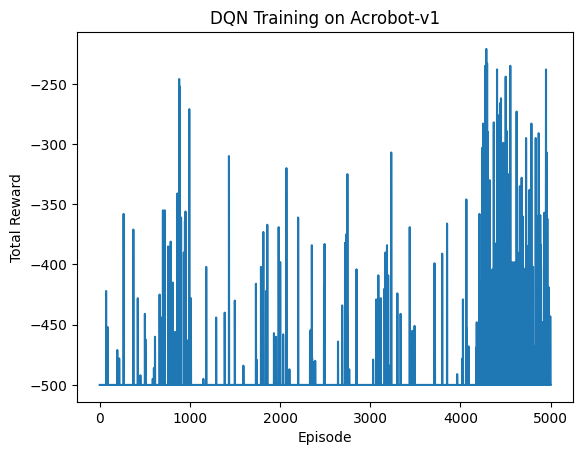

In [ ]:
learning_rate = 0.001
initial_epsilon = 1.0
epsilon_decay = 1e-4
final_epsilon = 0.01
discount_factor = 0.99
replay_buffer_size = 100000
batch_size = 64
target_update_interval = 1000
num_episodes = 5000

env = gym.make("Acrobot-v1", render_mode="rgb_array")

agent = DeepQAgentAcrobot(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=initial_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor,
    replay_buffer_size=replay_buffer_size,
    batch_size=batch_size,
    target_update_interval=target_update_interval,
)

episode_rewards = []

for episode in tqdm(range(num_episodes)):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.replay_buffer.add((state, action, reward, next_state, done))

        agent.train()

        state = next_state
        total_reward += reward

    if episode % agent.target_update_interval == 0:
        agent.update_target_network()

    agent.decay_epsilon()
    print(f"Episode {episode}: Total Reward = {total_reward}")
    episode_rewards.append(total_reward)

env.close()

# Plot training rewards
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training on Acrobot-v1")
plt.show()
